In [1]:
import numpy as np, sympy as sp, pandas as pd, sklearn
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)
import dateutil, datetime
import collections, itertools

sns.set_palette('Set1')

%matplotlib inline

In [2]:
X_train, X_test, y_train = pd.read_csv('X_train.csv'), pd.read_csv('X_test.csv'), pd.read_csv('y_train.csv')

Well let's see what we've got:

In [3]:
X_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [4]:
X_train.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  \
0  34.938093  -9.856322                  none            0   
1  34.698766  -2.147466              Zahanati            0   
2  37.460664  -3.821329           Kwa Mahundi            0   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4  31.130847  -1.825359               Shuleni            0   

           ...          payment_type water_quality quality_group  \
0          ...              annually          soft          good   
1          ...             never pay          soft          good   
2          ...            per bucket          soft          good   
3          ...             never pay          soft          good   
4          ...             never pay          soft          good   

       quantity  quantity_group                source           source_type  \
0        enough          enough                spring                spring   
1  insufficient    insufficient  rainwater harvesting  rainwater harvesting   
2        enough          enough                   dam                   dam   
3           dry             dry           machine dbh              borehole   
4      seasonal        seasonal  rainwater harvesting  rainwater harvesting   

   source_class              waterpoint_type waterpoint_type_group  
0   groundwater           communal standpipe    communal standpipe  
1       surface           communal standpipe    communal standpipe  
2       surface  communal standpipe multiple    communal standpipe  
3   groundwater  communal standpipe multiple    communal standpipe  
4       surface           communal standpipe    communal standpipe  

[5 rows x 40 columns]

There's a lot of categorical variables in there.
We'll need to know which levels will be useful for the actual test data:

In [5]:
def show_intersections(A, B, add_cat_feats=['date_recorded', 'construction_year',
                                            'date_recorded_year', 'date_recorded_month']):
    cat_features = np.where(np.array([(X_train[c].dtype == object)
                                  or (c.endswith('code'))
                                  or (c in add_cat_feats) for c in X_train.columns.values]))[0]
    cat_feats_observed = []
    for c in cat_features:
        n_uni = len(set(A.iloc[:,c]).union(B.iloc[:,c]))
        n_int = len(set(A.iloc[:,c]).intersection(B.iloc[:,c]))
        n_te = len(set(A.iloc[:,c]))
        cat_feats_observed.append((A.columns[c], n_int/n_uni, n_int/n_te))
    cat_feats_observed = (
        pd.DataFrame(cat_feats_observed, columns=['var', 'intersection/union', 'intersection/B'])
        .sort_values('intersection/B')
    )
    return cat_feats_observed
show_intersections(X_train, X_test)

var  intersection/union  intersection/B
3                wpt_name            0.055950        0.068342
5              subvillage            0.294315        0.326939
2               installer            0.343011        0.385368
1                  funder            0.344699        0.388830
14            scheme_name            0.563960        0.599926
0           date_recorded            0.861789        0.893258
13      scheme_management            0.923077        0.923077
10                   ward            0.930887        0.933556
17        extraction_type            0.944444        0.944444
7             region_code            0.962963        0.962963
23           payment_type            1.000000        1.000000
24          water_quality            1.000000        1.000000
27         quantity_group            1.000000        1.000000
26               quantity            1.000000        1.000000
22                payment            1.000000        1.000000
28                 source            1.000000        1.000000
29            source_type            1.000000        1.000000
30           source_class            1.000000        1.000000
25          quality_group            1.000000        1.000000
21       management_group            1.000000        1.000000
16      construction_year            1.000000        1.000000
19  extraction_type_class            1.000000        1.000000
18  extraction_type_group            1.000000        1.000000
31        waterpoint_type            1.000000        1.000000
15                 permit            1.000000        1.000000
12            recorded_by            1.000000        1.000000
11         public_meeting            1.000000        1.000000
9                     lga            1.000000        1.000000
8           district_code            1.000000        1.000000
6                  region            1.000000        1.000000
4                   basin            1.000000        1.000000
20             management            1.000000        1.000000
32  waterpoint_type_group            1.000000        1.000000

In [6]:
for c in X_train.columns:
    display(c, pd.DataFrame(X_train[c].value_counts().head(4)))

'id'

id
2047    1
72310   1
49805   1
51852   1

'amount_tsh'

amount_tsh
0.0          41639
500.0         3102
50.0          2472
1000.0        1488

'date_recorded'

date_recorded
2011-03-15            572
2011-03-17            558
2013-02-03            546
2011-03-14            520

'funder'

funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374

'gps_height'

gps_height
 0        20438
-15          60
-16          55
-13          55

'installer'

installer
DWE             17402
Government       1825
RWE              1206
Commu            1060

'longitude'

longitude
0.000000        1812
37.540901          2
33.010510          2
39.093484          2

'latitude'

latitude
-2.000000e-08      1812
-6.985842e+00         2
-3.797579e+00         2
-6.981884e+00         2

'wpt_name'

wpt_name
none           3563
Shuleni        1748
Zahanati        830
Msikitini       535

'num_private'

num_private
0        58643
6           81
1           73
5           46

'basin'

basin
Lake Victoria  10248
Pangani         8940
Rufiji          7976
Internal        7785

'subvillage'

subvillage
Madukani         508
Shuleni          506
Majengo          502
Kati             373

'region'

region
Iringa         5294
Shinyanga      4982
Mbeya          4639
Kilimanjaro    4379

'region_code'

region_code
11         5300
17         5011
12         4639
3          4379

'district_code'

district_code
1          12203
2          11173
3           9998
4           8999

'lga'

lga
Njombe        2503
Arusha Rural  1252
Moshi Rural   1251
Bariadi       1177

'ward'

ward
Igosi       307
Imalinyi    252
Siha Kati   232
Mdandu      231

'population'

population
0         21381
1          7025
200        1940
150        1892

'public_meeting'

public_meeting
True            51011
False            5055

'recorded_by'

recorded_by
GeoData Consultants Ltd        59400

'scheme_management'

scheme_management
VWC                          36793
WUG                           5206
Water authority               3153
WUA                           2883

'scheme_name'

scheme_name
K                      682
None                   644
Borehole               546
Chalinze wate          405

'permit'

permit
True    38852
False   17492

'construction_year'

construction_year
0                 20709
2010               2645
2008               2613
2009               2533

'extraction_type'

extraction_type
gravity                26780
nira/tanira             8154
other                   6430
submersible             4764

'extraction_type_group'

extraction_type_group
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   6179

'extraction_type_class'

extraction_type_class
gravity                      26780
handpump                     16456
other                         6430
submersible                   6179

'management'

management
vwc               40507
wug                6515
water board        2933
wua                2535

'management_group'

management_group
user-group             52490
commercial              3638
parastatal              1768
other                    943

'payment'

payment
never pay         25348
pay per bucket     8985
pay monthly        8300
unknown            8157

'payment_type'

payment_type
never pay          25348
per bucket          8985
monthly             8300
unknown             8157

'water_quality'

water_quality
soft             50818
salty             4856
unknown           1876
milky              804

'quality_group'

quality_group
good             50818
salty             5195
unknown           1876
milky              804

'quantity'

quantity
enough           33186
insufficient     15129
dry               6246
seasonal          4050

'quantity_group'

quantity_group
enough                 33186
insufficient           15129
dry                     6246
seasonal                4050

'source'

source
spring         17021
shallow well   16824
machine dbh    11075
river           9612

'source_type'

source_type
spring              17021
shallow well        16824
borehole            11949
river/lake          10377

'source_class'

source_class
groundwater         45794
surface             13328
unknown               278

'waterpoint_type'

waterpoint_type
communal standpipe                     28522
hand pump                              17488
other                                   6380
communal standpipe multiple             6103

'waterpoint_type_group'

waterpoint_type_group
communal standpipe                  34625
hand pump                           17488
other                                6380
improved spring                       784

#### [NA] Detecting spoiled data

Looks like all these zeros and `unknown`'s were put into dataset like placeholders
while the true values are simply missing.
We'll replace these dummies with `NA`'s and handle them later

In [7]:
X_train.drop(['num_private', 'recorded_by'], axis=1, inplace=True)
X_test.drop(['num_private', 'recorded_by'], axis=1, inplace=True)
X_train.replace([-np.inf, np.inf, 0, '', 'unknown', 'other', 'others'], np.nan, inplace=True)
X_train.ix[0,'id'] = 0
X_test.replace([-np.inf, np.inf, 0, '', 'unknown', 'other', 'others'], np.nan, inplace=True)

X_train.loc[X_train['population'] == 1, 'population'] = np.nan
X_test.loc[X_test['population'] == 1, 'population'] = np.nan

/home/god/scipy/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


#### [Feature Extraction] Parsing `date_recorded`
The date the record was made together with `construction_year` yields supposed `age` of the waterpoint

In [8]:
class SplitDate(BaseEstimator, TransformerMixin):
    def __init__(self, col='date_recorded', drop=True):
        self.col = col
        self.drop = drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def t(x):
            if isinstance(x, str):
                x = dateutil.parser.parse(x)
            return (x.year, x.month, x.day, x.weekday())
        X = X.copy()
        (X.loc[:, self.col + '_year'],
         X.loc[:, self.col + '_month'],
         X.loc[:, self.col + '_day'],
         X.loc[:, self.col + '_weekday']) = zip(
        *X.loc[:, self.col].map(t))
        if self.drop:
            X = X.drop(self.col, axis=1)
        return X


X_train = SplitDate().fit_transform(X_train)
X_test = SplitDate().fit_transform(X_test)

#### [Feature Extraction] `has_name`

Clearly levels of `wpt_name` won't tell us much about `X_test`.
But it could be that there is a difference between named and unnamed waterpoints.

Although in the future we'll try to apply `CountVectorizer` to all of the factors
including `wpt_name` and filter them using some stat test.

In [9]:
X_train.loc[:,'wpt_name'] = X_train['wpt_name'].notnull() * 1
X_test.loc[:,'wpt_name'] = X_test['wpt_name'].notnull() * 1

### Visualization

In [10]:
X_train_labeled = pd.merge(X_train, y_train, on='id')
X_plt = X_train_labeled.drop(['id', 'wpt_name', 'num_private'], axis=1, errors='ignore')

In [11]:
X_plt.notnull().all(axis=1).sum()

7528

#### [NA]
Now let's display **missing data**

In [12]:
def is_missing(x):
    return pd.isnull(x) # or (x in [-np.inf, np.inf, 0] and x is not False)

def get_na(X):
    na = X.applymap(is_missing).sum()
    na = na[na > 0 ]
    return na.sort_values() # pd.DataFrame(na.sort_values())

In [13]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1)
        .drop('id').sort_values(0).add_prefix('n_missing_'),
        X_train.isnull().sum().sum(),
        X_test.isnull().sum().sum())

n_missing_0  n_missing_1
district_code                   23          4.0
source_class                   278         69.0
source_type                    278         69.0
source                         278         69.0
subvillage                     371         99.0
quantity_group                 789        186.0
quantity                       789        186.0
management                    1405        361.0
management_group              1504        388.0
longitude                     1812        457.0
quality_group                 1876        469.0
water_quality                 1876        469.0
funder                        3635        869.0
installer                     3656        877.0
scheme_management             3877        969.0
waterpoint_type               6380       1630.0
waterpoint_type_group         6380       1630.0
extraction_type_group         6430       1672.0
extraction_type_class         6430       1672.0
extraction_type               6430       1672.0
public_meeting                8389       2112.0
payment                       9211       2252.0
payment_type                  9211       2252.0
gps_height                   20438       5211.0
permit                       20548       5096.0
construction_year            20709       5260.0
scheme_name                  28166       7092.0
population                   28406       7210.0
amount_tsh                   41639      10410.0

241215

60712

Then display a huge **pairplot** of joint distributions:


/home/god/scipy/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/god/scipy/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


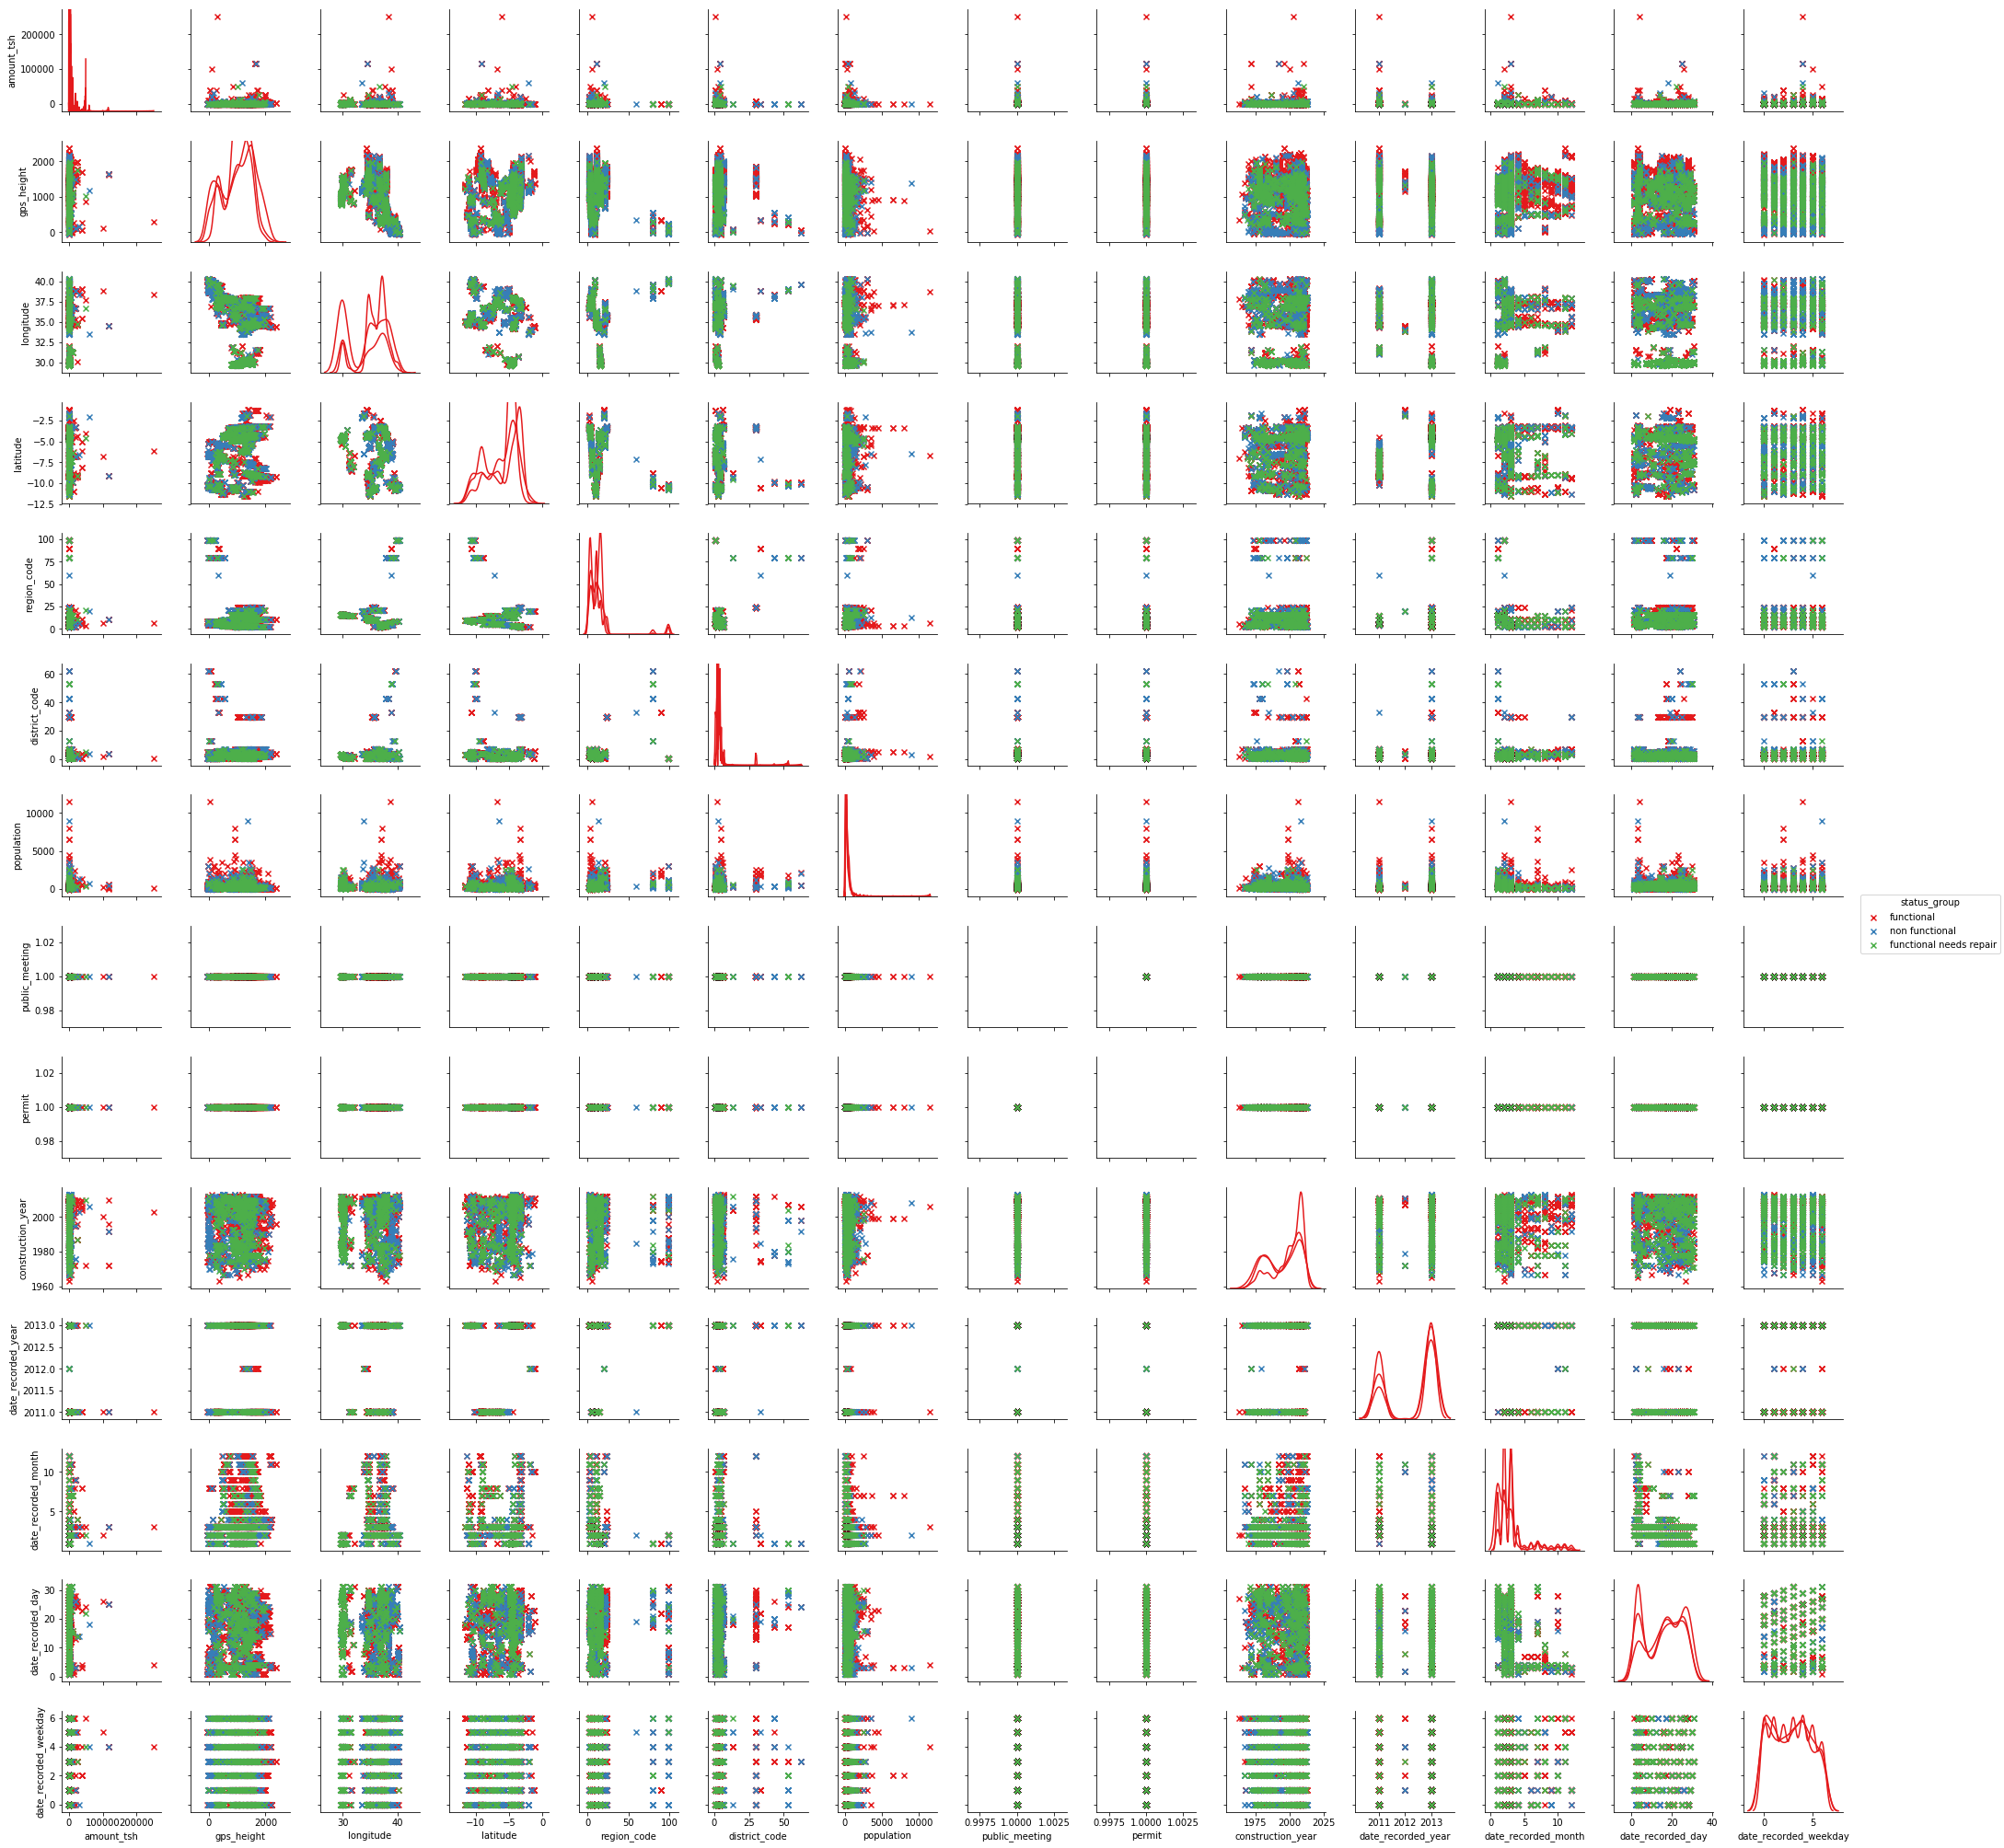

In [14]:
sns.pairplot(X_plt.loc[X_plt.notnull().all(axis=1), :],
             hue='status_group',
             markers='x',
             diag_kind='kde',
             size=2)

#### [Visualization] Descriptive statistics

In [15]:
X_train.drop('id', axis=1).describe()

amount_tsh    gps_height     longitude      latitude  wpt_name  \
count   17761.000000  38962.000000  57588.000000  5.940000e+04   59400.0   
mean     1062.351942   1018.860839     35.149669 -5.706033e+00       1.0   
std      5409.344940    612.566092      2.607428  2.946019e+00       0.0   
min         0.200000    -90.000000     29.607122 -1.164944e+01       1.0   
25%        50.000000    393.000000     33.285100 -8.540621e+00       1.0   
50%       250.000000   1167.000000     35.005943 -5.021597e+00       1.0   
75%      1000.000000   1498.000000     37.233712 -3.326156e+00       1.0   
max    350000.000000   2770.000000     40.345193 -2.000000e-08       1.0   

        region_code  district_code    population  construction_year  \
count  59400.000000   59377.000000  30994.000000       38691.000000   
mean      15.297003       5.631928    344.570820        1996.814686   
std       17.587406       9.634877    607.731177          12.472045   
min        1.000000       1.000000      2.000000        1960.000000   
25%        5.000000       2.000000    100.000000        1987.000000   
50%       12.000000       3.000000    200.000000        2000.000000   
75%       17.000000       5.000000    380.000000        2008.000000   
max       99.000000      80.000000  30500.000000        2013.000000   

       date_recorded_year  date_recorded_month  date_recorded_day  \
count        59400.000000         59400.000000       59400.000000   
mean          2011.921667             4.375640          15.621498   
std              0.958758             3.029247           8.687553   
min           2002.000000             1.000000           1.000000   
25%           2011.000000             2.000000           8.000000   
50%           2012.000000             3.000000          16.000000   
75%           2013.000000             7.000000          23.000000   
max           2013.000000            12.000000          31.000000   

       date_recorded_weekday  
count           59400.000000  
mean                2.939933  
std                 1.951627  
min                 0.000000  
25%                 1.000000  
50%                 3.000000  
75%                 5.000000  
max                 6.000000

#### Levels and unique values

See the **number of levels** for each variable

In [16]:
pd.DataFrame(X_train.agg(lambda x: x.unique().size).sort_values(), columns=['cnt'])

cnt
wpt_name                   1
permit                     2
public_meeting             2
source_class               3
management_group           4
quantity_group             5
date_recorded_year         5
quantity                   5
quality_group              6
payment                    6
payment_type               6
waterpoint_type_group      6
extraction_type_class      7
waterpoint_type            7
source_type                7
date_recorded_weekday      7
water_quality              8
source                     9
basin                      9
management                11
date_recorded_month       12
scheme_management         13
extraction_type_group     13
extraction_type           18
district_code             20
region                    21
region_code               27
date_recorded_day         31
construction_year         55
amount_tsh                98
lga                      125
population              1048
funder                  1898
ward                    2092
installer               2145
gps_height              2428
scheme_name             2697
subvillage             19288
longitude              57516
latitude               57517
id                     59400

In [17]:
X_train.drop(['longitude', 'latitude'], axis=1, inplace=True, errors='ignore')
X_test.drop(['longitude', 'latitude'], axis=1, inplace=True, errors='ignore')

In [18]:
pd.DataFrame(X_train.groupby(['extraction_type_class', 'extraction_type_group'])['extraction_type'].value_counts())

extraction_type
extraction_type_class extraction_type_group extraction_type                           
gravity               gravity               gravity                              26780
handpump              afridev               afridev                               1770
                      india mark ii         india mark ii                         2400
                      india mark iii        india mark iii                          98
                      nira/tanira           nira/tanira                           8154
                      other handpump        other - swn 81                         229
                                            other - play pump                       85
                                            walimi                                  48
                                            other - mkulima/shinyanga                2
                      swn 80                swn 80                                3670
motorpump             mono                  mono                                  2865
                      other motorpump       cemo                                    90
                                            climax                                  32
rope pump             rope pump             other - rope pump                      451
submersible           submersible           submersible                           4764
                                            ksb                                   1415
wind-powered          wind-powered          windmill                               117

In [19]:
pd.DataFrame(X_train.groupby(['source_class', 'source_type'])['source'].value_counts())

source
source_class source_type          source                      
groundwater  borehole             machine dbh            11075
                                  hand dtw                 874
             shallow well         shallow well           16824
             spring               spring                 17021
surface      dam                  dam                      656
             rainwater harvesting rainwater harvesting    2295
             river/lake           river                   9612
                                  lake                     765

In [20]:
X_train.scheme_name.value_counts()

K                                        682
None                                     644
Borehole                                 546
Chalinze wate                            405
M                                        400
DANIDA                                   379
Government                               320
Ngana water supplied scheme              270
wanging'ombe water supply s              261
wanging'ombe supply scheme               234
I                                        229
Bagamoyo wate                            229
Uroki-Bomang'ombe water sup              209
N                                        204
Kirua kahe gravity water supply trust    193
Machumba estate pipe line                185
Makwale water supplied sche              166
Kijiji                                   161
S                                        154
Losaa-Kia water supply                   152
Handeni Trunk Main(H                     152
mtwango water supply scheme              152
Mkongoro T

In [21]:
'Imalinyi' in X_train.subvillage

False

In [22]:
X_labeled = pd.merge(X_train, y_train, on='id')

In [23]:
def cat_outcomes_proprtions(cat):
    cat_cnts = X_labeled[cat].value_counts()
    return (X_labeled
     .groupby([cat])['status_group']
     .value_counts()
     .unstack()
     .transform(lambda x: x/cat_cnts)
    )


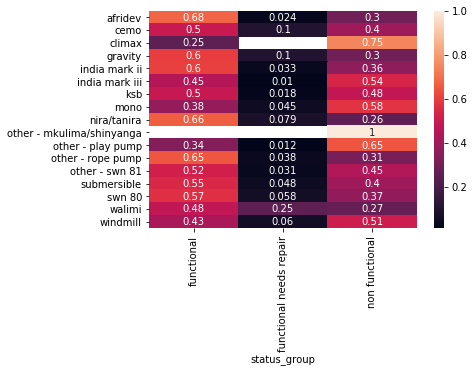

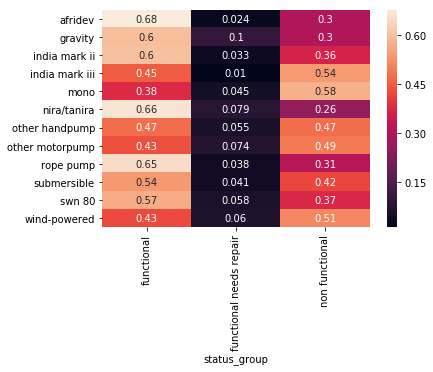

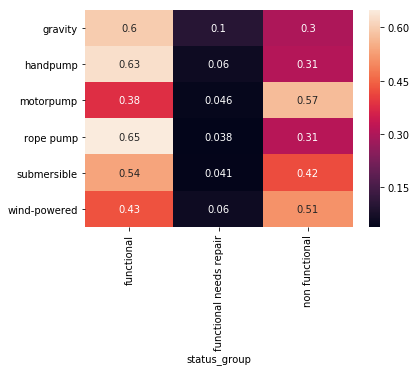

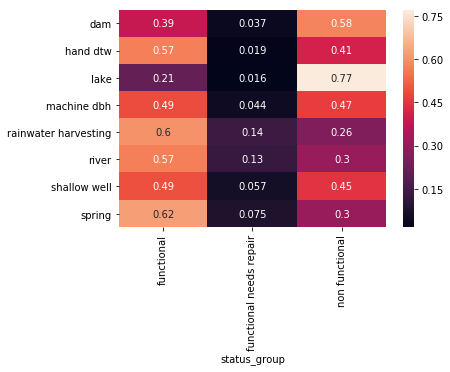

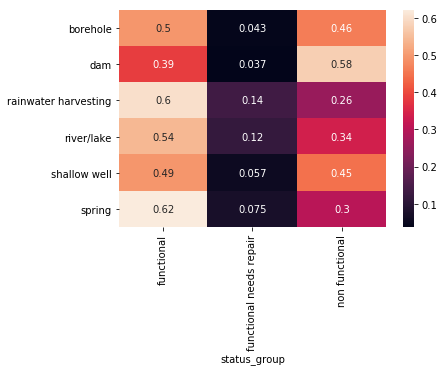

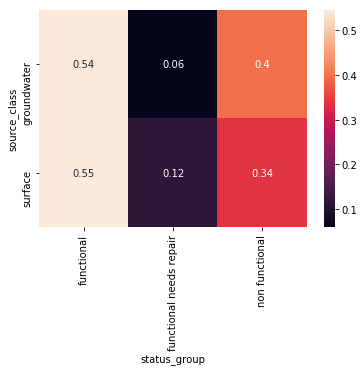

In [24]:
sns.heatmap(cat_outcomes_proprtions('extraction_type'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('extraction_type_group'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('extraction_type_class'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source_type'), annot=True)
plt.show()
sns.heatmap(cat_outcomes_proprtions('source_class'), annot=True)
plt.show()

In [25]:
full = pd.concat((X_train, X_test,), axis=0)

In [26]:
X_train.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'date_recorded_year', 'date_recorded_month', 'date_recorded_day',
       'date_recorded_weekday'],
      dtype='object')

# Missing data

Now let's display the **missing data**

In [27]:
def is_missing(x):
    return pd.isnull(x) # or (x in [-np.inf, np.inf, 0] and x is not False)

def get_na(X):
    na = X.applymap(is_missing).sum()
    na = na[na > 0 ]
    return na.sort_values() # pd.DataFrame(na.sort_values())

In [28]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1).drop('id').sort_values(0),
        X_train.isnull().sum().sum(),
        X_test.isnull().sum().sum())

0        1
district_code             23      4.0
source_class             278     69.0
source_type              278     69.0
source                   278     69.0
subvillage               371     99.0
quantity_group           789    186.0
quantity                 789    186.0
management              1405    361.0
management_group        1504    388.0
water_quality           1876    469.0
quality_group           1876    469.0
funder                  3635    869.0
installer               3656    877.0
scheme_management       3877    969.0
waterpoint_type_group   6380   1630.0
waterpoint_type         6380   1630.0
extraction_type_group   6430   1672.0
extraction_type_class   6430   1672.0
extraction_type         6430   1672.0
public_meeting          8389   2112.0
payment_type            9211   2252.0
payment                 9211   2252.0
gps_height             20438   5211.0
permit                 20548   5096.0
construction_year      20709   5260.0
scheme_name            28166   7092.0
population             28406   7210.0
amount_tsh             41639  10410.0

239403

60255

First we'll convert booleans to floats of $0, 0.5$ and $1$
which stand for `False`, `nan` and `True` respectively

In [29]:
def prep_bool(col):
    X_train.loc[X_train.loc[:,col] == True, col] = 1
    X_train.loc[X_train.loc[:,col] == False, col] = 0
    X_train.loc[:,col].fillna(0.5, inplace=True)
prep_bool('permit')
prep_bool('public_meeting')

In [30]:
cat_feats = np.array(['funder', 'installer', 'basin', 'subvillage',
                      'region', 'region_code', 'district_code', 'lga', 'ward',
                      'scheme_management', 'scheme_name',
                      'extraction_type', 'extraction_type_group', 'extraction_type_class',
                      'management', 'management_group', 'payment', 'payment_type',
                      'water_quality', 'quality_group', 'quantity', 'quantity_group',
                      'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'])
num_feats = np.array(['amount_tsh', 'population', 'gps_height', 'permit', 'public_meeting'])

In [32]:
def remember_na(col):
    X_train[col + '_known'] = 1*X_train[col].notnull()
    X_test[col + '_known'] = 1*X_test[col].notnull()

for c in [_ for _ in X_train.columns]:
    remember_na(c)

In [33]:
def first(x):
    return x[0] if len(x) > 0 else np.nan

def nummed_catmode(x):
    return x.median() if np.issubdtype(x.dtype, np.number) else first(x.value_counts().index)

def fill_w_nummed_catmode(x):
    return x.fillna(nummed_catmode(x))

def fill_df_w_nummed_catmode(df):
    return df.fillna(df.apply(fill_w_nummed_catmode))
        
def groupby_fill_cols(by, cols):
    global X_train, X_test
    X_tr_by = X_train.groupby(by)
    X_te_by = X_test.groupby(by)
    
    if X_train.isnull().any().any():
        tr_med = X_tr_by.apply(fill_df_w_nummed_catmode).loc[:,cols]
        #tr_med = fill_df_w_nummed_catmode(tr_med)
        X_train.loc[:,cols] = X_train.loc[:,cols].fillna(tr_med)
    if X_test.isnull().any().any():
        te_med = X_te_by.apply(fill_df_w_nummed_catmode).loc[:,cols]
        #te_med = fill_df_w_nummed_catmode(te_med)
        X_test.loc[:,cols] = X_test.loc[:,cols].fillna(te_med)
    
def groupby_fill(by):
    global X_train, X_test
    X_tr_by = X_train.groupby(by)
    X_te_by = X_test.groupby(by)
    
    if X_train.isnull().any().any():
        tr_med = X_tr_by.apply(fill_df_w_nummed_catmode)
        #tr_med = fill_df_w_nummed_catmode(tr_med)
        X_train = X_train.fillna(tr_med)
    if X_test.isnull().any().any():
        te_med = X_te_by.apply(fill_df_w_nummed_catmode)
        #te_med = fill_df_w_nummed_catmode(te_med)
        X_test = X_test.fillna(te_med)
    print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))

def fill_col_const(colconsts):
    for col, const in colconsts:
        X_train.loc[X_train[col].isnull(), col] = const
        X_test.loc[X_test[col].isnull(), col] = const

# 

tr_unk_ward = X_train['ward'].isnull()
te_unk_ward = X_test['ward'].isnull()
X_train.loc[tr_unk_ward, cat_feats] = X_train.loc[tr_unk_ward, cat_feats].fillna('unknown')
X_test.loc[te_unk_ward, cat_feats] = X_test.loc[te_unk_ward, cat_feats].fillna('unknown')

print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))
groupby_fill_cols(['lga', 'source_class'], 'source')
groupby_fill_cols(['lga', 'extraction_type_class'], 'extraction_type')
groupby_fill(['basin', 'region', 'lga', 'ward'])
groupby_fill(['basin', 'region', 'lga'])
groupby_fill(['basin', 'region'])
print('%s nulls' % (X_train.isnull().sum().sum() + X_test.isnull().sum().sum()))
groupby_fill_cols('ward', ['basin', 'ward', 'lga', 'region'])
X_train.loc[:, cat_feats] = X_train.loc[:, cat_feats].fillna('unknown')
X_test.loc[:, cat_feats] = X_test.loc[:, cat_feats].fillna('unknown')
groupby_fill('basin')
#groupby_fill('region_code')
#groupby_fill('district_code')

270721 nulls
158025 nulls
109779 nulls
77979 nulls
77979 nulls
0 nulls


In [34]:
display(pd.concat((get_na(X_train), get_na(X_test), ), axis=1).drop('id', errors='ignore').sort_values(0),)

Empty DataFrame
Columns: [0, 1]
Index: []

In [35]:
X_train.loc[:,'age'] = X_train.loc[:,'date_recorded_year'] - X_train.loc[:,'construction_year']
X_test.loc[:,'age'] = X_test.loc[:,'date_recorded_year'] - X_test.loc[:,'construction_year']

## Preparing training and validation sets

In [36]:
y_train['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'], dtype=object)

In [37]:
y_levels = ['non functional', 'functional needs repair', 'functional']

y_train.loc[:, 'status_group'] = y_train.loc[:, 'status_group'].map(lambda x: {
    'functional': 2,
    'functional needs repair': 1,
    'non functional': 0
}[x])

In [38]:
def split_train_cv_test(X, y, proportions=(.75, .25/2, .25/2)):
    # expecting $y$ to be numpy array
    outs = np.unique(y)
    proportions = np.array(proportions)
    classes = [np.where(y == i)[0] for i in outs]
    xparts = [[] for _ in proportions]
    yparts = [[] for _ in proportions]
    for cidx in classes:
        cidx = sklearn.utils.shuffle(cidx)
        cprops = cidx.size * proportions
        cprops = cprops.astype(int)
        cprops[-1] = cidx.size - cprops[:-1].sum()
        # print(cidx)
        cx = X.iloc[cidx,:]
        cy = y[cidx]
        for xpart, ypart, sz in zip(xparts, yparts, cprops):
            xpart.append(cx.iloc[:sz,:])
            ypart.append(cy[:sz])
            cx, cy = cx.iloc[sz:,:], cy[sz:]
    xparts = [pd.concat(xpart) for xpart in xparts]
    yparts = [np.concatenate(ypart) for ypart in yparts]
    parts = xparts + yparts
    return parts

xtr = X_train.drop(['subvillage', 'amount_tsh',
                    'id', 'date_recorded_day', 'date_recorded_week_day',
                    'date_recorded_year', 'construction_year',
                    'source_class'], axis=1, errors='ignore')

xte = X_test # ref
ytr = y_train.iloc[:,1]
xtr, xcv, xva, ytr, ycv, yva = (
    split_train_cv_test(xtr, ytr, proportions=(.7, .15, .15))
)

## CatboostClassifier

Let's check out what we can we get on the raw data

In [39]:
import catboost

In [40]:
cbclf = catboost.CatBoostClassifier(500, loss_function='MultiClass',
                                    eval_metric='Accuracy',
                                    auto_stop_pval=5e-10,
                                    verbose=True,
                                    calc_feature_importance=True)

In [41]:
cbclf.fit(xtr.values,
          ytr,
          eval_set=(xcv, ycv),
          cat_features=[xtr.columns.get_loc(c) for c in cat_feats if c in xtr.columns], verbose=True)
display(cbclf.score(xtr, ytr),
        cbclf.score(xcv, ycv),
        cbclf.score(xva, yva),
        pd.DataFrame(cbclf.feature_importance_, index=xtr.columns.values).sort_values(0)
)

Borders generated
0:	learn 0.7432536438	test 0.7498877414	bestTest 0.7498877414		total: 935ms	remaining: 7m 46s
1:	learn 0.745682813	test 0.7565110013	bestTest 0.7565110013		total: 1.63s	remaining: 6m 45s
2:	learn 0.747005628	test 0.7568477773	bestTest 0.7568477773		total: 2.2s	remaining: 6m 5s
3:	learn 0.7459714272	test 0.7567355186	bestTest 0.7568477773		total: 2.79s	remaining: 5m 45s
4:	learn 0.7480398288	test 0.7583071396	bestTest 0.7583071396		total: 3.34s	remaining: 5m 30s
5:	learn 0.7471258839	test 0.75662326	bestTest 0.7583071396		total: 3.92s	remaining: 5m 23s
6:	learn 0.7478955217	test 0.75662326	bestTest 0.7583071396		total: 4.65s	remaining: 5m 27s
7:	learn 0.7507816634	test 0.7621239335	bestTest 0.7621239335		total: 5.21s	remaining: 5m 20s
8:	learn 0.7514069941	test 0.76324652	bestTest 0.76324652		total: 5.77s	remaining: 5m 14s
9:	learn 0.7519842224	test 0.7625729681	bestTest 0.76324652		total: 6.37s	remaining: 5m 12s
10:	learn 0.7517677618	test 0.7650426583	bestTest 0.7650

87:	learn 0.7730049545	test 0.7840143691	bestTest 0.7840143691		total: 46.7s	remaining: 3m 38s
88:	learn 0.7730049545	test 0.7842388864	bestTest 0.7842388864		total: 47.3s	remaining: 3m 38s
89:	learn 0.7731733128	test 0.7844634037	bestTest 0.7844634037		total: 47.7s	remaining: 3m 37s
90:	learn 0.7733897734	test 0.7841266278	bestTest 0.7844634037		total: 48.2s	remaining: 3m 36s
91:	learn 0.7737505412	test 0.7848001796	bestTest 0.7848001796		total: 48.8s	remaining: 3m 36s
92:	learn 0.7737505412	test 0.7848001796	bestTest 0.7848001796		total: 49.3s	remaining: 3m 35s
93:	learn 0.7737024388	test 0.7848001796	bestTest 0.7848001796		total: 49.8s	remaining: 3m 35s
94:	learn 0.7738226947	test 0.7850246969	bestTest 0.7850246969		total: 50.3s	remaining: 3m 34s
95:	learn 0.7738467459	test 0.7851369555	bestTest 0.7851369555		total: 50.8s	remaining: 3m 33s
96:	learn 0.7740391553	test 0.7852492142	bestTest 0.7852492142		total: 51.3s	remaining: 3m 33s
97:	learn 0.7741113089	test 0.7855859901	bestTest 

173:	learn 0.7814709702	test 0.7904131118	bestTest 0.7908621464		total: 1m 31s	remaining: 2m 50s
174:	learn 0.7815671749	test 0.7904131118	bestTest 0.7908621464		total: 1m 31s	remaining: 2m 50s
175:	learn 0.7816633797	test 0.7906376291	bestTest 0.7908621464		total: 1m 32s	remaining: 2m 49s
176:	learn 0.7816152773	test 0.7904131118	bestTest 0.7908621464		total: 1m 32s	remaining: 2m 49s
177:	learn 0.7817595844	test 0.7903008532	bestTest 0.7908621464		total: 1m 33s	remaining: 2m 48s
178:	learn 0.7818557891	test 0.7903008532	bestTest 0.7908621464		total: 1m 33s	remaining: 2m 48s
179:	learn 0.7819279427	test 0.7904131118	bestTest 0.7908621464		total: 1m 34s	remaining: 2m 47s
180:	learn 0.7819519938	test 0.7905253705	bestTest 0.7908621464		total: 1m 34s	remaining: 2m 47s
181:	learn 0.7821925057	test 0.7905253705	bestTest 0.7908621464		total: 1m 35s	remaining: 2m 46s
182:	learn 0.7822646592	test 0.7904131118	bestTest 0.7908621464		total: 1m 36s	remaining: 2m 46s
183:	learn 0.7824570686	test 0

259:	learn 0.7854634663	test 0.7924337674	bestTest 0.7924337674		total: 2m 16s	remaining: 2m 5s
260:	learn 0.7852710568	test 0.792546026	bestTest 0.792546026		total: 2m 16s	remaining: 2m 5s
261:	learn 0.7853191592	test 0.792546026	bestTest 0.792546026		total: 2m 17s	remaining: 2m 4s
262:	learn 0.7853913127	test 0.7927705433	bestTest 0.7927705433		total: 2m 17s	remaining: 2m 4s
263:	learn 0.7853913127	test 0.792546026	bestTest 0.7927705433		total: 2m 18s	remaining: 2m 3s
264:	learn 0.785559671	test 0.792882802	bestTest 0.792882802		total: 2m 18s	remaining: 2m 3s
265:	learn 0.7855837222	test 0.7927705433	bestTest 0.792882802		total: 2m 19s	remaining: 2m 2s
266:	learn 0.7855356198	test 0.792546026	bestTest 0.792882802		total: 2m 19s	remaining: 2m 2s
267:	learn 0.7856558757	test 0.792546026	bestTest 0.792882802		total: 2m 20s	remaining: 2m 1s
268:	learn 0.7856799269	test 0.7926582847	bestTest 0.792882802		total: 2m 20s	remaining: 2m 1s
269:	learn 0.7854875174	test 0.792546026	bestTest 0.79

345:	learn 0.7873154072	test 0.7943421643	bestTest 0.7951279749		total: 3m	remaining: 1m 20s
346:	learn 0.787291356	test 0.7943421643	bestTest 0.7951279749		total: 3m 1s	remaining: 1m 19s
347:	learn 0.7873635095	test 0.7943421643	bestTest 0.7951279749		total: 3m 1s	remaining: 1m 19s
348:	learn 0.7874837655	test 0.7946789403	bestTest 0.7951279749		total: 3m 2s	remaining: 1m 18s
349:	learn 0.7875078166	test 0.7947911989	bestTest 0.7951279749		total: 3m 2s	remaining: 1m 18s
350:	learn 0.787555919	test 0.7949034576	bestTest 0.7951279749		total: 3m 3s	remaining: 1m 17s
351:	learn 0.7876040214	test 0.7949034576	bestTest 0.7951279749		total: 3m 3s	remaining: 1m 17s
352:	learn 0.7875799702	test 0.7951279749	bestTest 0.7951279749		total: 3m 4s	remaining: 1m 16s
353:	learn 0.7876521237	test 0.7950157162	bestTest 0.7951279749		total: 3m 4s	remaining: 1m 16s
354:	learn 0.7876761749	test 0.7949034576	bestTest 0.7951279749		total: 3m 5s	remaining: 1m 15s
355:	learn 0.7876040214	test 0.7947911989	bes

431:	learn 0.7898648324	test 0.7961383026	bestTest 0.797934441		total: 3m 45s	remaining: 35.5s
432:	learn 0.790081293	test 0.796026044	bestTest 0.797934441		total: 3m 46s	remaining: 35s
433:	learn 0.7900572418	test 0.7959137854	bestTest 0.797934441		total: 3m 46s	remaining: 34.5s
434:	learn 0.7901293954	test 0.796026044	bestTest 0.797934441		total: 3m 47s	remaining: 34s
435:	learn 0.7901534465	test 0.796026044	bestTest 0.797934441		total: 3m 47s	remaining: 33.5s
436:	learn 0.7901293954	test 0.7961383026	bestTest 0.797934441		total: 3m 48s	remaining: 32.9s
437:	learn 0.7900572418	test 0.7961383026	bestTest 0.797934441		total: 3m 48s	remaining: 32.4s
438:	learn 0.790081293	test 0.7961383026	bestTest 0.797934441		total: 3m 49s	remaining: 31.9s
439:	learn 0.7900572418	test 0.7962505613	bestTest 0.797934441		total: 3m 50s	remaining: 31.4s
440:	learn 0.7901774977	test 0.7962505613	bestTest 0.797934441		total: 3m 50s	remaining: 30.8s
441:	learn 0.7901534465	test 0.7962505613	bestTest 0.797934

0.85415363894367213

0.7978221823080377

0.8032308727843841

0
id_known                     0.000000
date_recorded_weekday_known  0.000000
wpt_name_known               0.000000
basin_known                  0.000000
subvillage_known             0.000000
region_known                 0.000000
region_code_known            0.000000
district_code_known          0.000000
ward_known                   0.000000
public_meeting_known         0.000000
lga_known                    0.000000
date_recorded_day_known      0.000000
permit_known                 0.000000
wpt_name                     0.000000
source_known                 0.000000
date_recorded_month_known    0.000000
date_recorded_year_known     0.000000
date_recorded_weekday        0.010351
source_class_known           0.017590
source_type_known            0.018025
scheme_name_known            0.031263
management_group_known       0.051138
scheme_management_known      0.069587
funder_known                 0.098310
permit                       0.098391
gps_height_known             0.123752
date_recorded_month          0.125678
installer_known              0.129514
construction_year_known      0.177747
management_known             0.227005
...                               ...
amount_tsh_known             0.902786
management_group             1.010291
extraction_type_known        1.101440
population                   1.127469
district_code                1.185530
extraction_type_class        1.280692
extraction_type_group_known  1.284335
population_known             1.298703
region                       1.554439
management                   1.598143
region_code                  1.651636
extraction_type_class_known  1.893628
waterpoint_type_known        2.011346
payment                      2.248821
extraction_type_group        2.321027
source                       2.445364
installer                    2.509144
waterpoint_type_group        2.595956
extraction_type              2.810116
source_type                  2.904707
waterpoint_type              3.129822
payment_type                 3.145329
waterpoint_type_group_known  3.532173
scheme_name                  3.801187
funder                       4.615030
age                          5.045546
quantity                     6.830324
ward                         7.097887
quantity_group               9.362927
lga                          9.587467

[72 rows x 1 columns]

Huh, looks like we need to discount specifics of regions and organisation

In [42]:
xtr_n_rows = xtr.shape[0]
xtr = pd.concat((xtr.reset_index(drop=True), xtr.reset_index(drop=True)), ignore_index=True)

In [43]:
feats_to_reset = ['lga', 'ward', 'funder', 'installer', 'region', 'region_code', 'district_code']
xtr.loc[xtr_n_rows:, feats_to_reset] = 'unknown'

In [44]:
ytr = np.concatenate((ytr, ytr))

In [45]:
cbclf.fit(xtr.values,
          ytr,
          eval_set=(xcv, ycv),
          cat_features=[xtr.columns.get_loc(c) for c in cat_feats if c in xtr.columns], verbose=True)
display(cbclf.score(xtr, ytr),
        cbclf.score(xcv, ycv),
        cbclf.score(xva, yva)
)

Borders generated
0:	learn 0.7709485786	test 0.7512348451	bestTest 0.7512348451		total: 1.19s	remaining: 9m 53s
1:	learn 0.7743397951	test 0.7611136057	bestTest 0.7611136057		total: 2.17s	remaining: 9m
2:	learn 0.7769012459	test 0.7638078132	bestTest 0.7638078132		total: 3.21s	remaining: 8m 51s
3:	learn 0.7770816297	test 0.7662775034	bestTest 0.7662775034		total: 4.24s	remaining: 8m 45s
4:	learn 0.7784645726	test 0.7654916929	bestTest 0.7662775034		total: 5.23s	remaining: 8m 37s
5:	learn 0.7793063639	test 0.766389762	bestTest 0.766389762		total: 6.15s	remaining: 8m 26s
6:	learn 0.7785728029	test 0.7652671756	bestTest 0.766389762		total: 7.14s	remaining: 8m 23s
7:	learn 0.7780677281	test 0.7650426583	bestTest 0.766389762		total: 8.13s	remaining: 8m 19s
8:	learn 0.7777550628	test 0.7634710373	bestTest 0.766389762		total: 9.13s	remaining: 8m 18s
9:	learn 0.7778031651	test 0.7649303996	bestTest 0.766389762		total: 10.1s	remaining: 8m 14s
10:	learn 0.7793304151	test 0.7653794342	bestTest 0.

87:	learn 0.7924743855	test 0.7772788505	bestTest 0.7772788505		total: 1m 29s	remaining: 6m 56s
88:	learn 0.7925826158	test 0.7770543332	bestTest 0.7772788505		total: 1m 30s	remaining: 6m 56s
89:	learn 0.7926788205	test 0.7773911091	bestTest 0.7773911091		total: 1m 31s	remaining: 6m 54s
90:	learn 0.7927629997	test 0.7773911091	bestTest 0.7773911091		total: 1m 32s	remaining: 6m 54s
91:	learn 0.7929433835	test 0.7773911091	bestTest 0.7773911091		total: 1m 33s	remaining: 6m 53s
92:	learn 0.7932319977	test 0.7773911091	bestTest 0.7773911091		total: 1m 34s	remaining: 6m 52s
93:	learn 0.7932079465	test 0.7776156264	bestTest 0.7776156264		total: 1m 35s	remaining: 6m 52s
94:	learn 0.7934244071	test 0.7778401437	bestTest 0.7778401437		total: 1m 36s	remaining: 6m 51s
95:	learn 0.7933883304	test 0.7778401437	bestTest 0.7778401437		total: 1m 37s	remaining: 6m 50s
96:	learn 0.7935807398	test 0.7786259542	bestTest 0.7786259542		total: 1m 38s	remaining: 6m 49s
97:	learn 0.7934364327	test 0.7785136956

173:	learn 0.8002188657	test 0.7854737315	bestTest 0.7856982488		total: 3m	remaining: 5m 37s
174:	learn 0.8002068402	test 0.7853614728	bestTest 0.7856982488		total: 3m 1s	remaining: 5m 36s
175:	learn 0.8002308913	test 0.7854737315	bestTest 0.7856982488		total: 3m 2s	remaining: 5m 35s
176:	learn 0.8004112752	test 0.7855859901	bestTest 0.7856982488		total: 3m 3s	remaining: 5m 34s
177:	learn 0.8004593776	test 0.7853614728	bestTest 0.7856982488		total: 3m 4s	remaining: 5m 33s
178:	learn 0.8005195055	test 0.7854737315	bestTest 0.7856982488		total: 3m 5s	remaining: 5m 32s
179:	learn 0.800447352	test 0.7855859901	bestTest 0.7856982488		total: 3m 6s	remaining: 5m 31s
180:	learn 0.8006157102	test 0.7859227661	bestTest 0.7859227661		total: 3m 7s	remaining: 5m 30s
181:	learn 0.8006397614	test 0.7860350247	bestTest 0.7860350247		total: 3m 8s	remaining: 5m 29s
182:	learn 0.8007960941	test 0.7859227661	bestTest 0.7860350247		total: 3m 9s	remaining: 5m 28s
183:	learn 0.800856222	test 0.7860350247	bes

259:	learn 0.8050291019	test 0.789402784	bestTest 0.7901885945		total: 4m 31s	remaining: 4m 10s
260:	learn 0.8050411275	test 0.789402784	bestTest 0.7901885945		total: 4m 32s	remaining: 4m 9s
261:	learn 0.805173409	test 0.789402784	bestTest 0.7901885945		total: 4m 33s	remaining: 4m 8s
262:	learn 0.8051854346	test 0.7891782667	bestTest 0.7901885945		total: 4m 34s	remaining: 4m 7s
263:	learn 0.8051253067	test 0.7891782667	bestTest 0.7901885945		total: 4m 35s	remaining: 4m 6s
264:	learn 0.8051854346	test 0.7889537494	bestTest 0.7901885945		total: 4m 36s	remaining: 4m 5s
265:	learn 0.8052816393	test 0.7891782667	bestTest 0.7901885945		total: 4m 37s	remaining: 4m 4s
266:	learn 0.8053177161	test 0.7892905254	bestTest 0.7901885945		total: 4m 38s	remaining: 4m 3s
267:	learn 0.805437972	test 0.7892905254	bestTest 0.7901885945		total: 4m 39s	remaining: 4m 2s
268:	learn 0.8053898696	test 0.7890660081	bestTest 0.7901885945		total: 4m 40s	remaining: 4m 1s
269:	learn 0.8054740488	test 0.7890660081	be

345:	learn 0.8085405743	test 0.7908621464	bestTest 0.7908621464		total: 6m 1s	remaining: 2m 41s
346:	learn 0.8086127279	test 0.7908621464	bestTest 0.7908621464		total: 6m 2s	remaining: 2m 39s
347:	learn 0.8087209582	test 0.7908621464	bestTest 0.7908621464		total: 6m 3s	remaining: 2m 38s
348:	learn 0.8087690606	test 0.790974405	bestTest 0.790974405		total: 6m 4s	remaining: 2m 37s
349:	learn 0.8088412141	test 0.7908621464	bestTest 0.790974405		total: 6m 5s	remaining: 2m 36s
350:	learn 0.8088772909	test 0.7907498877	bestTest 0.790974405		total: 6m 7s	remaining: 2m 35s
351:	learn 0.8089253932	test 0.7907498877	bestTest 0.790974405		total: 6m 8s	remaining: 2m 34s
352:	learn 0.8090336236	test 0.7911989223	bestTest 0.7911989223		total: 6m 9s	remaining: 2m 33s
353:	learn 0.8091418539	test 0.791311181	bestTest 0.791311181		total: 6m 10s	remaining: 2m 32s
354:	learn 0.8091178027	test 0.790974405	bestTest 0.791311181		total: 6m 11s	remaining: 2m 31s
355:	learn 0.8091779306	test 0.7914234396	bestT

431:	learn 0.811955842	test 0.792882802	bestTest 0.792882802		total: 7m 41s	remaining: 1m 12s
432:	learn 0.8119438164	test 0.792882802	bestTest 0.792882802		total: 7m 43s	remaining: 1m 11s
433:	learn 0.8118355861	test 0.7931073193	bestTest 0.7931073193		total: 7m 44s	remaining: 1m 10s
434:	learn 0.8118355861	test 0.7934440952	bestTest 0.7934440952		total: 7m 46s	remaining: 1m 9s
435:	learn 0.8118716629	test 0.7934440952	bestTest 0.7934440952		total: 7m 47s	remaining: 1m 8s
436:	learn 0.8119678676	test 0.7934440952	bestTest 0.7934440952		total: 7m 48s	remaining: 1m 7s
437:	learn 0.8119438164	test 0.7935563538	bestTest 0.7935563538		total: 7m 49s	remaining: 1m 6s
438:	learn 0.81201597	test 0.7935563538	bestTest 0.7935563538		total: 7m 51s	remaining: 1m 5s
439:	learn 0.8119919188	test 0.7935563538	bestTest 0.7935563538		total: 7m 52s	remaining: 1m 4s
440:	learn 0.8121362259	test 0.7934440952	bestTest 0.7935563538		total: 7m 53s	remaining: 1m 3s
441:	learn 0.8121362259	test 0.7933318366	be

0.84965606811294436

0.79512797485406372

0.79526587390621495

In [46]:
pd.DataFrame(cbclf.feature_importance_, index=xtr.columns.values).sort_values(0).add_prefix('importance_')

importance_0
district_code_known              0.000000
region_known                     0.000000
region_code_known                0.000000
source_known                     0.000000
source_type_known                0.000000
date_recorded_year_known         0.000000
lga_known                        0.000000
wpt_name_known                   0.000000
ward_known                       0.000000
date_recorded_month_known        0.000000
date_recorded_weekday_known      0.000000
id_known                         0.000000
permit_known                     0.000000
date_recorded_day_known          0.000000
wpt_name                         0.000000
public_meeting_known             0.000000
basin_known                      0.000000
source_class_known               0.007092
date_recorded_weekday            0.017141
management_group_known           0.129918
scheme_name_known                0.130946
management_known                 0.158866
region                           0.226975
subvillage_known                 0.228288
district_code                    0.289387
region_code                      0.301537
construction_year_known          0.347078
funder_known                     0.348868
scheme_management_known          0.377000
gps_height_known                 0.405893
...                                   ...
public_meeting                   0.863444
installer                        0.921329
payment_type_known               0.994703
payment_known                    1.015567
gps_height                       1.038709
extraction_type_class            1.062054
date_recorded_month              1.269704
extraction_type_class_known      1.314271
extraction_type_group_known      1.376544
funder                           1.376843
extraction_type_known            1.384598
population_known                 1.416400
population                       1.594738
scheme_management                1.772421
waterpoint_type_group            1.857751
basin                            2.084512
payment_type                     2.589882
waterpoint_type_group_known      2.637222
management                       2.658054
source_type                      2.810859
extraction_type_group            2.817391
payment                          3.159785
waterpoint_type_known            3.325166
waterpoint_type                  3.499637
source                           4.012697
extraction_type                  4.685644
age                              6.499119
quantity                         6.704341
quantity_group                   7.646251
scheme_name                     15.362868

[72 rows x 1 columns]

Weights look more reasonable, but the results is still inappropriate. Got to craft better features!

TBC.

### Factors selection

In [47]:
from sklearn.feature_extraction.text import (
    CountVectorizer
)
from sklearn.feature_selection import (
    SelectKBest, SelectPercentile,
    SelectFpr, VarianceThreshold,
    SelectFromModel,
    chi2, f_classif,
    mutual_info_classif
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    SGDRegressor,
)
from sklearn.pipeline import (
    FeatureUnion, Pipeline
)
from scipy.sparse import hstack

from sklearn.naive_bayes import BernoulliNB

In [48]:
xtr = X_train.drop(['id', 'date_recorded_day', 'date_recorded_week_day',
                    'date_recorded_year', 'construction_year',],
                   axis=1, errors='ignore')

xte = X_test # ref
ytr = y_train.iloc[:,1]
xtr, xcv, xva, ytr, ycv, yva = (
    split_train_cv_test(xtr, ytr, proportions=(.7, .15, .15))
)

In [49]:
xtr.dtypes

amount_tsh                     float64
funder                          object
gps_height                     float64
installer                       object
wpt_name                         int64
basin                           object
subvillage                      object
region                          object
region_code                      int64
district_code                  float64
lga                             object
ward                            object
population                     float64
public_meeting                 float64
scheme_management               object
scheme_name                     object
permit                         float64
extraction_type                 object
extraction_type_group           object
extraction_type_class           object
management                      object
management_group                object
payment                         object
payment_type                    object
water_quality                   object
quality_group            

In [50]:
class LabelencodeAll(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encs_ = collections.defaultdict(sklearn.preprocessing.LabelEncoder)
    def fit(self, X, y=None):
        for c in self.cols:
            if c not in X.columns: continue
            if not np.issubdtype(X[c].dtype, np.number):
                self.encs_[c].fit(X[c].astype(str))
        return self
    def transform(self, X):
        X = X.copy()
        for c, enc in self.encs_.items():
            if c not in X.columns: continue
            if not c in X.columns: continue
            if not np.issubdtype(X.loc[:,c].dtype, np.number):
                X.loc[:,c] = enc.transform(X.loc[:,c].astype(str))
        return X

In [51]:
xtr.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'date_recorded_month',
       'date_recorded_weekday', 'id_known', 'amount_tsh_known', 'funder_known',
       'gps_height_known', 'installer_known', 'wpt_name_known', 'basin_known',
       'subvillage_known', 'region_known', 'region_code_known',
       'district_code_known', 'lga_known', 'ward_known', 'population_known',
       'public_meeting_known', 'scheme_management_known', 'scheme_name_known',
       'permit_known', 'construction_year_

In [52]:
def concat_str_cols(X, colgroups):
    X = X.copy()
    for new_col, cols in colgroups:
        if new_col is None:
            new_col = '_'.join(cols)
        X.loc[:, new_col] = X.loc[:, cols[0]].astype(str)
        for i in range(1, len(cols)):
            X.loc[:, new_col] += ' ' + X.loc[:, cols[i]].astype(str)
        X = X.drop(cols, axis=1)
    return X

cols_to_concat = [
    ('qlt', [
        'water_quality', 'quality_group',
    ]),
    ('qty', [
        'quantity', #'quantity_group',
    ]),
    ('src', [
        'source', #'source_type', 'source_class',
    ]),
    ('cat', [
         'extraction_type', #'extraction_type_group', 'extraction_type_class',
         'waterpoint_type', #'waterpoint_type_group',
         'scheme_name', 'scheme_management',
         'management', 'management_group',
         'payment', 'payment_type'
    ]),
    ('ter', [
        'ward', 'lga', 'region', 'basin', 'subvillage',
    ]),
    ('dis', ['district_code']),
    ('reg', [ 'region_code']),
    ('org', [
        'funder', 'installer',
    ]),
]

exclude = ['extraction_type_group', 'extraction_type_class',
           'waterpoint_type_group', 'quantity_group',
           'source_type', 'source_class',]

xtr.drop(exclude, axis=1, inplace=True)
xcv.drop(exclude, axis=1, inplace=True)
xva.drop(exclude, axis=1, inplace=True)

xtr = concat_str_cols(xtr, cols_to_concat)
xcv = concat_str_cols(xcv, cols_to_concat)
xva = concat_str_cols(xva, cols_to_concat)

In [53]:
xtr.columns

Index(['amount_tsh', 'gps_height', 'wpt_name', 'population', 'public_meeting',
       'permit', 'date_recorded_month', 'date_recorded_weekday', 'id_known',
       'amount_tsh_known', 'funder_known', 'gps_height_known',
       'installer_known', 'wpt_name_known', 'basin_known', 'subvillage_known',
       'region_known', 'region_code_known', 'district_code_known', 'lga_known',
       'ward_known', 'population_known', 'public_meeting_known',
       'scheme_management_known', 'scheme_name_known', 'permit_known',
       'construction_year_known', 'extraction_type_known',
       'extraction_type_group_known', 'extraction_type_class_known',
       'management_known', 'management_group_known', 'payment_known',
       'payment_type_known', 'water_quality_known', 'quality_group_known',
       'quantity_known', 'quantity_group_known', 'source_known',
       'source_type_known', 'source_class_known', 'waterpoint_type_known',
       'waterpoint_type_group_known', 'date_recorded_year_known',
       

In [54]:
def _get_support(tr):
    if hasattr(tr, 'get_feature_names'):
        return tr.get_feature_names()
    elif hasattr(tr, 'get_support'):
        return np.where(tr.get_support())[0]
    elif hasattr(tr, 'steps'):
        return _get_support(tr.steps[-1][1])

class FilterFactors(BaseEstimator, TransformerMixin):
    def __init__(self,
                 cols,
                 sel=Pipeline([
                     ('depfilter', SelectFpr(chi2, 1e-17)),
                     #('lasso', SelectFromModel(LogisticRegressionCV(penalty='l2'), '0.8*mean'))
                 ]),
                 aftersel=SelectKBest(mutual_info_classif, 'all'),
                 ngram_range=(1,2,),
                 min_df=384,
                 cat_na='unknown',
                 num_na=0):
        self.sel = sel
        self.aftersel = aftersel
        self.cols = cols
        self.cat_na = cat_na
        self.num_na = num_na
        self.min_df = min_df
        self.sels_ = (
            collections.defaultdict(
                lambda: sklearn.base.clone(sel)
            )
        )
        self.counters_ = (
            collections.defaultdict(
                lambda: CountVectorizer(
                    ngram_range=ngram_range,
                    binary=True,
                    min_df=self.min_df)))
        self._debug = False
    
    def fit(self, X, y=None):
        X = X.copy()
        self.feat_names_ = []
        for cat in self.cols:
            if cat not in X.columns:
                continue
            if X.loc[:,cat].dtype == object:
                xtr.loc[:,cat].fillna(self.cat_na, inplace=True)
            else:
                X.loc[:,cat].fillna(self.num_na, inplace=True)
                X.loc[:cat] = X.loc[:cat].astype(str)
            counted = cat in self.counters_
            filtered = cat in self.sels_
            v = self.counters_[cat]
            if not counted:
                v.fit(X.loc[:,cat])
            if y is not None:
                tr = v.transform(X.loc[:,cat])
                words = v.get_feature_names()
                sel = self.sels_[cat]
                sel.fit(tr, y)
                for f in _get_support(sel):
                    w = str(words[f]).replace(' ', '_')
                    w = '%s_%s' % (cat, w,)
                    if self._debug:
                        print('adding feature %s' % w)
                    self.feat_names_.append(w)
        if y is not None and self.aftersel is not None:
            if self._debug:
                print(self.sels_[c])
            catfeats = [self.counters_[c].transform(X[c])
                        for c in self.cols]
            catfeats = [self.sels_[c].transform(catfeats[i])
                        for i,c in enumerate(self.cols)]
            catfeats = hstack(catfeats)
            self.aftersel.fit(catfeats, y)
            supp = _get_support(self.aftersel)
            self.feat_names_ = [self.feat_names_[j] for j in supp]
            if self._debug:
                print('aftersel features are: %s' % self.feat_names_)
            
    def transform(self, X, ret_df=False, ret_concat=False):
        catfeats = [self.counters_[c].transform(X[c])
                    for c in self.cols]
        catfeats = [self.sels_[c].transform(catfeats[i])
                    for i,c in enumerate(self.cols)]
        catfeats = hstack(catfeats)
        if self.aftersel is not None:
            catfeats = self.aftersel.transform(catfeats)
        if ret_concat:
            ret_df = True
        if ret_df:
            catfeats = pd.DataFrame(catfeats.toarray(),
                                    columns=self.get_feature_names())
        if ret_concat:
            X = pd.concat((X.drop(self.cols, axis=1, errors='ignore').reset_index(drop=True),
                           catfeats.reset_index(drop=True)),
                           axis=1)
        else:
            X = catfeats
        return X
    
    def get_feature_names(self):
        return np.array(self.feat_names_)
        

In [55]:
ff = FilterFactors([c for c,_ in cols_to_concat])

In [56]:
ybinarizer = sklearn.preprocessing.LabelBinarizer().fit(ytr)
ybin = ybinarizer.transform(ytr)

In [57]:
ff.fit(xtr, ytr)

In [58]:
#for k,s in ff.sels_.items():
#    print(k, s.steps[-1][1].estimator_.coef_[:4,:4])

In [59]:
len(ff.get_feature_names())

210

In [60]:
catfeats = ff.transform(xtr)

In [61]:
catfeats_score = pd.DataFrame(index=ff.get_feature_names(), columns=['chi2', 'pval', ])
(catfeats_score.iloc[:,0], catfeats_score.iloc[:,1]) = chi2(catfeats, ytr)
catfeats_score.sort_values('pval', inplace=True)
catfeats_score

chi2           pval
qty_dry                   6332.197448   0.000000e+00
qty_enough                1114.288056  1.084983e-242
ter_bariadi_shinyanga      902.242387  1.203802e-196
ter_bariadi                899.575534  4.567249e-196
ter_kigoma_rural           873.176283  2.467057e-190
ter_rural_kigoma           873.176283  2.467057e-190
reg_11                     864.047805  2.368117e-188
ter_iringa                 861.223667  9.719791e-188
cat_standpipe_multiple     844.571385  4.014708e-184
cat_multiple               844.571385  4.014708e-184
cat_group_never            819.867780  9.289099e-179
cat_never_pay              805.386693  1.295692e-175
cat_never                  805.386693  1.295692e-175
cat_pay_never              802.054366  6.856578e-175
cat_none_wug               630.097968  1.499563e-137
cat_group_pay              620.143011  2.175987e-135
ter_kigoma_lake            589.792291  8.476787e-129
reg_16                     589.792291  8.476787e-129
ter_kigoma                 586.778233  3.825829e-128
org_dwsp_dwe               508.228041  4.361974e-111
ter_njombe                 503.136755  5.562138e-110
ter_njombe_iringa          503.136755  5.562138e-110
ter_iringa_rufiji          480.594985  4.366414e-105
cat_mono                   479.075961  9.332044e-105
org_of                     477.463868  2.089481e-104
cat_annually_annually      475.427749  5.783303e-104
cat_annually               475.427749  5.783303e-104
cat_pay_annually           475.427749  5.783303e-104
cat_board_water            474.251259  1.041472e-103
cat_monthly                471.076980  5.092528e-103
...                               ...            ...
cat_submersible_communal    92.791650   7.088415e-21
cat_india                   92.183808   9.605953e-21
cat_mark                    92.183808   9.605953e-21
cat_india_mark              92.183808   9.605953e-21
qty_insufficient            92.008479   1.048607e-20
ter_rombo                   91.471585   1.371506e-20
ter_rombo_kilimanjaro       91.471585   1.371506e-20
cat_authority_water         91.331003   1.471379e-20
cat_commercial              90.363647   2.386620e-20
ter_pwani                   90.321542   2.437397e-20
ter_magu                    89.426569   3.813005e-20
ter_magu_mwanza             89.426569   3.813005e-20
cat_ksb_communal            88.393805   6.390414e-20
cat_spring                  87.479967   1.009175e-19
cat_operator_private        86.720566   1.475259e-19
cat_improved                86.264061   1.853520e-19
cat_improved_spring         86.264061   1.853520e-19
ter_rural_arusha            85.545018   2.655434e-19
ter_arusha_rural            85.545018   2.655434e-19
org_church                  85.471053   2.755477e-19
org_district_council        85.124805   3.276298e-19
cat_water_project           84.928463   3.614253e-19
cat_wa                      84.886382   3.691104e-19
cat_company_company         84.223246   5.142265e-19
org_world_bank              83.480678   7.454200e-19
cat_gravity_water           82.409369   1.273600e-18
ter_ludewa                  81.374254   2.137003e-18
cat_company_commercial      80.605304   3.138922e-18
dis_30                      80.306825   3.644135e-18
ter_arusha_pangani          78.610410   8.510723e-18

[210 rows x 2 columns]

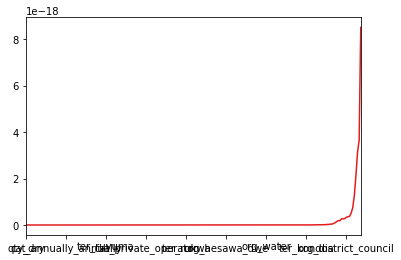

In [62]:
catfeats_score.loc[:,'pval'].plot()

/home/god/scipy/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 2 13 14 16 17 19 20 22 25 43 44 45 46] are constant.
  UserWarning)
/home/god/scipy/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


F           pval
qty_dry                      4266.128563   0.000000e+00
age                          1160.285960   0.000000e+00
qty_enough                   1375.269199   0.000000e+00
extraction_type_class_known  2094.049250   0.000000e+00
extraction_type_group_known  2094.049250   0.000000e+00
extraction_type_known        2094.049250   0.000000e+00
waterpoint_type_known        2257.978409   0.000000e+00
cat_pay_never                 797.662831   0.000000e+00
cat_never_pay                 803.218503   0.000000e+00
waterpoint_type_group_known  2257.978409   0.000000e+00
amount_tsh_known             1107.088122   0.000000e+00
cat_group_never               759.216906   0.000000e+00
cat_never                     803.218503   0.000000e+00
quality_group_known           609.406185  1.391480e-261
water_quality_known           609.406185  1.391480e-261
cat_group_pay                 597.372950  1.667369e-256
cat_standpipe_multiple        487.919475  3.530743e-210
cat_multiple                  487.919475  3.530743e-210
reg_11                        485.338763  4.395597e-209
ter_iringa                    483.898565  1.795720e-208
ter_bariadi_shinyanga         470.238877  1.131031e-202
ter_bariadi                   468.841103  4.437221e-202
ter_kigoma_rural              452.276972  4.840566e-195
ter_rural_kigoma              452.276972  4.840566e-195
cat_gravity_communal          405.716268  3.141175e-175
cat_vwc_user                  390.430126  1.025745e-168
cat_gravity                   386.648207  4.201171e-167
cat_vwc                       384.696415  2.854845e-166
cat_none_wug                  329.588933  9.643483e-143
reg_16                        314.083310  4.126417e-136
...                                  ...            ...
dis_30                         40.914433   1.772358e-18
cat_company_commercial         40.834612   1.919326e-18
ter_arusha_pangani             40.741430   2.106387e-18
date_recorded_month            35.302332   4.801710e-16
scheme_management_known        29.418854   1.708387e-13
amount_tsh                     22.994752   1.044782e-10
permit                         20.123809   1.838944e-09
population                     10.231310   3.611535e-05
subvillage_known                8.664746   1.728752e-04
district_code_known             6.434434   1.606917e-03
management_group_known          5.643284   3.543934e-03
source_known                    4.772100   8.467227e-03
source_type_known               4.772100   8.467227e-03
source_class_known              4.772100   8.467227e-03
date_recorded_weekday           2.124135   1.195493e-01
management_known                1.466464   2.307520e-01
id_known                        0.801257   4.487715e-01
wpt_name                             NaN            NaN
wpt_name_known                       NaN            NaN
basin_known                          NaN            NaN
region_known                         NaN            NaN
region_code_known                    NaN            NaN
lga_known                            NaN            NaN
ward_known                           NaN            NaN
public_meeting_known                 NaN            NaN
permit_known                         NaN            NaN
date_recorded_year_known             NaN            NaN
date_recorded_month_known            NaN            NaN
date_recorded_day_known              NaN            NaN
date_recorded_weekday_known          NaN            NaN

[258 rows x 2 columns]

importance
gps_height                     0.102877
qty_dry                        0.075868
date_recorded_weekday          0.064124
population                     0.056600
age                            0.045806
qty_enough                     0.030548
date_recorded_month            0.023435
amount_tsh                     0.020764
waterpoint_type_known          0.019787
waterpoint_type_group_known    0.019086
qty_insufficient               0.017381
extraction_type_known          0.015088
extraction_type_group_known    0.014325
extraction_type_class_known    0.013134
org_dwe                        0.013133
population_known               0.012675
permit                         0.010284
public_meeting                 0.010119
cat_standpipe_multiple         0.009017
amount_tsh_known               0.008869
scheme_name_known              0.008651
cat_multiple                   0.008596
src_spring                     0.007093
qlt_salty                      0.006093
payment_type_known             0.005922
payment_known                  0.005914
cat_never                      0.005488
cat_supply_vwc                 0.005315
cat_group_never                0.005309
qlt_salty_salty                0.005277
...                                 ...
ter_makete_iringa              0.000280
ter_makete                     0.000280
org_germany                    0.000238
ter_mbeya_rufiji               0.000213
org_danida_danid               0.000201
ter_mbarali_mbeya              0.000191
ter_mbarali                    0.000191
org_danid                      0.000186
org_tanzania_danida            0.000182
district_code_known            0.000171
ter_ludewa                     0.000127
ter_hai_kilimanjaro            0.000119
ter_hai                        0.000116
org_republi                    0.000037
org_germany_republi            0.000036
org_republi_ces                0.000031
id_known                       0.000013
date_recorded_year_known       0.000000
date_recorded_month_known      0.000000
wpt_name                       0.000000
date_recorded_day_known        0.000000
date_recorded_weekday_known    0.000000
permit_known                   0.000000
wpt_name_known                 0.000000
public_meeting_known           0.000000
region_known                   0.000000
ward_known                     0.000000
basin_known                    0.000000
region_code_known              0.000000
lga_known                      0.000000

[258 rows x 1 columns]

In [152]:
_xtr2 = ff.transform(xtr, ret_concat=True)
overall_score = pd.DataFrame(index=_xtr2.columns, columns=['F', 'pval', ])
(overall_score.iloc[:,0], overall_score.iloc[:,1]) = f_classif(_xtr2, ytr)
overall_score.sort_values('pval', inplace=True)
display(overall_score)

xtr2filter = SelectFromModel(ExtraTreesClassifier(500), .001).fit(_xtr2, ytr)
xtr2scores = (pd.DataFrame({
    'importance': xtr2filter.estimator_.feature_importances_
}, index=_xtr2.columns)
              .sort_values('importance', ascending=False)
             )
display(xtr2scores)

xtr2 = xtr2filter.transform(_xtr2)
scaler = StandardScaler().fit(xtr2)

/home/god/scipy/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 2 13 14 16 17 19 20 22 25 43 44 45 46] are constant.
  UserWarning)
/home/god/scipy/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


F           pval
qty_dry                      4266.128563   0.000000e+00
age                          1160.285960   0.000000e+00
qty_enough                   1375.269199   0.000000e+00
extraction_type_class_known  2094.049250   0.000000e+00
extraction_type_group_known  2094.049250   0.000000e+00
extraction_type_known        2094.049250   0.000000e+00
waterpoint_type_known        2257.978409   0.000000e+00
cat_pay_never                 797.662831   0.000000e+00
cat_never_pay                 803.218503   0.000000e+00
waterpoint_type_group_known  2257.978409   0.000000e+00
amount_tsh_known             1107.088122   0.000000e+00
cat_group_never               759.216906   0.000000e+00
cat_never                     803.218503   0.000000e+00
quality_group_known           609.406185  1.391480e-261
water_quality_known           609.406185  1.391480e-261
cat_group_pay                 597.372950  1.667369e-256
cat_standpipe_multiple        487.919475  3.530743e-210
cat_multiple                  487.919475  3.530743e-210
reg_11                        485.338763  4.395597e-209
ter_iringa                    483.898565  1.795720e-208
ter_bariadi_shinyanga         470.238877  1.131031e-202
ter_bariadi                   468.841103  4.437221e-202
ter_kigoma_rural              452.276972  4.840566e-195
ter_rural_kigoma              452.276972  4.840566e-195
cat_gravity_communal          405.716268  3.141175e-175
cat_vwc_user                  390.430126  1.025745e-168
cat_gravity                   386.648207  4.201171e-167
cat_vwc                       384.696415  2.854845e-166
cat_none_wug                  329.588933  9.643483e-143
reg_16                        314.083310  4.126417e-136
...                                  ...            ...
dis_30                         40.914433   1.772358e-18
cat_company_commercial         40.834612   1.919326e-18
ter_arusha_pangani             40.741430   2.106387e-18
date_recorded_month            35.302332   4.801710e-16
scheme_management_known        29.418854   1.708387e-13
amount_tsh                     22.994752   1.044782e-10
permit                         20.123809   1.838944e-09
population                     10.231310   3.611535e-05
subvillage_known                8.664746   1.728752e-04
district_code_known             6.434434   1.606917e-03
management_group_known          5.643284   3.543934e-03
source_known                    4.772100   8.467227e-03
source_type_known               4.772100   8.467227e-03
source_class_known              4.772100   8.467227e-03
date_recorded_weekday           2.124135   1.195493e-01
management_known                1.466464   2.307520e-01
id_known                        0.801257   4.487715e-01
wpt_name                             NaN            NaN
wpt_name_known                       NaN            NaN
basin_known                          NaN            NaN
region_known                         NaN            NaN
region_code_known                    NaN            NaN
lga_known                            NaN            NaN
ward_known                           NaN            NaN
public_meeting_known                 NaN            NaN
permit_known                         NaN            NaN
date_recorded_year_known             NaN            NaN
date_recorded_month_known            NaN            NaN
date_recorded_day_known              NaN            NaN
date_recorded_weekday_known          NaN            NaN

[258 rows x 2 columns]

importance
gps_height                     0.102466
qty_dry                        0.076986
date_recorded_weekday          0.064104
population                     0.056636
age                            0.045745
qty_enough                     0.030010
date_recorded_month            0.023403
amount_tsh                     0.020803
waterpoint_type_known          0.020520
waterpoint_type_group_known    0.020070
qty_insufficient               0.017715
extraction_type_known          0.014642
extraction_type_class_known    0.013812
extraction_type_group_known    0.013725
org_dwe                        0.013254
population_known               0.012853
permit                         0.010215
public_meeting                 0.009916
amount_tsh_known               0.008957
cat_multiple                   0.008905
scheme_name_known              0.008713
cat_standpipe_multiple         0.008626
src_spring                     0.007240
qlt_salty                      0.006022
payment_known                  0.005997
payment_type_known             0.005919
cat_group_never                0.005454
cat_supply_vwc                 0.005284
cat_never                      0.005266
qlt_salty_salty                0.005257
...                                 ...
ter_makete                     0.000287
ter_makete_iringa              0.000264
org_germany                    0.000238
ter_mbeya_rufiji               0.000218
org_tanzania_danida            0.000208
org_danida_danid               0.000203
ter_mbarali_mbeya              0.000191
org_danid                      0.000183
district_code_known            0.000168
ter_mbarali                    0.000158
ter_hai                        0.000132
ter_hai_kilimanjaro            0.000114
ter_ludewa                     0.000109
org_germany_republi            0.000033
org_republi_ces                0.000029
org_republi                    0.000028
id_known                       0.000013
date_recorded_day_known        0.000000
public_meeting_known           0.000000
ward_known                     0.000000
lga_known                      0.000000
region_code_known              0.000000
date_recorded_weekday_known    0.000000
region_known                   0.000000
wpt_name                       0.000000
date_recorded_month_known      0.000000
basin_known                    0.000000
wpt_name_known                 0.000000
date_recorded_year_known       0.000000
permit_known                   0.000000

[258 rows x 1 columns]

In [155]:

xtr2 = scaler.transform(xtr2filter.transform(_xtr2))
xcv2 = scaler.transform(xtr2filter.transform(ff.transform(xcv, ret_concat=True)))
xva2 = scaler.transform(xtr2filter.transform(ff.transform(xva, ret_concat=True)))

In [156]:
cbclf = catboost.CatBoostClassifier(2000, loss_function='MultiClass', eval_metric='Accuracy',)
cbclf.fit(xtr2, ytr,
          eval_set=(xcv2, ycv),
          verbose=True,)
display(cbclf.score(xtr2, ytr),
        cbclf.score(xcv2, ycv),
        cbclf.score(xva2, yva)
)

Borders generated
0:	learn 0.706599644	test 0.7083520431	bestTest 0.7083520431		total: 367ms	remaining: 12m 14s
1:	learn 0.7050122661	test 0.7066681634	bestTest 0.7083520431		total: 564ms	remaining: 9m 23s
2:	learn 0.7086199432	test 0.7110462506	bestTest 0.7110462506		total: 776ms	remaining: 8m 36s
3:	learn 0.7117225456	test 0.7139649753	bestTest 0.7139649753		total: 963ms	remaining: 8m
4:	learn 0.7067439511	test 0.7095868882	bestTest 0.7139649753		total: 1.19s	remaining: 7m 54s
5:	learn 0.7103997306	test 0.7141894926	bestTest 0.7141894926		total: 1.39s	remaining: 7m 42s
6:	learn 0.7120592621	test 0.7162101482	bestTest 0.7162101482		total: 1.63s	remaining: 7m 45s
7:	learn 0.7107845495	test 0.7143017512	bestTest 0.7162101482		total: 1.85s	remaining: 7m 41s
8:	learn 0.7121314157	test 0.7147507858	bestTest 0.7162101482		total: 2.06s	remaining: 7m 35s
9:	learn 0.7120833133	test 0.7147507858	bestTest 0.7162101482		total: 2.28s	remaining: 7m 34s
10:	learn 0.7143441243	test 0.7159856309	bestT

87:	learn 0.7285824234	test 0.7327121688	bestTest 0.7327121688		total: 19.3s	remaining: 6m 59s
88:	learn 0.7290153447	test 0.7334979793	bestTest 0.7334979793		total: 19.5s	remaining: 6m 59s
89:	learn 0.7294001635	test 0.7332734621	bestTest 0.7334979793		total: 19.7s	remaining: 6m 58s
90:	learn 0.7299533407	test 0.7338347553	bestTest 0.7338347553		total: 19.9s	remaining: 6m 57s
91:	learn 0.7305065179	test 0.7343960485	bestTest 0.7343960485		total: 20.1s	remaining: 6m 57s
92:	learn 0.7308672856	test 0.7347328244	bestTest 0.7347328244		total: 20.3s	remaining: 6m 56s
93:	learn 0.7309394391	test 0.7348450831	bestTest 0.7348450831		total: 20.5s	remaining: 6m 56s
94:	learn 0.7311318486	test 0.7350696004	bestTest 0.7350696004		total: 20.7s	remaining: 6m 55s
95:	learn 0.7312521045	test 0.7342837899	bestTest 0.7350696004		total: 20.9s	remaining: 6m 55s
96:	learn 0.7313002068	test 0.7346205658	bestTest 0.7350696004		total: 21.1s	remaining: 6m 54s
97:	learn 0.7313002068	test 0.7347328244	bestTest 

173:	learn 0.7422434942	test 0.7448361024	bestTest 0.7453973956		total: 37.8s	remaining: 6m 37s
174:	learn 0.7422434942	test 0.744948361	bestTest 0.7453973956		total: 38.1s	remaining: 6m 36s
175:	learn 0.7422434942	test 0.7448361024	bestTest 0.7453973956		total: 38.3s	remaining: 6m 37s
176:	learn 0.7423396989	test 0.744948361	bestTest 0.7453973956		total: 38.5s	remaining: 6m 36s
177:	learn 0.7424359036	test 0.744948361	bestTest 0.7453973956		total: 38.7s	remaining: 6m 36s
178:	learn 0.7425321083	test 0.7448361024	bestTest 0.7453973956		total: 39s	remaining: 6m 36s
179:	learn 0.7425080571	test 0.7448361024	bestTest 0.7453973956		total: 39.2s	remaining: 6m 35s
180:	learn 0.7428688249	test 0.744948361	bestTest 0.7453973956		total: 39.4s	remaining: 6m 35s
181:	learn 0.7428688249	test 0.7448361024	bestTest 0.7453973956		total: 39.6s	remaining: 6m 35s
182:	learn 0.7429169272	test 0.744948361	bestTest 0.7453973956		total: 39.8s	remaining: 6m 35s
183:	learn 0.7429650296	test 0.744948361	bestTe

260:	learn 0.7525855019	test 0.7535922766	bestTest 0.7538167939		total: 56.8s	remaining: 6m 18s
261:	learn 0.7526336043	test 0.7538167939	bestTest 0.7538167939		total: 57s	remaining: 6m 18s
262:	learn 0.7525373996	test 0.7535922766	bestTest 0.7538167939		total: 57.2s	remaining: 6m 18s
263:	learn 0.752729809	test 0.7535922766	bestTest 0.7538167939		total: 57.5s	remaining: 6m 17s
264:	learn 0.7528260138	test 0.7533677593	bestTest 0.7538167939		total: 57.7s	remaining: 6m 17s
265:	learn 0.7529222185	test 0.7535922766	bestTest 0.7538167939		total: 57.9s	remaining: 6m 17s
266:	learn 0.7528260138	test 0.7535922766	bestTest 0.7538167939		total: 58.1s	remaining: 6m 17s
267:	learn 0.7530424744	test 0.7533677593	bestTest 0.7538167939		total: 58.3s	remaining: 6m 17s
268:	learn 0.7531146279	test 0.7537045352	bestTest 0.7538167939		total: 58.6s	remaining: 6m 16s
269:	learn 0.7533551397	test 0.7537045352	bestTest 0.7538167939		total: 58.8s	remaining: 6m 16s
270:	learn 0.7530665256	test 0.7535922766	b

347:	learn 0.7579970177	test 0.7580826224	bestTest 0.7580826224		total: 1m 15s	remaining: 5m 59s
348:	learn 0.7582856318	test 0.7588684329	bestTest 0.7588684329		total: 1m 15s	remaining: 5m 59s
349:	learn 0.7582856318	test 0.7589806915	bestTest 0.7589806915		total: 1m 16s	remaining: 5m 58s
350:	learn 0.7582615806	test 0.7587561742	bestTest 0.7589806915		total: 1m 16s	remaining: 5m 58s
351:	learn 0.7582856318	test 0.7587561742	bestTest 0.7589806915		total: 1m 16s	remaining: 5m 58s
352:	learn 0.7584058877	test 0.7586439156	bestTest 0.7589806915		total: 1m 16s	remaining: 5m 58s
353:	learn 0.7585020925	test 0.7587561742	bestTest 0.7589806915		total: 1m 17s	remaining: 5m 58s
354:	learn 0.7589831161	test 0.759766502	bestTest 0.759766502		total: 1m 17s	remaining: 5m 57s
355:	learn 0.7590793208	test 0.7598787607	bestTest 0.7598787607		total: 1m 17s	remaining: 5m 57s
356:	learn 0.7590552696	test 0.7596542434	bestTest 0.7598787607		total: 1m 17s	remaining: 5m 57s
357:	learn 0.7593438838	test 0.7

433:	learn 0.7636490452	test 0.7638078132	bestTest 0.7643691064		total: 1m 33s	remaining: 5m 39s
434:	learn 0.7635768916	test 0.7642568478	bestTest 0.7643691064		total: 1m 34s	remaining: 5m 38s
435:	learn 0.7637211987	test 0.7642568478	bestTest 0.7643691064		total: 1m 34s	remaining: 5m 38s
436:	learn 0.7636730963	test 0.7642568478	bestTest 0.7643691064		total: 1m 34s	remaining: 5m 38s
437:	learn 0.7637452499	test 0.7642568478	bestTest 0.7643691064		total: 1m 34s	remaining: 5m 37s
438:	learn 0.7637452499	test 0.7640323305	bestTest 0.7643691064		total: 1m 34s	remaining: 5m 37s
439:	learn 0.7637452499	test 0.7641445891	bestTest 0.7643691064		total: 1m 35s	remaining: 5m 37s
440:	learn 0.7635768916	test 0.7644813651	bestTest 0.7644813651		total: 1m 35s	remaining: 5m 37s
441:	learn 0.7634566357	test 0.7642568478	bestTest 0.7644813651		total: 1m 35s	remaining: 5m 36s
442:	learn 0.7635528404	test 0.7643691064	bestTest 0.7644813651		total: 1m 35s	remaining: 5m 36s
443:	learn 0.763889557	test 0.

518:	learn 0.7685073837	test 0.7676246071	bestTest 0.7678491244		total: 1m 51s	remaining: 5m 17s
519:	learn 0.7685795373	test 0.7677368657	bestTest 0.7678491244		total: 1m 51s	remaining: 5m 17s
520:	learn 0.7686276396	test 0.7678491244	bestTest 0.7678491244		total: 1m 51s	remaining: 5m 16s
521:	learn 0.768675742	test 0.7678491244	bestTest 0.7678491244		total: 1m 51s	remaining: 5m 16s
522:	learn 0.7687959979	test 0.767961383	bestTest 0.767961383		total: 1m 52s	remaining: 5m 16s
523:	learn 0.7686997932	test 0.7680736417	bestTest 0.7680736417		total: 1m 52s	remaining: 5m 16s
524:	learn 0.7687959979	test 0.7681859003	bestTest 0.7681859003		total: 1m 52s	remaining: 5m 15s
525:	learn 0.7687719467	test 0.768298159	bestTest 0.768298159		total: 1m 52s	remaining: 5m 15s
526:	learn 0.7687719467	test 0.7685226762	bestTest 0.7685226762		total: 1m 52s	remaining: 5m 15s
527:	learn 0.768940305	test 0.7684104176	bestTest 0.7685226762		total: 1m 53s	remaining: 5m 15s
528:	learn 0.7688200491	test 0.76829

605:	learn 0.7723315215	test 0.7718904356	bestTest 0.7722272115		total: 2m 9s	remaining: 4m 57s
606:	learn 0.7722834191	test 0.7716659183	bestTest 0.7722272115		total: 2m 9s	remaining: 4m 56s
607:	learn 0.772403675	test 0.7720026942	bestTest 0.7722272115		total: 2m 9s	remaining: 4m 56s
608:	learn 0.7723796238	test 0.7720026942	bestTest 0.7722272115		total: 2m 9s	remaining: 4m 56s
609:	learn 0.7724277262	test 0.7720026942	bestTest 0.7722272115		total: 2m 9s	remaining: 4m 56s
610:	learn 0.7723555727	test 0.7720026942	bestTest 0.7722272115		total: 2m 10s	remaining: 4m 55s
611:	learn 0.7724998797	test 0.7717781769	bestTest 0.7722272115		total: 2m 10s	remaining: 4m 55s
612:	learn 0.7724998797	test 0.7717781769	bestTest 0.7722272115		total: 2m 10s	remaining: 4m 55s
613:	learn 0.7725720333	test 0.7718904356	bestTest 0.7722272115		total: 2m 10s	remaining: 4m 55s
614:	learn 0.7725479821	test 0.7717781769	bestTest 0.7722272115		total: 2m 10s	remaining: 4m 55s
615:	learn 0.7725960845	test 0.77189

691:	learn 0.7760113522	test 0.7750336776	bestTest 0.7750336776		total: 2m 26s	remaining: 4m 37s
692:	learn 0.7758189427	test 0.7749214189	bestTest 0.7750336776		total: 2m 26s	remaining: 4m 37s
693:	learn 0.7759391986	test 0.7749214189	bestTest 0.7750336776		total: 2m 27s	remaining: 4m 36s
694:	learn 0.7760354033	test 0.7751459362	bestTest 0.7751459362		total: 2m 27s	remaining: 4m 36s
695:	learn 0.7759391986	test 0.7751459362	bestTest 0.7751459362		total: 2m 27s	remaining: 4m 36s
696:	learn 0.7762037616	test 0.7750336776	bestTest 0.7751459362		total: 2m 27s	remaining: 4m 36s
697:	learn 0.7762278128	test 0.7750336776	bestTest 0.7751459362		total: 2m 27s	remaining: 4m 35s
698:	learn 0.7762759151	test 0.7753704535	bestTest 0.7753704535		total: 2m 28s	remaining: 4m 35s
699:	learn 0.7762278128	test 0.7751459362	bestTest 0.7753704535		total: 2m 28s	remaining: 4m 35s
700:	learn 0.7764683246	test 0.7753704535	bestTest 0.7753704535		total: 2m 28s	remaining: 4m 35s
701:	learn 0.7766126317	test 0

777:	learn 0.7801241041	test 0.77649304	bestTest 0.7770543332		total: 2m 44s	remaining: 4m 18s
778:	learn 0.7801962576	test 0.7769420745	bestTest 0.7770543332		total: 2m 44s	remaining: 4m 18s
779:	learn 0.7801962576	test 0.7770543332	bestTest 0.7770543332		total: 2m 44s	remaining: 4m 18s
780:	learn 0.7802203088	test 0.7770543332	bestTest 0.7770543332		total: 2m 45s	remaining: 4m 17s
781:	learn 0.7801000529	test 0.7769420745	bestTest 0.7770543332		total: 2m 45s	remaining: 4m 17s
782:	learn 0.7801481553	test 0.7772788505	bestTest 0.7772788505		total: 2m 45s	remaining: 4m 17s
783:	learn 0.7801481553	test 0.7772788505	bestTest 0.7772788505		total: 2m 45s	remaining: 4m 17s
784:	learn 0.7802924624	test 0.7772788505	bestTest 0.7772788505		total: 2m 45s	remaining: 4m 16s
785:	learn 0.7803886671	test 0.7769420745	bestTest 0.7772788505		total: 2m 46s	remaining: 4m 16s
786:	learn 0.7804608206	test 0.7770543332	bestTest 0.7772788505		total: 2m 46s	remaining: 4m 16s
787:	learn 0.780508923	test 0.77

864:	learn 0.7833229112	test 0.7788504715	bestTest 0.7790749888		total: 3m 2s	remaining: 3m 59s
865:	learn 0.7832267064	test 0.7789627301	bestTest 0.7790749888		total: 3m 2s	remaining: 3m 59s
866:	learn 0.7832267064	test 0.7791872474	bestTest 0.7791872474		total: 3m 2s	remaining: 3m 58s
867:	learn 0.7832267064	test 0.7791872474	bestTest 0.7791872474		total: 3m 3s	remaining: 3m 58s
868:	learn 0.7832026553	test 0.7790749888	bestTest 0.7791872474		total: 3m 3s	remaining: 3m 58s
869:	learn 0.7831786041	test 0.7791872474	bestTest 0.7791872474		total: 3m 3s	remaining: 3m 58s
870:	learn 0.7831786041	test 0.7789627301	bestTest 0.7791872474		total: 3m 3s	remaining: 3m 58s
871:	learn 0.7831545529	test 0.7790749888	bestTest 0.7791872474		total: 3m 3s	remaining: 3m 57s
872:	learn 0.78329886	test 0.7789627301	bestTest 0.7791872474		total: 3m 4s	remaining: 3m 57s
873:	learn 0.7834431671	test 0.7788504715	bestTest 0.7791872474		total: 3m 4s	remaining: 3m 57s
874:	learn 0.7834431671	test 0.7790749888	

951:	learn 0.7852470056	test 0.7800853166	bestTest 0.7800853166		total: 3m 20s	remaining: 3m 40s
952:	learn 0.785295108	test 0.7799730579	bestTest 0.7800853166		total: 3m 20s	remaining: 3m 40s
953:	learn 0.7853191592	test 0.7799730579	bestTest 0.7800853166		total: 3m 20s	remaining: 3m 39s
954:	learn 0.7853432104	test 0.7800853166	bestTest 0.7800853166		total: 3m 20s	remaining: 3m 39s
955:	learn 0.7854394151	test 0.7799730579	bestTest 0.7800853166		total: 3m 20s	remaining: 3m 39s
956:	learn 0.7853191592	test 0.7801975752	bestTest 0.7801975752		total: 3m 21s	remaining: 3m 39s
957:	learn 0.785295108	test 0.7800853166	bestTest 0.7801975752		total: 3m 21s	remaining: 3m 39s
958:	learn 0.7854394151	test 0.7800853166	bestTest 0.7801975752		total: 3m 21s	remaining: 3m 38s
959:	learn 0.7854153639	test 0.7799730579	bestTest 0.7801975752		total: 3m 21s	remaining: 3m 38s
960:	learn 0.7854153639	test 0.7799730579	bestTest 0.7801975752		total: 3m 21s	remaining: 3m 38s
961:	learn 0.7854394151	test 0.7

1037:	learn 0.7877723796	test 0.7823304894	bestTest 0.7826672654		total: 3m 37s	remaining: 3m 21s
1038:	learn 0.787820482	test 0.7825550067	bestTest 0.7826672654		total: 3m 37s	remaining: 3m 21s
1039:	learn 0.7877964308	test 0.7825550067	bestTest 0.7826672654		total: 3m 37s	remaining: 3m 21s
1040:	learn 0.7877242773	test 0.7825550067	bestTest 0.7826672654		total: 3m 38s	remaining: 3m 20s
1041:	learn 0.7877483284	test 0.7826672654	bestTest 0.7826672654		total: 3m 38s	remaining: 3m 20s
1042:	learn 0.7877483284	test 0.7824427481	bestTest 0.7826672654		total: 3m 38s	remaining: 3m 20s
1043:	learn 0.7879166867	test 0.7824427481	bestTest 0.7826672654		total: 3m 38s	remaining: 3m 20s
1044:	learn 0.7879888403	test 0.7825550067	bestTest 0.7826672654		total: 3m 38s	remaining: 3m 19s
1045:	learn 0.7879166867	test 0.7822182308	bestTest 0.7826672654		total: 3m 39s	remaining: 3m 19s
1046:	learn 0.7877964308	test 0.7822182308	bestTest 0.7826672654		total: 3m 39s	remaining: 3m 19s
1047:	learn 0.7880369

1121:	learn 0.7889268363	test 0.7825550067	bestTest 0.7830040413		total: 3m 54s	remaining: 3m 3s
1122:	learn 0.7888546828	test 0.7825550067	bestTest 0.7830040413		total: 3m 55s	remaining: 3m 3s
1123:	learn 0.7889508875	test 0.7826672654	bestTest 0.7830040413		total: 3m 55s	remaining: 3m 3s
1124:	learn 0.7889268363	test 0.7825550067	bestTest 0.7830040413		total: 3m 55s	remaining: 3m 3s
1125:	learn 0.7889749387	test 0.7826672654	bestTest 0.7830040413		total: 3m 55s	remaining: 3m 3s
1126:	learn 0.7890951946	test 0.7825550067	bestTest 0.7830040413		total: 3m 56s	remaining: 3m 2s
1127:	learn 0.7892635528	test 0.7830040413	bestTest 0.7830040413		total: 3m 56s	remaining: 3m 2s
1128:	learn 0.7893597576	test 0.7828917827	bestTest 0.7830040413		total: 3m 56s	remaining: 3m 2s
1129:	learn 0.7894559623	test 0.7832285586	bestTest 0.7832285586		total: 3m 56s	remaining: 3m 2s
1130:	learn 0.789552167	test 0.7831163	bestTest 0.7832285586		total: 3m 56s	remaining: 3m 1s
1131:	learn 0.7893838087	test 0.78

1208:	learn 0.7915965174	test 0.7834530759	bestTest 0.7836775932		total: 4m 12s	remaining: 2m 45s
1209:	learn 0.791548415	test 0.7834530759	bestTest 0.7836775932		total: 4m 12s	remaining: 2m 44s
1210:	learn 0.7915724662	test 0.7834530759	bestTest 0.7836775932		total: 4m 12s	remaining: 2m 44s
1211:	learn 0.791548415	test 0.7834530759	bestTest 0.7836775932		total: 4m 12s	remaining: 2m 44s
1212:	learn 0.7914762615	test 0.7835653345	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 44s
1213:	learn 0.7915724662	test 0.7835653345	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 43s
1214:	learn 0.791548415	test 0.7836775932	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 43s
1215:	learn 0.7914522103	test 0.7835653345	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 43s
1216:	learn 0.791548415	test 0.7834530759	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 43s
1217:	learn 0.7917408245	test 0.7833408172	bestTest 0.7836775932		total: 4m 13s	remaining: 2m 43s
1218:	learn 0.7917648757

1292:	learn 0.7934725095	test 0.782779524	bestTest 0.7840143691		total: 4m 29s	remaining: 2m 27s
1293:	learn 0.7936168166	test 0.7831163	bestTest 0.7840143691		total: 4m 29s	remaining: 2m 26s
1294:	learn 0.7935687142	test 0.7833408172	bestTest 0.7840143691		total: 4m 29s	remaining: 2m 26s
1295:	learn 0.793544663	test 0.7832285586	bestTest 0.7840143691		total: 4m 29s	remaining: 2m 26s
1296:	learn 0.7936168166	test 0.7830040413	bestTest 0.7840143691		total: 4m 29s	remaining: 2m 26s
1297:	learn 0.7936168166	test 0.7830040413	bestTest 0.7840143691		total: 4m 30s	remaining: 2m 26s
1298:	learn 0.7935927654	test 0.7830040413	bestTest 0.7840143691		total: 4m 30s	remaining: 2m 25s
1299:	learn 0.7936168166	test 0.7830040413	bestTest 0.7840143691		total: 4m 30s	remaining: 2m 25s
1300:	learn 0.793544663	test 0.7830040413	bestTest 0.7840143691		total: 4m 30s	remaining: 2m 25s
1301:	learn 0.7936168166	test 0.7830040413	bestTest 0.7840143691		total: 4m 30s	remaining: 2m 25s
1302:	learn 0.7936168166	t

1376:	learn 0.795805474	test 0.782779524	bestTest 0.7840143691		total: 4m 45s	remaining: 2m 9s
1377:	learn 0.7957814229	test 0.782779524	bestTest 0.7840143691		total: 4m 45s	remaining: 2m 8s
1378:	learn 0.7957573717	test 0.7828917827	bestTest 0.7840143691		total: 4m 45s	remaining: 2m 8s
1379:	learn 0.7958295252	test 0.782779524	bestTest 0.7840143691		total: 4m 46s	remaining: 2m 8s
1380:	learn 0.7958535764	test 0.782779524	bestTest 0.7840143691		total: 4m 46s	remaining: 2m 8s
1381:	learn 0.795805474	test 0.782779524	bestTest 0.7840143691		total: 4m 46s	remaining: 2m 8s
1382:	learn 0.7958295252	test 0.7826672654	bestTest 0.7840143691		total: 4m 46s	remaining: 2m 7s
1383:	learn 0.795805474	test 0.782779524	bestTest 0.7840143691		total: 4m 46s	remaining: 2m 7s
1384:	learn 0.7958776276	test 0.7831163	bestTest 0.7840143691		total: 4m 47s	remaining: 2m 7s
1385:	learn 0.7959497811	test 0.7831163	bestTest 0.7840143691		total: 4m 47s	remaining: 2m 7s
1386:	learn 0.7959738323	test 0.7832285586	be

1462:	learn 0.797921978	test 0.7851369555	bestTest 0.7852492142		total: 5m 3s	remaining: 1m 51s
1463:	learn 0.7979941315	test 0.7851369555	bestTest 0.7852492142		total: 5m 3s	remaining: 1m 51s
1464:	learn 0.7981143874	test 0.7852492142	bestTest 0.7852492142		total: 5m 3s	remaining: 1m 50s
1465:	learn 0.7980422339	test 0.7851369555	bestTest 0.7852492142		total: 5m 4s	remaining: 1m 50s
1466:	learn 0.7980662851	test 0.7849124383	bestTest 0.7852492142		total: 5m 4s	remaining: 1m 50s
1467:	learn 0.7981143874	test 0.7850246969	bestTest 0.7852492142		total: 5m 4s	remaining: 1m 50s
1468:	learn 0.7981143874	test 0.7849124383	bestTest 0.7852492142		total: 5m 4s	remaining: 1m 50s
1469:	learn 0.7981384386	test 0.784687921	bestTest 0.7852492142		total: 5m 4s	remaining: 1m 49s
1470:	learn 0.7981624898	test 0.784687921	bestTest 0.7852492142		total: 5m 5s	remaining: 1m 49s
1471:	learn 0.7982346433	test 0.7844634037	bestTest 0.7852492142		total: 5m 5s	remaining: 1m 49s
1472:	learn 0.798186541	test 0.78

1548:	learn 0.7993409976	test 0.784687921	bestTest 0.7852492142		total: 5m 20s	remaining: 1m 33s
1549:	learn 0.7993650488	test 0.7849124383	bestTest 0.7852492142		total: 5m 21s	remaining: 1m 33s
1550:	learn 0.7993891	test 0.7848001796	bestTest 0.7852492142		total: 5m 21s	remaining: 1m 33s
1551:	learn 0.7993891	test 0.7849124383	bestTest 0.7852492142		total: 5m 21s	remaining: 1m 32s
1552:	learn 0.7993650488	test 0.7848001796	bestTest 0.7852492142		total: 5m 21s	remaining: 1m 32s
1553:	learn 0.7994853047	test 0.7848001796	bestTest 0.7852492142		total: 5m 21s	remaining: 1m 32s
1554:	learn 0.7995334071	test 0.784687921	bestTest 0.7852492142		total: 5m 22s	remaining: 1m 32s
1555:	learn 0.7993891	test 0.784687921	bestTest 0.7852492142		total: 5m 22s	remaining: 1m 31s
1556:	learn 0.7994853047	test 0.7848001796	bestTest 0.7852492142		total: 5m 22s	remaining: 1m 31s
1557:	learn 0.7995574583	test 0.7845756623	bestTest 0.7852492142		total: 5m 22s	remaining: 1m 31s
1558:	learn 0.7996055606	test 0.

1632:	learn 0.8008081197	test 0.7856982488	bestTest 0.7860350247		total: 5m 38s	remaining: 1m 15s
1633:	learn 0.8007840685	test 0.7854737315	bestTest 0.7860350247		total: 5m 38s	remaining: 1m 15s
1634:	learn 0.800856222	test 0.7856982488	bestTest 0.7860350247		total: 5m 38s	remaining: 1m 15s
1635:	learn 0.8008802732	test 0.7855859901	bestTest 0.7860350247		total: 5m 38s	remaining: 1m 15s
1636:	learn 0.8009283756	test 0.7855859901	bestTest 0.7860350247		total: 5m 38s	remaining: 1m 15s
1637:	learn 0.800856222	test 0.7853614728	bestTest 0.7860350247		total: 5m 39s	remaining: 1m 14s
1638:	learn 0.8008802732	test 0.7854737315	bestTest 0.7860350247		total: 5m 39s	remaining: 1m 14s
1639:	learn 0.8009524268	test 0.7854737315	bestTest 0.7860350247		total: 5m 39s	remaining: 1m 14s
1640:	learn 0.800856222	test 0.7854737315	bestTest 0.7860350247		total: 5m 39s	remaining: 1m 14s
1641:	learn 0.8008081197	test 0.7856982488	bestTest 0.7860350247		total: 5m 39s	remaining: 1m 14s
1642:	learn 0.800832170

1717:	learn 0.8017942181	test 0.7859227661	bestTest 0.7863718006		total: 5m 55s	remaining: 58.4s
1718:	learn 0.8018663716	test 0.7859227661	bestTest 0.7863718006		total: 5m 55s	remaining: 58.2s
1719:	learn 0.8017942181	test 0.7858105074	bestTest 0.7863718006		total: 5m 55s	remaining: 57.9s
1720:	learn 0.8017701669	test 0.7858105074	bestTest 0.7863718006		total: 5m 56s	remaining: 57.7s
1721:	learn 0.8017461157	test 0.7856982488	bestTest 0.7863718006		total: 5m 56s	remaining: 57.5s
1722:	learn 0.8017220646	test 0.7860350247	bestTest 0.7863718006		total: 5m 56s	remaining: 57.3s
1723:	learn 0.8017701669	test 0.7860350247	bestTest 0.7863718006		total: 5m 56s	remaining: 57.1s
1724:	learn 0.8017942181	test 0.786259542	bestTest 0.7863718006		total: 5m 56s	remaining: 56.9s
1725:	learn 0.8018423205	test 0.786259542	bestTest 0.7863718006		total: 5m 57s	remaining: 56.7s
1726:	learn 0.8019385252	test 0.7864840593	bestTest 0.7864840593		total: 5m 57s	remaining: 56.5s
1727:	learn 0.8018904228	test 0.

1804:	learn 0.8025879071	test 0.7874943871	bestTest 0.7874943871		total: 6m 13s	remaining: 40.3s
1805:	learn 0.8025879071	test 0.7874943871	bestTest 0.7874943871		total: 6m 13s	remaining: 40.1s
1806:	learn 0.8025157535	test 0.7874943871	bestTest 0.7874943871		total: 6m 13s	remaining: 39.9s
1807:	learn 0.8024917023	test 0.7874943871	bestTest 0.7874943871		total: 6m 14s	remaining: 39.7s
1808:	learn 0.8025157535	test 0.7874943871	bestTest 0.7874943871		total: 6m 14s	remaining: 39.5s
1809:	learn 0.8024917023	test 0.7874943871	bestTest 0.7874943871		total: 6m 14s	remaining: 39.3s
1810:	learn 0.8024917023	test 0.7876066457	bestTest 0.7876066457		total: 6m 14s	remaining: 39.1s
1811:	learn 0.8024917023	test 0.7876066457	bestTest 0.7876066457		total: 6m 14s	remaining: 38.9s
1812:	learn 0.8025638559	test 0.7876066457	bestTest 0.7876066457		total: 6m 15s	remaining: 38.7s
1813:	learn 0.8025638559	test 0.7877189044	bestTest 0.7877189044		total: 6m 15s	remaining: 38.5s
1814:	learn 0.8025638559	test 

1889:	learn 0.8033094425	test 0.7872698698	bestTest 0.7880556803		total: 6m 30s	remaining: 22.7s
1890:	learn 0.8034778008	test 0.7873821284	bestTest 0.7880556803		total: 6m 30s	remaining: 22.5s
1891:	learn 0.8034296984	test 0.7873821284	bestTest 0.7880556803		total: 6m 31s	remaining: 22.3s
1892:	learn 0.8032613401	test 0.7874943871	bestTest 0.7880556803		total: 6m 31s	remaining: 22.1s
1893:	learn 0.8032613401	test 0.7877189044	bestTest 0.7880556803		total: 6m 31s	remaining: 21.9s
1894:	learn 0.8032613401	test 0.7873821284	bestTest 0.7880556803		total: 6m 31s	remaining: 21.7s
1895:	learn 0.8032853913	test 0.7873821284	bestTest 0.7880556803		total: 6m 31s	remaining: 21.5s
1896:	learn 0.8032853913	test 0.7873821284	bestTest 0.7880556803		total: 6m 32s	remaining: 21.3s
1897:	learn 0.8033094425	test 0.7876066457	bestTest 0.7880556803		total: 6m 32s	remaining: 21.1s
1898:	learn 0.8034056472	test 0.7876066457	bestTest 0.7880556803		total: 6m 32s	remaining: 20.9s
1899:	learn 0.8034296984	test 

1974:	learn 0.8053778441	test 0.7873821284	bestTest 0.7880556803		total: 6m 47s	remaining: 5.16s
1975:	learn 0.8053297417	test 0.7873821284	bestTest 0.7880556803		total: 6m 47s	remaining: 4.95s
1976:	learn 0.8052575881	test 0.7876066457	bestTest 0.7880556803		total: 6m 47s	remaining: 4.74s
1977:	learn 0.805233537	test 0.7876066457	bestTest 0.7880556803		total: 6m 48s	remaining: 4.54s
1978:	learn 0.8052575881	test 0.7876066457	bestTest 0.7880556803		total: 6m 48s	remaining: 4.33s
1979:	learn 0.8053056905	test 0.787831163	bestTest 0.7880556803		total: 6m 48s	remaining: 4.13s
1980:	learn 0.8053056905	test 0.7876066457	bestTest 0.7880556803		total: 6m 48s	remaining: 3.92s
1981:	learn 0.8052094858	test 0.7876066457	bestTest 0.7880556803		total: 6m 48s	remaining: 3.71s
1982:	learn 0.8052094858	test 0.7876066457	bestTest 0.7880556803		total: 6m 49s	remaining: 3.51s
1983:	learn 0.8051132811	test 0.7876066457	bestTest 0.7880556803		total: 6m 49s	remaining: 3.3s
1984:	learn 0.8051132811	test 0.7

0.80508922988118714

0.78760664571171979

0.79246129683643707

In [157]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.utils

n_inputs = xtr2.shape[1]
n_outputs = 3


In [158]:
n_inputs

168

In [183]:
clf = Sequential([
    Dropout(.5, input_shape=(n_inputs,)),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_inputs, activation='relu'),
    Dense(n_outputs, activation='softmax'),
])
clf.compile(optimizer='sgd',
          loss='categorical_crossentropy',
          metrics=['accuracy'])


In [184]:
clf.fit(xtr2, ybin,
      batch_size=3072,
      epochs=30000)

Epoch 1/30000
41578/41578 [==============================] - 1s - loss: 0.9691 - acc: 0.4808     
Epoch 2/30000
41578/41578 [==============================] - 0s - loss: 0.9282 - acc: 0.5209     
Epoch 3/30000
41578/41578 [==============================] - 0s - loss: 0.9148 - acc: 0.5390     
Epoch 4/30000
41578/41578 [==============================] - 0s - loss: 0.9049 - acc: 0.5491     
Epoch 5/30000
41578/41578 [==============================] - 0s - loss: 0.8986 - acc: 0.5591     
Epoch 6/30000
41578/41578 [==============================] - 0s - loss: 0.8923 - acc: 0.5689     
Epoch 7/30000
41578/41578 [==============================] - 0s - loss: 0.8857 - acc: 0.5786     
Epoch 8/30000
41578/41578 [==============================] - 0s - loss: 0.8804 - acc: 0.5869     
Epoch 9/30000
41578/41578 [==============================] - 0s - loss: 0.8741 - acc: 0.5913     
Epoch 10/30000
41578/41578 [==============================] - 0s - loss: 0.8670 - acc: 0.5987     
Epoch 11/30000
4157

41578/41578 [==============================] - 0s - loss: 0.7274 - acc: 0.6854     
Epoch 84/30000
41578/41578 [==============================] - 0s - loss: 0.7253 - acc: 0.6865     
Epoch 85/30000
41578/41578 [==============================] - 0s - loss: 0.7279 - acc: 0.6873     
Epoch 86/30000
41578/41578 [==============================] - 0s - loss: 0.7271 - acc: 0.6872     
Epoch 87/30000
41578/41578 [==============================] - 0s - loss: 0.7251 - acc: 0.6882     
Epoch 88/30000
41578/41578 [==============================] - 0s - loss: 0.7240 - acc: 0.6879     
Epoch 89/30000
41578/41578 [==============================] - 0s - loss: 0.7269 - acc: 0.6874     
Epoch 90/30000
41578/41578 [==============================] - 0s - loss: 0.7271 - acc: 0.6847     
Epoch 91/30000
41578/41578 [==============================] - 0s - loss: 0.7222 - acc: 0.6896     
Epoch 92/30000
41578/41578 [==============================] - 0s - loss: 0.7236 - acc: 0.6892     
Epoch 93/30000
41578/4157

41578/41578 [==============================] - 0s - loss: 0.7065 - acc: 0.6952     
Epoch 165/30000
41578/41578 [==============================] - 0s - loss: 0.7092 - acc: 0.6925     
Epoch 166/30000
41578/41578 [==============================] - 0s - loss: 0.7076 - acc: 0.6959     
Epoch 167/30000
41578/41578 [==============================] - 0s - loss: 0.7059 - acc: 0.6961     
Epoch 168/30000
41578/41578 [==============================] - 0s - loss: 0.7091 - acc: 0.6933     
Epoch 169/30000
41578/41578 [==============================] - 0s - loss: 0.7072 - acc: 0.6965     
Epoch 170/30000
41578/41578 [==============================] - 0s - loss: 0.7059 - acc: 0.6977     
Epoch 171/30000
41578/41578 [==============================] - 0s - loss: 0.7052 - acc: 0.6952     
Epoch 172/30000
41578/41578 [==============================] - 0s - loss: 0.7068 - acc: 0.6960     
Epoch 173/30000
41578/41578 [==============================] - 0s - loss: 0.7082 - acc: 0.6962     
Epoch 174/30000


41578/41578 [==============================] - 0s - loss: 0.6958 - acc: 0.7031     
Epoch 246/30000
41578/41578 [==============================] - 0s - loss: 0.6979 - acc: 0.7021     
Epoch 247/30000
41578/41578 [==============================] - 0s - loss: 0.6981 - acc: 0.6989     
Epoch 248/30000
41578/41578 [==============================] - 0s - loss: 0.6972 - acc: 0.7008     
Epoch 249/30000
41578/41578 [==============================] - 0s - loss: 0.6979 - acc: 0.6995     
Epoch 250/30000
41578/41578 [==============================] - 0s - loss: 0.6968 - acc: 0.6996     
Epoch 251/30000
41578/41578 [==============================] - 0s - loss: 0.6967 - acc: 0.6994     
Epoch 252/30000
41578/41578 [==============================] - 0s - loss: 0.6960 - acc: 0.7009     
Epoch 253/30000
41578/41578 [==============================] - 0s - loss: 0.6980 - acc: 0.6999     
Epoch 254/30000
41578/41578 [==============================] - 0s - loss: 0.6950 - acc: 0.7009     
Epoch 255/30000


41578/41578 [==============================] - 0s - loss: 0.6912 - acc: 0.7019     
Epoch 328/30000
41578/41578 [==============================] - 0s - loss: 0.6911 - acc: 0.7039     
Epoch 329/30000
41578/41578 [==============================] - 0s - loss: 0.6895 - acc: 0.7041     
Epoch 330/30000
41578/41578 [==============================] - 0s - loss: 0.6896 - acc: 0.7035     
Epoch 331/30000
41578/41578 [==============================] - 0s - loss: 0.6891 - acc: 0.7029     
Epoch 332/30000
41578/41578 [==============================] - 0s - loss: 0.6899 - acc: 0.7052     
Epoch 333/30000
41578/41578 [==============================] - 0s - loss: 0.6905 - acc: 0.7037     
Epoch 334/30000
41578/41578 [==============================] - 0s - loss: 0.6890 - acc: 0.7061     
Epoch 335/30000
41578/41578 [==============================] - 0s - loss: 0.6906 - acc: 0.7036     
Epoch 336/30000
41578/41578 [==============================] - 0s - loss: 0.6903 - acc: 0.7034     
Epoch 337/30000


41578/41578 [==============================] - 0s - loss: 0.6844 - acc: 0.7075     
Epoch 410/30000
41578/41578 [==============================] - 0s - loss: 0.6877 - acc: 0.7036     
Epoch 411/30000
41578/41578 [==============================] - 0s - loss: 0.6841 - acc: 0.7064     
Epoch 412/30000
41578/41578 [==============================] - 0s - loss: 0.6870 - acc: 0.7035     
Epoch 413/30000
41578/41578 [==============================] - 0s - loss: 0.6851 - acc: 0.7050     
Epoch 414/30000
41578/41578 [==============================] - 0s - loss: 0.6849 - acc: 0.7044     
Epoch 415/30000
41578/41578 [==============================] - 0s - loss: 0.6831 - acc: 0.7059     
Epoch 416/30000
41578/41578 [==============================] - 0s - loss: 0.6849 - acc: 0.7062     
Epoch 417/30000
41578/41578 [==============================] - 0s - loss: 0.6843 - acc: 0.7070     
Epoch 418/30000
41578/41578 [==============================] - 0s - loss: 0.6844 - acc: 0.7064     
Epoch 419/30000


41578/41578 [==============================] - 0s - loss: 0.6789 - acc: 0.7102     
Epoch 492/30000
41578/41578 [==============================] - 0s - loss: 0.6789 - acc: 0.7091     
Epoch 493/30000
41578/41578 [==============================] - 0s - loss: 0.6808 - acc: 0.7095     
Epoch 494/30000
41578/41578 [==============================] - 0s - loss: 0.6816 - acc: 0.7092     
Epoch 495/30000
41578/41578 [==============================] - 0s - loss: 0.6793 - acc: 0.7092     
Epoch 496/30000
41578/41578 [==============================] - 0s - loss: 0.6805 - acc: 0.7081     
Epoch 497/30000
41578/41578 [==============================] - 0s - loss: 0.6802 - acc: 0.7085     
Epoch 498/30000
41578/41578 [==============================] - 0s - loss: 0.6774 - acc: 0.7104     
Epoch 499/30000
41578/41578 [==============================] - 0s - loss: 0.6826 - acc: 0.7091     
Epoch 500/30000
41578/41578 [==============================] - 0s - loss: 0.6830 - acc: 0.7072     
Epoch 501/30000


41578/41578 [==============================] - 0s - loss: 0.6753 - acc: 0.7117     
Epoch 574/30000
41578/41578 [==============================] - 0s - loss: 0.6757 - acc: 0.7119     
Epoch 575/30000
41578/41578 [==============================] - 0s - loss: 0.6755 - acc: 0.7122     
Epoch 576/30000
41578/41578 [==============================] - 0s - loss: 0.6765 - acc: 0.7118     
Epoch 577/30000
41578/41578 [==============================] - 0s - loss: 0.6773 - acc: 0.7113     
Epoch 578/30000
41578/41578 [==============================] - 0s - loss: 0.6769 - acc: 0.7085     
Epoch 579/30000
41578/41578 [==============================] - 0s - loss: 0.6776 - acc: 0.7092     
Epoch 580/30000
41578/41578 [==============================] - 0s - loss: 0.6767 - acc: 0.7099     
Epoch 581/30000
41578/41578 [==============================] - 0s - loss: 0.6769 - acc: 0.7102     
Epoch 582/30000
41578/41578 [==============================] - 0s - loss: 0.6759 - acc: 0.7107     
Epoch 583/30000


41578/41578 [==============================] - 0s - loss: 0.6729 - acc: 0.7145     
Epoch 656/30000
41578/41578 [==============================] - 0s - loss: 0.6712 - acc: 0.7119     
Epoch 657/30000
41578/41578 [==============================] - 0s - loss: 0.6714 - acc: 0.7113     
Epoch 658/30000
41578/41578 [==============================] - 0s - loss: 0.6695 - acc: 0.7143     
Epoch 659/30000
41578/41578 [==============================] - 0s - loss: 0.6711 - acc: 0.7120     
Epoch 660/30000
41578/41578 [==============================] - 0s - loss: 0.6720 - acc: 0.7112     
Epoch 661/30000
41578/41578 [==============================] - 0s - loss: 0.6734 - acc: 0.7130     
Epoch 662/30000
41578/41578 [==============================] - 0s - loss: 0.6725 - acc: 0.7107     
Epoch 663/30000
41578/41578 [==============================] - 0s - loss: 0.6713 - acc: 0.7127     
Epoch 664/30000
41578/41578 [==============================] - 0s - loss: 0.6706 - acc: 0.7140     
Epoch 665/30000


41578/41578 [==============================] - 0s - loss: 0.6710 - acc: 0.7120     
Epoch 738/30000
41578/41578 [==============================] - 0s - loss: 0.6680 - acc: 0.7169     
Epoch 739/30000
41578/41578 [==============================] - 0s - loss: 0.6715 - acc: 0.7122     
Epoch 740/30000
41578/41578 [==============================] - 0s - loss: 0.6702 - acc: 0.7145     
Epoch 741/30000
41578/41578 [==============================] - 0s - loss: 0.6684 - acc: 0.7141     
Epoch 742/30000
41578/41578 [==============================] - 0s - loss: 0.6717 - acc: 0.7139     
Epoch 743/30000
41578/41578 [==============================] - 0s - loss: 0.6711 - acc: 0.7116     
Epoch 744/30000
41578/41578 [==============================] - 0s - loss: 0.6718 - acc: 0.7111     
Epoch 745/30000
41578/41578 [==============================] - 0s - loss: 0.6694 - acc: 0.7129     
Epoch 746/30000
41578/41578 [==============================] - 0s - loss: 0.6688 - acc: 0.7130     
Epoch 747/30000


41578/41578 [==============================] - 0s - loss: 0.6645 - acc: 0.7136     
Epoch 820/30000
41578/41578 [==============================] - 0s - loss: 0.6655 - acc: 0.7147     
Epoch 821/30000
41578/41578 [==============================] - 0s - loss: 0.6677 - acc: 0.7147     
Epoch 822/30000
41578/41578 [==============================] - 0s - loss: 0.6695 - acc: 0.7123     
Epoch 823/30000
41578/41578 [==============================] - 0s - loss: 0.6694 - acc: 0.7133     
Epoch 824/30000
41578/41578 [==============================] - 0s - loss: 0.6681 - acc: 0.7147     
Epoch 825/30000
41578/41578 [==============================] - 0s - loss: 0.6639 - acc: 0.7167     
Epoch 826/30000
41578/41578 [==============================] - 0s - loss: 0.6669 - acc: 0.7142     
Epoch 827/30000
41578/41578 [==============================] - 0s - loss: 0.6660 - acc: 0.7146     
Epoch 828/30000
41578/41578 [==============================] - 0s - loss: 0.6660 - acc: 0.7176     
Epoch 829/30000


41578/41578 [==============================] - 0s - loss: 0.6651 - acc: 0.7157     
Epoch 902/30000
41578/41578 [==============================] - 0s - loss: 0.6629 - acc: 0.7161     
Epoch 903/30000
41578/41578 [==============================] - 0s - loss: 0.6626 - acc: 0.7161     
Epoch 904/30000
41578/41578 [==============================] - 0s - loss: 0.6633 - acc: 0.7182     
Epoch 905/30000
41578/41578 [==============================] - 0s - loss: 0.6643 - acc: 0.7163     
Epoch 906/30000
41578/41578 [==============================] - 0s - loss: 0.6623 - acc: 0.7172     
Epoch 907/30000
41578/41578 [==============================] - 0s - loss: 0.6638 - acc: 0.7149     
Epoch 908/30000
41578/41578 [==============================] - 0s - loss: 0.6611 - acc: 0.7166     
Epoch 909/30000
41578/41578 [==============================] - 0s - loss: 0.6648 - acc: 0.7136     
Epoch 910/30000
41578/41578 [==============================] - 0s - loss: 0.6622 - acc: 0.7169     
Epoch 911/30000


41578/41578 [==============================] - 0s - loss: 0.6596 - acc: 0.7198     
Epoch 984/30000
41578/41578 [==============================] - 0s - loss: 0.6602 - acc: 0.7189     
Epoch 985/30000
41578/41578 [==============================] - 0s - loss: 0.6604 - acc: 0.7193     
Epoch 986/30000
41578/41578 [==============================] - 0s - loss: 0.6601 - acc: 0.7202     
Epoch 987/30000
41578/41578 [==============================] - 0s - loss: 0.6609 - acc: 0.7162     
Epoch 988/30000
41578/41578 [==============================] - 0s - loss: 0.6623 - acc: 0.7174     
Epoch 989/30000
41578/41578 [==============================] - 0s - loss: 0.6608 - acc: 0.7174     
Epoch 990/30000
41578/41578 [==============================] - 0s - loss: 0.6593 - acc: 0.7202     
Epoch 991/30000
41578/41578 [==============================] - 0s - loss: 0.6570 - acc: 0.7182     
Epoch 992/30000
41578/41578 [==============================] - 0s - loss: 0.6588 - acc: 0.7176     
Epoch 993/30000


41578/41578 [==============================] - 0s - loss: 0.6578 - acc: 0.7213     
Epoch 1065/30000
41578/41578 [==============================] - 0s - loss: 0.6580 - acc: 0.7178     
Epoch 1066/30000
41578/41578 [==============================] - 0s - loss: 0.6563 - acc: 0.7191     
Epoch 1067/30000
41578/41578 [==============================] - 0s - loss: 0.6573 - acc: 0.7188     
Epoch 1068/30000
41578/41578 [==============================] - 0s - loss: 0.6592 - acc: 0.7181     
Epoch 1069/30000
41578/41578 [==============================] - 0s - loss: 0.6583 - acc: 0.7205     
Epoch 1070/30000
41578/41578 [==============================] - 0s - loss: 0.6585 - acc: 0.7209     
Epoch 1071/30000
41578/41578 [==============================] - 0s - loss: 0.6587 - acc: 0.7195     
Epoch 1072/30000
41578/41578 [==============================] - 0s - loss: 0.6577 - acc: 0.7191     
Epoch 1073/30000
41578/41578 [==============================] - 0s - loss: 0.6613 - acc: 0.7182     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6545 - acc: 0.7213     
Epoch 1146/30000
41578/41578 [==============================] - 0s - loss: 0.6546 - acc: 0.7220     
Epoch 1147/30000
41578/41578 [==============================] - 0s - loss: 0.6564 - acc: 0.7184     
Epoch 1148/30000
41578/41578 [==============================] - 0s - loss: 0.6554 - acc: 0.7213     
Epoch 1149/30000
41578/41578 [==============================] - 0s - loss: 0.6579 - acc: 0.7182     
Epoch 1150/30000
41578/41578 [==============================] - 0s - loss: 0.6560 - acc: 0.7195     
Epoch 1151/30000
41578/41578 [==============================] - 0s - loss: 0.6546 - acc: 0.7214     
Epoch 1152/30000
41578/41578 [==============================] - 0s - loss: 0.6545 - acc: 0.7207     
Epoch 1153/30000
41578/41578 [==============================] - 0s - loss: 0.6526 - acc: 0.7217     
Epoch 1154/30000
41578/41578 [==============================] - 0s - loss: 0.6556 - acc: 0.7236     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6555 - acc: 0.7196     
Epoch 1227/30000
41578/41578 [==============================] - 0s - loss: 0.6504 - acc: 0.7240     
Epoch 1228/30000
41578/41578 [==============================] - 0s - loss: 0.6536 - acc: 0.7219     
Epoch 1229/30000
41578/41578 [==============================] - 0s - loss: 0.6535 - acc: 0.7207     
Epoch 1230/30000
41578/41578 [==============================] - 0s - loss: 0.6533 - acc: 0.7219     
Epoch 1231/30000
41578/41578 [==============================] - 0s - loss: 0.6536 - acc: 0.7194     
Epoch 1232/30000
41578/41578 [==============================] - 0s - loss: 0.6517 - acc: 0.7215     
Epoch 1233/30000
41578/41578 [==============================] - 0s - loss: 0.6537 - acc: 0.7208     
Epoch 1234/30000
41578/41578 [==============================] - 0s - loss: 0.6545 - acc: 0.7198     
Epoch 1235/30000
41578/41578 [==============================] - 0s - loss: 0.6548 - acc: 0.7192     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6492 - acc: 0.7236     
Epoch 1308/30000
41578/41578 [==============================] - 0s - loss: 0.6520 - acc: 0.7223     
Epoch 1309/30000
41578/41578 [==============================] - 0s - loss: 0.6517 - acc: 0.7200     
Epoch 1310/30000
41578/41578 [==============================] - 0s - loss: 0.6509 - acc: 0.7208     
Epoch 1311/30000
41578/41578 [==============================] - 0s - loss: 0.6506 - acc: 0.7216     
Epoch 1312/30000
41578/41578 [==============================] - 0s - loss: 0.6533 - acc: 0.7212     
Epoch 1313/30000
41578/41578 [==============================] - 0s - loss: 0.6477 - acc: 0.7231     
Epoch 1314/30000
41578/41578 [==============================] - 0s - loss: 0.6530 - acc: 0.7225     
Epoch 1315/30000
41578/41578 [==============================] - 0s - loss: 0.6504 - acc: 0.7231     
Epoch 1316/30000
41578/41578 [==============================] - 0s - loss: 0.6517 - acc: 0.7224     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6501 - acc: 0.7228     
Epoch 1389/30000
41578/41578 [==============================] - 0s - loss: 0.6497 - acc: 0.7227     
Epoch 1390/30000
41578/41578 [==============================] - 0s - loss: 0.6479 - acc: 0.7237     
Epoch 1391/30000
41578/41578 [==============================] - 0s - loss: 0.6510 - acc: 0.7225     
Epoch 1392/30000
41578/41578 [==============================] - 0s - loss: 0.6502 - acc: 0.7224     
Epoch 1393/30000
41578/41578 [==============================] - 0s - loss: 0.6496 - acc: 0.7214     
Epoch 1394/30000
41578/41578 [==============================] - 0s - loss: 0.6462 - acc: 0.7249     
Epoch 1395/30000
41578/41578 [==============================] - 0s - loss: 0.6483 - acc: 0.7229     
Epoch 1396/30000
41578/41578 [==============================] - 0s - loss: 0.6498 - acc: 0.7240     
Epoch 1397/30000
41578/41578 [==============================] - 0s - loss: 0.6487 - acc: 0.7235     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6468 - acc: 0.7236     
Epoch 1470/30000
41578/41578 [==============================] - 0s - loss: 0.6488 - acc: 0.7227     - ETA: 0s - loss: 0.6459 - acc: 0
Epoch 1471/30000
41578/41578 [==============================] - 0s - loss: 0.6458 - acc: 0.7238     
Epoch 1472/30000
41578/41578 [==============================] - 0s - loss: 0.6467 - acc: 0.7244     
Epoch 1473/30000
41578/41578 [==============================] - 0s - loss: 0.6462 - acc: 0.7245     
Epoch 1474/30000
41578/41578 [==============================] - 0s - loss: 0.6462 - acc: 0.7239     
Epoch 1475/30000
41578/41578 [==============================] - 0s - loss: 0.6474 - acc: 0.7230     
Epoch 1476/30000
41578/41578 [==============================] - 0s - loss: 0.6482 - acc: 0.7262     
Epoch 1477/30000
41578/41578 [==============================] - 0s - loss: 0.6469 - acc: 0.7229     
Epoch 1478/30000
41578/41578 [==============================] - 0s - loss: 

41578/41578 [==============================] - 0s - loss: 0.6483 - acc: 0.7227     
Epoch 1550/30000
41578/41578 [==============================] - 0s - loss: 0.6427 - acc: 0.7252     
Epoch 1551/30000
41578/41578 [==============================] - 0s - loss: 0.6412 - acc: 0.7245     
Epoch 1552/30000
41578/41578 [==============================] - 0s - loss: 0.6448 - acc: 0.7254     
Epoch 1553/30000
41578/41578 [==============================] - 0s - loss: 0.6443 - acc: 0.7256     
Epoch 1554/30000
41578/41578 [==============================] - 0s - loss: 0.6451 - acc: 0.7245     
Epoch 1555/30000
41578/41578 [==============================] - 0s - loss: 0.6453 - acc: 0.7255     
Epoch 1556/30000
41578/41578 [==============================] - 0s - loss: 0.6426 - acc: 0.7268     
Epoch 1557/30000
41578/41578 [==============================] - 0s - loss: 0.6471 - acc: 0.7244     
Epoch 1558/30000
41578/41578 [==============================] - 0s - loss: 0.6425 - acc: 0.7264     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6426 - acc: 0.7253     
Epoch 1631/30000
41578/41578 [==============================] - 0s - loss: 0.6438 - acc: 0.7265     
Epoch 1632/30000
41578/41578 [==============================] - 0s - loss: 0.6452 - acc: 0.7231     
Epoch 1633/30000
41578/41578 [==============================] - 0s - loss: 0.6424 - acc: 0.7262     
Epoch 1634/30000
41578/41578 [==============================] - 0s - loss: 0.6462 - acc: 0.7232     
Epoch 1635/30000
41578/41578 [==============================] - 0s - loss: 0.6437 - acc: 0.7253     
Epoch 1636/30000
41578/41578 [==============================] - 0s - loss: 0.6460 - acc: 0.7241     
Epoch 1637/30000
41578/41578 [==============================] - 0s - loss: 0.6426 - acc: 0.7250     
Epoch 1638/30000
41578/41578 [==============================] - 0s - loss: 0.6431 - acc: 0.7239     
Epoch 1639/30000
41578/41578 [==============================] - 0s - loss: 0.6427 - acc: 0.7250     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6425 - acc: 0.7249     
Epoch 1712/30000
41578/41578 [==============================] - 0s - loss: 0.6419 - acc: 0.7273     
Epoch 1713/30000
41578/41578 [==============================] - 0s - loss: 0.6420 - acc: 0.7264     
Epoch 1714/30000
41578/41578 [==============================] - 0s - loss: 0.6415 - acc: 0.7253     
Epoch 1715/30000
41578/41578 [==============================] - 0s - loss: 0.6423 - acc: 0.7279     
Epoch 1716/30000
41578/41578 [==============================] - 0s - loss: 0.6412 - acc: 0.7256     
Epoch 1717/30000
41578/41578 [==============================] - 0s - loss: 0.6416 - acc: 0.7272     
Epoch 1718/30000
41578/41578 [==============================] - 0s - loss: 0.6431 - acc: 0.7233     
Epoch 1719/30000
41578/41578 [==============================] - 0s - loss: 0.6421 - acc: 0.7262     
Epoch 1720/30000
41578/41578 [==============================] - 0s - loss: 0.6434 - acc: 0.7266     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6405 - acc: 0.7260     
Epoch 1793/30000
41578/41578 [==============================] - 0s - loss: 0.6386 - acc: 0.7263     
Epoch 1794/30000
41578/41578 [==============================] - 0s - loss: 0.6431 - acc: 0.7261     
Epoch 1795/30000
41578/41578 [==============================] - 0s - loss: 0.6421 - acc: 0.7252     
Epoch 1796/30000
41578/41578 [==============================] - 0s - loss: 0.6417 - acc: 0.7266     
Epoch 1797/30000
41578/41578 [==============================] - 0s - loss: 0.6374 - acc: 0.7273     
Epoch 1798/30000
41578/41578 [==============================] - 0s - loss: 0.6408 - acc: 0.7273     
Epoch 1799/30000
41578/41578 [==============================] - 0s - loss: 0.6446 - acc: 0.7238     
Epoch 1800/30000
41578/41578 [==============================] - 0s - loss: 0.6401 - acc: 0.7268     
Epoch 1801/30000
41578/41578 [==============================] - 0s - loss: 0.6430 - acc: 0.7246     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6396 - acc: 0.7276     
Epoch 1874/30000
41578/41578 [==============================] - 0s - loss: 0.6381 - acc: 0.7275     
Epoch 1875/30000
41578/41578 [==============================] - 0s - loss: 0.6381 - acc: 0.7266     
Epoch 1876/30000
41578/41578 [==============================] - 0s - loss: 0.6395 - acc: 0.7264     
Epoch 1877/30000
41578/41578 [==============================] - 0s - loss: 0.6377 - acc: 0.7290     
Epoch 1878/30000
41578/41578 [==============================] - 0s - loss: 0.6392 - acc: 0.7268     
Epoch 1879/30000
41578/41578 [==============================] - 0s - loss: 0.6411 - acc: 0.7259     
Epoch 1880/30000
41578/41578 [==============================] - 0s - loss: 0.6377 - acc: 0.7266     
Epoch 1881/30000
41578/41578 [==============================] - 0s - loss: 0.6416 - acc: 0.7281     
Epoch 1882/30000
41578/41578 [==============================] - 0s - loss: 0.6407 - acc: 0.7265     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6380 - acc: 0.7290     
Epoch 1955/30000
41578/41578 [==============================] - 0s - loss: 0.6370 - acc: 0.7266     
Epoch 1956/30000
41578/41578 [==============================] - 0s - loss: 0.6346 - acc: 0.7308     
Epoch 1957/30000
41578/41578 [==============================] - 0s - loss: 0.6377 - acc: 0.7284     
Epoch 1958/30000
41578/41578 [==============================] - 0s - loss: 0.6371 - acc: 0.7272     
Epoch 1959/30000
41578/41578 [==============================] - 0s - loss: 0.6386 - acc: 0.7262     
Epoch 1960/30000
41578/41578 [==============================] - 0s - loss: 0.6353 - acc: 0.7282     
Epoch 1961/30000
41578/41578 [==============================] - 0s - loss: 0.6356 - acc: 0.7276     
Epoch 1962/30000
41578/41578 [==============================] - 0s - loss: 0.6389 - acc: 0.7277     
Epoch 1963/30000
41578/41578 [==============================] - 0s - loss: 0.6361 - acc: 0.7301     
Epoch 1

41578/41578 [==============================] - 0s - loss: 0.6319 - acc: 0.7298     
Epoch 2036/30000
41578/41578 [==============================] - 0s - loss: 0.6328 - acc: 0.7278     
Epoch 2037/30000
41578/41578 [==============================] - 0s - loss: 0.6342 - acc: 0.7279     
Epoch 2038/30000
41578/41578 [==============================] - 0s - loss: 0.6364 - acc: 0.7296     
Epoch 2039/30000
41578/41578 [==============================] - 0s - loss: 0.6367 - acc: 0.7281     
Epoch 2040/30000
41578/41578 [==============================] - 0s - loss: 0.6333 - acc: 0.7294     
Epoch 2041/30000
41578/41578 [==============================] - 0s - loss: 0.6338 - acc: 0.7291     
Epoch 2042/30000
41578/41578 [==============================] - 0s - loss: 0.6358 - acc: 0.7296     
Epoch 2043/30000
41578/41578 [==============================] - 0s - loss: 0.6380 - acc: 0.7284     
Epoch 2044/30000
41578/41578 [==============================] - 0s - loss: 0.6361 - acc: 0.7245     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6339 - acc: 0.7284     
Epoch 2117/30000
41578/41578 [==============================] - 0s - loss: 0.6335 - acc: 0.7293     
Epoch 2118/30000
41578/41578 [==============================] - 0s - loss: 0.6348 - acc: 0.7306     
Epoch 2119/30000
41578/41578 [==============================] - 0s - loss: 0.6329 - acc: 0.7292     
Epoch 2120/30000
41578/41578 [==============================] - 0s - loss: 0.6328 - acc: 0.7308     
Epoch 2121/30000
41578/41578 [==============================] - 0s - loss: 0.6333 - acc: 0.7311     
Epoch 2122/30000
41578/41578 [==============================] - 0s - loss: 0.6338 - acc: 0.7309     
Epoch 2123/30000
41578/41578 [==============================] - 0s - loss: 0.6330 - acc: 0.7301     
Epoch 2124/30000
41578/41578 [==============================] - 0s - loss: 0.6338 - acc: 0.7265     
Epoch 2125/30000
41578/41578 [==============================] - 0s - loss: 0.6316 - acc: 0.7301     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6327 - acc: 0.7305     
Epoch 2198/30000
41578/41578 [==============================] - 0s - loss: 0.6294 - acc: 0.7309     
Epoch 2199/30000
41578/41578 [==============================] - 0s - loss: 0.6321 - acc: 0.7302     
Epoch 2200/30000
41578/41578 [==============================] - 0s - loss: 0.6332 - acc: 0.7294     
Epoch 2201/30000
41578/41578 [==============================] - 0s - loss: 0.6326 - acc: 0.7284     
Epoch 2202/30000
41578/41578 [==============================] - 0s - loss: 0.6319 - acc: 0.7315     
Epoch 2203/30000
41578/41578 [==============================] - 0s - loss: 0.6307 - acc: 0.7315     
Epoch 2204/30000
41578/41578 [==============================] - 0s - loss: 0.6325 - acc: 0.7277     
Epoch 2205/30000
41578/41578 [==============================] - 0s - loss: 0.6334 - acc: 0.7291     
Epoch 2206/30000
41578/41578 [==============================] - 0s - loss: 0.6309 - acc: 0.7312     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6303 - acc: 0.7315     
Epoch 2279/30000
41578/41578 [==============================] - 0s - loss: 0.6343 - acc: 0.7285     
Epoch 2280/30000
41578/41578 [==============================] - 0s - loss: 0.6311 - acc: 0.7301     
Epoch 2281/30000
41578/41578 [==============================] - 0s - loss: 0.6310 - acc: 0.7307     
Epoch 2282/30000
41578/41578 [==============================] - 0s - loss: 0.6294 - acc: 0.7323     
Epoch 2283/30000
41578/41578 [==============================] - 0s - loss: 0.6323 - acc: 0.7312     
Epoch 2284/30000
41578/41578 [==============================] - 0s - loss: 0.6312 - acc: 0.7294     
Epoch 2285/30000
41578/41578 [==============================] - 0s - loss: 0.6291 - acc: 0.7319     
Epoch 2286/30000
41578/41578 [==============================] - 0s - loss: 0.6286 - acc: 0.7330     
Epoch 2287/30000
41578/41578 [==============================] - 0s - loss: 0.6329 - acc: 0.7281     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6297 - acc: 0.7301     
Epoch 2360/30000
41578/41578 [==============================] - 0s - loss: 0.6312 - acc: 0.7300     
Epoch 2361/30000
41578/41578 [==============================] - 0s - loss: 0.6264 - acc: 0.7327     
Epoch 2362/30000
41578/41578 [==============================] - 0s - loss: 0.6295 - acc: 0.7304     
Epoch 2363/30000
41578/41578 [==============================] - 0s - loss: 0.6277 - acc: 0.7319     
Epoch 2364/30000
41578/41578 [==============================] - 0s - loss: 0.6290 - acc: 0.7302     
Epoch 2365/30000
41578/41578 [==============================] - 0s - loss: 0.6291 - acc: 0.7301     
Epoch 2366/30000
41578/41578 [==============================] - 0s - loss: 0.6299 - acc: 0.7312     
Epoch 2367/30000
41578/41578 [==============================] - 0s - loss: 0.6298 - acc: 0.7307     
Epoch 2368/30000
41578/41578 [==============================] - 0s - loss: 0.6326 - acc: 0.7297     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6271 - acc: 0.7341     
Epoch 2441/30000
41578/41578 [==============================] - 0s - loss: 0.6274 - acc: 0.7316     
Epoch 2442/30000
41578/41578 [==============================] - 0s - loss: 0.6294 - acc: 0.7312     
Epoch 2443/30000
41578/41578 [==============================] - 0s - loss: 0.6275 - acc: 0.7326     
Epoch 2444/30000
41578/41578 [==============================] - 0s - loss: 0.6287 - acc: 0.7338     
Epoch 2445/30000
41578/41578 [==============================] - 0s - loss: 0.6288 - acc: 0.7321     
Epoch 2446/30000
41578/41578 [==============================] - 0s - loss: 0.6252 - acc: 0.7329     
Epoch 2447/30000
41578/41578 [==============================] - 0s - loss: 0.6291 - acc: 0.7312     
Epoch 2448/30000
41578/41578 [==============================] - 0s - loss: 0.6281 - acc: 0.7330     
Epoch 2449/30000
41578/41578 [==============================] - 0s - loss: 0.6270 - acc: 0.7316     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6257 - acc: 0.7328     
Epoch 2522/30000
41578/41578 [==============================] - 0s - loss: 0.6261 - acc: 0.7334     
Epoch 2523/30000
41578/41578 [==============================] - 0s - loss: 0.6260 - acc: 0.7323     
Epoch 2524/30000
41578/41578 [==============================] - 0s - loss: 0.6277 - acc: 0.7334     
Epoch 2525/30000
41578/41578 [==============================] - 0s - loss: 0.6263 - acc: 0.7329     
Epoch 2526/30000
41578/41578 [==============================] - 0s - loss: 0.6272 - acc: 0.7317     
Epoch 2527/30000
41578/41578 [==============================] - 0s - loss: 0.6271 - acc: 0.7332     
Epoch 2528/30000
41578/41578 [==============================] - 0s - loss: 0.6258 - acc: 0.7331     
Epoch 2529/30000
41578/41578 [==============================] - 0s - loss: 0.6281 - acc: 0.7322     
Epoch 2530/30000
41578/41578 [==============================] - 0s - loss: 0.6281 - acc: 0.7333     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6239 - acc: 0.7339     
Epoch 2603/30000
41578/41578 [==============================] - 0s - loss: 0.6281 - acc: 0.7315     
Epoch 2604/30000
41578/41578 [==============================] - 0s - loss: 0.6269 - acc: 0.7317     
Epoch 2605/30000
41578/41578 [==============================] - 0s - loss: 0.6271 - acc: 0.7319     
Epoch 2606/30000
41578/41578 [==============================] - 0s - loss: 0.6262 - acc: 0.7325     
Epoch 2607/30000
41578/41578 [==============================] - 0s - loss: 0.6261 - acc: 0.7345     
Epoch 2608/30000
41578/41578 [==============================] - 0s - loss: 0.6265 - acc: 0.7333     
Epoch 2609/30000
41578/41578 [==============================] - 0s - loss: 0.6245 - acc: 0.7332     
Epoch 2610/30000
41578/41578 [==============================] - 0s - loss: 0.6288 - acc: 0.7317     
Epoch 2611/30000
41578/41578 [==============================] - 0s - loss: 0.6254 - acc: 0.7313     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6286 - acc: 0.7327     
Epoch 2684/30000
41578/41578 [==============================] - 0s - loss: 0.6276 - acc: 0.7329     
Epoch 2685/30000
41578/41578 [==============================] - 0s - loss: 0.6298 - acc: 0.7323     
Epoch 2686/30000
41578/41578 [==============================] - 0s - loss: 0.6257 - acc: 0.7332     
Epoch 2687/30000
41578/41578 [==============================] - 0s - loss: 0.6260 - acc: 0.7303     
Epoch 2688/30000
41578/41578 [==============================] - 0s - loss: 0.6228 - acc: 0.7348     
Epoch 2689/30000
41578/41578 [==============================] - 0s - loss: 0.6238 - acc: 0.7351     
Epoch 2690/30000
41578/41578 [==============================] - 0s - loss: 0.6248 - acc: 0.7339     
Epoch 2691/30000
41578/41578 [==============================] - 0s - loss: 0.6216 - acc: 0.7340     
Epoch 2692/30000
41578/41578 [==============================] - 0s - loss: 0.6223 - acc: 0.7352     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6229 - acc: 0.7324     
Epoch 2765/30000
41578/41578 [==============================] - 0s - loss: 0.6216 - acc: 0.7344     
Epoch 2766/30000
41578/41578 [==============================] - 0s - loss: 0.6218 - acc: 0.7354     
Epoch 2767/30000
41578/41578 [==============================] - 0s - loss: 0.6237 - acc: 0.7328     
Epoch 2768/30000
41578/41578 [==============================] - 0s - loss: 0.6223 - acc: 0.7358     
Epoch 2769/30000
41578/41578 [==============================] - 0s - loss: 0.6260 - acc: 0.7342     
Epoch 2770/30000
41578/41578 [==============================] - 0s - loss: 0.6221 - acc: 0.7336     
Epoch 2771/30000
41578/41578 [==============================] - 0s - loss: 0.6238 - acc: 0.7341     
Epoch 2772/30000
41578/41578 [==============================] - 0s - loss: 0.6234 - acc: 0.7350     
Epoch 2773/30000
41578/41578 [==============================] - 0s - loss: 0.6252 - acc: 0.7320     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6206 - acc: 0.7343     
Epoch 2846/30000
41578/41578 [==============================] - 0s - loss: 0.6221 - acc: 0.7347     
Epoch 2847/30000
41578/41578 [==============================] - 0s - loss: 0.6206 - acc: 0.7347     
Epoch 2848/30000
41578/41578 [==============================] - 0s - loss: 0.6206 - acc: 0.7376     
Epoch 2849/30000
41578/41578 [==============================] - 0s - loss: 0.6258 - acc: 0.7326     
Epoch 2850/30000
41578/41578 [==============================] - 0s - loss: 0.6223 - acc: 0.7346     
Epoch 2851/30000
41578/41578 [==============================] - 0s - loss: 0.6202 - acc: 0.7353     
Epoch 2852/30000
41578/41578 [==============================] - 0s - loss: 0.6227 - acc: 0.7368     
Epoch 2853/30000
41578/41578 [==============================] - 0s - loss: 0.6184 - acc: 0.7361     
Epoch 2854/30000
41578/41578 [==============================] - 0s - loss: 0.6222 - acc: 0.7345     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6221 - acc: 0.7331     
Epoch 2927/30000
41578/41578 [==============================] - 0s - loss: 0.6209 - acc: 0.7331     
Epoch 2928/30000
41578/41578 [==============================] - 0s - loss: 0.6204 - acc: 0.7370     
Epoch 2929/30000
41578/41578 [==============================] - 0s - loss: 0.6213 - acc: 0.7340     
Epoch 2930/30000
41578/41578 [==============================] - 0s - loss: 0.6208 - acc: 0.7356     
Epoch 2931/30000
41578/41578 [==============================] - 0s - loss: 0.6213 - acc: 0.7342     
Epoch 2932/30000
41578/41578 [==============================] - 0s - loss: 0.6210 - acc: 0.7360     
Epoch 2933/30000
41578/41578 [==============================] - 0s - loss: 0.6198 - acc: 0.7351     
Epoch 2934/30000
41578/41578 [==============================] - 0s - loss: 0.6201 - acc: 0.7355     
Epoch 2935/30000
41578/41578 [==============================] - 0s - loss: 0.6211 - acc: 0.7349     
Epoch 2

41578/41578 [==============================] - 0s - loss: 0.6222 - acc: 0.7360     
Epoch 3008/30000
41578/41578 [==============================] - 0s - loss: 0.6195 - acc: 0.7375     
Epoch 3009/30000
41578/41578 [==============================] - 0s - loss: 0.6166 - acc: 0.7371     
Epoch 3010/30000
41578/41578 [==============================] - 0s - loss: 0.6188 - acc: 0.7364     
Epoch 3011/30000
41578/41578 [==============================] - 0s - loss: 0.6210 - acc: 0.7364     
Epoch 3012/30000
41578/41578 [==============================] - 0s - loss: 0.6202 - acc: 0.7362     
Epoch 3013/30000
41578/41578 [==============================] - 0s - loss: 0.6170 - acc: 0.7364     
Epoch 3014/30000
41578/41578 [==============================] - 0s - loss: 0.6177 - acc: 0.7368     
Epoch 3015/30000
41578/41578 [==============================] - 0s - loss: 0.6177 - acc: 0.7377     
Epoch 3016/30000
41578/41578 [==============================] - 0s - loss: 0.6180 - acc: 0.7360     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6182 - acc: 0.7365     
Epoch 3089/30000
41578/41578 [==============================] - 0s - loss: 0.6197 - acc: 0.7372     
Epoch 3090/30000
41578/41578 [==============================] - 0s - loss: 0.6231 - acc: 0.7334     
Epoch 3091/30000
41578/41578 [==============================] - 0s - loss: 0.6210 - acc: 0.7340     
Epoch 3092/30000
41578/41578 [==============================] - 0s - loss: 0.6192 - acc: 0.7368     
Epoch 3093/30000
41578/41578 [==============================] - 0s - loss: 0.6200 - acc: 0.7336     
Epoch 3094/30000
41578/41578 [==============================] - 0s - loss: 0.6178 - acc: 0.7380     
Epoch 3095/30000
41578/41578 [==============================] - 0s - loss: 0.6182 - acc: 0.7361     
Epoch 3096/30000
41578/41578 [==============================] - 0s - loss: 0.6211 - acc: 0.7352     
Epoch 3097/30000
41578/41578 [==============================] - 0s - loss: 0.6210 - acc: 0.7354     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6153 - acc: 0.7386     
Epoch 3170/30000
41578/41578 [==============================] - 0s - loss: 0.6167 - acc: 0.7375     
Epoch 3171/30000
41578/41578 [==============================] - 0s - loss: 0.6175 - acc: 0.7356     
Epoch 3172/30000
41578/41578 [==============================] - 0s - loss: 0.6156 - acc: 0.7389     
Epoch 3173/30000
41578/41578 [==============================] - 0s - loss: 0.6187 - acc: 0.7372     
Epoch 3174/30000
41578/41578 [==============================] - 0s - loss: 0.6176 - acc: 0.7373     
Epoch 3175/30000
41578/41578 [==============================] - 0s - loss: 0.6164 - acc: 0.7373     
Epoch 3176/30000
41578/41578 [==============================] - 0s - loss: 0.6195 - acc: 0.7355     
Epoch 3177/30000
41578/41578 [==============================] - 0s - loss: 0.6165 - acc: 0.7398     
Epoch 3178/30000
41578/41578 [==============================] - 0s - loss: 0.6167 - acc: 0.7393     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6182 - acc: 0.7360     
Epoch 3251/30000
41578/41578 [==============================] - 0s - loss: 0.6191 - acc: 0.7361     
Epoch 3252/30000
41578/41578 [==============================] - 0s - loss: 0.6173 - acc: 0.7384     
Epoch 3253/30000
41578/41578 [==============================] - 0s - loss: 0.6181 - acc: 0.7341     
Epoch 3254/30000
41578/41578 [==============================] - 0s - loss: 0.6173 - acc: 0.7374     
Epoch 3255/30000
41578/41578 [==============================] - 0s - loss: 0.6176 - acc: 0.7380     
Epoch 3256/30000
41578/41578 [==============================] - 0s - loss: 0.6182 - acc: 0.7349     
Epoch 3257/30000
41578/41578 [==============================] - 0s - loss: 0.6139 - acc: 0.7368     
Epoch 3258/30000
41578/41578 [==============================] - 0s - loss: 0.6175 - acc: 0.7349     
Epoch 3259/30000
41578/41578 [==============================] - 0s - loss: 0.6178 - acc: 0.7376     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6149 - acc: 0.7398     
Epoch 3332/30000
41578/41578 [==============================] - 0s - loss: 0.6186 - acc: 0.7360     
Epoch 3333/30000
41578/41578 [==============================] - 0s - loss: 0.6202 - acc: 0.7372     
Epoch 3334/30000
41578/41578 [==============================] - 0s - loss: 0.6149 - acc: 0.7366     
Epoch 3335/30000
41578/41578 [==============================] - 0s - loss: 0.6148 - acc: 0.7376     
Epoch 3336/30000
41578/41578 [==============================] - 0s - loss: 0.6170 - acc: 0.7365     
Epoch 3337/30000
41578/41578 [==============================] - 0s - loss: 0.6167 - acc: 0.7375     
Epoch 3338/30000
41578/41578 [==============================] - 0s - loss: 0.6176 - acc: 0.7368     
Epoch 3339/30000
41578/41578 [==============================] - 0s - loss: 0.6157 - acc: 0.7373     
Epoch 3340/30000
41578/41578 [==============================] - 0s - loss: 0.6179 - acc: 0.7359     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6134 - acc: 0.7375     
Epoch 3413/30000
41578/41578 [==============================] - 0s - loss: 0.6151 - acc: 0.7386     
Epoch 3414/30000
41578/41578 [==============================] - 0s - loss: 0.6151 - acc: 0.7389     
Epoch 3415/30000
41578/41578 [==============================] - 0s - loss: 0.6145 - acc: 0.7391     
Epoch 3416/30000
41578/41578 [==============================] - 0s - loss: 0.6174 - acc: 0.7350     
Epoch 3417/30000
41578/41578 [==============================] - 0s - loss: 0.6171 - acc: 0.7368     
Epoch 3418/30000
41578/41578 [==============================] - 0s - loss: 0.6125 - acc: 0.7399     
Epoch 3419/30000
41578/41578 [==============================] - 0s - loss: 0.6160 - acc: 0.7379     
Epoch 3420/30000
41578/41578 [==============================] - 0s - loss: 0.6149 - acc: 0.7369     
Epoch 3421/30000
41578/41578 [==============================] - 0s - loss: 0.6168 - acc: 0.7397     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6131 - acc: 0.7380     
Epoch 3494/30000
41578/41578 [==============================] - 0s - loss: 0.6124 - acc: 0.7383     
Epoch 3495/30000
41578/41578 [==============================] - 0s - loss: 0.6145 - acc: 0.7386     
Epoch 3496/30000
41578/41578 [==============================] - 0s - loss: 0.6132 - acc: 0.7361     
Epoch 3497/30000
41578/41578 [==============================] - 0s - loss: 0.6128 - acc: 0.7387     
Epoch 3498/30000
41578/41578 [==============================] - 0s - loss: 0.6147 - acc: 0.7388     
Epoch 3499/30000
41578/41578 [==============================] - 0s - loss: 0.6140 - acc: 0.7376     
Epoch 3500/30000
41578/41578 [==============================] - 0s - loss: 0.6116 - acc: 0.7406     
Epoch 3501/30000
41578/41578 [==============================] - 0s - loss: 0.6138 - acc: 0.7376     
Epoch 3502/30000
41578/41578 [==============================] - 0s - loss: 0.6157 - acc: 0.7367     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6136 - acc: 0.7401     
Epoch 3575/30000
41578/41578 [==============================] - 0s - loss: 0.6145 - acc: 0.7381     
Epoch 3576/30000
41578/41578 [==============================] - 0s - loss: 0.6147 - acc: 0.7372     
Epoch 3577/30000
41578/41578 [==============================] - 0s - loss: 0.6132 - acc: 0.7389     
Epoch 3578/30000
41578/41578 [==============================] - 0s - loss: 0.6136 - acc: 0.7376     
Epoch 3579/30000
41578/41578 [==============================] - 0s - loss: 0.6124 - acc: 0.7406     
Epoch 3580/30000
41578/41578 [==============================] - 0s - loss: 0.6145 - acc: 0.7376     
Epoch 3581/30000
41578/41578 [==============================] - 0s - loss: 0.6140 - acc: 0.7384     
Epoch 3582/30000
41578/41578 [==============================] - 0s - loss: 0.6136 - acc: 0.7369     
Epoch 3583/30000
41578/41578 [==============================] - 0s - loss: 0.6159 - acc: 0.7379     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6114 - acc: 0.7411     
Epoch 3656/30000
41578/41578 [==============================] - 0s - loss: 0.6127 - acc: 0.7373     
Epoch 3657/30000
41578/41578 [==============================] - 0s - loss: 0.6085 - acc: 0.7402     
Epoch 3658/30000
41578/41578 [==============================] - 0s - loss: 0.6103 - acc: 0.7408     
Epoch 3659/30000
41578/41578 [==============================] - 0s - loss: 0.6119 - acc: 0.7381     
Epoch 3660/30000
41578/41578 [==============================] - 0s - loss: 0.6109 - acc: 0.7384     
Epoch 3661/30000
41578/41578 [==============================] - 0s - loss: 0.6111 - acc: 0.7389     
Epoch 3662/30000
41578/41578 [==============================] - 0s - loss: 0.6111 - acc: 0.7383     
Epoch 3663/30000
41578/41578 [==============================] - 0s - loss: 0.6106 - acc: 0.7402     
Epoch 3664/30000
41578/41578 [==============================] - 0s - loss: 0.6112 - acc: 0.7426     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6152 - acc: 0.7383     
Epoch 3737/30000
41578/41578 [==============================] - 0s - loss: 0.6097 - acc: 0.7402     
Epoch 3738/30000
41578/41578 [==============================] - 0s - loss: 0.6129 - acc: 0.7389     
Epoch 3739/30000
41578/41578 [==============================] - 0s - loss: 0.6127 - acc: 0.7384     
Epoch 3740/30000
41578/41578 [==============================] - 0s - loss: 0.6101 - acc: 0.7403     
Epoch 3741/30000
41578/41578 [==============================] - 0s - loss: 0.6130 - acc: 0.7392     
Epoch 3742/30000
41578/41578 [==============================] - 0s - loss: 0.6111 - acc: 0.7411     
Epoch 3743/30000
41578/41578 [==============================] - 0s - loss: 0.6129 - acc: 0.7386     
Epoch 3744/30000
41578/41578 [==============================] - 0s - loss: 0.6092 - acc: 0.7391     
Epoch 3745/30000
41578/41578 [==============================] - 0s - loss: 0.6112 - acc: 0.7385     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6103 - acc: 0.7399     
Epoch 3818/30000
41578/41578 [==============================] - 0s - loss: 0.6130 - acc: 0.7367     
Epoch 3819/30000
41578/41578 [==============================] - 0s - loss: 0.6110 - acc: 0.7390     
Epoch 3820/30000
41578/41578 [==============================] - 0s - loss: 0.6102 - acc: 0.7398     
Epoch 3821/30000
41578/41578 [==============================] - 0s - loss: 0.6109 - acc: 0.7394     
Epoch 3822/30000
41578/41578 [==============================] - 0s - loss: 0.6113 - acc: 0.7399     
Epoch 3823/30000
41578/41578 [==============================] - 0s - loss: 0.6111 - acc: 0.7397     
Epoch 3824/30000
41578/41578 [==============================] - 0s - loss: 0.6070 - acc: 0.7395     
Epoch 3825/30000
41578/41578 [==============================] - 0s - loss: 0.6095 - acc: 0.7409     
Epoch 3826/30000
41578/41578 [==============================] - 0s - loss: 0.6079 - acc: 0.7416     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6095 - acc: 0.7395     
Epoch 3899/30000
41578/41578 [==============================] - 0s - loss: 0.6103 - acc: 0.7383     
Epoch 3900/30000
41578/41578 [==============================] - 0s - loss: 0.6085 - acc: 0.7397     
Epoch 3901/30000
41578/41578 [==============================] - 0s - loss: 0.6090 - acc: 0.7405     
Epoch 3902/30000
41578/41578 [==============================] - 0s - loss: 0.6085 - acc: 0.7394     
Epoch 3903/30000
41578/41578 [==============================] - 0s - loss: 0.6106 - acc: 0.7401     
Epoch 3904/30000
41578/41578 [==============================] - 0s - loss: 0.6090 - acc: 0.7409     
Epoch 3905/30000
41578/41578 [==============================] - 0s - loss: 0.6094 - acc: 0.7397     
Epoch 3906/30000
41578/41578 [==============================] - 0s - loss: 0.6077 - acc: 0.7419     
Epoch 3907/30000
41578/41578 [==============================] - 0s - loss: 0.6073 - acc: 0.7424     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6100 - acc: 0.7387     
Epoch 3980/30000
41578/41578 [==============================] - 0s - loss: 0.6105 - acc: 0.7378     
Epoch 3981/30000
41578/41578 [==============================] - 0s - loss: 0.6083 - acc: 0.7410     
Epoch 3982/30000
41578/41578 [==============================] - 0s - loss: 0.6078 - acc: 0.7390     
Epoch 3983/30000
41578/41578 [==============================] - 0s - loss: 0.6036 - acc: 0.7438     
Epoch 3984/30000
41578/41578 [==============================] - 0s - loss: 0.6085 - acc: 0.7401     
Epoch 3985/30000
41578/41578 [==============================] - 0s - loss: 0.6071 - acc: 0.7418     
Epoch 3986/30000
41578/41578 [==============================] - 0s - loss: 0.6093 - acc: 0.7386     
Epoch 3987/30000
41578/41578 [==============================] - 0s - loss: 0.6107 - acc: 0.7411     
Epoch 3988/30000
41578/41578 [==============================] - 0s - loss: 0.6061 - acc: 0.7409     
Epoch 3

41578/41578 [==============================] - 0s - loss: 0.6087 - acc: 0.7416     
Epoch 4061/30000
41578/41578 [==============================] - 0s - loss: 0.6059 - acc: 0.7412     
Epoch 4062/30000
41578/41578 [==============================] - 0s - loss: 0.6071 - acc: 0.7430     
Epoch 4063/30000
41578/41578 [==============================] - 0s - loss: 0.6069 - acc: 0.7421     
Epoch 4064/30000
41578/41578 [==============================] - 0s - loss: 0.6083 - acc: 0.7422     
Epoch 4065/30000
41578/41578 [==============================] - 0s - loss: 0.6071 - acc: 0.7407     
Epoch 4066/30000
41578/41578 [==============================] - 0s - loss: 0.6088 - acc: 0.7419     
Epoch 4067/30000
41578/41578 [==============================] - 0s - loss: 0.6077 - acc: 0.7418     
Epoch 4068/30000
41578/41578 [==============================] - 0s - loss: 0.6050 - acc: 0.7403     
Epoch 4069/30000
41578/41578 [==============================] - 0s - loss: 0.6076 - acc: 0.7412     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6074 - acc: 0.7417     
Epoch 4142/30000
41578/41578 [==============================] - 0s - loss: 0.6078 - acc: 0.7404     
Epoch 4143/30000
41578/41578 [==============================] - 0s - loss: 0.6062 - acc: 0.7427     
Epoch 4144/30000
41578/41578 [==============================] - 0s - loss: 0.6084 - acc: 0.7410     
Epoch 4145/30000
41578/41578 [==============================] - 0s - loss: 0.6058 - acc: 0.7404     
Epoch 4146/30000
41578/41578 [==============================] - 0s - loss: 0.6050 - acc: 0.7406     
Epoch 4147/30000
41578/41578 [==============================] - 0s - loss: 0.6039 - acc: 0.7425     
Epoch 4148/30000
41578/41578 [==============================] - 0s - loss: 0.6078 - acc: 0.7393     
Epoch 4149/30000
41578/41578 [==============================] - 0s - loss: 0.6034 - acc: 0.7440     
Epoch 4150/30000
41578/41578 [==============================] - 0s - loss: 0.6073 - acc: 0.7383     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6072 - acc: 0.7409     
Epoch 4223/30000
41578/41578 [==============================] - 0s - loss: 0.6053 - acc: 0.7405     
Epoch 4224/30000
41578/41578 [==============================] - 0s - loss: 0.6098 - acc: 0.7415     
Epoch 4225/30000
41578/41578 [==============================] - 0s - loss: 0.6064 - acc: 0.7406     
Epoch 4226/30000
41578/41578 [==============================] - 0s - loss: 0.6069 - acc: 0.7393     
Epoch 4227/30000
41578/41578 [==============================] - 0s - loss: 0.6067 - acc: 0.7422     
Epoch 4228/30000
41578/41578 [==============================] - 0s - loss: 0.6050 - acc: 0.7442     
Epoch 4229/30000
41578/41578 [==============================] - 0s - loss: 0.6041 - acc: 0.7418     
Epoch 4230/30000
41578/41578 [==============================] - 0s - loss: 0.6076 - acc: 0.7393     
Epoch 4231/30000
41578/41578 [==============================] - 0s - loss: 0.6082 - acc: 0.7418     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6082 - acc: 0.7398     
Epoch 4304/30000
41578/41578 [==============================] - 0s - loss: 0.6049 - acc: 0.7441     
Epoch 4305/30000
41578/41578 [==============================] - 0s - loss: 0.6044 - acc: 0.7433     
Epoch 4306/30000
41578/41578 [==============================] - 0s - loss: 0.6060 - acc: 0.7400     
Epoch 4307/30000
41578/41578 [==============================] - 0s - loss: 0.6066 - acc: 0.7401     
Epoch 4308/30000
41578/41578 [==============================] - 0s - loss: 0.6064 - acc: 0.7418     
Epoch 4309/30000
41578/41578 [==============================] - 0s - loss: 0.6014 - acc: 0.7420     
Epoch 4310/30000
41578/41578 [==============================] - 0s - loss: 0.6055 - acc: 0.7413     
Epoch 4311/30000
41578/41578 [==============================] - 0s - loss: 0.6057 - acc: 0.7427     
Epoch 4312/30000
41578/41578 [==============================] - 0s - loss: 0.6046 - acc: 0.7421     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6056 - acc: 0.7413     
Epoch 4385/30000
41578/41578 [==============================] - 0s - loss: 0.6062 - acc: 0.7393     
Epoch 4386/30000
41578/41578 [==============================] - 0s - loss: 0.6068 - acc: 0.7389     
Epoch 4387/30000
41578/41578 [==============================] - 0s - loss: 0.6052 - acc: 0.7425     
Epoch 4388/30000
41578/41578 [==============================] - 0s - loss: 0.6042 - acc: 0.7457     
Epoch 4389/30000
41578/41578 [==============================] - 0s - loss: 0.6031 - acc: 0.7417     
Epoch 4390/30000
41578/41578 [==============================] - 0s - loss: 0.6050 - acc: 0.7427     
Epoch 4391/30000
41578/41578 [==============================] - 0s - loss: 0.6043 - acc: 0.7434     
Epoch 4392/30000
41578/41578 [==============================] - 0s - loss: 0.6028 - acc: 0.7420     
Epoch 4393/30000
41578/41578 [==============================] - 0s - loss: 0.6078 - acc: 0.7405     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6026 - acc: 0.7427     
Epoch 4466/30000
41578/41578 [==============================] - 0s - loss: 0.6051 - acc: 0.7416     
Epoch 4467/30000
41578/41578 [==============================] - 0s - loss: 0.6033 - acc: 0.7423     
Epoch 4468/30000
41578/41578 [==============================] - 0s - loss: 0.6031 - acc: 0.7431     
Epoch 4469/30000
41578/41578 [==============================] - 0s - loss: 0.6076 - acc: 0.7422     
Epoch 4470/30000
41578/41578 [==============================] - 0s - loss: 0.6041 - acc: 0.7399     
Epoch 4471/30000
41578/41578 [==============================] - 0s - loss: 0.6075 - acc: 0.7394     
Epoch 4472/30000
41578/41578 [==============================] - 0s - loss: 0.6034 - acc: 0.7440     
Epoch 4473/30000
41578/41578 [==============================] - 0s - loss: 0.6034 - acc: 0.7432     
Epoch 4474/30000
41578/41578 [==============================] - 0s - loss: 0.6046 - acc: 0.7411     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6016 - acc: 0.7431     
Epoch 4547/30000
41578/41578 [==============================] - 0s - loss: 0.6043 - acc: 0.7432     
Epoch 4548/30000
41578/41578 [==============================] - 0s - loss: 0.6015 - acc: 0.7445     
Epoch 4549/30000
41578/41578 [==============================] - 0s - loss: 0.6017 - acc: 0.7424     
Epoch 4550/30000
41578/41578 [==============================] - 0s - loss: 0.6043 - acc: 0.7410     
Epoch 4551/30000
41578/41578 [==============================] - 0s - loss: 0.6015 - acc: 0.7447     
Epoch 4552/30000
41578/41578 [==============================] - 0s - loss: 0.6058 - acc: 0.7402     
Epoch 4553/30000
41578/41578 [==============================] - 0s - loss: 0.6049 - acc: 0.7420     
Epoch 4554/30000
41578/41578 [==============================] - 0s - loss: 0.6012 - acc: 0.7433     
Epoch 4555/30000
41578/41578 [==============================] - 0s - loss: 0.6011 - acc: 0.7438     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6025 - acc: 0.7438     
Epoch 4628/30000
41578/41578 [==============================] - 0s - loss: 0.6059 - acc: 0.7393     
Epoch 4629/30000
41578/41578 [==============================] - 0s - loss: 0.6027 - acc: 0.7433     
Epoch 4630/30000
41578/41578 [==============================] - 0s - loss: 0.6025 - acc: 0.7440     
Epoch 4631/30000
41578/41578 [==============================] - 0s - loss: 0.6021 - acc: 0.7437     
Epoch 4632/30000
41578/41578 [==============================] - 0s - loss: 0.6026 - acc: 0.7445     
Epoch 4633/30000
41578/41578 [==============================] - 0s - loss: 0.5990 - acc: 0.7455     
Epoch 4634/30000
41578/41578 [==============================] - 0s - loss: 0.6019 - acc: 0.7443     
Epoch 4635/30000
41578/41578 [==============================] - 0s - loss: 0.6019 - acc: 0.7438     
Epoch 4636/30000
41578/41578 [==============================] - 0s - loss: 0.6050 - acc: 0.7416     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.5992 - acc: 0.7433     
Epoch 4709/30000
41578/41578 [==============================] - 0s - loss: 0.6008 - acc: 0.7424     
Epoch 4710/30000
41578/41578 [==============================] - 0s - loss: 0.6013 - acc: 0.7444     
Epoch 4711/30000
41578/41578 [==============================] - 0s - loss: 0.5980 - acc: 0.7468     
Epoch 4712/30000
41578/41578 [==============================] - 0s - loss: 0.5985 - acc: 0.7447     
Epoch 4713/30000
41578/41578 [==============================] - 0s - loss: 0.6039 - acc: 0.7412     
Epoch 4714/30000
41578/41578 [==============================] - 0s - loss: 0.5976 - acc: 0.7463     
Epoch 4715/30000
41578/41578 [==============================] - 0s - loss: 0.6048 - acc: 0.7429     
Epoch 4716/30000
41578/41578 [==============================] - 0s - loss: 0.6011 - acc: 0.7459     
Epoch 4717/30000
41578/41578 [==============================] - 0s - loss: 0.5985 - acc: 0.7438     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6013 - acc: 0.7434     
Epoch 4790/30000
41578/41578 [==============================] - 0s - loss: 0.6024 - acc: 0.7435     
Epoch 4791/30000
41578/41578 [==============================] - 0s - loss: 0.5996 - acc: 0.7454     
Epoch 4792/30000
41578/41578 [==============================] - 0s - loss: 0.6016 - acc: 0.7427     
Epoch 4793/30000
41578/41578 [==============================] - 0s - loss: 0.5989 - acc: 0.7432     
Epoch 4794/30000
41578/41578 [==============================] - 0s - loss: 0.5990 - acc: 0.7451     
Epoch 4795/30000
41578/41578 [==============================] - 0s - loss: 0.6017 - acc: 0.7441     
Epoch 4796/30000
41578/41578 [==============================] - 0s - loss: 0.6004 - acc: 0.7438     
Epoch 4797/30000
41578/41578 [==============================] - 0s - loss: 0.6028 - acc: 0.7431     
Epoch 4798/30000
41578/41578 [==============================] - 0s - loss: 0.6021 - acc: 0.7416     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.6000 - acc: 0.7449     
Epoch 4871/30000
41578/41578 [==============================] - 0s - loss: 0.5996 - acc: 0.7459     
Epoch 4872/30000
41578/41578 [==============================] - 0s - loss: 0.6003 - acc: 0.7447     
Epoch 4873/30000
41578/41578 [==============================] - 0s - loss: 0.5998 - acc: 0.7434     
Epoch 4874/30000
41578/41578 [==============================] - 0s - loss: 0.6000 - acc: 0.7442     
Epoch 4875/30000
41578/41578 [==============================] - 0s - loss: 0.6014 - acc: 0.7442     
Epoch 4876/30000
41578/41578 [==============================] - 0s - loss: 0.5972 - acc: 0.7431     
Epoch 4877/30000
41578/41578 [==============================] - 0s - loss: 0.5995 - acc: 0.7446     
Epoch 4878/30000
41578/41578 [==============================] - 0s - loss: 0.5997 - acc: 0.7465     
Epoch 4879/30000
41578/41578 [==============================] - 0s - loss: 0.5969 - acc: 0.7471     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.5983 - acc: 0.7449     
Epoch 4952/30000
41578/41578 [==============================] - 0s - loss: 0.5980 - acc: 0.7443     
Epoch 4953/30000
41578/41578 [==============================] - 0s - loss: 0.5987 - acc: 0.7461     
Epoch 4954/30000
41578/41578 [==============================] - 0s - loss: 0.6007 - acc: 0.7432     
Epoch 4955/30000
41578/41578 [==============================] - 0s - loss: 0.5998 - acc: 0.7459     
Epoch 4956/30000
41578/41578 [==============================] - 0s - loss: 0.5976 - acc: 0.7455     
Epoch 4957/30000
41578/41578 [==============================] - 0s - loss: 0.5995 - acc: 0.7462     
Epoch 4958/30000
41578/41578 [==============================] - 0s - loss: 0.6007 - acc: 0.7444     
Epoch 4959/30000
41578/41578 [==============================] - 0s - loss: 0.6014 - acc: 0.7442     
Epoch 4960/30000
41578/41578 [==============================] - 0s - loss: 0.6006 - acc: 0.7460     
Epoch 4

41578/41578 [==============================] - 0s - loss: 0.5998 - acc: 0.7427     
Epoch 5033/30000
41578/41578 [==============================] - 0s - loss: 0.5958 - acc: 0.7465     
Epoch 5034/30000
41578/41578 [==============================] - 0s - loss: 0.5997 - acc: 0.7433     
Epoch 5035/30000
41578/41578 [==============================] - 0s - loss: 0.5963 - acc: 0.7471     
Epoch 5036/30000
41578/41578 [==============================] - 0s - loss: 0.5974 - acc: 0.7453     
Epoch 5037/30000
41578/41578 [==============================] - 0s - loss: 0.6018 - acc: 0.7411     
Epoch 5038/30000
41578/41578 [==============================] - 0s - loss: 0.5995 - acc: 0.7459     
Epoch 5039/30000
41578/41578 [==============================] - 0s - loss: 0.5969 - acc: 0.7455     
Epoch 5040/30000
41578/41578 [==============================] - 0s - loss: 0.5985 - acc: 0.7461     
Epoch 5041/30000
41578/41578 [==============================] - 0s - loss: 0.5985 - acc: 0.7455     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5997 - acc: 0.7447     
Epoch 5114/30000
41578/41578 [==============================] - 0s - loss: 0.5946 - acc: 0.7455     
Epoch 5115/30000
41578/41578 [==============================] - 0s - loss: 0.5967 - acc: 0.7438     
Epoch 5116/30000
41578/41578 [==============================] - 0s - loss: 0.5964 - acc: 0.7463     
Epoch 5117/30000
41578/41578 [==============================] - 0s - loss: 0.5967 - acc: 0.7452     
Epoch 5118/30000
41578/41578 [==============================] - 0s - loss: 0.5958 - acc: 0.7457     
Epoch 5119/30000
41578/41578 [==============================] - 0s - loss: 0.6001 - acc: 0.7422     
Epoch 5120/30000
41578/41578 [==============================] - 0s - loss: 0.6005 - acc: 0.7438     
Epoch 5121/30000
41578/41578 [==============================] - 0s - loss: 0.5979 - acc: 0.7467     
Epoch 5122/30000
41578/41578 [==============================] - 0s - loss: 0.5947 - acc: 0.7482     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5981 - acc: 0.7441     
Epoch 5195/30000
41578/41578 [==============================] - 0s - loss: 0.5959 - acc: 0.7453     
Epoch 5196/30000
41578/41578 [==============================] - 0s - loss: 0.5949 - acc: 0.7471     
Epoch 5197/30000
41578/41578 [==============================] - 0s - loss: 0.5965 - acc: 0.7458     
Epoch 5198/30000
41578/41578 [==============================] - 0s - loss: 0.5957 - acc: 0.7457     
Epoch 5199/30000
41578/41578 [==============================] - 0s - loss: 0.5987 - acc: 0.7444     
Epoch 5200/30000
41578/41578 [==============================] - 0s - loss: 0.5968 - acc: 0.7457     
Epoch 5201/30000
41578/41578 [==============================] - 0s - loss: 0.5980 - acc: 0.7451     
Epoch 5202/30000
41578/41578 [==============================] - 0s - loss: 0.5966 - acc: 0.7456     
Epoch 5203/30000
41578/41578 [==============================] - 0s - loss: 0.5962 - acc: 0.7464     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5929 - acc: 0.7475     
Epoch 5276/30000
41578/41578 [==============================] - 0s - loss: 0.5990 - acc: 0.7439     
Epoch 5277/30000
41578/41578 [==============================] - 0s - loss: 0.5986 - acc: 0.7445     
Epoch 5278/30000
41578/41578 [==============================] - 0s - loss: 0.5943 - acc: 0.7485     
Epoch 5279/30000
41578/41578 [==============================] - 0s - loss: 0.5973 - acc: 0.7454     
Epoch 5280/30000
41578/41578 [==============================] - 0s - loss: 0.5987 - acc: 0.7457     
Epoch 5281/30000
41578/41578 [==============================] - 0s - loss: 0.5973 - acc: 0.7467     
Epoch 5282/30000
41578/41578 [==============================] - 0s - loss: 0.5964 - acc: 0.7465     
Epoch 5283/30000
41578/41578 [==============================] - 0s - loss: 0.5926 - acc: 0.7473     
Epoch 5284/30000
41578/41578 [==============================] - 0s - loss: 0.5950 - acc: 0.7461     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5952 - acc: 0.7470     
Epoch 5357/30000
41578/41578 [==============================] - 0s - loss: 0.5952 - acc: 0.7467     
Epoch 5358/30000
41578/41578 [==============================] - 0s - loss: 0.5948 - acc: 0.7459     
Epoch 5359/30000
41578/41578 [==============================] - 0s - loss: 0.5943 - acc: 0.7468     
Epoch 5360/30000
41578/41578 [==============================] - 0s - loss: 0.5984 - acc: 0.7458     
Epoch 5361/30000
41578/41578 [==============================] - 0s - loss: 0.5967 - acc: 0.7456     
Epoch 5362/30000
41578/41578 [==============================] - 0s - loss: 0.5936 - acc: 0.7449     
Epoch 5363/30000
41578/41578 [==============================] - 0s - loss: 0.5957 - acc: 0.7470     
Epoch 5364/30000
41578/41578 [==============================] - 0s - loss: 0.5963 - acc: 0.7464     
Epoch 5365/30000
41578/41578 [==============================] - 0s - loss: 0.5966 - acc: 0.7457     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5953 - acc: 0.7462     
Epoch 5438/30000
41578/41578 [==============================] - 0s - loss: 0.5940 - acc: 0.7449     
Epoch 5439/30000
41578/41578 [==============================] - 0s - loss: 0.5954 - acc: 0.7443     
Epoch 5440/30000
41578/41578 [==============================] - 0s - loss: 0.5956 - acc: 0.7466     
Epoch 5441/30000
41578/41578 [==============================] - 0s - loss: 0.5981 - acc: 0.7450     
Epoch 5442/30000
41578/41578 [==============================] - 0s - loss: 0.5968 - acc: 0.7461     
Epoch 5443/30000
41578/41578 [==============================] - 0s - loss: 0.5982 - acc: 0.7459     
Epoch 5444/30000
41578/41578 [==============================] - 0s - loss: 0.5947 - acc: 0.7462     
Epoch 5445/30000
41578/41578 [==============================] - 0s - loss: 0.5928 - acc: 0.7477     
Epoch 5446/30000
41578/41578 [==============================] - 0s - loss: 0.5955 - acc: 0.7464     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5970 - acc: 0.7452     
Epoch 5519/30000
41578/41578 [==============================] - 0s - loss: 0.5946 - acc: 0.7460     
Epoch 5520/30000
41578/41578 [==============================] - 0s - loss: 0.5940 - acc: 0.7460     
Epoch 5521/30000
41578/41578 [==============================] - 0s - loss: 0.5956 - acc: 0.7446     
Epoch 5522/30000
41578/41578 [==============================] - 0s - loss: 0.5965 - acc: 0.7457     
Epoch 5523/30000
41578/41578 [==============================] - 0s - loss: 0.5915 - acc: 0.7468     
Epoch 5524/30000
41578/41578 [==============================] - 0s - loss: 0.5934 - acc: 0.7478     
Epoch 5525/30000
41578/41578 [==============================] - 0s - loss: 0.5925 - acc: 0.7495     
Epoch 5526/30000
41578/41578 [==============================] - 0s - loss: 0.5963 - acc: 0.7468     
Epoch 5527/30000
41578/41578 [==============================] - 0s - loss: 0.5907 - acc: 0.7492     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5967 - acc: 0.7435     
Epoch 5600/30000
41578/41578 [==============================] - 0s - loss: 0.5926 - acc: 0.7476     
Epoch 5601/30000
41578/41578 [==============================] - 0s - loss: 0.5957 - acc: 0.7459     
Epoch 5602/30000
41578/41578 [==============================] - 0s - loss: 0.5944 - acc: 0.7474     
Epoch 5603/30000
41578/41578 [==============================] - 0s - loss: 0.5951 - acc: 0.7482     
Epoch 5604/30000
41578/41578 [==============================] - 0s - loss: 0.5950 - acc: 0.7431     
Epoch 5605/30000
41578/41578 [==============================] - 0s - loss: 0.5948 - acc: 0.7458     
Epoch 5606/30000
41578/41578 [==============================] - 0s - loss: 0.5891 - acc: 0.7489     
Epoch 5607/30000
41578/41578 [==============================] - 0s - loss: 0.5950 - acc: 0.7449     
Epoch 5608/30000
41578/41578 [==============================] - 0s - loss: 0.5943 - acc: 0.7464     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5949 - acc: 0.7469     
Epoch 5681/30000
41578/41578 [==============================] - 0s - loss: 0.5928 - acc: 0.7476     
Epoch 5682/30000
41578/41578 [==============================] - 0s - loss: 0.5954 - acc: 0.7463     
Epoch 5683/30000
41578/41578 [==============================] - 0s - loss: 0.5966 - acc: 0.7429     
Epoch 5684/30000
41578/41578 [==============================] - 0s - loss: 0.5933 - acc: 0.7471     
Epoch 5685/30000
41578/41578 [==============================] - 0s - loss: 0.5948 - acc: 0.7473     
Epoch 5686/30000
41578/41578 [==============================] - 0s - loss: 0.5938 - acc: 0.7469     
Epoch 5687/30000
41578/41578 [==============================] - 0s - loss: 0.5917 - acc: 0.7481     
Epoch 5688/30000
41578/41578 [==============================] - 0s - loss: 0.5913 - acc: 0.7480     
Epoch 5689/30000
41578/41578 [==============================] - 0s - loss: 0.5912 - acc: 0.7481     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5902 - acc: 0.7512     
Epoch 5762/30000
41578/41578 [==============================] - 0s - loss: 0.5927 - acc: 0.7474     
Epoch 5763/30000
41578/41578 [==============================] - 0s - loss: 0.5945 - acc: 0.7475     
Epoch 5764/30000
41578/41578 [==============================] - 0s - loss: 0.5917 - acc: 0.7452     
Epoch 5765/30000
41578/41578 [==============================] - 0s - loss: 0.5943 - acc: 0.7478     
Epoch 5766/30000
41578/41578 [==============================] - 0s - loss: 0.5928 - acc: 0.7485     
Epoch 5767/30000
41578/41578 [==============================] - 0s - loss: 0.5908 - acc: 0.7469     
Epoch 5768/30000
41578/41578 [==============================] - 0s - loss: 0.5929 - acc: 0.7475     
Epoch 5769/30000
41578/41578 [==============================] - 0s - loss: 0.5898 - acc: 0.7472     
Epoch 5770/30000
41578/41578 [==============================] - 0s - loss: 0.5918 - acc: 0.7477     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5900 - acc: 0.7489     
Epoch 5842/30000
41578/41578 [==============================] - 0s - loss: 0.5908 - acc: 0.7475     
Epoch 5843/30000
41578/41578 [==============================] - 0s - loss: 0.5906 - acc: 0.7509     
Epoch 5844/30000
41578/41578 [==============================] - 0s - loss: 0.5927 - acc: 0.7489     
Epoch 5845/30000
41578/41578 [==============================] - 0s - loss: 0.5934 - acc: 0.7452     
Epoch 5846/30000
41578/41578 [==============================] - 0s - loss: 0.5916 - acc: 0.7472     
Epoch 5847/30000
41578/41578 [==============================] - 0s - loss: 0.5940 - acc: 0.7481     
Epoch 5848/30000
41578/41578 [==============================] - 0s - loss: 0.5873 - acc: 0.7520     
Epoch 5849/30000
41578/41578 [==============================] - 0s - loss: 0.5900 - acc: 0.7489     
Epoch 5850/30000
41578/41578 [==============================] - 0s - loss: 0.5919 - acc: 0.7476     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5898 - acc: 0.7512     
Epoch 5923/30000
41578/41578 [==============================] - 0s - loss: 0.5907 - acc: 0.7494     
Epoch 5924/30000
41578/41578 [==============================] - 0s - loss: 0.5890 - acc: 0.7504     
Epoch 5925/30000
41578/41578 [==============================] - 0s - loss: 0.5938 - acc: 0.7466     
Epoch 5926/30000
41578/41578 [==============================] - 0s - loss: 0.5903 - acc: 0.7490     
Epoch 5927/30000
41578/41578 [==============================] - 0s - loss: 0.5938 - acc: 0.7479     
Epoch 5928/30000
41578/41578 [==============================] - 0s - loss: 0.5925 - acc: 0.7472     
Epoch 5929/30000
41578/41578 [==============================] - 0s - loss: 0.5939 - acc: 0.7466     
Epoch 5930/30000
41578/41578 [==============================] - 0s - loss: 0.5932 - acc: 0.7463     
Epoch 5931/30000
41578/41578 [==============================] - 0s - loss: 0.5912 - acc: 0.7468     
Epoch 5

41578/41578 [==============================] - 0s - loss: 0.5922 - acc: 0.7473     
Epoch 6004/30000
41578/41578 [==============================] - 0s - loss: 0.5924 - acc: 0.7481     
Epoch 6005/30000
41578/41578 [==============================] - 0s - loss: 0.5893 - acc: 0.7487     
Epoch 6006/30000
41578/41578 [==============================] - 0s - loss: 0.5944 - acc: 0.7475     
Epoch 6007/30000
41578/41578 [==============================] - 0s - loss: 0.5891 - acc: 0.7493     
Epoch 6008/30000
41578/41578 [==============================] - 0s - loss: 0.5906 - acc: 0.7494     
Epoch 6009/30000
41578/41578 [==============================] - 0s - loss: 0.5909 - acc: 0.7467     
Epoch 6010/30000
41578/41578 [==============================] - 0s - loss: 0.5891 - acc: 0.7489     
Epoch 6011/30000
41578/41578 [==============================] - 0s - loss: 0.5928 - acc: 0.7469     
Epoch 6012/30000
41578/41578 [==============================] - 0s - loss: 0.5924 - acc: 0.7474     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5921 - acc: 0.7475     
Epoch 6085/30000
41578/41578 [==============================] - 0s - loss: 0.5910 - acc: 0.7484     
Epoch 6086/30000
41578/41578 [==============================] - 0s - loss: 0.5914 - acc: 0.7476     
Epoch 6087/30000
41578/41578 [==============================] - 0s - loss: 0.5914 - acc: 0.7455     
Epoch 6088/30000
41578/41578 [==============================] - 0s - loss: 0.5901 - acc: 0.7494     
Epoch 6089/30000
41578/41578 [==============================] - 0s - loss: 0.5905 - acc: 0.7479     
Epoch 6090/30000
41578/41578 [==============================] - 0s - loss: 0.5878 - acc: 0.7475     
Epoch 6091/30000
41578/41578 [==============================] - 0s - loss: 0.5933 - acc: 0.7461     
Epoch 6092/30000
41578/41578 [==============================] - 0s - loss: 0.5909 - acc: 0.7468     
Epoch 6093/30000
41578/41578 [==============================] - 0s - loss: 0.5922 - acc: 0.7471     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5888 - acc: 0.7496     
Epoch 6166/30000
41578/41578 [==============================] - 0s - loss: 0.5880 - acc: 0.7499     
Epoch 6167/30000
41578/41578 [==============================] - 0s - loss: 0.5907 - acc: 0.7482     
Epoch 6168/30000
41578/41578 [==============================] - 0s - loss: 0.5940 - acc: 0.7461     
Epoch 6169/30000
41578/41578 [==============================] - 0s - loss: 0.5903 - acc: 0.7456     
Epoch 6170/30000
41578/41578 [==============================] - 0s - loss: 0.5906 - acc: 0.7483     
Epoch 6171/30000
41578/41578 [==============================] - 0s - loss: 0.5905 - acc: 0.7461     
Epoch 6172/30000
41578/41578 [==============================] - 0s - loss: 0.5918 - acc: 0.7455     
Epoch 6173/30000
41578/41578 [==============================] - 0s - loss: 0.5896 - acc: 0.7489     
Epoch 6174/30000
41578/41578 [==============================] - 0s - loss: 0.5871 - acc: 0.7492     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5909 - acc: 0.7463     
Epoch 6247/30000
41578/41578 [==============================] - 0s - loss: 0.5873 - acc: 0.7475     
Epoch 6248/30000
41578/41578 [==============================] - 0s - loss: 0.5883 - acc: 0.7484     
Epoch 6249/30000
41578/41578 [==============================] - 0s - loss: 0.5881 - acc: 0.7504     
Epoch 6250/30000
41578/41578 [==============================] - 0s - loss: 0.5888 - acc: 0.7472     
Epoch 6251/30000
41578/41578 [==============================] - 0s - loss: 0.5911 - acc: 0.7474     
Epoch 6252/30000
41578/41578 [==============================] - 0s - loss: 0.5876 - acc: 0.7485     
Epoch 6253/30000
41578/41578 [==============================] - 0s - loss: 0.5856 - acc: 0.7497     
Epoch 6254/30000
41578/41578 [==============================] - 0s - loss: 0.5887 - acc: 0.7480     
Epoch 6255/30000
41578/41578 [==============================] - 0s - loss: 0.5883 - acc: 0.7498     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5894 - acc: 0.7490     
Epoch 6328/30000
41578/41578 [==============================] - 0s - loss: 0.5889 - acc: 0.7485     
Epoch 6329/30000
41578/41578 [==============================] - 0s - loss: 0.5880 - acc: 0.7484     
Epoch 6330/30000
41578/41578 [==============================] - 0s - loss: 0.5877 - acc: 0.7478     
Epoch 6331/30000
41578/41578 [==============================] - 0s - loss: 0.5889 - acc: 0.7482     
Epoch 6332/30000
41578/41578 [==============================] - 0s - loss: 0.5886 - acc: 0.7509     
Epoch 6333/30000
41578/41578 [==============================] - 0s - loss: 0.5855 - acc: 0.7491     
Epoch 6334/30000
41578/41578 [==============================] - 0s - loss: 0.5894 - acc: 0.7489     
Epoch 6335/30000
41578/41578 [==============================] - 0s - loss: 0.5902 - acc: 0.7481     
Epoch 6336/30000
41578/41578 [==============================] - 0s - loss: 0.5870 - acc: 0.7503     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5908 - acc: 0.7477     
Epoch 6409/30000
41578/41578 [==============================] - 0s - loss: 0.5875 - acc: 0.7494     
Epoch 6410/30000
41578/41578 [==============================] - 0s - loss: 0.5867 - acc: 0.7507     
Epoch 6411/30000
41578/41578 [==============================] - 0s - loss: 0.5898 - acc: 0.7477     
Epoch 6412/30000
41578/41578 [==============================] - 0s - loss: 0.5914 - acc: 0.7490     
Epoch 6413/30000
41578/41578 [==============================] - 0s - loss: 0.5835 - acc: 0.7523     
Epoch 6414/30000
41578/41578 [==============================] - 0s - loss: 0.5866 - acc: 0.7492     
Epoch 6415/30000
41578/41578 [==============================] - 0s - loss: 0.5894 - acc: 0.7495     
Epoch 6416/30000
41578/41578 [==============================] - 0s - loss: 0.5878 - acc: 0.7476     
Epoch 6417/30000
41578/41578 [==============================] - 0s - loss: 0.5893 - acc: 0.7495     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5873 - acc: 0.7485     
Epoch 6490/30000
41578/41578 [==============================] - 0s - loss: 0.5846 - acc: 0.7501     
Epoch 6491/30000
41578/41578 [==============================] - 0s - loss: 0.5871 - acc: 0.7496     
Epoch 6492/30000
41578/41578 [==============================] - 0s - loss: 0.5854 - acc: 0.7491     
Epoch 6493/30000
41578/41578 [==============================] - 0s - loss: 0.5852 - acc: 0.7501     
Epoch 6494/30000
41578/41578 [==============================] - 0s - loss: 0.5851 - acc: 0.7501     
Epoch 6495/30000
41578/41578 [==============================] - 0s - loss: 0.5847 - acc: 0.7489     
Epoch 6496/30000
41578/41578 [==============================] - 0s - loss: 0.5841 - acc: 0.7500     
Epoch 6497/30000
41578/41578 [==============================] - 0s - loss: 0.5860 - acc: 0.7495     
Epoch 6498/30000
41578/41578 [==============================] - 0s - loss: 0.5862 - acc: 0.7491     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5846 - acc: 0.7500     
Epoch 6571/30000
41578/41578 [==============================] - 0s - loss: 0.5861 - acc: 0.7499     
Epoch 6572/30000
41578/41578 [==============================] - 0s - loss: 0.5890 - acc: 0.7484     
Epoch 6573/30000
41578/41578 [==============================] - 0s - loss: 0.5825 - acc: 0.7532     
Epoch 6574/30000
41578/41578 [==============================] - 0s - loss: 0.5847 - acc: 0.7512     
Epoch 6575/30000
41578/41578 [==============================] - 0s - loss: 0.5848 - acc: 0.7503     
Epoch 6576/30000
41578/41578 [==============================] - 0s - loss: 0.5854 - acc: 0.7508     
Epoch 6577/30000
41578/41578 [==============================] - 0s - loss: 0.5878 - acc: 0.7494     
Epoch 6578/30000
41578/41578 [==============================] - 0s - loss: 0.5864 - acc: 0.7484     
Epoch 6579/30000
41578/41578 [==============================] - 0s - loss: 0.5863 - acc: 0.7499     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5859 - acc: 0.7506     
Epoch 6652/30000
41578/41578 [==============================] - 0s - loss: 0.5889 - acc: 0.7484     
Epoch 6653/30000
41578/41578 [==============================] - 0s - loss: 0.5843 - acc: 0.7519     
Epoch 6654/30000
41578/41578 [==============================] - 0s - loss: 0.5832 - acc: 0.7520     
Epoch 6655/30000
41578/41578 [==============================] - 0s - loss: 0.5851 - acc: 0.7497     
Epoch 6656/30000
41578/41578 [==============================] - 0s - loss: 0.5870 - acc: 0.7480     
Epoch 6657/30000
41578/41578 [==============================] - 0s - loss: 0.5851 - acc: 0.7486     
Epoch 6658/30000
41578/41578 [==============================] - 0s - loss: 0.5854 - acc: 0.7491     
Epoch 6659/30000
41578/41578 [==============================] - 0s - loss: 0.5895 - acc: 0.7480     
Epoch 6660/30000
41578/41578 [==============================] - 0s - loss: 0.5859 - acc: 0.7506     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5873 - acc: 0.7475     
Epoch 6733/30000
41578/41578 [==============================] - 0s - loss: 0.5843 - acc: 0.7506     
Epoch 6734/30000
41578/41578 [==============================] - 0s - loss: 0.5848 - acc: 0.7501     
Epoch 6735/30000
41578/41578 [==============================] - 0s - loss: 0.5859 - acc: 0.7513     
Epoch 6736/30000
41578/41578 [==============================] - 0s - loss: 0.5860 - acc: 0.7511     
Epoch 6737/30000
41578/41578 [==============================] - 0s - loss: 0.5864 - acc: 0.7483     
Epoch 6738/30000
41578/41578 [==============================] - 0s - loss: 0.5894 - acc: 0.7480     
Epoch 6739/30000
41578/41578 [==============================] - 0s - loss: 0.5887 - acc: 0.7486     
Epoch 6740/30000
41578/41578 [==============================] - 0s - loss: 0.5860 - acc: 0.7533     
Epoch 6741/30000
41578/41578 [==============================] - 0s - loss: 0.5863 - acc: 0.7488     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5865 - acc: 0.7497     
Epoch 6814/30000
41578/41578 [==============================] - 0s - loss: 0.5866 - acc: 0.7515     
Epoch 6815/30000
41578/41578 [==============================] - 0s - loss: 0.5833 - acc: 0.7507     
Epoch 6816/30000
41578/41578 [==============================] - 0s - loss: 0.5881 - acc: 0.7482     
Epoch 6817/30000
41578/41578 [==============================] - 0s - loss: 0.5834 - acc: 0.7496     
Epoch 6818/30000
41578/41578 [==============================] - 0s - loss: 0.5858 - acc: 0.7495     
Epoch 6819/30000
41578/41578 [==============================] - 0s - loss: 0.5851 - acc: 0.7516     
Epoch 6820/30000
41578/41578 [==============================] - 0s - loss: 0.5841 - acc: 0.7514     
Epoch 6821/30000
41578/41578 [==============================] - 0s - loss: 0.5856 - acc: 0.7505     
Epoch 6822/30000
41578/41578 [==============================] - 0s - loss: 0.5842 - acc: 0.7506     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5827 - acc: 0.7519     
Epoch 6895/30000
41578/41578 [==============================] - 0s - loss: 0.5832 - acc: 0.7519     
Epoch 6896/30000
41578/41578 [==============================] - 0s - loss: 0.5845 - acc: 0.7512     
Epoch 6897/30000
41578/41578 [==============================] - 0s - loss: 0.5824 - acc: 0.7510     
Epoch 6898/30000
41578/41578 [==============================] - 0s - loss: 0.5836 - acc: 0.7517     
Epoch 6899/30000
41578/41578 [==============================] - 0s - loss: 0.5836 - acc: 0.7511     
Epoch 6900/30000
41578/41578 [==============================] - 0s - loss: 0.5839 - acc: 0.7491     
Epoch 6901/30000
41578/41578 [==============================] - 0s - loss: 0.5864 - acc: 0.7485     
Epoch 6902/30000
41578/41578 [==============================] - 0s - loss: 0.5821 - acc: 0.7502     
Epoch 6903/30000
41578/41578 [==============================] - 0s - loss: 0.5848 - acc: 0.7492     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5834 - acc: 0.7510     
Epoch 6976/30000
41578/41578 [==============================] - 0s - loss: 0.5812 - acc: 0.7504     
Epoch 6977/30000
41578/41578 [==============================] - 0s - loss: 0.5806 - acc: 0.7541     
Epoch 6978/30000
41578/41578 [==============================] - 0s - loss: 0.5863 - acc: 0.7508     
Epoch 6979/30000
41578/41578 [==============================] - 0s - loss: 0.5858 - acc: 0.7505     
Epoch 6980/30000
41578/41578 [==============================] - 0s - loss: 0.5839 - acc: 0.7497     
Epoch 6981/30000
41578/41578 [==============================] - 0s - loss: 0.5842 - acc: 0.7500     
Epoch 6982/30000
41578/41578 [==============================] - 0s - loss: 0.5799 - acc: 0.7541     
Epoch 6983/30000
41578/41578 [==============================] - 0s - loss: 0.5827 - acc: 0.7495     
Epoch 6984/30000
41578/41578 [==============================] - 0s - loss: 0.5843 - acc: 0.7510     
Epoch 6

41578/41578 [==============================] - 0s - loss: 0.5803 - acc: 0.7543     
Epoch 7057/30000
41578/41578 [==============================] - 0s - loss: 0.5840 - acc: 0.7515     
Epoch 7058/30000
41578/41578 [==============================] - 0s - loss: 0.5831 - acc: 0.7503     
Epoch 7059/30000
41578/41578 [==============================] - 0s - loss: 0.5793 - acc: 0.7522     
Epoch 7060/30000
41578/41578 [==============================] - 0s - loss: 0.5843 - acc: 0.7500     
Epoch 7061/30000
41578/41578 [==============================] - 0s - loss: 0.5847 - acc: 0.7492     
Epoch 7062/30000
41578/41578 [==============================] - 0s - loss: 0.5826 - acc: 0.7497     
Epoch 7063/30000
41578/41578 [==============================] - 0s - loss: 0.5810 - acc: 0.7517     
Epoch 7064/30000
41578/41578 [==============================] - 0s - loss: 0.5820 - acc: 0.7525     
Epoch 7065/30000
41578/41578 [==============================] - 0s - loss: 0.5838 - acc: 0.7515     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5807 - acc: 0.7527     
Epoch 7138/30000
41578/41578 [==============================] - 0s - loss: 0.5836 - acc: 0.7492     
Epoch 7139/30000
41578/41578 [==============================] - 0s - loss: 0.5832 - acc: 0.7516     
Epoch 7140/30000
41578/41578 [==============================] - 0s - loss: 0.5849 - acc: 0.7508     
Epoch 7141/30000
41578/41578 [==============================] - 0s - loss: 0.5837 - acc: 0.7535     
Epoch 7142/30000
41578/41578 [==============================] - 0s - loss: 0.5829 - acc: 0.7526     
Epoch 7143/30000
41578/41578 [==============================] - 0s - loss: 0.5823 - acc: 0.7504     
Epoch 7144/30000
41578/41578 [==============================] - 0s - loss: 0.5831 - acc: 0.7530     
Epoch 7145/30000
41578/41578 [==============================] - 0s - loss: 0.5821 - acc: 0.7514     
Epoch 7146/30000
41578/41578 [==============================] - 0s - loss: 0.5845 - acc: 0.7481     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5772 - acc: 0.7542     
Epoch 7219/30000
41578/41578 [==============================] - 0s - loss: 0.5815 - acc: 0.7524     
Epoch 7220/30000
41578/41578 [==============================] - 0s - loss: 0.5815 - acc: 0.7507     
Epoch 7221/30000
41578/41578 [==============================] - 0s - loss: 0.5860 - acc: 0.7497     
Epoch 7222/30000
41578/41578 [==============================] - 0s - loss: 0.5833 - acc: 0.7507     
Epoch 7223/30000
41578/41578 [==============================] - 0s - loss: 0.5823 - acc: 0.7518     
Epoch 7224/30000
41578/41578 [==============================] - 0s - loss: 0.5816 - acc: 0.7533     
Epoch 7225/30000
41578/41578 [==============================] - 0s - loss: 0.5811 - acc: 0.7521     
Epoch 7226/30000
41578/41578 [==============================] - 0s - loss: 0.5804 - acc: 0.7505     
Epoch 7227/30000
41578/41578 [==============================] - 0s - loss: 0.5800 - acc: 0.7515     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5794 - acc: 0.7542     
Epoch 7300/30000
41578/41578 [==============================] - 0s - loss: 0.5810 - acc: 0.7518     
Epoch 7301/30000
41578/41578 [==============================] - 0s - loss: 0.5838 - acc: 0.7494     
Epoch 7302/30000
41578/41578 [==============================] - 0s - loss: 0.5794 - acc: 0.7527     
Epoch 7303/30000
41578/41578 [==============================] - 0s - loss: 0.5818 - acc: 0.7519     
Epoch 7304/30000
41578/41578 [==============================] - 0s - loss: 0.5828 - acc: 0.7496     
Epoch 7305/30000
41578/41578 [==============================] - 0s - loss: 0.5795 - acc: 0.7503     
Epoch 7306/30000
41578/41578 [==============================] - 0s - loss: 0.5812 - acc: 0.7530     
Epoch 7307/30000
41578/41578 [==============================] - 0s - loss: 0.5805 - acc: 0.7522     
Epoch 7308/30000
41578/41578 [==============================] - 0s - loss: 0.5813 - acc: 0.7522     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5816 - acc: 0.7504     
Epoch 7381/30000
41578/41578 [==============================] - 0s - loss: 0.5813 - acc: 0.7506     
Epoch 7382/30000
41578/41578 [==============================] - 0s - loss: 0.5777 - acc: 0.7543     
Epoch 7383/30000
41578/41578 [==============================] - 0s - loss: 0.5785 - acc: 0.7531     
Epoch 7384/30000
41578/41578 [==============================] - 0s - loss: 0.5780 - acc: 0.7557     
Epoch 7385/30000
41578/41578 [==============================] - 0s - loss: 0.5797 - acc: 0.7535     
Epoch 7386/30000
41578/41578 [==============================] - 0s - loss: 0.5797 - acc: 0.7531     
Epoch 7387/30000
41578/41578 [==============================] - 0s - loss: 0.5831 - acc: 0.7517     
Epoch 7388/30000
41578/41578 [==============================] - 0s - loss: 0.5815 - acc: 0.7519     
Epoch 7389/30000
41578/41578 [==============================] - 0s - loss: 0.5816 - acc: 0.7499     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7530     
Epoch 7462/30000
41578/41578 [==============================] - 0s - loss: 0.5844 - acc: 0.7505     
Epoch 7463/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7542     
Epoch 7464/30000
41578/41578 [==============================] - 0s - loss: 0.5808 - acc: 0.7525     
Epoch 7465/30000
41578/41578 [==============================] - 0s - loss: 0.5810 - acc: 0.7504     
Epoch 7466/30000
41578/41578 [==============================] - 0s - loss: 0.5827 - acc: 0.7509     
Epoch 7467/30000
41578/41578 [==============================] - 0s - loss: 0.5808 - acc: 0.7522     
Epoch 7468/30000
41578/41578 [==============================] - 0s - loss: 0.5824 - acc: 0.7510     
Epoch 7469/30000
41578/41578 [==============================] - 0s - loss: 0.5805 - acc: 0.7515     
Epoch 7470/30000
41578/41578 [==============================] - 0s - loss: 0.5775 - acc: 0.7528     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5795 - acc: 0.7517     
Epoch 7543/30000
41578/41578 [==============================] - 0s - loss: 0.5820 - acc: 0.7504     
Epoch 7544/30000
41578/41578 [==============================] - 0s - loss: 0.5814 - acc: 0.7533     
Epoch 7545/30000
41578/41578 [==============================] - 0s - loss: 0.5795 - acc: 0.7530     
Epoch 7546/30000
41578/41578 [==============================] - 0s - loss: 0.5803 - acc: 0.7535     
Epoch 7547/30000
41578/41578 [==============================] - 0s - loss: 0.5805 - acc: 0.7530     
Epoch 7548/30000
41578/41578 [==============================] - 0s - loss: 0.5798 - acc: 0.7516     
Epoch 7549/30000
41578/41578 [==============================] - 0s - loss: 0.5793 - acc: 0.7522     
Epoch 7550/30000
41578/41578 [==============================] - 0s - loss: 0.5791 - acc: 0.7535     
Epoch 7551/30000
41578/41578 [==============================] - 0s - loss: 0.5797 - acc: 0.7533     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5776 - acc: 0.7542     
Epoch 7624/30000
41578/41578 [==============================] - 0s - loss: 0.5836 - acc: 0.7512     
Epoch 7625/30000
41578/41578 [==============================] - 0s - loss: 0.5788 - acc: 0.7528     
Epoch 7626/30000
41578/41578 [==============================] - 0s - loss: 0.5802 - acc: 0.7525     
Epoch 7627/30000
41578/41578 [==============================] - 0s - loss: 0.5798 - acc: 0.7521     
Epoch 7628/30000
41578/41578 [==============================] - 0s - loss: 0.5823 - acc: 0.7523     
Epoch 7629/30000
41578/41578 [==============================] - 0s - loss: 0.5802 - acc: 0.7517     
Epoch 7630/30000
41578/41578 [==============================] - 0s - loss: 0.5806 - acc: 0.7519     
Epoch 7631/30000
41578/41578 [==============================] - 0s - loss: 0.5781 - acc: 0.7535     
Epoch 7632/30000
41578/41578 [==============================] - 0s - loss: 0.5818 - acc: 0.7509     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5798 - acc: 0.7513     
Epoch 7705/30000
41578/41578 [==============================] - 0s - loss: 0.5775 - acc: 0.7536     
Epoch 7706/30000
41578/41578 [==============================] - 0s - loss: 0.5802 - acc: 0.7531     
Epoch 7707/30000
41578/41578 [==============================] - 0s - loss: 0.5799 - acc: 0.7519     
Epoch 7708/30000
41578/41578 [==============================] - 0s - loss: 0.5802 - acc: 0.7541     
Epoch 7709/30000
41578/41578 [==============================] - 0s - loss: 0.5826 - acc: 0.7517     
Epoch 7710/30000
41578/41578 [==============================] - 0s - loss: 0.5790 - acc: 0.7538     
Epoch 7711/30000
41578/41578 [==============================] - 0s - loss: 0.5793 - acc: 0.7505     
Epoch 7712/30000
41578/41578 [==============================] - 0s - loss: 0.5774 - acc: 0.7549     
Epoch 7713/30000
41578/41578 [==============================] - 0s - loss: 0.5801 - acc: 0.7527     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5780 - acc: 0.7533     
Epoch 7786/30000
41578/41578 [==============================] - 0s - loss: 0.5763 - acc: 0.7526     
Epoch 7787/30000
41578/41578 [==============================] - 0s - loss: 0.5780 - acc: 0.7502     
Epoch 7788/30000
41578/41578 [==============================] - 0s - loss: 0.5786 - acc: 0.7522     
Epoch 7789/30000
41578/41578 [==============================] - 0s - loss: 0.5814 - acc: 0.7507     
Epoch 7790/30000
41578/41578 [==============================] - 0s - loss: 0.5818 - acc: 0.7518     
Epoch 7791/30000
41578/41578 [==============================] - 0s - loss: 0.5799 - acc: 0.7522     
Epoch 7792/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7545     
Epoch 7793/30000
41578/41578 [==============================] - 0s - loss: 0.5754 - acc: 0.7542     
Epoch 7794/30000
41578/41578 [==============================] - 0s - loss: 0.5778 - acc: 0.7522     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5805 - acc: 0.7516     
Epoch 7866/30000
41578/41578 [==============================] - 0s - loss: 0.5773 - acc: 0.7532     
Epoch 7867/30000
41578/41578 [==============================] - 0s - loss: 0.5780 - acc: 0.7516     
Epoch 7868/30000
41578/41578 [==============================] - 0s - loss: 0.5783 - acc: 0.7529     
Epoch 7869/30000
41578/41578 [==============================] - 0s - loss: 0.5797 - acc: 0.7540     
Epoch 7870/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7523     
Epoch 7871/30000
41578/41578 [==============================] - 0s - loss: 0.5794 - acc: 0.7535     
Epoch 7872/30000
41578/41578 [==============================] - 0s - loss: 0.5763 - acc: 0.7526     
Epoch 7873/30000
41578/41578 [==============================] - 0s - loss: 0.5798 - acc: 0.7514     
Epoch 7874/30000
41578/41578 [==============================] - 0s - loss: 0.5795 - acc: 0.7512     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5762 - acc: 0.7532     
Epoch 7947/30000
41578/41578 [==============================] - 0s - loss: 0.5797 - acc: 0.7521     
Epoch 7948/30000
41578/41578 [==============================] - 0s - loss: 0.5768 - acc: 0.7533     
Epoch 7949/30000
41578/41578 [==============================] - 0s - loss: 0.5783 - acc: 0.7532     
Epoch 7950/30000
41578/41578 [==============================] - 0s - loss: 0.5764 - acc: 0.7535     
Epoch 7951/30000
41578/41578 [==============================] - 0s - loss: 0.5790 - acc: 0.7526     
Epoch 7952/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7528     
Epoch 7953/30000
41578/41578 [==============================] - 0s - loss: 0.5796 - acc: 0.7524     
Epoch 7954/30000
41578/41578 [==============================] - 0s - loss: 0.5760 - acc: 0.7542     
Epoch 7955/30000
41578/41578 [==============================] - 0s - loss: 0.5768 - acc: 0.7536     
Epoch 7

41578/41578 [==============================] - 0s - loss: 0.5757 - acc: 0.7551     
Epoch 8028/30000
41578/41578 [==============================] - 0s - loss: 0.5768 - acc: 0.7532     
Epoch 8029/30000
41578/41578 [==============================] - 0s - loss: 0.5767 - acc: 0.7538     
Epoch 8030/30000
41578/41578 [==============================] - 0s - loss: 0.5763 - acc: 0.7540     
Epoch 8031/30000
41578/41578 [==============================] - 0s - loss: 0.5803 - acc: 0.7515     
Epoch 8032/30000
41578/41578 [==============================] - 0s - loss: 0.5785 - acc: 0.7519     
Epoch 8033/30000
41578/41578 [==============================] - 0s - loss: 0.5783 - acc: 0.7557     
Epoch 8034/30000
41578/41578 [==============================] - 0s - loss: 0.5818 - acc: 0.7510     
Epoch 8035/30000
41578/41578 [==============================] - 0s - loss: 0.5777 - acc: 0.7534     
Epoch 8036/30000
41578/41578 [==============================] - 0s - loss: 0.5757 - acc: 0.7557     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5767 - acc: 0.7539     
Epoch 8109/30000
41578/41578 [==============================] - 0s - loss: 0.5749 - acc: 0.7542     
Epoch 8110/30000
41578/41578 [==============================] - 0s - loss: 0.5740 - acc: 0.7573     
Epoch 8111/30000
41578/41578 [==============================] - 0s - loss: 0.5752 - acc: 0.7542     
Epoch 8112/30000
41578/41578 [==============================] - 0s - loss: 0.5775 - acc: 0.7511     
Epoch 8113/30000
41578/41578 [==============================] - 0s - loss: 0.5749 - acc: 0.7559     
Epoch 8114/30000
41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7538     
Epoch 8115/30000
41578/41578 [==============================] - 0s - loss: 0.5785 - acc: 0.7522     
Epoch 8116/30000
41578/41578 [==============================] - 0s - loss: 0.5768 - acc: 0.7536     
Epoch 8117/30000
41578/41578 [==============================] - 0s - loss: 0.5740 - acc: 0.7554     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7561     
Epoch 8189/30000
41578/41578 [==============================] - 0s - loss: 0.5780 - acc: 0.7541     
Epoch 8190/30000
41578/41578 [==============================] - 0s - loss: 0.5764 - acc: 0.7541     
Epoch 8191/30000
41578/41578 [==============================] - 0s - loss: 0.5774 - acc: 0.7557     
Epoch 8192/30000
41578/41578 [==============================] - 0s - loss: 0.5791 - acc: 0.7533     
Epoch 8193/30000
41578/41578 [==============================] - 0s - loss: 0.5773 - acc: 0.7531     
Epoch 8194/30000
41578/41578 [==============================] - 0s - loss: 0.5782 - acc: 0.7541     
Epoch 8195/30000
41578/41578 [==============================] - 0s - loss: 0.5728 - acc: 0.7555     
Epoch 8196/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7532     
Epoch 8197/30000
41578/41578 [==============================] - 0s - loss: 0.5772 - acc: 0.7519     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5778 - acc: 0.7522     
Epoch 8270/30000
41578/41578 [==============================] - 0s - loss: 0.5753 - acc: 0.7553     
Epoch 8271/30000
41578/41578 [==============================] - 0s - loss: 0.5750 - acc: 0.7552     
Epoch 8272/30000
41578/41578 [==============================] - 0s - loss: 0.5745 - acc: 0.7541     
Epoch 8273/30000
41578/41578 [==============================] - 0s - loss: 0.5748 - acc: 0.7551     
Epoch 8274/30000
41578/41578 [==============================] - 0s - loss: 0.5790 - acc: 0.7533     
Epoch 8275/30000
41578/41578 [==============================] - 0s - loss: 0.5748 - acc: 0.7555     
Epoch 8276/30000
41578/41578 [==============================] - 0s - loss: 0.5787 - acc: 0.7545     
Epoch 8277/30000
41578/41578 [==============================] - 0s - loss: 0.5775 - acc: 0.7515     
Epoch 8278/30000
41578/41578 [==============================] - 0s - loss: 0.5783 - acc: 0.7512     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5732 - acc: 0.7557     
Epoch 8351/30000
41578/41578 [==============================] - 0s - loss: 0.5740 - acc: 0.7531     
Epoch 8352/30000
41578/41578 [==============================] - 0s - loss: 0.5799 - acc: 0.7531     
Epoch 8353/30000
41578/41578 [==============================] - 0s - loss: 0.5724 - acc: 0.7568     
Epoch 8354/30000
41578/41578 [==============================] - 0s - loss: 0.5775 - acc: 0.7528     
Epoch 8355/30000
41578/41578 [==============================] - 0s - loss: 0.5763 - acc: 0.7547     
Epoch 8356/30000
41578/41578 [==============================] - 0s - loss: 0.5730 - acc: 0.7572     
Epoch 8357/30000
41578/41578 [==============================] - 0s - loss: 0.5735 - acc: 0.7544     
Epoch 8358/30000
41578/41578 [==============================] - 0s - loss: 0.5745 - acc: 0.7542     
Epoch 8359/30000
41578/41578 [==============================] - 0s - loss: 0.5750 - acc: 0.7539     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7542     
Epoch 8432/30000
41578/41578 [==============================] - 0s - loss: 0.5717 - acc: 0.7548     
Epoch 8433/30000
41578/41578 [==============================] - 0s - loss: 0.5742 - acc: 0.7538     
Epoch 8434/30000
41578/41578 [==============================] - 0s - loss: 0.5746 - acc: 0.7545     
Epoch 8435/30000
41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7541     
Epoch 8436/30000
41578/41578 [==============================] - 0s - loss: 0.5769 - acc: 0.7538     
Epoch 8437/30000
41578/41578 [==============================] - 0s - loss: 0.5730 - acc: 0.7568     
Epoch 8438/30000
41578/41578 [==============================] - 0s - loss: 0.5741 - acc: 0.7548     
Epoch 8439/30000
41578/41578 [==============================] - 0s - loss: 0.5776 - acc: 0.7520     
Epoch 8440/30000
41578/41578 [==============================] - 0s - loss: 0.5748 - acc: 0.7548     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7533     
Epoch 8513/30000
41578/41578 [==============================] - 0s - loss: 0.5758 - acc: 0.7548     
Epoch 8514/30000
41578/41578 [==============================] - 0s - loss: 0.5725 - acc: 0.7557     
Epoch 8515/30000
41578/41578 [==============================] - 0s - loss: 0.5734 - acc: 0.7532     
Epoch 8516/30000
41578/41578 [==============================] - 0s - loss: 0.5730 - acc: 0.7539     
Epoch 8517/30000
41578/41578 [==============================] - 0s - loss: 0.5722 - acc: 0.7558     
Epoch 8518/30000
41578/41578 [==============================] - 0s - loss: 0.5745 - acc: 0.7540     
Epoch 8519/30000
41578/41578 [==============================] - 0s - loss: 0.5759 - acc: 0.7516     
Epoch 8520/30000
41578/41578 [==============================] - 0s - loss: 0.5729 - acc: 0.7561     
Epoch 8521/30000
41578/41578 [==============================] - 0s - loss: 0.5753 - acc: 0.7533     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5744 - acc: 0.7532     
Epoch 8594/30000
41578/41578 [==============================] - 0s - loss: 0.5784 - acc: 0.7515     
Epoch 8595/30000
41578/41578 [==============================] - 0s - loss: 0.5720 - acc: 0.7547     
Epoch 8596/30000
41578/41578 [==============================] - 0s - loss: 0.5776 - acc: 0.7538     
Epoch 8597/30000
41578/41578 [==============================] - 0s - loss: 0.5745 - acc: 0.7546     
Epoch 8598/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7556     
Epoch 8599/30000
41578/41578 [==============================] - 0s - loss: 0.5747 - acc: 0.7555     
Epoch 8600/30000
41578/41578 [==============================] - 0s - loss: 0.5760 - acc: 0.7518     
Epoch 8601/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7559     
Epoch 8602/30000
41578/41578 [==============================] - 0s - loss: 0.5742 - acc: 0.7549     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5717 - acc: 0.7559     
Epoch 8675/30000
41578/41578 [==============================] - 0s - loss: 0.5699 - acc: 0.7575     
Epoch 8676/30000
41578/41578 [==============================] - 0s - loss: 0.5729 - acc: 0.7548     
Epoch 8677/30000
41578/41578 [==============================] - 0s - loss: 0.5713 - acc: 0.7563     
Epoch 8678/30000
41578/41578 [==============================] - 0s - loss: 0.5728 - acc: 0.7569     
Epoch 8679/30000
41578/41578 [==============================] - 0s - loss: 0.5747 - acc: 0.7557     
Epoch 8680/30000
41578/41578 [==============================] - 0s - loss: 0.5764 - acc: 0.7534     
Epoch 8681/30000
41578/41578 [==============================] - 0s - loss: 0.5756 - acc: 0.7533     
Epoch 8682/30000
41578/41578 [==============================] - 0s - loss: 0.5765 - acc: 0.7529     
Epoch 8683/30000
41578/41578 [==============================] - 0s - loss: 0.5717 - acc: 0.7561     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5753 - acc: 0.7548     
Epoch 8756/30000
41578/41578 [==============================] - 0s - loss: 0.5737 - acc: 0.7553     
Epoch 8757/30000
41578/41578 [==============================] - 0s - loss: 0.5773 - acc: 0.7505     
Epoch 8758/30000
41578/41578 [==============================] - 0s - loss: 0.5750 - acc: 0.7534     
Epoch 8759/30000
41578/41578 [==============================] - 0s - loss: 0.5726 - acc: 0.7556     
Epoch 8760/30000
41578/41578 [==============================] - 0s - loss: 0.5761 - acc: 0.7535     
Epoch 8761/30000
41578/41578 [==============================] - 0s - loss: 0.5746 - acc: 0.7540     
Epoch 8762/30000
41578/41578 [==============================] - 0s - loss: 0.5717 - acc: 0.7551     
Epoch 8763/30000
41578/41578 [==============================] - 0s - loss: 0.5705 - acc: 0.7566     
Epoch 8764/30000
41578/41578 [==============================] - 0s - loss: 0.5737 - acc: 0.7549     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7579     
Epoch 8836/30000
41578/41578 [==============================] - 0s - loss: 0.5735 - acc: 0.7539     
Epoch 8837/30000
41578/41578 [==============================] - 0s - loss: 0.5711 - acc: 0.7561     
Epoch 8838/30000
41578/41578 [==============================] - 0s - loss: 0.5747 - acc: 0.7564     
Epoch 8839/30000
41578/41578 [==============================] - 0s - loss: 0.5741 - acc: 0.7550     
Epoch 8840/30000
41578/41578 [==============================] - 0s - loss: 0.5733 - acc: 0.7534     
Epoch 8841/30000
41578/41578 [==============================] - 0s - loss: 0.5705 - acc: 0.7579     
Epoch 8842/30000
41578/41578 [==============================] - 0s - loss: 0.5727 - acc: 0.7538     
Epoch 8843/30000
41578/41578 [==============================] - 0s - loss: 0.5730 - acc: 0.7540     
Epoch 8844/30000
41578/41578 [==============================] - 0s - loss: 0.5733 - acc: 0.7559     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5699 - acc: 0.7556     
Epoch 8917/30000
41578/41578 [==============================] - 0s - loss: 0.5723 - acc: 0.7549     
Epoch 8918/30000
41578/41578 [==============================] - 0s - loss: 0.5719 - acc: 0.7559     
Epoch 8919/30000
41578/41578 [==============================] - 0s - loss: 0.5679 - acc: 0.7588     
Epoch 8920/30000
41578/41578 [==============================] - 0s - loss: 0.5715 - acc: 0.7537     
Epoch 8921/30000
41578/41578 [==============================] - 0s - loss: 0.5703 - acc: 0.7553     
Epoch 8922/30000
41578/41578 [==============================] - 0s - loss: 0.5713 - acc: 0.7570     
Epoch 8923/30000
41578/41578 [==============================] - 0s - loss: 0.5730 - acc: 0.7540     
Epoch 8924/30000
41578/41578 [==============================] - 0s - loss: 0.5742 - acc: 0.7530     
Epoch 8925/30000
41578/41578 [==============================] - 0s - loss: 0.5718 - acc: 0.7548     
Epoch 8

41578/41578 [==============================] - 0s - loss: 0.5714 - acc: 0.7567     
Epoch 8998/30000
41578/41578 [==============================] - 0s - loss: 0.5716 - acc: 0.7559     
Epoch 8999/30000
41578/41578 [==============================] - 0s - loss: 0.5746 - acc: 0.7514     
Epoch 9000/30000
41578/41578 [==============================] - 0s - loss: 0.5742 - acc: 0.7547     
Epoch 9001/30000
41578/41578 [==============================] - 0s - loss: 0.5737 - acc: 0.7568     
Epoch 9002/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7560     
Epoch 9003/30000
41578/41578 [==============================] - 0s - loss: 0.5736 - acc: 0.7544     
Epoch 9004/30000
41578/41578 [==============================] - 0s - loss: 0.5689 - acc: 0.7571     
Epoch 9005/30000
41578/41578 [==============================] - 0s - loss: 0.5713 - acc: 0.7559     
Epoch 9006/30000
41578/41578 [==============================] - 0s - loss: 0.5699 - acc: 0.7543     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5704 - acc: 0.7576     
Epoch 9079/30000
41578/41578 [==============================] - 0s - loss: 0.5722 - acc: 0.7556     
Epoch 9080/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7570     
Epoch 9081/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7564     
Epoch 9082/30000
41578/41578 [==============================] - 0s - loss: 0.5735 - acc: 0.7554     
Epoch 9083/30000
41578/41578 [==============================] - 0s - loss: 0.5701 - acc: 0.7570     
Epoch 9084/30000
41578/41578 [==============================] - 0s - loss: 0.5684 - acc: 0.7547     
Epoch 9085/30000
41578/41578 [==============================] - 0s - loss: 0.5716 - acc: 0.7548     
Epoch 9086/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7551     
Epoch 9087/30000
41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7583     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5733 - acc: 0.7554     
Epoch 9160/30000
41578/41578 [==============================] - 0s - loss: 0.5751 - acc: 0.7541     
Epoch 9161/30000
41578/41578 [==============================] - 0s - loss: 0.5742 - acc: 0.7557     
Epoch 9162/30000
41578/41578 [==============================] - 0s - loss: 0.5735 - acc: 0.7541     
Epoch 9163/30000
41578/41578 [==============================] - 0s - loss: 0.5726 - acc: 0.7548     
Epoch 9164/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7578     
Epoch 9165/30000
41578/41578 [==============================] - 0s - loss: 0.5729 - acc: 0.7544     
Epoch 9166/30000
41578/41578 [==============================] - 0s - loss: 0.5684 - acc: 0.7568     
Epoch 9167/30000
41578/41578 [==============================] - 0s - loss: 0.5701 - acc: 0.7547     
Epoch 9168/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7554     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7568     
Epoch 9241/30000
41578/41578 [==============================] - 0s - loss: 0.5733 - acc: 0.7540     
Epoch 9242/30000
41578/41578 [==============================] - 0s - loss: 0.5719 - acc: 0.7550     
Epoch 9243/30000
41578/41578 [==============================] - 0s - loss: 0.5686 - acc: 0.7565     
Epoch 9244/30000
41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7578     
Epoch 9245/30000
41578/41578 [==============================] - 0s - loss: 0.5710 - acc: 0.7564     
Epoch 9246/30000
41578/41578 [==============================] - 0s - loss: 0.5691 - acc: 0.7573     
Epoch 9247/30000
41578/41578 [==============================] - 0s - loss: 0.5718 - acc: 0.7554     
Epoch 9248/30000
41578/41578 [==============================] - 0s - loss: 0.5702 - acc: 0.7559     
Epoch 9249/30000
41578/41578 [==============================] - 0s - loss: 0.5701 - acc: 0.7562     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5684 - acc: 0.7538     
Epoch 9322/30000
41578/41578 [==============================] - 0s - loss: 0.5699 - acc: 0.7567     
Epoch 9323/30000
41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7581     
Epoch 9324/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7569     
Epoch 9325/30000
41578/41578 [==============================] - 0s - loss: 0.5733 - acc: 0.7525     
Epoch 9326/30000
41578/41578 [==============================] - 0s - loss: 0.5738 - acc: 0.7558     
Epoch 9327/30000
41578/41578 [==============================] - 0s - loss: 0.5690 - acc: 0.7567     
Epoch 9328/30000
41578/41578 [==============================] - 0s - loss: 0.5695 - acc: 0.7571     
Epoch 9329/30000
41578/41578 [==============================] - 0s - loss: 0.5715 - acc: 0.7556     
Epoch 9330/30000
41578/41578 [==============================] - 0s - loss: 0.5687 - acc: 0.7564     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5705 - acc: 0.7560     
Epoch 9403/30000
41578/41578 [==============================] - 0s - loss: 0.5739 - acc: 0.7551     
Epoch 9404/30000
41578/41578 [==============================] - 0s - loss: 0.5694 - acc: 0.7574     
Epoch 9405/30000
41578/41578 [==============================] - 0s - loss: 0.5663 - acc: 0.7582     
Epoch 9406/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7550     
Epoch 9407/30000
41578/41578 [==============================] - 0s - loss: 0.5665 - acc: 0.7567     
Epoch 9408/30000
41578/41578 [==============================] - 0s - loss: 0.5712 - acc: 0.7551     
Epoch 9409/30000
41578/41578 [==============================] - 0s - loss: 0.5710 - acc: 0.7560     
Epoch 9410/30000
41578/41578 [==============================] - 0s - loss: 0.5678 - acc: 0.7587     
Epoch 9411/30000
41578/41578 [==============================] - 0s - loss: 0.5736 - acc: 0.7540     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5680 - acc: 0.7546     
Epoch 9484/30000
41578/41578 [==============================] - 0s - loss: 0.5718 - acc: 0.7573     
Epoch 9485/30000
41578/41578 [==============================] - 0s - loss: 0.5691 - acc: 0.7575     
Epoch 9486/30000
41578/41578 [==============================] - 0s - loss: 0.5694 - acc: 0.7580     
Epoch 9487/30000
41578/41578 [==============================] - 0s - loss: 0.5723 - acc: 0.7552     
Epoch 9488/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7584     
Epoch 9489/30000
41578/41578 [==============================] - 0s - loss: 0.5714 - acc: 0.7553     
Epoch 9490/30000
41578/41578 [==============================] - 0s - loss: 0.5700 - acc: 0.7542     
Epoch 9491/30000
41578/41578 [==============================] - 0s - loss: 0.5669 - acc: 0.7575     
Epoch 9492/30000
41578/41578 [==============================] - 0s - loss: 0.5710 - acc: 0.7571     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5671 - acc: 0.7607     
Epoch 9565/30000
41578/41578 [==============================] - 0s - loss: 0.5687 - acc: 0.7563     
Epoch 9566/30000
41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7549     
Epoch 9567/30000
41578/41578 [==============================] - 0s - loss: 0.5682 - acc: 0.7581     
Epoch 9568/30000
41578/41578 [==============================] - 0s - loss: 0.5679 - acc: 0.7586     
Epoch 9569/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7565     
Epoch 9570/30000
41578/41578 [==============================] - 0s - loss: 0.5683 - acc: 0.7575     
Epoch 9571/30000
41578/41578 [==============================] - 0s - loss: 0.5705 - acc: 0.7573     
Epoch 9572/30000
41578/41578 [==============================] - 0s - loss: 0.5708 - acc: 0.7542     
Epoch 9573/30000
41578/41578 [==============================] - 0s - loss: 0.5694 - acc: 0.7559     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5653 - acc: 0.7598     
Epoch 9646/30000
41578/41578 [==============================] - 0s - loss: 0.5706 - acc: 0.7560     
Epoch 9647/30000
41578/41578 [==============================] - 0s - loss: 0.5715 - acc: 0.7535     
Epoch 9648/30000
41578/41578 [==============================] - 0s - loss: 0.5690 - acc: 0.7576     
Epoch 9649/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7597     
Epoch 9650/30000
41578/41578 [==============================] - 0s - loss: 0.5731 - acc: 0.7547     
Epoch 9651/30000
41578/41578 [==============================] - 0s - loss: 0.5678 - acc: 0.7578     
Epoch 9652/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7536     
Epoch 9653/30000
41578/41578 [==============================] - 0s - loss: 0.5722 - acc: 0.7558     
Epoch 9654/30000
41578/41578 [==============================] - 0s - loss: 0.5709 - acc: 0.7548     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5665 - acc: 0.7583     
Epoch 9727/30000
41578/41578 [==============================] - 0s - loss: 0.5713 - acc: 0.7565     
Epoch 9728/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7566     
Epoch 9729/30000
41578/41578 [==============================] - 0s - loss: 0.5677 - acc: 0.7573     
Epoch 9730/30000
41578/41578 [==============================] - 0s - loss: 0.5674 - acc: 0.7559     
Epoch 9731/30000
41578/41578 [==============================] - 0s - loss: 0.5694 - acc: 0.7568     
Epoch 9732/30000
41578/41578 [==============================] - 0s - loss: 0.5691 - acc: 0.7570     
Epoch 9733/30000
41578/41578 [==============================] - 0s - loss: 0.5673 - acc: 0.7575     
Epoch 9734/30000
41578/41578 [==============================] - 0s - loss: 0.5662 - acc: 0.7582     
Epoch 9735/30000
41578/41578 [==============================] - 0s - loss: 0.5695 - acc: 0.7579     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5664 - acc: 0.7596     
Epoch 9808/30000
41578/41578 [==============================] - 0s - loss: 0.5684 - acc: 0.7577     
Epoch 9809/30000
41578/41578 [==============================] - 0s - loss: 0.5668 - acc: 0.7592     
Epoch 9810/30000
41578/41578 [==============================] - 0s - loss: 0.5687 - acc: 0.7560     
Epoch 9811/30000
41578/41578 [==============================] - 0s - loss: 0.5675 - acc: 0.7585     
Epoch 9812/30000
41578/41578 [==============================] - 0s - loss: 0.5673 - acc: 0.7592     
Epoch 9813/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7586     
Epoch 9814/30000
41578/41578 [==============================] - 0s - loss: 0.5677 - acc: 0.7567     
Epoch 9815/30000
41578/41578 [==============================] - 0s - loss: 0.5683 - acc: 0.7578     
Epoch 9816/30000
41578/41578 [==============================] - 0s - loss: 0.5700 - acc: 0.7569     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7567     
Epoch 9889/30000
41578/41578 [==============================] - 0s - loss: 0.5683 - acc: 0.7556     
Epoch 9890/30000
41578/41578 [==============================] - 0s - loss: 0.5699 - acc: 0.7549     
Epoch 9891/30000
41578/41578 [==============================] - 0s - loss: 0.5697 - acc: 0.7583     
Epoch 9892/30000
41578/41578 [==============================] - 0s - loss: 0.5679 - acc: 0.7559     
Epoch 9893/30000
41578/41578 [==============================] - 0s - loss: 0.5694 - acc: 0.7571     
Epoch 9894/30000
41578/41578 [==============================] - 0s - loss: 0.5652 - acc: 0.7577     
Epoch 9895/30000
41578/41578 [==============================] - 0s - loss: 0.5670 - acc: 0.7567     
Epoch 9896/30000
41578/41578 [==============================] - 0s - loss: 0.5649 - acc: 0.7600     
Epoch 9897/30000
41578/41578 [==============================] - 0s - loss: 0.5703 - acc: 0.7563     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5650 - acc: 0.7592     
Epoch 9969/30000
41578/41578 [==============================] - 0s - loss: 0.5679 - acc: 0.7569     
Epoch 9970/30000
41578/41578 [==============================] - 0s - loss: 0.5687 - acc: 0.7565     
Epoch 9971/30000
41578/41578 [==============================] - 0s - loss: 0.5677 - acc: 0.7555     
Epoch 9972/30000
41578/41578 [==============================] - 0s - loss: 0.5647 - acc: 0.7589     
Epoch 9973/30000
41578/41578 [==============================] - 0s - loss: 0.5650 - acc: 0.7586     
Epoch 9974/30000
41578/41578 [==============================] - 0s - loss: 0.5666 - acc: 0.7580     
Epoch 9975/30000
41578/41578 [==============================] - 0s - loss: 0.5693 - acc: 0.7590     
Epoch 9976/30000
41578/41578 [==============================] - 0s - loss: 0.5690 - acc: 0.7556     
Epoch 9977/30000
41578/41578 [==============================] - 0s - loss: 0.5683 - acc: 0.7564     
Epoch 9

41578/41578 [==============================] - 0s - loss: 0.5644 - acc: 0.7604     
Epoch 10049/30000
41578/41578 [==============================] - 0s - loss: 0.5665 - acc: 0.7584     
Epoch 10050/30000
41578/41578 [==============================] - 0s - loss: 0.5648 - acc: 0.7594     
Epoch 10051/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7586     
Epoch 10052/30000
41578/41578 [==============================] - 0s - loss: 0.5675 - acc: 0.7579     
Epoch 10053/30000
41578/41578 [==============================] - 0s - loss: 0.5662 - acc: 0.7574     
Epoch 10054/30000
41578/41578 [==============================] - 0s - loss: 0.5679 - acc: 0.7574     
Epoch 10055/30000
41578/41578 [==============================] - 0s - loss: 0.5655 - acc: 0.7584     
Epoch 10056/30000
41578/41578 [==============================] - 0s - loss: 0.5654 - acc: 0.7590     
Epoch 10057/30000
41578/41578 [==============================] - 0s - loss: 0.5648 - acc: 0.7589    

41578/41578 [==============================] - 0s - loss: 0.5706 - acc: 0.7558     
Epoch 10129/30000
41578/41578 [==============================] - 0s - loss: 0.5641 - acc: 0.7597     
Epoch 10130/30000
41578/41578 [==============================] - 0s - loss: 0.5631 - acc: 0.7598     
Epoch 10131/30000
41578/41578 [==============================] - 0s - loss: 0.5659 - acc: 0.7590     
Epoch 10132/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7567     
Epoch 10133/30000
41578/41578 [==============================] - 0s - loss: 0.5647 - acc: 0.7593     
Epoch 10134/30000
41578/41578 [==============================] - 0s - loss: 0.5696 - acc: 0.7568     
Epoch 10135/30000
41578/41578 [==============================] - 0s - loss: 0.5651 - acc: 0.7581     
Epoch 10136/30000
41578/41578 [==============================] - 0s - loss: 0.5665 - acc: 0.7571     
Epoch 10137/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7597    

41578/41578 [==============================] - 0s - loss: 0.5654 - acc: 0.7579     
Epoch 10209/30000
41578/41578 [==============================] - 0s - loss: 0.5666 - acc: 0.7605     
Epoch 10210/30000
41578/41578 [==============================] - 0s - loss: 0.5655 - acc: 0.7590     
Epoch 10211/30000
41578/41578 [==============================] - 0s - loss: 0.5657 - acc: 0.7570     
Epoch 10212/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7581     
Epoch 10213/30000
41578/41578 [==============================] - 0s - loss: 0.5641 - acc: 0.7595     
Epoch 10214/30000
41578/41578 [==============================] - 0s - loss: 0.5659 - acc: 0.7580     
Epoch 10215/30000
41578/41578 [==============================] - 0s - loss: 0.5674 - acc: 0.7564     
Epoch 10216/30000
41578/41578 [==============================] - 0s - loss: 0.5663 - acc: 0.7585     
Epoch 10217/30000
41578/41578 [==============================] - 0s - loss: 0.5619 - acc: 0.7601    

41578/41578 [==============================] - 0s - loss: 0.5651 - acc: 0.7589     
Epoch 10289/30000
41578/41578 [==============================] - 0s - loss: 0.5722 - acc: 0.7578     
Epoch 10290/30000
41578/41578 [==============================] - 0s - loss: 0.5673 - acc: 0.7553     
Epoch 10291/30000
41578/41578 [==============================] - 0s - loss: 0.5678 - acc: 0.7571     
Epoch 10292/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7591     
Epoch 10293/30000
41578/41578 [==============================] - 0s - loss: 0.5698 - acc: 0.7559     
Epoch 10294/30000
41578/41578 [==============================] - 0s - loss: 0.5663 - acc: 0.7566     
Epoch 10295/30000
41578/41578 [==============================] - 0s - loss: 0.5637 - acc: 0.7608     
Epoch 10296/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7586     
Epoch 10297/30000
41578/41578 [==============================] - 0s - loss: 0.5649 - acc: 0.7583    

41578/41578 [==============================] - 0s - loss: 0.5641 - acc: 0.7589     
Epoch 10369/30000
41578/41578 [==============================] - 0s - loss: 0.5667 - acc: 0.7574     
Epoch 10370/30000
41578/41578 [==============================] - 0s - loss: 0.5674 - acc: 0.7572     
Epoch 10371/30000
41578/41578 [==============================] - 0s - loss: 0.5646 - acc: 0.7584     
Epoch 10372/30000
41578/41578 [==============================] - 0s - loss: 0.5649 - acc: 0.7569     
Epoch 10373/30000
41578/41578 [==============================] - 0s - loss: 0.5627 - acc: 0.7602     
Epoch 10374/30000
41578/41578 [==============================] - 0s - loss: 0.5666 - acc: 0.7591     
Epoch 10375/30000
41578/41578 [==============================] - 0s - loss: 0.5626 - acc: 0.7604     
Epoch 10376/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7608     
Epoch 10377/30000
41578/41578 [==============================] - 0s - loss: 0.5669 - acc: 0.7575    

41578/41578 [==============================] - 0s - loss: 0.5695 - acc: 0.7541     
Epoch 10449/30000
41578/41578 [==============================] - 0s - loss: 0.5644 - acc: 0.7580     
Epoch 10450/30000
41578/41578 [==============================] - 0s - loss: 0.5664 - acc: 0.7583     
Epoch 10451/30000
41578/41578 [==============================] - 0s - loss: 0.5637 - acc: 0.7584     
Epoch 10452/30000
41578/41578 [==============================] - 0s - loss: 0.5635 - acc: 0.7602     
Epoch 10453/30000
41578/41578 [==============================] - 0s - loss: 0.5631 - acc: 0.7586     
Epoch 10454/30000
41578/41578 [==============================] - 0s - loss: 0.5645 - acc: 0.7597     
Epoch 10455/30000
41578/41578 [==============================] - 0s - loss: 0.5665 - acc: 0.7575     
Epoch 10456/30000
41578/41578 [==============================] - 0s - loss: 0.5657 - acc: 0.7585     
Epoch 10457/30000
41578/41578 [==============================] - 0s - loss: 0.5673 - acc: 0.7577    

41578/41578 [==============================] - 0s - loss: 0.5647 - acc: 0.7588     
Epoch 10529/30000
41578/41578 [==============================] - 0s - loss: 0.5676 - acc: 0.7575     
Epoch 10530/30000
41578/41578 [==============================] - 0s - loss: 0.5594 - acc: 0.7618     
Epoch 10531/30000
41578/41578 [==============================] - 0s - loss: 0.5663 - acc: 0.7565     
Epoch 10532/30000
41578/41578 [==============================] - 0s - loss: 0.5685 - acc: 0.7574     
Epoch 10533/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7584     
Epoch 10534/30000
41578/41578 [==============================] - 0s - loss: 0.5670 - acc: 0.7579     
Epoch 10535/30000
41578/41578 [==============================] - 0s - loss: 0.5647 - acc: 0.7587     
Epoch 10536/30000
41578/41578 [==============================] - 0s - loss: 0.5681 - acc: 0.7572     
Epoch 10537/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7576    

41578/41578 [==============================] - 0s - loss: 0.5643 - acc: 0.7592     
Epoch 10609/30000
41578/41578 [==============================] - 0s - loss: 0.5657 - acc: 0.7604     
Epoch 10610/30000
41578/41578 [==============================] - 0s - loss: 0.5646 - acc: 0.7585     
Epoch 10611/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7592     
Epoch 10612/30000
41578/41578 [==============================] - 0s - loss: 0.5614 - acc: 0.7620     
Epoch 10613/30000
41578/41578 [==============================] - 0s - loss: 0.5640 - acc: 0.7574     
Epoch 10614/30000
41578/41578 [==============================] - 0s - loss: 0.5641 - acc: 0.7598     
Epoch 10615/30000
41578/41578 [==============================] - 0s - loss: 0.5642 - acc: 0.7575     
Epoch 10616/30000
41578/41578 [==============================] - 0s - loss: 0.5618 - acc: 0.7611     
Epoch 10617/30000
41578/41578 [==============================] - 0s - loss: 0.5632 - acc: 0.7601    

41578/41578 [==============================] - 0s - loss: 0.5635 - acc: 0.7591     
Epoch 10689/30000
41578/41578 [==============================] - 0s - loss: 0.5637 - acc: 0.7566     
Epoch 10690/30000
41578/41578 [==============================] - 0s - loss: 0.5613 - acc: 0.7590     
Epoch 10691/30000
41578/41578 [==============================] - 0s - loss: 0.5638 - acc: 0.7581     
Epoch 10692/30000
41578/41578 [==============================] - 0s - loss: 0.5632 - acc: 0.7571     
Epoch 10693/30000
41578/41578 [==============================] - 0s - loss: 0.5639 - acc: 0.7607     
Epoch 10694/30000
41578/41578 [==============================] - 0s - loss: 0.5668 - acc: 0.7579     
Epoch 10695/30000
41578/41578 [==============================] - 0s - loss: 0.5618 - acc: 0.7592     
Epoch 10696/30000
41578/41578 [==============================] - 0s - loss: 0.5618 - acc: 0.7598     
Epoch 10697/30000
41578/41578 [==============================] - 0s - loss: 0.5630 - acc: 0.7595    

41578/41578 [==============================] - 0s - loss: 0.5636 - acc: 0.7601     
Epoch 10769/30000
41578/41578 [==============================] - 0s - loss: 0.5633 - acc: 0.7595     
Epoch 10770/30000
41578/41578 [==============================] - 0s - loss: 0.5635 - acc: 0.7592     
Epoch 10771/30000
41578/41578 [==============================] - 0s - loss: 0.5654 - acc: 0.7584     
Epoch 10772/30000
41578/41578 [==============================] - 0s - loss: 0.5683 - acc: 0.7559     
Epoch 10773/30000
41578/41578 [==============================] - 0s - loss: 0.5632 - acc: 0.7585     
Epoch 10774/30000
41578/41578 [==============================] - 0s - loss: 0.5652 - acc: 0.7576     
Epoch 10775/30000
41578/41578 [==============================] - 0s - loss: 0.5651 - acc: 0.7566     
Epoch 10776/30000
41578/41578 [==============================] - 0s - loss: 0.5645 - acc: 0.7593     
Epoch 10777/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7580    

41578/41578 [==============================] - 0s - loss: 0.5633 - acc: 0.7583     
Epoch 10849/30000
41578/41578 [==============================] - 0s - loss: 0.5616 - acc: 0.7608     
Epoch 10850/30000
41578/41578 [==============================] - 0s - loss: 0.5613 - acc: 0.7588     
Epoch 10851/30000
41578/41578 [==============================] - 0s - loss: 0.5620 - acc: 0.7605     
Epoch 10852/30000
41578/41578 [==============================] - 0s - loss: 0.5627 - acc: 0.7604     
Epoch 10853/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7608     
Epoch 10854/30000
41578/41578 [==============================] - 0s - loss: 0.5622 - acc: 0.7586     
Epoch 10855/30000
41578/41578 [==============================] - 0s - loss: 0.5609 - acc: 0.7586     
Epoch 10856/30000
41578/41578 [==============================] - 0s - loss: 0.5629 - acc: 0.7596     
Epoch 10857/30000
41578/41578 [==============================] - 0s - loss: 0.5625 - acc: 0.7574    

41578/41578 [==============================] - 0s - loss: 0.5606 - acc: 0.7591     
Epoch 10929/30000
41578/41578 [==============================] - 0s - loss: 0.5603 - acc: 0.7615     
Epoch 10930/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7599     
Epoch 10931/30000
41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7608     
Epoch 10932/30000
41578/41578 [==============================] - 0s - loss: 0.5640 - acc: 0.7605     
Epoch 10933/30000
41578/41578 [==============================] - 0s - loss: 0.5614 - acc: 0.7614     
Epoch 10934/30000
41578/41578 [==============================] - 0s - loss: 0.5604 - acc: 0.7594     
Epoch 10935/30000
41578/41578 [==============================] - 0s - loss: 0.5648 - acc: 0.7582     
Epoch 10936/30000
41578/41578 [==============================] - 0s - loss: 0.5622 - acc: 0.7593     
Epoch 10937/30000
41578/41578 [==============================] - 0s - loss: 0.5616 - acc: 0.7602    

41578/41578 [==============================] - 0s - loss: 0.5622 - acc: 0.7605     
Epoch 11009/30000
41578/41578 [==============================] - 0s - loss: 0.5649 - acc: 0.7581     
Epoch 11010/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7568     
Epoch 11011/30000
41578/41578 [==============================] - 0s - loss: 0.5617 - acc: 0.7590     
Epoch 11012/30000
41578/41578 [==============================] - 0s - loss: 0.5655 - acc: 0.7579     
Epoch 11013/30000
41578/41578 [==============================] - 0s - loss: 0.5629 - acc: 0.7595     
Epoch 11014/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7606     
Epoch 11015/30000
41578/41578 [==============================] - 0s - loss: 0.5605 - acc: 0.7597     
Epoch 11016/30000
41578/41578 [==============================] - 0s - loss: 0.5631 - acc: 0.7598     
Epoch 11017/30000
41578/41578 [==============================] - 0s - loss: 0.5678 - acc: 0.7557    

41578/41578 [==============================] - 0s - loss: 0.5604 - acc: 0.7606     
Epoch 11089/30000
41578/41578 [==============================] - 0s - loss: 0.5660 - acc: 0.7589     
Epoch 11090/30000
41578/41578 [==============================] - 0s - loss: 0.5602 - acc: 0.7625     
Epoch 11091/30000
41578/41578 [==============================] - 0s - loss: 0.5607 - acc: 0.7610     
Epoch 11092/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7627     
Epoch 11093/30000
41578/41578 [==============================] - 0s - loss: 0.5633 - acc: 0.7593     
Epoch 11094/30000
41578/41578 [==============================] - 0s - loss: 0.5614 - acc: 0.7597     
Epoch 11095/30000
41578/41578 [==============================] - 0s - loss: 0.5625 - acc: 0.7609     
Epoch 11096/30000
41578/41578 [==============================] - 0s - loss: 0.5625 - acc: 0.7587     
Epoch 11097/30000
41578/41578 [==============================] - 0s - loss: 0.5650 - acc: 0.7571    

41578/41578 [==============================] - 0s - loss: 0.5626 - acc: 0.7600     
Epoch 11169/30000
41578/41578 [==============================] - 0s - loss: 0.5626 - acc: 0.7588     
Epoch 11170/30000
41578/41578 [==============================] - 0s - loss: 0.5637 - acc: 0.7596     
Epoch 11171/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7609     
Epoch 11172/30000
41578/41578 [==============================] - 0s - loss: 0.5605 - acc: 0.7596     
Epoch 11173/30000
41578/41578 [==============================] - 0s - loss: 0.5673 - acc: 0.7587     
Epoch 11174/30000
41578/41578 [==============================] - 0s - loss: 0.5639 - acc: 0.7617     
Epoch 11175/30000
41578/41578 [==============================] - 0s - loss: 0.5630 - acc: 0.7580     
Epoch 11176/30000
41578/41578 [==============================] - 0s - loss: 0.5611 - acc: 0.7611     
Epoch 11177/30000
41578/41578 [==============================] - 0s - loss: 0.5567 - acc: 0.7617    

41578/41578 [==============================] - 0s - loss: 0.5628 - acc: 0.7593     
Epoch 11249/30000
41578/41578 [==============================] - 0s - loss: 0.5603 - acc: 0.7599     
Epoch 11250/30000
41578/41578 [==============================] - 0s - loss: 0.5633 - acc: 0.7594     
Epoch 11251/30000
41578/41578 [==============================] - 0s - loss: 0.5599 - acc: 0.7607     
Epoch 11252/30000
41578/41578 [==============================] - 0s - loss: 0.5597 - acc: 0.7603     
Epoch 11253/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7598     
Epoch 11254/30000
41578/41578 [==============================] - 0s - loss: 0.5659 - acc: 0.7579     
Epoch 11255/30000
41578/41578 [==============================] - 0s - loss: 0.5614 - acc: 0.7592     
Epoch 11256/30000
41578/41578 [==============================] - 0s - loss: 0.5658 - acc: 0.7583     
Epoch 11257/30000
41578/41578 [==============================] - 0s - loss: 0.5626 - acc: 0.7595    

41578/41578 [==============================] - 0s - loss: 0.5625 - acc: 0.7588     
Epoch 11329/30000
41578/41578 [==============================] - 0s - loss: 0.5643 - acc: 0.7589     
Epoch 11330/30000
41578/41578 [==============================] - 0s - loss: 0.5595 - acc: 0.7623     
Epoch 11331/30000
41578/41578 [==============================] - 0s - loss: 0.5627 - acc: 0.7606     
Epoch 11332/30000
41578/41578 [==============================] - 0s - loss: 0.5613 - acc: 0.7609     
Epoch 11333/30000
41578/41578 [==============================] - 0s - loss: 0.5617 - acc: 0.7594     
Epoch 11334/30000
41578/41578 [==============================] - 0s - loss: 0.5600 - acc: 0.7614     
Epoch 11335/30000
41578/41578 [==============================] - 0s - loss: 0.5602 - acc: 0.7603     
Epoch 11336/30000
41578/41578 [==============================] - 0s - loss: 0.5603 - acc: 0.7611     
Epoch 11337/30000
41578/41578 [==============================] - 0s - loss: 0.5590 - acc: 0.7603    

41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7614     
Epoch 11409/30000
41578/41578 [==============================] - 0s - loss: 0.5586 - acc: 0.7610     
Epoch 11410/30000
41578/41578 [==============================] - 0s - loss: 0.5611 - acc: 0.7603     
Epoch 11411/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7610     
Epoch 11412/30000
41578/41578 [==============================] - 0s - loss: 0.5600 - acc: 0.7610     
Epoch 11413/30000
41578/41578 [==============================] - 0s - loss: 0.5589 - acc: 0.7606     
Epoch 11414/30000
41578/41578 [==============================] - 0s - loss: 0.5596 - acc: 0.7612     
Epoch 11415/30000
41578/41578 [==============================] - 0s - loss: 0.5582 - acc: 0.7615     
Epoch 11416/30000
41578/41578 [==============================] - 0s - loss: 0.5606 - acc: 0.7601     
Epoch 11417/30000
41578/41578 [==============================] - 0s - loss: 0.5620 - acc: 0.7599    

41578/41578 [==============================] - 0s - loss: 0.5613 - acc: 0.7605     
Epoch 11489/30000
41578/41578 [==============================] - 0s - loss: 0.5601 - acc: 0.7624     
Epoch 11490/30000
41578/41578 [==============================] - 0s - loss: 0.5588 - acc: 0.7617     
Epoch 11491/30000
41578/41578 [==============================] - 0s - loss: 0.5615 - acc: 0.7610     
Epoch 11492/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7589     
Epoch 11493/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7615     
Epoch 11494/30000
41578/41578 [==============================] - 0s - loss: 0.5619 - acc: 0.7605     
Epoch 11495/30000
41578/41578 [==============================] - 0s - loss: 0.5599 - acc: 0.7602     
Epoch 11496/30000
41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7602     
Epoch 11497/30000
41578/41578 [==============================] - 0s - loss: 0.5641 - acc: 0.7611    

41578/41578 [==============================] - 0s - loss: 0.5638 - acc: 0.7573     
Epoch 11569/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7605     
Epoch 11570/30000
41578/41578 [==============================] - 0s - loss: 0.5596 - acc: 0.7610     
Epoch 11571/30000
41578/41578 [==============================] - 0s - loss: 0.5595 - acc: 0.7609     
Epoch 11572/30000
41578/41578 [==============================] - 0s - loss: 0.5580 - acc: 0.7599     
Epoch 11573/30000
41578/41578 [==============================] - 0s - loss: 0.5632 - acc: 0.7587     
Epoch 11574/30000
41578/41578 [==============================] - 0s - loss: 0.5609 - acc: 0.7609     
Epoch 11575/30000
41578/41578 [==============================] - 0s - loss: 0.5616 - acc: 0.7592     
Epoch 11576/30000
41578/41578 [==============================] - 0s - loss: 0.5532 - acc: 0.7646     
Epoch 11577/30000
41578/41578 [==============================] - 0s - loss: 0.5610 - acc: 0.7599    

41578/41578 [==============================] - 0s - loss: 0.5584 - acc: 0.7615     
Epoch 11649/30000
41578/41578 [==============================] - 0s - loss: 0.5620 - acc: 0.7597     
Epoch 11650/30000
41578/41578 [==============================] - 0s - loss: 0.5627 - acc: 0.7605     
Epoch 11651/30000
41578/41578 [==============================] - 0s - loss: 0.5623 - acc: 0.7596     
Epoch 11652/30000
41578/41578 [==============================] - 0s - loss: 0.5582 - acc: 0.7617     
Epoch 11653/30000
41578/41578 [==============================] - 0s - loss: 0.5577 - acc: 0.7627     
Epoch 11654/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7629     
Epoch 11655/30000
41578/41578 [==============================] - 0s - loss: 0.5609 - acc: 0.7605     
Epoch 11656/30000
41578/41578 [==============================] - 0s - loss: 0.5607 - acc: 0.7606     
Epoch 11657/30000
41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7625    

41578/41578 [==============================] - 0s - loss: 0.5604 - acc: 0.7601     
Epoch 11729/30000
41578/41578 [==============================] - 0s - loss: 0.5621 - acc: 0.7590     
Epoch 11730/30000
41578/41578 [==============================] - 0s - loss: 0.5616 - acc: 0.7588     
Epoch 11731/30000
41578/41578 [==============================] - 0s - loss: 0.5607 - acc: 0.7601     
Epoch 11732/30000
41578/41578 [==============================] - 0s - loss: 0.5611 - acc: 0.7600     
Epoch 11733/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7616     
Epoch 11734/30000
41578/41578 [==============================] - 0s - loss: 0.5592 - acc: 0.7608     
Epoch 11735/30000
41578/41578 [==============================] - 0s - loss: 0.5627 - acc: 0.7590     
Epoch 11736/30000
41578/41578 [==============================] - 0s - loss: 0.5584 - acc: 0.7601     
Epoch 11737/30000
41578/41578 [==============================] - 0s - loss: 0.5550 - acc: 0.7636    

41578/41578 [==============================] - 0s - loss: 0.5626 - acc: 0.7586     
Epoch 11809/30000
41578/41578 [==============================] - 0s - loss: 0.5559 - acc: 0.7613     
Epoch 11810/30000
41578/41578 [==============================] - 0s - loss: 0.5577 - acc: 0.7614     
Epoch 11811/30000
41578/41578 [==============================] - 0s - loss: 0.5592 - acc: 0.7603     
Epoch 11812/30000
41578/41578 [==============================] - 0s - loss: 0.5590 - acc: 0.7606     
Epoch 11813/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7623     
Epoch 11814/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7614     
Epoch 11815/30000
41578/41578 [==============================] - 0s - loss: 0.5582 - acc: 0.7601     
Epoch 11816/30000
41578/41578 [==============================] - 0s - loss: 0.5599 - acc: 0.7594     
Epoch 11817/30000
41578/41578 [==============================] - 0s - loss: 0.5583 - acc: 0.7609    

41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7595     
Epoch 11889/30000
41578/41578 [==============================] - 0s - loss: 0.5597 - acc: 0.7614     
Epoch 11890/30000
41578/41578 [==============================] - 0s - loss: 0.5587 - acc: 0.7607     
Epoch 11891/30000
41578/41578 [==============================] - 0s - loss: 0.5594 - acc: 0.7588     
Epoch 11892/30000
41578/41578 [==============================] - 0s - loss: 0.5574 - acc: 0.7630     
Epoch 11893/30000
41578/41578 [==============================] - 0s - loss: 0.5586 - acc: 0.7603     
Epoch 11894/30000
41578/41578 [==============================] - 0s - loss: 0.5595 - acc: 0.7603     
Epoch 11895/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7573     
Epoch 11896/30000
41578/41578 [==============================] - 0s - loss: 0.5597 - acc: 0.7630     
Epoch 11897/30000
41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7632    

41578/41578 [==============================] - 0s - loss: 0.5587 - acc: 0.7619     
Epoch 11969/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7614     
Epoch 11970/30000
41578/41578 [==============================] - 0s - loss: 0.5580 - acc: 0.7600     
Epoch 11971/30000
41578/41578 [==============================] - 0s - loss: 0.5600 - acc: 0.7599     
Epoch 11972/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7609     
Epoch 11973/30000
41578/41578 [==============================] - 0s - loss: 0.5573 - acc: 0.7631     
Epoch 11974/30000
41578/41578 [==============================] - 0s - loss: 0.5603 - acc: 0.7600     
Epoch 11975/30000
41578/41578 [==============================] - 0s - loss: 0.5580 - acc: 0.7617     
Epoch 11976/30000
41578/41578 [==============================] - 0s - loss: 0.5546 - acc: 0.7643     
Epoch 11977/30000
41578/41578 [==============================] - 0s - loss: 0.5566 - acc: 0.7622    

41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7616     
Epoch 12049/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7602     
Epoch 12050/30000
41578/41578 [==============================] - 0s - loss: 0.5572 - acc: 0.7622     
Epoch 12051/30000
41578/41578 [==============================] - 0s - loss: 0.5580 - acc: 0.7605     
Epoch 12052/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7605     
Epoch 12053/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7607     
Epoch 12054/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7621     
Epoch 12055/30000
41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7628     
Epoch 12056/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7626     
Epoch 12057/30000
41578/41578 [==============================] - 0s - loss: 0.5567 - acc: 0.7610    

41578/41578 [==============================] - 0s - loss: 0.5547 - acc: 0.7617     
Epoch 12129/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7620     
Epoch 12130/30000
41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7641     
Epoch 12131/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7622     
Epoch 12132/30000
41578/41578 [==============================] - 0s - loss: 0.5577 - acc: 0.7595     
Epoch 12133/30000
41578/41578 [==============================] - 0s - loss: 0.5600 - acc: 0.7613     
Epoch 12134/30000
41578/41578 [==============================] - 0s - loss: 0.5567 - acc: 0.7601     
Epoch 12135/30000
41578/41578 [==============================] - 0s - loss: 0.5570 - acc: 0.7623     
Epoch 12136/30000
41578/41578 [==============================] - 0s - loss: 0.5559 - acc: 0.7626     
Epoch 12137/30000
41578/41578 [==============================] - 0s - loss: 0.5557 - acc: 0.7631    

41578/41578 [==============================] - 0s - loss: 0.5557 - acc: 0.7632     
Epoch 12209/30000
41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7626     
Epoch 12210/30000
41578/41578 [==============================] - 0s - loss: 0.5532 - acc: 0.7635     
Epoch 12211/30000
41578/41578 [==============================] - 0s - loss: 0.5569 - acc: 0.7619     
Epoch 12212/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7618     
Epoch 12213/30000
41578/41578 [==============================] - 0s - loss: 0.5573 - acc: 0.7618     
Epoch 12214/30000
41578/41578 [==============================] - 0s - loss: 0.5565 - acc: 0.7626     
Epoch 12215/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7596     
Epoch 12216/30000
41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7611     
Epoch 12217/30000
41578/41578 [==============================] - 0s - loss: 0.5563 - acc: 0.7635    

41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7635     
Epoch 12289/30000
41578/41578 [==============================] - 0s - loss: 0.5585 - acc: 0.7600     
Epoch 12290/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7621     
Epoch 12291/30000
41578/41578 [==============================] - 0s - loss: 0.5586 - acc: 0.7611     
Epoch 12292/30000
41578/41578 [==============================] - 0s - loss: 0.5580 - acc: 0.7602     
Epoch 12293/30000
41578/41578 [==============================] - 0s - loss: 0.5614 - acc: 0.7592     
Epoch 12294/30000
41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7630     
Epoch 12295/30000
41578/41578 [==============================] - 0s - loss: 0.5571 - acc: 0.7631     
Epoch 12296/30000
41578/41578 [==============================] - 0s - loss: 0.5559 - acc: 0.7655     
Epoch 12297/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7602    

41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7622     
Epoch 12369/30000
41578/41578 [==============================] - 0s - loss: 0.5573 - acc: 0.7608     
Epoch 12370/30000
41578/41578 [==============================] - 0s - loss: 0.5603 - acc: 0.7590     
Epoch 12371/30000
41578/41578 [==============================] - 0s - loss: 0.5547 - acc: 0.7630     
Epoch 12372/30000
41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7612     
Epoch 12373/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7615     
Epoch 12374/30000
41578/41578 [==============================] - 0s - loss: 0.5583 - acc: 0.7598     
Epoch 12375/30000
41578/41578 [==============================] - 0s - loss: 0.5572 - acc: 0.7631     
Epoch 12376/30000
41578/41578 [==============================] - 0s - loss: 0.5565 - acc: 0.7615     
Epoch 12377/30000
41578/41578 [==============================] - 0s - loss: 0.5573 - acc: 0.7619    

41578/41578 [==============================] - 0s - loss: 0.5566 - acc: 0.7626     
Epoch 12449/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7617     
Epoch 12450/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7630     
Epoch 12451/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7621     
Epoch 12452/30000
41578/41578 [==============================] - 0s - loss: 0.5554 - acc: 0.7622     
Epoch 12453/30000
41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7603     
Epoch 12454/30000
41578/41578 [==============================] - 0s - loss: 0.5522 - acc: 0.7635     
Epoch 12455/30000
41578/41578 [==============================] - 0s - loss: 0.5563 - acc: 0.7620     
Epoch 12456/30000
41578/41578 [==============================] - 0s - loss: 0.5554 - acc: 0.7622     
Epoch 12457/30000
41578/41578 [==============================] - 0s - loss: 0.5559 - acc: 0.7636    

41578/41578 [==============================] - 0s - loss: 0.5572 - acc: 0.7619     
Epoch 12529/30000
41578/41578 [==============================] - 0s - loss: 0.5569 - acc: 0.7605     
Epoch 12530/30000
41578/41578 [==============================] - 0s - loss: 0.5558 - acc: 0.7634     
Epoch 12531/30000
41578/41578 [==============================] - 0s - loss: 0.5596 - acc: 0.7601     
Epoch 12532/30000
41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7625     
Epoch 12533/30000
41578/41578 [==============================] - 0s - loss: 0.5577 - acc: 0.7612     
Epoch 12534/30000
41578/41578 [==============================] - 0s - loss: 0.5564 - acc: 0.7609     
Epoch 12535/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7595     
Epoch 12536/30000
41578/41578 [==============================] - 0s - loss: 0.5539 - acc: 0.7624     
Epoch 12537/30000
41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7627    

41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7610     
Epoch 12609/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7630     
Epoch 12610/30000
41578/41578 [==============================] - 0s - loss: 0.5592 - acc: 0.7613     
Epoch 12611/30000
41578/41578 [==============================] - 0s - loss: 0.5554 - acc: 0.7613     
Epoch 12612/30000
41578/41578 [==============================] - 0s - loss: 0.5552 - acc: 0.7633     
Epoch 12613/30000
41578/41578 [==============================] - 0s - loss: 0.5547 - acc: 0.7643     
Epoch 12614/30000
41578/41578 [==============================] - 0s - loss: 0.5583 - acc: 0.7616     
Epoch 12615/30000
41578/41578 [==============================] - 0s - loss: 0.5545 - acc: 0.7638     
Epoch 12616/30000
41578/41578 [==============================] - 0s - loss: 0.5542 - acc: 0.7618     
Epoch 12617/30000
41578/41578 [==============================] - 0s - loss: 0.5594 - acc: 0.7601    

41578/41578 [==============================] - 0s - loss: 0.5527 - acc: 0.7642     
Epoch 12689/30000
41578/41578 [==============================] - 0s - loss: 0.5542 - acc: 0.7644     
Epoch 12690/30000
41578/41578 [==============================] - 0s - loss: 0.5528 - acc: 0.7631     
Epoch 12691/30000
41578/41578 [==============================] - 0s - loss: 0.5567 - acc: 0.7606     
Epoch 12692/30000
41578/41578 [==============================] - 0s - loss: 0.5583 - acc: 0.7610     
Epoch 12693/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7623     
Epoch 12694/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7627     
Epoch 12695/30000
41578/41578 [==============================] - 0s - loss: 0.5595 - acc: 0.7600     
Epoch 12696/30000
41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7643     
Epoch 12697/30000
41578/41578 [==============================] - 0s - loss: 0.5576 - acc: 0.7600    

41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7620     
Epoch 12769/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7630     
Epoch 12770/30000
41578/41578 [==============================] - 0s - loss: 0.5551 - acc: 0.7618     
Epoch 12771/30000
41578/41578 [==============================] - 0s - loss: 0.5573 - acc: 0.7619     
Epoch 12772/30000
41578/41578 [==============================] - 0s - loss: 0.5568 - acc: 0.7619     
Epoch 12773/30000
41578/41578 [==============================] - 0s - loss: 0.5546 - acc: 0.7615     
Epoch 12774/30000
41578/41578 [==============================] - 0s - loss: 0.5575 - acc: 0.7603     
Epoch 12775/30000
41578/41578 [==============================] - 0s - loss: 0.5550 - acc: 0.7616     
Epoch 12776/30000
41578/41578 [==============================] - 0s - loss: 0.5566 - acc: 0.7615     
Epoch 12777/30000
41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7608    

41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7617     
Epoch 12849/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7637     
Epoch 12850/30000
41578/41578 [==============================] - 0s - loss: 0.5551 - acc: 0.7631     
Epoch 12851/30000
41578/41578 [==============================] - 0s - loss: 0.5543 - acc: 0.7638     
Epoch 12852/30000
41578/41578 [==============================] - 0s - loss: 0.5570 - acc: 0.7618     
Epoch 12853/30000
41578/41578 [==============================] - 0s - loss: 0.5571 - acc: 0.7603     
Epoch 12854/30000
41578/41578 [==============================] - 0s - loss: 0.5544 - acc: 0.7617     
Epoch 12855/30000
41578/41578 [==============================] - 0s - loss: 0.5543 - acc: 0.7644     
Epoch 12856/30000
41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7611     
Epoch 12857/30000
41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7626    

41578/41578 [==============================] - 0s - loss: 0.5553 - acc: 0.7630     
Epoch 12929/30000
41578/41578 [==============================] - 0s - loss: 0.5549 - acc: 0.7610     
Epoch 12930/30000
41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7618     
Epoch 12931/30000
41578/41578 [==============================] - 0s - loss: 0.5579 - acc: 0.7599     
Epoch 12932/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7635     
Epoch 12933/30000
41578/41578 [==============================] - 0s - loss: 0.5576 - acc: 0.7590     
Epoch 12934/30000
41578/41578 [==============================] - 0s - loss: 0.5533 - acc: 0.7642     
Epoch 12935/30000
41578/41578 [==============================] - 0s - loss: 0.5542 - acc: 0.7620     
Epoch 12936/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7634     
Epoch 12937/30000
41578/41578 [==============================] - 0s - loss: 0.5551 - acc: 0.7628    

41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7588     
Epoch 13009/30000
41578/41578 [==============================] - 0s - loss: 0.5564 - acc: 0.7610     
Epoch 13010/30000
41578/41578 [==============================] - 0s - loss: 0.5542 - acc: 0.7632     
Epoch 13011/30000
41578/41578 [==============================] - 0s - loss: 0.5549 - acc: 0.7635     
Epoch 13012/30000
41578/41578 [==============================] - 0s - loss: 0.5560 - acc: 0.7613     
Epoch 13013/30000
41578/41578 [==============================] - 0s - loss: 0.5569 - acc: 0.7615     
Epoch 13014/30000
41578/41578 [==============================] - 0s - loss: 0.5574 - acc: 0.7614     
Epoch 13015/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7624     
Epoch 13016/30000
41578/41578 [==============================] - 0s - loss: 0.5533 - acc: 0.7636     
Epoch 13017/30000
41578/41578 [==============================] - 0s - loss: 0.5545 - acc: 0.7627    

41578/41578 [==============================] - 0s - loss: 0.5537 - acc: 0.7642     
Epoch 13089/30000
41578/41578 [==============================] - 0s - loss: 0.5564 - acc: 0.7614     
Epoch 13090/30000
41578/41578 [==============================] - 0s - loss: 0.5552 - acc: 0.7621     
Epoch 13091/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7627     
Epoch 13092/30000
41578/41578 [==============================] - 0s - loss: 0.5554 - acc: 0.7638     
Epoch 13093/30000
41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7612     
Epoch 13094/30000
41578/41578 [==============================] - 0s - loss: 0.5519 - acc: 0.7662     
Epoch 13095/30000
41578/41578 [==============================] - 0s - loss: 0.5529 - acc: 0.7653     
Epoch 13096/30000
41578/41578 [==============================] - 0s - loss: 0.5565 - acc: 0.7621     
Epoch 13097/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7632    

41578/41578 [==============================] - 0s - loss: 0.5531 - acc: 0.7636     
Epoch 13169/30000
41578/41578 [==============================] - 0s - loss: 0.5537 - acc: 0.7643     
Epoch 13170/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7616     
Epoch 13171/30000
41578/41578 [==============================] - 0s - loss: 0.5529 - acc: 0.7650     
Epoch 13172/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7618     
Epoch 13173/30000
41578/41578 [==============================] - 0s - loss: 0.5538 - acc: 0.7627     
Epoch 13174/30000
41578/41578 [==============================] - 0s - loss: 0.5551 - acc: 0.7621     
Epoch 13175/30000
41578/41578 [==============================] - 0s - loss: 0.5562 - acc: 0.7638     
Epoch 13176/30000
41578/41578 [==============================] - 0s - loss: 0.5529 - acc: 0.7621     
Epoch 13177/30000
41578/41578 [==============================] - 0s - loss: 0.5515 - acc: 0.7642    

41578/41578 [==============================] - 0s - loss: 0.5581 - acc: 0.7604     
Epoch 13249/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7611     
Epoch 13250/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7635     
Epoch 13251/30000
41578/41578 [==============================] - 0s - loss: 0.5538 - acc: 0.7616     
Epoch 13252/30000
41578/41578 [==============================] - 0s - loss: 0.5552 - acc: 0.7623     
Epoch 13253/30000
41578/41578 [==============================] - 0s - loss: 0.5532 - acc: 0.7634     
Epoch 13254/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7616     
Epoch 13255/30000
41578/41578 [==============================] - 0s - loss: 0.5563 - acc: 0.7605     
Epoch 13256/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7632     
Epoch 13257/30000
41578/41578 [==============================] - 0s - loss: 0.5521 - acc: 0.7625    

41578/41578 [==============================] - 0s - loss: 0.5506 - acc: 0.7634     
Epoch 13329/30000
41578/41578 [==============================] - 0s - loss: 0.5538 - acc: 0.7631     
Epoch 13330/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7631     
Epoch 13331/30000
41578/41578 [==============================] - 0s - loss: 0.5551 - acc: 0.7631     
Epoch 13332/30000
41578/41578 [==============================] - 0s - loss: 0.5538 - acc: 0.7633     
Epoch 13333/30000
41578/41578 [==============================] - 0s - loss: 0.5545 - acc: 0.7631     
Epoch 13334/30000
41578/41578 [==============================] - 0s - loss: 0.5504 - acc: 0.7615     
Epoch 13335/30000
41578/41578 [==============================] - 0s - loss: 0.5531 - acc: 0.7624     
Epoch 13336/30000
41578/41578 [==============================] - 0s - loss: 0.5549 - acc: 0.7633     
Epoch 13337/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7643    

41578/41578 [==============================] - 0s - loss: 0.5527 - acc: 0.7632     
Epoch 13409/30000
41578/41578 [==============================] - 0s - loss: 0.5550 - acc: 0.7632     
Epoch 13410/30000
41578/41578 [==============================] - 0s - loss: 0.5521 - acc: 0.7640     
Epoch 13411/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7638     
Epoch 13412/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7621     
Epoch 13413/30000
41578/41578 [==============================] - 0s - loss: 0.5528 - acc: 0.7642     
Epoch 13414/30000
41578/41578 [==============================] - 0s - loss: 0.5548 - acc: 0.7618     
Epoch 13415/30000
41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7630     
Epoch 13416/30000
41578/41578 [==============================] - 0s - loss: 0.5505 - acc: 0.7642     
Epoch 13417/30000
41578/41578 [==============================] - 0s - loss: 0.5528 - acc: 0.7631    

41578/41578 [==============================] - 0s - loss: 0.5537 - acc: 0.7606     
Epoch 13489/30000
41578/41578 [==============================] - 0s - loss: 0.5519 - acc: 0.7645     
Epoch 13490/30000
41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7623     
Epoch 13491/30000
41578/41578 [==============================] - 0s - loss: 0.5541 - acc: 0.7638     
Epoch 13492/30000
41578/41578 [==============================] - 0s - loss: 0.5529 - acc: 0.7637     
Epoch 13493/30000
41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7657     
Epoch 13494/30000
41578/41578 [==============================] - 0s - loss: 0.5510 - acc: 0.7651     
Epoch 13495/30000
41578/41578 [==============================] - 0s - loss: 0.5556 - acc: 0.7616     
Epoch 13496/30000
41578/41578 [==============================] - 0s - loss: 0.5504 - acc: 0.7652     
Epoch 13497/30000
41578/41578 [==============================] - 0s - loss: 0.5509 - acc: 0.7657    

41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7648     
Epoch 13569/30000
41578/41578 [==============================] - 0s - loss: 0.5522 - acc: 0.7654     
Epoch 13570/30000
41578/41578 [==============================] - 0s - loss: 0.5541 - acc: 0.7610     
Epoch 13571/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7636     
Epoch 13572/30000
41578/41578 [==============================] - 0s - loss: 0.5545 - acc: 0.7629     
Epoch 13573/30000
41578/41578 [==============================] - 0s - loss: 0.5541 - acc: 0.7621     
Epoch 13574/30000
41578/41578 [==============================] - 0s - loss: 0.5520 - acc: 0.7658     
Epoch 13575/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7642     
Epoch 13576/30000
41578/41578 [==============================] - 0s - loss: 0.5521 - acc: 0.7634     
Epoch 13577/30000
41578/41578 [==============================] - 0s - loss: 0.5541 - acc: 0.7653    

41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7645     
Epoch 13649/30000
41578/41578 [==============================] - 0s - loss: 0.5501 - acc: 0.7618     
Epoch 13650/30000
41578/41578 [==============================] - 0s - loss: 0.5539 - acc: 0.7621     
Epoch 13651/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7637     
Epoch 13652/30000
41578/41578 [==============================] - 0s - loss: 0.5488 - acc: 0.7646     
Epoch 13653/30000
41578/41578 [==============================] - 0s - loss: 0.5558 - acc: 0.7617     
Epoch 13654/30000
41578/41578 [==============================] - 0s - loss: 0.5524 - acc: 0.7636     
Epoch 13655/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7636     
Epoch 13656/30000
41578/41578 [==============================] - 0s - loss: 0.5535 - acc: 0.7628     
Epoch 13657/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7633    

41578/41578 [==============================] - 0s - loss: 0.5524 - acc: 0.7649     
Epoch 13729/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7656     
Epoch 13730/30000
41578/41578 [==============================] - 0s - loss: 0.5547 - acc: 0.7628     
Epoch 13731/30000
41578/41578 [==============================] - 0s - loss: 0.5534 - acc: 0.7628     
Epoch 13732/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7647     
Epoch 13733/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7645     
Epoch 13734/30000
41578/41578 [==============================] - 0s - loss: 0.5501 - acc: 0.7676     
Epoch 13735/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7619     
Epoch 13736/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7647     
Epoch 13737/30000
41578/41578 [==============================] - 0s - loss: 0.5561 - acc: 0.7606    

41578/41578 [==============================] - 0s - loss: 0.5504 - acc: 0.7644     
Epoch 13809/30000
41578/41578 [==============================] - 0s - loss: 0.5521 - acc: 0.7633     
Epoch 13810/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7622     
Epoch 13811/30000
41578/41578 [==============================] - 0s - loss: 0.5492 - acc: 0.7663     
Epoch 13812/30000
41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7642     
Epoch 13813/30000
41578/41578 [==============================] - 0s - loss: 0.5533 - acc: 0.7636     
Epoch 13814/30000
41578/41578 [==============================] - 0s - loss: 0.5526 - acc: 0.7643     
Epoch 13815/30000
41578/41578 [==============================] - 0s - loss: 0.5523 - acc: 0.7639     
Epoch 13816/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7651     
Epoch 13817/30000
41578/41578 [==============================] - 0s - loss: 0.5608 - acc: 0.7604    

41578/41578 [==============================] - 0s - loss: 0.5526 - acc: 0.7623     
Epoch 13889/30000
41578/41578 [==============================] - 0s - loss: 0.5541 - acc: 0.7628     
Epoch 13890/30000
41578/41578 [==============================] - 0s - loss: 0.5520 - acc: 0.7625     
Epoch 13891/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7627     
Epoch 13892/30000
41578/41578 [==============================] - 0s - loss: 0.5513 - acc: 0.7647     
Epoch 13893/30000
41578/41578 [==============================] - 0s - loss: 0.5476 - acc: 0.7655     
Epoch 13894/30000
41578/41578 [==============================] - 0s - loss: 0.5493 - acc: 0.7652     
Epoch 13895/30000
41578/41578 [==============================] - 0s - loss: 0.5519 - acc: 0.7637     
Epoch 13896/30000
41578/41578 [==============================] - 0s - loss: 0.5526 - acc: 0.7650     
Epoch 13897/30000
41578/41578 [==============================] - 0s - loss: 0.5531 - acc: 0.7624    

41578/41578 [==============================] - 0s - loss: 0.5587 - acc: 0.7609     
Epoch 13969/30000
41578/41578 [==============================] - 0s - loss: 0.5495 - acc: 0.7644     
Epoch 13970/30000
41578/41578 [==============================] - 0s - loss: 0.5487 - acc: 0.7660     
Epoch 13971/30000
41578/41578 [==============================] - 0s - loss: 0.5501 - acc: 0.7659     
Epoch 13972/30000
41578/41578 [==============================] - 0s - loss: 0.5519 - acc: 0.7640     
Epoch 13973/30000
41578/41578 [==============================] - 0s - loss: 0.5527 - acc: 0.7616     
Epoch 13974/30000
41578/41578 [==============================] - 0s - loss: 0.5520 - acc: 0.7629     
Epoch 13975/30000
41578/41578 [==============================] - 0s - loss: 0.5477 - acc: 0.7647     
Epoch 13976/30000
41578/41578 [==============================] - 0s - loss: 0.5457 - acc: 0.7649     
Epoch 13977/30000
41578/41578 [==============================] - 0s - loss: 0.5565 - acc: 0.7595    

41578/41578 [==============================] - 0s - loss: 0.5542 - acc: 0.7649     
Epoch 14049/30000
41578/41578 [==============================] - 0s - loss: 0.5471 - acc: 0.7682     
Epoch 14050/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7632     
Epoch 14051/30000
41578/41578 [==============================] - 0s - loss: 0.5516 - acc: 0.7648     
Epoch 14052/30000
41578/41578 [==============================] - 0s - loss: 0.5485 - acc: 0.7610     
Epoch 14053/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7641     
Epoch 14054/30000
41578/41578 [==============================] - 0s - loss: 0.5540 - acc: 0.7628     
Epoch 14055/30000
41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7635     
Epoch 14056/30000
41578/41578 [==============================] - 0s - loss: 0.5525 - acc: 0.7653     
Epoch 14057/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7641    

41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7645     
Epoch 14129/30000
41578/41578 [==============================] - 0s - loss: 0.5510 - acc: 0.7637     
Epoch 14130/30000
41578/41578 [==============================] - 0s - loss: 0.5465 - acc: 0.7659     
Epoch 14131/30000
41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7646     
Epoch 14132/30000
41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7648     
Epoch 14133/30000
41578/41578 [==============================] - 0s - loss: 0.5552 - acc: 0.7621     
Epoch 14134/30000
41578/41578 [==============================] - 0s - loss: 0.5485 - acc: 0.7652     
Epoch 14135/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7634     
Epoch 14136/30000
41578/41578 [==============================] - 0s - loss: 0.5483 - acc: 0.7669     
Epoch 14137/30000
41578/41578 [==============================] - 0s - loss: 0.5506 - acc: 0.7639    

41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7644     
Epoch 14209/30000
41578/41578 [==============================] - 0s - loss: 0.5507 - acc: 0.7626     
Epoch 14210/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7655     
Epoch 14211/30000
41578/41578 [==============================] - 0s - loss: 0.5499 - acc: 0.7629     
Epoch 14212/30000
41578/41578 [==============================] - 0s - loss: 0.5528 - acc: 0.7616     
Epoch 14213/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7654     
Epoch 14214/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7661     
Epoch 14215/30000
41578/41578 [==============================] - 0s - loss: 0.5513 - acc: 0.7649     
Epoch 14216/30000
41578/41578 [==============================] - 0s - loss: 0.5484 - acc: 0.7644     
Epoch 14217/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7652    

41578/41578 [==============================] - 0s - loss: 0.5508 - acc: 0.7641     
Epoch 14289/30000
41578/41578 [==============================] - 0s - loss: 0.5500 - acc: 0.7658     
Epoch 14290/30000
41578/41578 [==============================] - 0s - loss: 0.5514 - acc: 0.7631     
Epoch 14291/30000
41578/41578 [==============================] - 0s - loss: 0.5493 - acc: 0.7643     
Epoch 14292/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7648     
Epoch 14293/30000
41578/41578 [==============================] - 0s - loss: 0.5496 - acc: 0.7650     
Epoch 14294/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7636     
Epoch 14295/30000
41578/41578 [==============================] - 0s - loss: 0.5481 - acc: 0.7662     
Epoch 14296/30000
41578/41578 [==============================] - 0s - loss: 0.5506 - acc: 0.7657     
Epoch 14297/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7685    

41578/41578 [==============================] - 0s - loss: 0.5513 - acc: 0.7663     
Epoch 14369/30000
41578/41578 [==============================] - 0s - loss: 0.5486 - acc: 0.7634     
Epoch 14370/30000
41578/41578 [==============================] - 0s - loss: 0.5480 - acc: 0.7649     
Epoch 14371/30000
41578/41578 [==============================] - 0s - loss: 0.5509 - acc: 0.7645     
Epoch 14372/30000
41578/41578 [==============================] - 0s - loss: 0.5484 - acc: 0.7658     
Epoch 14373/30000
41578/41578 [==============================] - 0s - loss: 0.5506 - acc: 0.7648     
Epoch 14374/30000
41578/41578 [==============================] - 0s - loss: 0.5506 - acc: 0.7650     
Epoch 14375/30000
41578/41578 [==============================] - 0s - loss: 0.5528 - acc: 0.7608     
Epoch 14376/30000
41578/41578 [==============================] - 0s - loss: 0.5494 - acc: 0.7656     
Epoch 14377/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7611    

41578/41578 [==============================] - 0s - loss: 0.5490 - acc: 0.7628     
Epoch 14449/30000
41578/41578 [==============================] - 0s - loss: 0.5500 - acc: 0.7637     
Epoch 14450/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7628     
Epoch 14451/30000
41578/41578 [==============================] - 0s - loss: 0.5511 - acc: 0.7647     
Epoch 14452/30000
41578/41578 [==============================] - 0s - loss: 0.5508 - acc: 0.7627     
Epoch 14453/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7643     
Epoch 14454/30000
41578/41578 [==============================] - 0s - loss: 0.5495 - acc: 0.7651     
Epoch 14455/30000
41578/41578 [==============================] - 0s - loss: 0.5454 - acc: 0.7656     
Epoch 14456/30000
41578/41578 [==============================] - 0s - loss: 0.5519 - acc: 0.7644     
Epoch 14457/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7659    

41578/41578 [==============================] - 0s - loss: 0.5480 - acc: 0.7677     
Epoch 14529/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7639     
Epoch 14530/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7630     
Epoch 14531/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7663     
Epoch 14532/30000
41578/41578 [==============================] - 0s - loss: 0.5498 - acc: 0.7626     
Epoch 14533/30000
41578/41578 [==============================] - 0s - loss: 0.5467 - acc: 0.7648     
Epoch 14534/30000
41578/41578 [==============================] - 0s - loss: 0.5494 - acc: 0.7657     
Epoch 14535/30000
41578/41578 [==============================] - 0s - loss: 0.5534 - acc: 0.7642     
Epoch 14536/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7662     
Epoch 14537/30000
41578/41578 [==============================] - 0s - loss: 0.5505 - acc: 0.7628    

41578/41578 [==============================] - 0s - loss: 0.5507 - acc: 0.7641     
Epoch 14609/30000
41578/41578 [==============================] - 0s - loss: 0.5495 - acc: 0.7654     
Epoch 14610/30000
41578/41578 [==============================] - 0s - loss: 0.5496 - acc: 0.7668     
Epoch 14611/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7675     
Epoch 14612/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7628     
Epoch 14613/30000
41578/41578 [==============================] - 0s - loss: 0.5486 - acc: 0.7643     
Epoch 14614/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7638     
Epoch 14615/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7658     
Epoch 14616/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7652     
Epoch 14617/30000
41578/41578 [==============================] - 0s - loss: 0.5461 - acc: 0.7647    

41578/41578 [==============================] - 0s - loss: 0.5490 - acc: 0.7667     
Epoch 14689/30000
41578/41578 [==============================] - 0s - loss: 0.5505 - acc: 0.7646     
Epoch 14690/30000
41578/41578 [==============================] - 0s - loss: 0.5463 - acc: 0.7658     
Epoch 14691/30000
41578/41578 [==============================] - 0s - loss: 0.5494 - acc: 0.7657     
Epoch 14692/30000
41578/41578 [==============================] - 0s - loss: 0.5472 - acc: 0.7657     
Epoch 14693/30000
41578/41578 [==============================] - 0s - loss: 0.5490 - acc: 0.7643     
Epoch 14694/30000
41578/41578 [==============================] - 0s - loss: 0.5467 - acc: 0.7661     
Epoch 14695/30000
41578/41578 [==============================] - 0s - loss: 0.5471 - acc: 0.7654     
Epoch 14696/30000
41578/41578 [==============================] - 0s - loss: 0.5487 - acc: 0.7654     
Epoch 14697/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7666    

41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7661     
Epoch 14769/30000
41578/41578 [==============================] - 0s - loss: 0.5464 - acc: 0.7672     
Epoch 14770/30000
41578/41578 [==============================] - 0s - loss: 0.5485 - acc: 0.7655     
Epoch 14771/30000
41578/41578 [==============================] - 0s - loss: 0.5452 - acc: 0.7689     
Epoch 14772/30000
41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7668     
Epoch 14773/30000
41578/41578 [==============================] - 0s - loss: 0.5494 - acc: 0.7635     
Epoch 14774/30000
41578/41578 [==============================] - 0s - loss: 0.5474 - acc: 0.7651     
Epoch 14775/30000
41578/41578 [==============================] - 0s - loss: 0.5476 - acc: 0.7658     
Epoch 14776/30000
41578/41578 [==============================] - 0s - loss: 0.5487 - acc: 0.7671     
Epoch 14777/30000
41578/41578 [==============================] - 0s - loss: 0.5510 - acc: 0.7649    

41578/41578 [==============================] - 0s - loss: 0.5498 - acc: 0.7650     
Epoch 14849/30000
41578/41578 [==============================] - 0s - loss: 0.5513 - acc: 0.7659     
Epoch 14850/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7635     
Epoch 14851/30000
41578/41578 [==============================] - 0s - loss: 0.5488 - acc: 0.7655     
Epoch 14852/30000
41578/41578 [==============================] - 0s - loss: 0.5518 - acc: 0.7641     
Epoch 14853/30000
41578/41578 [==============================] - 0s - loss: 0.5473 - acc: 0.7648     
Epoch 14854/30000
41578/41578 [==============================] - 0s - loss: 0.5516 - acc: 0.7623     
Epoch 14855/30000
41578/41578 [==============================] - 0s - loss: 0.5472 - acc: 0.7636     
Epoch 14856/30000
41578/41578 [==============================] - 0s - loss: 0.5500 - acc: 0.7653     
Epoch 14857/30000
41578/41578 [==============================] - 0s - loss: 0.5493 - acc: 0.7641    

41578/41578 [==============================] - 0s - loss: 0.5464 - acc: 0.7660     
Epoch 14929/30000
41578/41578 [==============================] - 0s - loss: 0.5471 - acc: 0.7655     
Epoch 14930/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7647     
Epoch 14931/30000
41578/41578 [==============================] - 0s - loss: 0.5497 - acc: 0.7656     
Epoch 14932/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7629     
Epoch 14933/30000
41578/41578 [==============================] - 0s - loss: 0.5481 - acc: 0.7649     
Epoch 14934/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7643     
Epoch 14935/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7675     
Epoch 14936/30000
41578/41578 [==============================] - 0s - loss: 0.5512 - acc: 0.7648     
Epoch 14937/30000
41578/41578 [==============================] - 0s - loss: 0.5496 - acc: 0.7645    

41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7674     
Epoch 15009/30000
41578/41578 [==============================] - 0s - loss: 0.5500 - acc: 0.7653     
Epoch 15010/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7643     
Epoch 15011/30000
41578/41578 [==============================] - 0s - loss: 0.5517 - acc: 0.7642     
Epoch 15012/30000
41578/41578 [==============================] - 0s - loss: 0.5462 - acc: 0.7665     
Epoch 15013/30000
41578/41578 [==============================] - 0s - loss: 0.5464 - acc: 0.7677     
Epoch 15014/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7660     
Epoch 15015/30000
41578/41578 [==============================] - 0s - loss: 0.5481 - acc: 0.7664     
Epoch 15016/30000
41578/41578 [==============================] - 0s - loss: 0.5480 - acc: 0.7633     
Epoch 15017/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7638    

41578/41578 [==============================] - 0s - loss: 0.5490 - acc: 0.7654     
Epoch 15089/30000
41578/41578 [==============================] - 0s - loss: 0.5451 - acc: 0.7657     
Epoch 15090/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7653     
Epoch 15091/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7651     
Epoch 15092/30000
41578/41578 [==============================] - 0s - loss: 0.5466 - acc: 0.7671     
Epoch 15093/30000
41578/41578 [==============================] - 0s - loss: 0.5503 - acc: 0.7636     
Epoch 15094/30000
41578/41578 [==============================] - 0s - loss: 0.5476 - acc: 0.7655     
Epoch 15095/30000
41578/41578 [==============================] - 0s - loss: 0.5476 - acc: 0.7666     
Epoch 15096/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7658     
Epoch 15097/30000
41578/41578 [==============================] - 0s - loss: 0.5501 - acc: 0.7635    

41578/41578 [==============================] - 0s - loss: 0.5464 - acc: 0.7676     
Epoch 15169/30000
41578/41578 [==============================] - 0s - loss: 0.5478 - acc: 0.7648     
Epoch 15170/30000
41578/41578 [==============================] - 0s - loss: 0.5454 - acc: 0.7657     
Epoch 15171/30000
41578/41578 [==============================] - 0s - loss: 0.5462 - acc: 0.7659     
Epoch 15172/30000
41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7637     
Epoch 15173/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7645     
Epoch 15174/30000
41578/41578 [==============================] - 0s - loss: 0.5465 - acc: 0.7655     
Epoch 15175/30000
41578/41578 [==============================] - 0s - loss: 0.5509 - acc: 0.7639     
Epoch 15176/30000
41578/41578 [==============================] - 0s - loss: 0.5470 - acc: 0.7680     
Epoch 15177/30000
41578/41578 [==============================] - 0s - loss: 0.5465 - acc: 0.7676    

41578/41578 [==============================] - 0s - loss: 0.5475 - acc: 0.7637     
Epoch 15249/30000
41578/41578 [==============================] - 0s - loss: 0.5487 - acc: 0.7666     
Epoch 15250/30000
41578/41578 [==============================] - 0s - loss: 0.5474 - acc: 0.7653     
Epoch 15251/30000
41578/41578 [==============================] - 0s - loss: 0.5496 - acc: 0.7650     
Epoch 15252/30000
41578/41578 [==============================] - 0s - loss: 0.5455 - acc: 0.7666     
Epoch 15253/30000
41578/41578 [==============================] - 0s - loss: 0.5459 - acc: 0.7660     
Epoch 15254/30000
41578/41578 [==============================] - 0s - loss: 0.5457 - acc: 0.7674     
Epoch 15255/30000
41578/41578 [==============================] - 0s - loss: 0.5484 - acc: 0.7660     
Epoch 15256/30000
41578/41578 [==============================] - 0s - loss: 0.5467 - acc: 0.7675     
Epoch 15257/30000
41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7689    

41578/41578 [==============================] - 0s - loss: 0.5476 - acc: 0.7672     
Epoch 15329/30000
41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7652     
Epoch 15330/30000
41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7652     
Epoch 15331/30000
41578/41578 [==============================] - 0s - loss: 0.5472 - acc: 0.7657     
Epoch 15332/30000
41578/41578 [==============================] - 0s - loss: 0.5473 - acc: 0.7658     
Epoch 15333/30000
41578/41578 [==============================] - 0s - loss: 0.5461 - acc: 0.7651     
Epoch 15334/30000
41578/41578 [==============================] - 0s - loss: 0.5495 - acc: 0.7643     
Epoch 15335/30000
41578/41578 [==============================] - 0s - loss: 0.5453 - acc: 0.7644     
Epoch 15336/30000
41578/41578 [==============================] - 0s - loss: 0.5451 - acc: 0.7672     
Epoch 15337/30000
41578/41578 [==============================] - 0s - loss: 0.5473 - acc: 0.7637    

41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7673     
Epoch 15409/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7668     
Epoch 15410/30000
41578/41578 [==============================] - 0s - loss: 0.5437 - acc: 0.7678     
Epoch 15411/30000
41578/41578 [==============================] - 0s - loss: 0.5452 - acc: 0.7667     
Epoch 15412/30000
41578/41578 [==============================] - 0s - loss: 0.5445 - acc: 0.7656     
Epoch 15413/30000
41578/41578 [==============================] - 0s - loss: 0.5465 - acc: 0.7652     
Epoch 15414/30000
41578/41578 [==============================] - 0s - loss: 0.5448 - acc: 0.7667     
Epoch 15415/30000
41578/41578 [==============================] - 0s - loss: 0.5437 - acc: 0.7681     
Epoch 15416/30000
41578/41578 [==============================] - 0s - loss: 0.5463 - acc: 0.7641     
Epoch 15417/30000
41578/41578 [==============================] - 0s - loss: 0.5466 - acc: 0.7668    

41578/41578 [==============================] - 0s - loss: 0.5461 - acc: 0.7667     
Epoch 15489/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7672     
Epoch 15490/30000
41578/41578 [==============================] - 0s - loss: 0.5488 - acc: 0.7640     
Epoch 15491/30000
41578/41578 [==============================] - 0s - loss: 0.5465 - acc: 0.7670     
Epoch 15492/30000
41578/41578 [==============================] - 0s - loss: 0.5501 - acc: 0.7647     
Epoch 15493/30000
41578/41578 [==============================] - 0s - loss: 0.5463 - acc: 0.7655     
Epoch 15494/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7668     
Epoch 15495/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7665     
Epoch 15496/30000
41578/41578 [==============================] - 0s - loss: 0.5491 - acc: 0.7658     
Epoch 15497/30000
41578/41578 [==============================] - 0s - loss: 0.5473 - acc: 0.7655    

41578/41578 [==============================] - 0s - loss: 0.5455 - acc: 0.7672     
Epoch 15569/30000
41578/41578 [==============================] - 0s - loss: 0.5434 - acc: 0.7671     
Epoch 15570/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7695     
Epoch 15571/30000
41578/41578 [==============================] - 0s - loss: 0.5454 - acc: 0.7644     
Epoch 15572/30000
41578/41578 [==============================] - 0s - loss: 0.5475 - acc: 0.7639     
Epoch 15573/30000
41578/41578 [==============================] - 0s - loss: 0.5459 - acc: 0.7674     
Epoch 15574/30000
41578/41578 [==============================] - 0s - loss: 0.5448 - acc: 0.7669     
Epoch 15575/30000
41578/41578 [==============================] - 0s - loss: 0.5515 - acc: 0.7642     
Epoch 15576/30000
41578/41578 [==============================] - 0s - loss: 0.5452 - acc: 0.7670     
Epoch 15577/30000
41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7639    

41578/41578 [==============================] - 0s - loss: 0.5466 - acc: 0.7661     
Epoch 15649/30000
41578/41578 [==============================] - 0s - loss: 0.5456 - acc: 0.7674     
Epoch 15650/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7676     
Epoch 15651/30000
41578/41578 [==============================] - 0s - loss: 0.5482 - acc: 0.7648     
Epoch 15652/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7658     
Epoch 15653/30000
41578/41578 [==============================] - 0s - loss: 0.5475 - acc: 0.7655     
Epoch 15654/30000
41578/41578 [==============================] - 0s - loss: 0.5462 - acc: 0.7665     
Epoch 15655/30000
41578/41578 [==============================] - 0s - loss: 0.5493 - acc: 0.7635     
Epoch 15656/30000
41578/41578 [==============================] - 0s - loss: 0.5447 - acc: 0.7646     
Epoch 15657/30000
41578/41578 [==============================] - 0s - loss: 0.5533 - acc: 0.7637    

41578/41578 [==============================] - 0s - loss: 0.5456 - acc: 0.7676     
Epoch 15729/30000
41578/41578 [==============================] - 0s - loss: 0.5433 - acc: 0.7689     
Epoch 15730/30000
41578/41578 [==============================] - 0s - loss: 0.5488 - acc: 0.7666     
Epoch 15731/30000
41578/41578 [==============================] - 0s - loss: 0.5479 - acc: 0.7662     
Epoch 15732/30000
41578/41578 [==============================] - 0s - loss: 0.5462 - acc: 0.7648     
Epoch 15733/30000
41578/41578 [==============================] - 0s - loss: 0.5436 - acc: 0.7672     
Epoch 15734/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7684     
Epoch 15735/30000
41578/41578 [==============================] - 0s - loss: 0.5459 - acc: 0.7652     
Epoch 15736/30000
41578/41578 [==============================] - 0s - loss: 0.5461 - acc: 0.7681     
Epoch 15737/30000
41578/41578 [==============================] - 0s - loss: 0.5440 - acc: 0.7687    

41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7692     
Epoch 15809/30000
41578/41578 [==============================] - 0s - loss: 0.5446 - acc: 0.7666     
Epoch 15810/30000
41578/41578 [==============================] - 0s - loss: 0.5467 - acc: 0.7657     
Epoch 15811/30000
41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7682     
Epoch 15812/30000
41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7689     
Epoch 15813/30000
41578/41578 [==============================] - 0s - loss: 0.5462 - acc: 0.7647     
Epoch 15814/30000
41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7652     
Epoch 15815/30000
41578/41578 [==============================] - 0s - loss: 0.5472 - acc: 0.7650     
Epoch 15816/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7677     
Epoch 15817/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7650    

41578/41578 [==============================] - 0s - loss: 0.5473 - acc: 0.7637     
Epoch 15889/30000
41578/41578 [==============================] - 0s - loss: 0.5443 - acc: 0.7681     
Epoch 15890/30000
41578/41578 [==============================] - 0s - loss: 0.5471 - acc: 0.7668     
Epoch 15891/30000
41578/41578 [==============================] - 0s - loss: 0.5438 - acc: 0.7692     
Epoch 15892/30000
41578/41578 [==============================] - 0s - loss: 0.5470 - acc: 0.7666     
Epoch 15893/30000
41578/41578 [==============================] - 0s - loss: 0.5463 - acc: 0.7644     
Epoch 15894/30000
41578/41578 [==============================] - 0s - loss: 0.5436 - acc: 0.7660     
Epoch 15895/30000
41578/41578 [==============================] - 0s - loss: 0.5453 - acc: 0.7657     
Epoch 15896/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7666     
Epoch 15897/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7646    

41578/41578 [==============================] - 0s - loss: 0.5418 - acc: 0.7677     
Epoch 15969/30000
41578/41578 [==============================] - 0s - loss: 0.5452 - acc: 0.7660     
Epoch 15970/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7674     
Epoch 15971/30000
41578/41578 [==============================] - 0s - loss: 0.5443 - acc: 0.7661     
Epoch 15972/30000
41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7646     
Epoch 15973/30000
41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7661     
Epoch 15974/30000
41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7660     
Epoch 15975/30000
41578/41578 [==============================] - 0s - loss: 0.5471 - acc: 0.7642     
Epoch 15976/30000
41578/41578 [==============================] - 0s - loss: 0.5445 - acc: 0.7666     
Epoch 15977/30000
41578/41578 [==============================] - 0s - loss: 0.5448 - acc: 0.7649    

41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7689     
Epoch 16049/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7665     
Epoch 16050/30000
41578/41578 [==============================] - 0s - loss: 0.5422 - acc: 0.7672     
Epoch 16051/30000
41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7664     
Epoch 16052/30000
41578/41578 [==============================] - 0s - loss: 0.5415 - acc: 0.7683     
Epoch 16053/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7682     
Epoch 16054/30000
41578/41578 [==============================] - 0s - loss: 0.5447 - acc: 0.7662     
Epoch 16055/30000
41578/41578 [==============================] - 0s - loss: 0.5461 - acc: 0.7670     
Epoch 16056/30000
41578/41578 [==============================] - 0s - loss: 0.5434 - acc: 0.7671     
Epoch 16057/30000
41578/41578 [==============================] - 0s - loss: 0.5484 - acc: 0.7655    

41578/41578 [==============================] - 0s - loss: 0.5455 - acc: 0.7662     
Epoch 16129/30000
41578/41578 [==============================] - 0s - loss: 0.5428 - acc: 0.7705     
Epoch 16130/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7684     
Epoch 16131/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7669     
Epoch 16132/30000
41578/41578 [==============================] - 0s - loss: 0.5430 - acc: 0.7653     
Epoch 16133/30000
41578/41578 [==============================] - 0s - loss: 0.5458 - acc: 0.7669     
Epoch 16134/30000
41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7685     
Epoch 16135/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7681     
Epoch 16136/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7664     
Epoch 16137/30000
41578/41578 [==============================] - 0s - loss: 0.5460 - acc: 0.7656    

41578/41578 [==============================] - 0s - loss: 0.5419 - acc: 0.7665     
Epoch 16209/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7684     
Epoch 16210/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7657     
Epoch 16211/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7661     
Epoch 16212/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7650     
Epoch 16213/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7657     
Epoch 16214/30000
41578/41578 [==============================] - 0s - loss: 0.5456 - acc: 0.7662     
Epoch 16215/30000
41578/41578 [==============================] - 0s - loss: 0.5447 - acc: 0.7675     
Epoch 16216/30000
41578/41578 [==============================] - 0s - loss: 0.5463 - acc: 0.7654     
Epoch 16217/30000
41578/41578 [==============================] - 0s - loss: 0.5421 - acc: 0.7677    

41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7662     
Epoch 16289/30000
41578/41578 [==============================] - 0s - loss: 0.5472 - acc: 0.7658     
Epoch 16290/30000
41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7673     
Epoch 16291/30000
41578/41578 [==============================] - 0s - loss: 0.5477 - acc: 0.7656     
Epoch 16292/30000
41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7656     
Epoch 16293/30000
41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7669     
Epoch 16294/30000
41578/41578 [==============================] - 0s - loss: 0.5445 - acc: 0.7671     
Epoch 16295/30000
41578/41578 [==============================] - 0s - loss: 0.5438 - acc: 0.7650     
Epoch 16296/30000
41578/41578 [==============================] - 0s - loss: 0.5432 - acc: 0.7684     
Epoch 16297/30000
41578/41578 [==============================] - 0s - loss: 0.5431 - acc: 0.7674    

41578/41578 [==============================] - 0s - loss: 0.5434 - acc: 0.7667     
Epoch 16369/30000
41578/41578 [==============================] - 0s - loss: 0.5459 - acc: 0.7672     
Epoch 16370/30000
41578/41578 [==============================] - 0s - loss: 0.5454 - acc: 0.7664     
Epoch 16371/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7667     
Epoch 16372/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7677     
Epoch 16373/30000
41578/41578 [==============================] - 0s - loss: 0.5411 - acc: 0.7691     
Epoch 16374/30000
41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7651     
Epoch 16375/30000
41578/41578 [==============================] - 0s - loss: 0.5421 - acc: 0.7672     
Epoch 16376/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7692     
Epoch 16377/30000
41578/41578 [==============================] - 0s - loss: 0.5432 - acc: 0.7664    

41578/41578 [==============================] - 0s - loss: 0.5413 - acc: 0.7680     
Epoch 16449/30000
41578/41578 [==============================] - 0s - loss: 0.5456 - acc: 0.7654     
Epoch 16450/30000
41578/41578 [==============================] - 0s - loss: 0.5400 - acc: 0.7687     
Epoch 16451/30000
41578/41578 [==============================] - 0s - loss: 0.5482 - acc: 0.7642     
Epoch 16452/30000
41578/41578 [==============================] - 0s - loss: 0.5477 - acc: 0.7657     
Epoch 16453/30000
41578/41578 [==============================] - 0s - loss: 0.5424 - acc: 0.7692     
Epoch 16454/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7685     
Epoch 16455/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7667     
Epoch 16456/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7703     
Epoch 16457/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7669    

41578/41578 [==============================] - 0s - loss: 0.5469 - acc: 0.7662     
Epoch 16529/30000
41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7663     
Epoch 16530/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7670     
Epoch 16531/30000
41578/41578 [==============================] - 0s - loss: 0.5414 - acc: 0.7677     
Epoch 16532/30000
41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7690     
Epoch 16533/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7683     
Epoch 16534/30000
41578/41578 [==============================] - 0s - loss: 0.5419 - acc: 0.7684     
Epoch 16535/30000
41578/41578 [==============================] - 0s - loss: 0.5440 - acc: 0.7670     
Epoch 16536/30000
41578/41578 [==============================] - 0s - loss: 0.5453 - acc: 0.7657     
Epoch 16537/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7671    

41578/41578 [==============================] - 0s - loss: 0.5411 - acc: 0.7697     
Epoch 16609/30000
41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7664     
Epoch 16610/30000
41578/41578 [==============================] - 0s - loss: 0.5454 - acc: 0.7648     
Epoch 16611/30000
41578/41578 [==============================] - 0s - loss: 0.5401 - acc: 0.7669     
Epoch 16612/30000
41578/41578 [==============================] - 0s - loss: 0.5447 - acc: 0.7663     
Epoch 16613/30000
41578/41578 [==============================] - 0s - loss: 0.5397 - acc: 0.7691     
Epoch 16614/30000
41578/41578 [==============================] - 0s - loss: 0.5481 - acc: 0.7639     
Epoch 16615/30000
41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7669     
Epoch 16616/30000
41578/41578 [==============================] - 0s - loss: 0.5432 - acc: 0.7665     
Epoch 16617/30000
41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7659    

41578/41578 [==============================] - 0s - loss: 0.5395 - acc: 0.7670     
Epoch 16689/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7685     
Epoch 16690/30000
41578/41578 [==============================] - 0s - loss: 0.5432 - acc: 0.7653     
Epoch 16691/30000
41578/41578 [==============================] - 0s - loss: 0.5437 - acc: 0.7676     
Epoch 16692/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7693     
Epoch 16693/30000
41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7657     
Epoch 16694/30000
41578/41578 [==============================] - 0s - loss: 0.5407 - acc: 0.7687     
Epoch 16695/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7663     
Epoch 16696/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7641     
Epoch 16697/30000
41578/41578 [==============================] - 0s - loss: 0.5468 - acc: 0.7656    

41578/41578 [==============================] - 0s - loss: 0.5488 - acc: 0.7632     
Epoch 16769/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7693     
Epoch 16770/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7674     
Epoch 16771/30000
41578/41578 [==============================] - 0s - loss: 0.5433 - acc: 0.7672     
Epoch 16772/30000
41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7654     
Epoch 16773/30000
41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7670     
Epoch 16774/30000
41578/41578 [==============================] - 0s - loss: 0.5432 - acc: 0.7694     
Epoch 16775/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7680     
Epoch 16776/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7668     
Epoch 16777/30000
41578/41578 [==============================] - 0s - loss: 0.5520 - acc: 0.7609    

41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7688     
Epoch 16849/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7684     
Epoch 16850/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7675     
Epoch 16851/30000
41578/41578 [==============================] - 0s - loss: 0.5443 - acc: 0.7670     
Epoch 16852/30000
41578/41578 [==============================] - 0s - loss: 0.5411 - acc: 0.7673     
Epoch 16853/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7701     
Epoch 16854/30000
41578/41578 [==============================] - 0s - loss: 0.5447 - acc: 0.7660     
Epoch 16855/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7683     
Epoch 16856/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7679     
Epoch 16857/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7681    

41578/41578 [==============================] - 0s - loss: 0.5425 - acc: 0.7664     
Epoch 16929/30000
41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7664     
Epoch 16930/30000
41578/41578 [==============================] - 0s - loss: 0.5443 - acc: 0.7675     
Epoch 16931/30000
41578/41578 [==============================] - 0s - loss: 0.5384 - acc: 0.7713     
Epoch 16932/30000
41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7702     
Epoch 16933/30000
41578/41578 [==============================] - 0s - loss: 0.5439 - acc: 0.7670     
Epoch 16934/30000
41578/41578 [==============================] - 0s - loss: 0.5419 - acc: 0.7687     
Epoch 16935/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7704     
Epoch 16936/30000
41578/41578 [==============================] - 0s - loss: 0.5441 - acc: 0.7667     
Epoch 16937/30000
41578/41578 [==============================] - 0s - loss: 0.5418 - acc: 0.7662    

41578/41578 [==============================] - 0s - loss: 0.5435 - acc: 0.7659     
Epoch 17009/30000
41578/41578 [==============================] - 0s - loss: 0.5403 - acc: 0.7684     
Epoch 17010/30000
41578/41578 [==============================] - 0s - loss: 0.5395 - acc: 0.7686     
Epoch 17011/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7692     
Epoch 17012/30000
41578/41578 [==============================] - 0s - loss: 0.5404 - acc: 0.7659     
Epoch 17013/30000
41578/41578 [==============================] - 0s - loss: 0.5424 - acc: 0.7665     
Epoch 17014/30000
41578/41578 [==============================] - 0s - loss: 0.5412 - acc: 0.7701     
Epoch 17015/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7685     
Epoch 17016/30000
41578/41578 [==============================] - 0s - loss: 0.5449 - acc: 0.7669     
Epoch 17017/30000
41578/41578 [==============================] - 0s - loss: 0.5446 - acc: 0.7669    

41578/41578 [==============================] - 0s - loss: 0.5400 - acc: 0.7687     
Epoch 17089/30000
41578/41578 [==============================] - 0s - loss: 0.5391 - acc: 0.7685     
Epoch 17090/30000
41578/41578 [==============================] - 0s - loss: 0.5442 - acc: 0.7646     
Epoch 17091/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7704     
Epoch 17092/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7690     
Epoch 17093/30000
41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7655     
Epoch 17094/30000
41578/41578 [==============================] - 0s - loss: 0.5390 - acc: 0.7709     
Epoch 17095/30000
41578/41578 [==============================] - 0s - loss: 0.5410 - acc: 0.7677     
Epoch 17096/30000
41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7704     
Epoch 17097/30000
41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7705    

41578/41578 [==============================] - 0s - loss: 0.5444 - acc: 0.7671     
Epoch 17169/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7688     
Epoch 17170/30000
41578/41578 [==============================] - 0s - loss: 0.5381 - acc: 0.7718     
Epoch 17171/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7693     
Epoch 17172/30000
41578/41578 [==============================] - 0s - loss: 0.5381 - acc: 0.7708     
Epoch 17173/30000
41578/41578 [==============================] - 0s - loss: 0.5430 - acc: 0.7672     
Epoch 17174/30000
41578/41578 [==============================] - 0s - loss: 0.5386 - acc: 0.7689     
Epoch 17175/30000
41578/41578 [==============================] - 0s - loss: 0.5431 - acc: 0.7677     
Epoch 17176/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7696     
Epoch 17177/30000
41578/41578 [==============================] - 0s - loss: 0.5418 - acc: 0.7687    

41578/41578 [==============================] - 0s - loss: 0.5431 - acc: 0.7663     
Epoch 17249/30000
41578/41578 [==============================] - 0s - loss: 0.5403 - acc: 0.7668     
Epoch 17250/30000
41578/41578 [==============================] - 0s - loss: 0.5390 - acc: 0.7696     
Epoch 17251/30000
41578/41578 [==============================] - 0s - loss: 0.5426 - acc: 0.7673     
Epoch 17252/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7685     
Epoch 17253/30000
41578/41578 [==============================] - 0s - loss: 0.5377 - acc: 0.7700     
Epoch 17254/30000
41578/41578 [==============================] - 0s - loss: 0.5402 - acc: 0.7717     
Epoch 17255/30000
41578/41578 [==============================] - 0s - loss: 0.5407 - acc: 0.7676     
Epoch 17256/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7680     
Epoch 17257/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7703    

41578/41578 [==============================] - 0s - loss: 0.5474 - acc: 0.7651     
Epoch 17329/30000
41578/41578 [==============================] - 0s - loss: 0.5422 - acc: 0.7694     
Epoch 17330/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7695     
Epoch 17331/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7706     
Epoch 17332/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7682     
Epoch 17333/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7705     
Epoch 17334/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7711     
Epoch 17335/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7680     
Epoch 17336/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7694     
Epoch 17337/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7674    

41578/41578 [==============================] - 0s - loss: 0.5406 - acc: 0.7682     
Epoch 17409/30000
41578/41578 [==============================] - 0s - loss: 0.5392 - acc: 0.7681     
Epoch 17410/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7693     
Epoch 17411/30000
41578/41578 [==============================] - 0s - loss: 0.5428 - acc: 0.7685     
Epoch 17412/30000
41578/41578 [==============================] - 0s - loss: 0.5406 - acc: 0.7680     
Epoch 17413/30000
41578/41578 [==============================] - 0s - loss: 0.5386 - acc: 0.7700     
Epoch 17414/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7691     
Epoch 17415/30000
41578/41578 [==============================] - 0s - loss: 0.5428 - acc: 0.7673     
Epoch 17416/30000
41578/41578 [==============================] - 0s - loss: 0.5421 - acc: 0.7684     
Epoch 17417/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7667    

41578/41578 [==============================] - 0s - loss: 0.5421 - acc: 0.7655     
Epoch 17489/30000
41578/41578 [==============================] - 0s - loss: 0.5450 - acc: 0.7650     
Epoch 17490/30000
41578/41578 [==============================] - 0s - loss: 0.5433 - acc: 0.7679     
Epoch 17491/30000
41578/41578 [==============================] - 0s - loss: 0.5402 - acc: 0.7695     
Epoch 17492/30000
41578/41578 [==============================] - 0s - loss: 0.5365 - acc: 0.7706     
Epoch 17493/30000
41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7712     
Epoch 17494/30000
41578/41578 [==============================] - 0s - loss: 0.5446 - acc: 0.7667     
Epoch 17495/30000
41578/41578 [==============================] - 0s - loss: 0.5416 - acc: 0.7671     
Epoch 17496/30000
41578/41578 [==============================] - 0s - loss: 0.5413 - acc: 0.7700     
Epoch 17497/30000
41578/41578 [==============================] - 0s - loss: 0.5430 - acc: 0.7660    

41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7696     
Epoch 17569/30000
41578/41578 [==============================] - 0s - loss: 0.5403 - acc: 0.7692     
Epoch 17570/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7685     
Epoch 17571/30000
41578/41578 [==============================] - 0s - loss: 0.5422 - acc: 0.7691     
Epoch 17572/30000
41578/41578 [==============================] - 0s - loss: 0.5431 - acc: 0.7680     
Epoch 17573/30000
41578/41578 [==============================] - 0s - loss: 0.5363 - acc: 0.7712     
Epoch 17574/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7678     
Epoch 17575/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7663     
Epoch 17576/30000
41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7687     
Epoch 17577/30000
41578/41578 [==============================] - 0s - loss: 0.5411 - acc: 0.7680    

41578/41578 [==============================] - 0s - loss: 0.5413 - acc: 0.7695     
Epoch 17649/30000
41578/41578 [==============================] - 0s - loss: 0.5406 - acc: 0.7663     
Epoch 17650/30000
41578/41578 [==============================] - 0s - loss: 0.5393 - acc: 0.7675     
Epoch 17651/30000
41578/41578 [==============================] - 0s - loss: 0.5412 - acc: 0.7672     
Epoch 17652/30000
41578/41578 [==============================] - 0s - loss: 0.5407 - acc: 0.7683     
Epoch 17653/30000
41578/41578 [==============================] - 0s - loss: 0.5393 - acc: 0.7688     
Epoch 17654/30000
41578/41578 [==============================] - 0s - loss: 0.5451 - acc: 0.7678     
Epoch 17655/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7659     
Epoch 17656/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7711     
Epoch 17657/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7681    

41578/41578 [==============================] - 0s - loss: 0.5416 - acc: 0.7688     
Epoch 17729/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7691     
Epoch 17730/30000
41578/41578 [==============================] - 0s - loss: 0.5410 - acc: 0.7681     
Epoch 17731/30000
41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7688     
Epoch 17732/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7682     
Epoch 17733/30000
41578/41578 [==============================] - 0s - loss: 0.5412 - acc: 0.7672     
Epoch 17734/30000
41578/41578 [==============================] - 0s - loss: 0.5354 - acc: 0.7711     
Epoch 17735/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7681     
Epoch 17736/30000
41578/41578 [==============================] - 0s - loss: 0.5395 - acc: 0.7704     
Epoch 17737/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7704    

41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7670     
Epoch 17809/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7684     
Epoch 17810/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7674     
Epoch 17811/30000
41578/41578 [==============================] - 0s - loss: 0.5433 - acc: 0.7654     
Epoch 17812/30000
41578/41578 [==============================] - 0s - loss: 0.5404 - acc: 0.7670     
Epoch 17813/30000
41578/41578 [==============================] - 0s - loss: 0.5406 - acc: 0.7668     
Epoch 17814/30000
41578/41578 [==============================] - 0s - loss: 0.5455 - acc: 0.7668     
Epoch 17815/30000
41578/41578 [==============================] - 0s - loss: 0.5393 - acc: 0.7669     
Epoch 17816/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7678     
Epoch 17817/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7682    

41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7697     
Epoch 17889/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7694     
Epoch 17890/30000
41578/41578 [==============================] - 0s - loss: 0.5408 - acc: 0.7691     
Epoch 17891/30000
41578/41578 [==============================] - 0s - loss: 0.5408 - acc: 0.7671     
Epoch 17892/30000
41578/41578 [==============================] - 0s - loss: 0.5419 - acc: 0.7651     
Epoch 17893/30000
41578/41578 [==============================] - 0s - loss: 0.5421 - acc: 0.7678     
Epoch 17894/30000
41578/41578 [==============================] - 0s - loss: 0.5414 - acc: 0.7673     
Epoch 17895/30000
41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7692     
Epoch 17896/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7719     
Epoch 17897/30000
41578/41578 [==============================] - 0s - loss: 0.5404 - acc: 0.7686    

41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7687     
Epoch 17969/30000
41578/41578 [==============================] - 0s - loss: 0.5378 - acc: 0.7716     
Epoch 17970/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7698     
Epoch 17971/30000
41578/41578 [==============================] - 0s - loss: 0.5375 - acc: 0.7691     
Epoch 17972/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7689     
Epoch 17973/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7701     
Epoch 17974/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7694     
Epoch 17975/30000
41578/41578 [==============================] - 0s - loss: 0.5401 - acc: 0.7711     
Epoch 17976/30000
41578/41578 [==============================] - 0s - loss: 0.5395 - acc: 0.7690     
Epoch 17977/30000
41578/41578 [==============================] - 0s - loss: 0.5387 - acc: 0.7681    

41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7710     
Epoch 18049/30000
41578/41578 [==============================] - 0s - loss: 0.5400 - acc: 0.7693     
Epoch 18050/30000
41578/41578 [==============================] - 0s - loss: 0.5387 - acc: 0.7701     
Epoch 18051/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7703     
Epoch 18052/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7700     
Epoch 18053/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7697     
Epoch 18054/30000
41578/41578 [==============================] - 0s - loss: 0.5419 - acc: 0.7678     
Epoch 18055/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7680     
Epoch 18056/30000
41578/41578 [==============================] - 0s - loss: 0.5410 - acc: 0.7685     
Epoch 18057/30000
41578/41578 [==============================] - 0s - loss: 0.5417 - acc: 0.7685    

41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7701     
Epoch 18129/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7696     
Epoch 18130/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7696     
Epoch 18131/30000
41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7695     
Epoch 18132/30000
41578/41578 [==============================] - 0s - loss: 0.5380 - acc: 0.7675     
Epoch 18133/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7661     
Epoch 18134/30000
41578/41578 [==============================] - 0s - loss: 0.5384 - acc: 0.7704     
Epoch 18135/30000
41578/41578 [==============================] - 0s - loss: 0.5386 - acc: 0.7676     
Epoch 18136/30000
41578/41578 [==============================] - 0s - loss: 0.5361 - acc: 0.7687     
Epoch 18137/30000
41578/41578 [==============================] - 0s - loss: 0.5434 - acc: 0.7680    

41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7705     
Epoch 18209/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7666     
Epoch 18210/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7715     
Epoch 18211/30000
41578/41578 [==============================] - 0s - loss: 0.5427 - acc: 0.7657     
Epoch 18212/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7681     
Epoch 18213/30000
41578/41578 [==============================] - 0s - loss: 0.5400 - acc: 0.7659     
Epoch 18214/30000
41578/41578 [==============================] - 0s - loss: 0.5391 - acc: 0.7685     
Epoch 18215/30000
41578/41578 [==============================] - 0s - loss: 0.5404 - acc: 0.7683     
Epoch 18216/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7700     
Epoch 18217/30000
41578/41578 [==============================] - 0s - loss: 0.5415 - acc: 0.7669    

41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7665     
Epoch 18289/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7667     
Epoch 18290/30000
41578/41578 [==============================] - 1s - loss: 0.5383 - acc: 0.7683     
Epoch 18291/30000
41578/41578 [==============================] - 0s - loss: 0.5406 - acc: 0.7669     
Epoch 18292/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7697     
Epoch 18293/30000
41578/41578 [==============================] - 0s - loss: 0.5410 - acc: 0.7678     
Epoch 18294/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7703     
Epoch 18295/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7694     
Epoch 18296/30000
41578/41578 [==============================] - 0s - loss: 0.5364 - acc: 0.7714     
Epoch 18297/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7679    

41578/41578 [==============================] - 0s - loss: 0.5387 - acc: 0.7696     
Epoch 18369/30000
41578/41578 [==============================] - 0s - loss: 0.5375 - acc: 0.7700     
Epoch 18370/30000
41578/41578 [==============================] - 0s - loss: 0.5363 - acc: 0.7707     
Epoch 18371/30000
41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7674     
Epoch 18372/30000
41578/41578 [==============================] - 0s - loss: 0.5402 - acc: 0.7667     
Epoch 18373/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7670     
Epoch 18374/30000
41578/41578 [==============================] - 0s - loss: 0.5378 - acc: 0.7687     
Epoch 18375/30000
41578/41578 [==============================] - 0s - loss: 0.5429 - acc: 0.7684     
Epoch 18376/30000
41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7681     
Epoch 18377/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7690    

41578/41578 [==============================] - 0s - loss: 0.5402 - acc: 0.7683     
Epoch 18449/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7727     
Epoch 18450/30000
41578/41578 [==============================] - 0s - loss: 0.5365 - acc: 0.7697     
Epoch 18451/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7711     
Epoch 18452/30000
41578/41578 [==============================] - 0s - loss: 0.5408 - acc: 0.7679     
Epoch 18453/30000
41578/41578 [==============================] - 0s - loss: 0.5386 - acc: 0.7697     
Epoch 18454/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7707     
Epoch 18455/30000
41578/41578 [==============================] - 0s - loss: 0.5413 - acc: 0.7685     
Epoch 18456/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7696     
Epoch 18457/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7689    

41578/41578 [==============================] - 0s - loss: 0.5423 - acc: 0.7663     
Epoch 18529/30000
41578/41578 [==============================] - 0s - loss: 0.5409 - acc: 0.7687     
Epoch 18530/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7703     
Epoch 18531/30000
41578/41578 [==============================] - 0s - loss: 0.5391 - acc: 0.7677     
Epoch 18532/30000
41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7703     
Epoch 18533/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7710     
Epoch 18534/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7708     
Epoch 18535/30000
41578/41578 [==============================] - 0s - loss: 0.5381 - acc: 0.7691     
Epoch 18536/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7692     
Epoch 18537/30000
41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7702    

41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7692     
Epoch 18609/30000
41578/41578 [==============================] - 0s - loss: 0.5378 - acc: 0.7688     
Epoch 18610/30000
41578/41578 [==============================] - 0s - loss: 0.5350 - acc: 0.7691     
Epoch 18611/30000
41578/41578 [==============================] - 0s - loss: 0.5411 - acc: 0.7680     
Epoch 18612/30000
41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7704     
Epoch 18613/30000
41578/41578 [==============================] - 0s - loss: 0.5380 - acc: 0.7695     
Epoch 18614/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7693     
Epoch 18615/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7680     
Epoch 18616/30000
41578/41578 [==============================] - 0s - loss: 0.5412 - acc: 0.7664     
Epoch 18617/30000
41578/41578 [==============================] - 0s - loss: 0.5399 - acc: 0.7688    

41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7725     
Epoch 18689/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7697     
Epoch 18690/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7703     
Epoch 18691/30000
41578/41578 [==============================] - 0s - loss: 0.5387 - acc: 0.7697     
Epoch 18692/30000
41578/41578 [==============================] - 0s - loss: 0.5390 - acc: 0.7702     
Epoch 18693/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7666     
Epoch 18694/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7719     
Epoch 18695/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7699     
Epoch 18696/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7689     
Epoch 18697/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7717    

41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7687     
Epoch 18769/30000
41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7696     
Epoch 18770/30000
41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7718     
Epoch 18771/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7698     
Epoch 18772/30000
41578/41578 [==============================] - 0s - loss: 0.5365 - acc: 0.7695     
Epoch 18773/30000
41578/41578 [==============================] - 0s - loss: 0.5375 - acc: 0.7701     
Epoch 18774/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7717     
Epoch 18775/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7710     
Epoch 18776/30000
41578/41578 [==============================] - 0s - loss: 0.5386 - acc: 0.7695     
Epoch 18777/30000
41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7694    

41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7681     
Epoch 18849/30000
41578/41578 [==============================] - 0s - loss: 0.5393 - acc: 0.7695     
Epoch 18850/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7709     
Epoch 18851/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7720     
Epoch 18852/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7709     
Epoch 18853/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7704     
Epoch 18854/30000
41578/41578 [==============================] - 0s - loss: 0.5390 - acc: 0.7690     
Epoch 18855/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7693     
Epoch 18856/30000
41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7675     
Epoch 18857/30000
41578/41578 [==============================] - 0s - loss: 0.5377 - acc: 0.7687    

41578/41578 [==============================] - 0s - loss: 0.5372 - acc: 0.7701     
Epoch 18929/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7696     
Epoch 18930/30000
41578/41578 [==============================] - 0s - loss: 0.5384 - acc: 0.7703     
Epoch 18931/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7712     
Epoch 18932/30000
41578/41578 [==============================] - 0s - loss: 0.5393 - acc: 0.7686     
Epoch 18933/30000
41578/41578 [==============================] - 0s - loss: 0.5350 - acc: 0.7693     
Epoch 18934/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7714     
Epoch 18935/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7691     
Epoch 18936/30000
41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7706     
Epoch 18937/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7703    

41578/41578 [==============================] - 0s - loss: 0.5378 - acc: 0.7719     
Epoch 19009/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7714     
Epoch 19010/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7695     
Epoch 19011/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7694     
Epoch 19012/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7715     
Epoch 19013/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7715     
Epoch 19014/30000
41578/41578 [==============================] - 0s - loss: 0.5394 - acc: 0.7691     
Epoch 19015/30000
41578/41578 [==============================] - 0s - loss: 0.5388 - acc: 0.7699     
Epoch 19016/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7709     
Epoch 19017/30000
41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7715    

41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7691     
Epoch 19089/30000
41578/41578 [==============================] - 0s - loss: 0.5405 - acc: 0.7684     
Epoch 19090/30000
41578/41578 [==============================] - 0s - loss: 0.5382 - acc: 0.7687     
Epoch 19091/30000
41578/41578 [==============================] - 0s - loss: 0.5390 - acc: 0.7691     
Epoch 19092/30000
41578/41578 [==============================] - 0s - loss: 0.5372 - acc: 0.7690     
Epoch 19093/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7693     
Epoch 19094/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7700     
Epoch 19095/30000
41578/41578 [==============================] - 0s - loss: 0.5355 - acc: 0.7706     
Epoch 19096/30000
41578/41578 [==============================] - 0s - loss: 0.5351 - acc: 0.7670     
Epoch 19097/30000
41578/41578 [==============================] - 0s - loss: 0.5384 - acc: 0.7706    

41578/41578 [==============================] - 0s - loss: 0.5383 - acc: 0.7682     
Epoch 19169/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7677     
Epoch 19170/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7715     
Epoch 19171/30000
41578/41578 [==============================] - 0s - loss: 0.5377 - acc: 0.7704     
Epoch 19172/30000
41578/41578 [==============================] - 0s - loss: 0.5363 - acc: 0.7696     
Epoch 19173/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7706     
Epoch 19174/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7676     
Epoch 19175/30000
41578/41578 [==============================] - 0s - loss: 0.5385 - acc: 0.7665     
Epoch 19176/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7674     
Epoch 19177/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7711    

41578/41578 [==============================] - 0s - loss: 0.5355 - acc: 0.7728     
Epoch 19249/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7700     
Epoch 19250/30000
41578/41578 [==============================] - 0s - loss: 0.5364 - acc: 0.7699     
Epoch 19251/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7710     
Epoch 19252/30000
41578/41578 [==============================] - 0s - loss: 0.5338 - acc: 0.7701     
Epoch 19253/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7698     
Epoch 19254/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7719     
Epoch 19255/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7703     
Epoch 19256/30000
41578/41578 [==============================] - 0s - loss: 0.5350 - acc: 0.7708     
Epoch 19257/30000
41578/41578 [==============================] - 0s - loss: 0.5355 - acc: 0.7714    

41578/41578 [==============================] - 0s - loss: 0.5334 - acc: 0.7733     
Epoch 19329/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7688     
Epoch 19330/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7701     
Epoch 19331/30000
41578/41578 [==============================] - 0s - loss: 0.5381 - acc: 0.7704     
Epoch 19332/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7722     
Epoch 19333/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7693     
Epoch 19334/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7685     
Epoch 19335/30000
41578/41578 [==============================] - 0s - loss: 0.5377 - acc: 0.7699     
Epoch 19336/30000
41578/41578 [==============================] - 0s - loss: 0.5365 - acc: 0.7688     
Epoch 19337/30000
41578/41578 [==============================] - 0s - loss: 0.5400 - acc: 0.7686    

41578/41578 [==============================] - 0s - loss: 0.5372 - acc: 0.7691     
Epoch 19409/30000
41578/41578 [==============================] - 0s - loss: 0.5420 - acc: 0.7661     
Epoch 19410/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7725     
Epoch 19411/30000
41578/41578 [==============================] - 0s - loss: 0.5391 - acc: 0.7699     
Epoch 19412/30000
41578/41578 [==============================] - 0s - loss: 0.5357 - acc: 0.7708     
Epoch 19413/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7711     
Epoch 19414/30000
41578/41578 [==============================] - 0s - loss: 0.5381 - acc: 0.7685     
Epoch 19415/30000
41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7706     
Epoch 19416/30000
41578/41578 [==============================] - 0s - loss: 0.5363 - acc: 0.7697     
Epoch 19417/30000
41578/41578 [==============================] - 0s - loss: 0.5348 - acc: 0.7701    

41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7688     
Epoch 19489/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7731     
Epoch 19490/30000
41578/41578 [==============================] - 0s - loss: 0.5355 - acc: 0.7701     
Epoch 19491/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7730     
Epoch 19492/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7726     
Epoch 19493/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7714     
Epoch 19494/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7684     
Epoch 19495/30000
41578/41578 [==============================] - 0s - loss: 0.5380 - acc: 0.7699     
Epoch 19496/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7691     
Epoch 19497/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7715    

41578/41578 [==============================] - 0s - loss: 0.5372 - acc: 0.7705     
Epoch 19569/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7706     
Epoch 19570/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7709     
Epoch 19571/30000
41578/41578 [==============================] - 0s - loss: 0.5371 - acc: 0.7698     
Epoch 19572/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7697     
Epoch 19573/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7678     
Epoch 19574/30000
41578/41578 [==============================] - 0s - loss: 0.5357 - acc: 0.7716     
Epoch 19575/30000
41578/41578 [==============================] - 0s - loss: 0.5347 - acc: 0.7698     
Epoch 19576/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7717     
Epoch 19577/30000
41578/41578 [==============================] - 0s - loss: 0.5415 - acc: 0.7662    

41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7708     
Epoch 19649/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7710     
Epoch 19650/30000
41578/41578 [==============================] - 0s - loss: 0.5370 - acc: 0.7697     
Epoch 19651/30000
41578/41578 [==============================] - 0s - loss: 0.5361 - acc: 0.7695     
Epoch 19652/30000
41578/41578 [==============================] - 0s - loss: 0.5398 - acc: 0.7703     
Epoch 19653/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7722     
Epoch 19654/30000
41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7711     
Epoch 19655/30000
41578/41578 [==============================] - 0s - loss: 0.5349 - acc: 0.7691     
Epoch 19656/30000
41578/41578 [==============================] - 0s - loss: 0.5384 - acc: 0.7693     
Epoch 19657/30000
41578/41578 [==============================] - 0s - loss: 0.5328 - acc: 0.7706    

41578/41578 [==============================] - 0s - loss: 0.5343 - acc: 0.7711     
Epoch 19729/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7704     
Epoch 19730/30000
41578/41578 [==============================] - 0s - loss: 0.5410 - acc: 0.7670     
Epoch 19731/30000
41578/41578 [==============================] - 0s - loss: 0.5357 - acc: 0.7695     
Epoch 19732/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7723     
Epoch 19733/30000
41578/41578 [==============================] - 0s - loss: 0.5389 - acc: 0.7705     
Epoch 19734/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7722     
Epoch 19735/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7741     
Epoch 19736/30000
41578/41578 [==============================] - 0s - loss: 0.5337 - acc: 0.7724     
Epoch 19737/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7712    

41578/41578 [==============================] - 0s - loss: 0.5354 - acc: 0.7694     
Epoch 19809/30000
41578/41578 [==============================] - 0s - loss: 0.5396 - acc: 0.7696     
Epoch 19810/30000
41578/41578 [==============================] - 0s - loss: 0.5328 - acc: 0.7729     
Epoch 19811/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7698     
Epoch 19812/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7702     
Epoch 19813/30000
41578/41578 [==============================] - 0s - loss: 0.5347 - acc: 0.7697     
Epoch 19814/30000
41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7728     
Epoch 19815/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7666     
Epoch 19816/30000
41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7711     
Epoch 19817/30000
41578/41578 [==============================] - 0s - loss: 0.5328 - acc: 0.7726    

41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7710     
Epoch 19889/30000
41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7704     
Epoch 19890/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7679     
Epoch 19891/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7730     
Epoch 19892/30000
41578/41578 [==============================] - 0s - loss: 0.5332 - acc: 0.7711     
Epoch 19893/30000
41578/41578 [==============================] - 0s - loss: 0.5369 - acc: 0.7706     
Epoch 19894/30000
41578/41578 [==============================] - 0s - loss: 0.5321 - acc: 0.7704     
Epoch 19895/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7701     
Epoch 19896/30000
41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7665     
Epoch 19897/30000
41578/41578 [==============================] - 0s - loss: 0.5344 - acc: 0.7717    

41578/41578 [==============================] - 0s - loss: 0.5372 - acc: 0.7692     
Epoch 19969/30000
41578/41578 [==============================] - 0s - loss: 0.5357 - acc: 0.7710     
Epoch 19970/30000
41578/41578 [==============================] - 0s - loss: 0.5387 - acc: 0.7694     
Epoch 19971/30000
41578/41578 [==============================] - 0s - loss: 0.5380 - acc: 0.7690     
Epoch 19972/30000
41578/41578 [==============================] - 0s - loss: 0.5360 - acc: 0.7708     
Epoch 19973/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7705     
Epoch 19974/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7721     
Epoch 19975/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7705     
Epoch 19976/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7725     
Epoch 19977/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7731    

41578/41578 [==============================] - 0s - loss: 0.5330 - acc: 0.7705     
Epoch 20049/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7700     
Epoch 20050/30000
41578/41578 [==============================] - 0s - loss: 0.5343 - acc: 0.7704     
Epoch 20051/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7720     
Epoch 20052/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7726     
Epoch 20053/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7704     
Epoch 20054/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7718     
Epoch 20055/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7705     
Epoch 20056/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7723     
Epoch 20057/30000
41578/41578 [==============================] - 0s - loss: 0.5374 - acc: 0.7707    

41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7703     
Epoch 20129/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7739     
Epoch 20130/30000
41578/41578 [==============================] - 0s - loss: 0.5338 - acc: 0.7712     
Epoch 20131/30000
41578/41578 [==============================] - 0s - loss: 0.5329 - acc: 0.7703     
Epoch 20132/30000
41578/41578 [==============================] - 0s - loss: 0.5349 - acc: 0.7702     
Epoch 20133/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7737     
Epoch 20134/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7687     
Epoch 20135/30000
41578/41578 [==============================] - 0s - loss: 0.5364 - acc: 0.7725     
Epoch 20136/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7684     
Epoch 20137/30000
41578/41578 [==============================] - 0s - loss: 0.5376 - acc: 0.7685    

41578/41578 [==============================] - 0s - loss: 0.5350 - acc: 0.7699     
Epoch 20209/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7683     
Epoch 20210/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7726     
Epoch 20211/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7717     
Epoch 20212/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7713     
Epoch 20213/30000
41578/41578 [==============================] - 0s - loss: 0.5321 - acc: 0.7726     
Epoch 20214/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7705     
Epoch 20215/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7712     
Epoch 20216/30000
41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7712     
Epoch 20217/30000
41578/41578 [==============================] - 0s - loss: 0.5330 - acc: 0.7715    

41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7693     
Epoch 20289/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7716     
Epoch 20290/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7727     
Epoch 20291/30000
41578/41578 [==============================] - 0s - loss: 0.5362 - acc: 0.7692     
Epoch 20292/30000
41578/41578 [==============================] - 0s - loss: 0.5337 - acc: 0.7717     
Epoch 20293/30000
41578/41578 [==============================] - 0s - loss: 0.5311 - acc: 0.7697     
Epoch 20294/30000
41578/41578 [==============================] - 0s - loss: 0.5349 - acc: 0.7712     
Epoch 20295/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7719     
Epoch 20296/30000
41578/41578 [==============================] - 0s - loss: 0.5344 - acc: 0.7709     
Epoch 20297/30000
41578/41578 [==============================] - 0s - loss: 0.5330 - acc: 0.7720    

41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7712     
Epoch 20369/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7731     
Epoch 20370/30000
41578/41578 [==============================] - 0s - loss: 0.5343 - acc: 0.7715     
Epoch 20371/30000
41578/41578 [==============================] - 0s - loss: 0.5367 - acc: 0.7696     
Epoch 20372/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7703     
Epoch 20373/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7712     
Epoch 20374/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7716     
Epoch 20375/30000
41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7734     
Epoch 20376/30000
41578/41578 [==============================] - 0s - loss: 0.5344 - acc: 0.7700     
Epoch 20377/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7712    

41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7731     
Epoch 20449/30000
41578/41578 [==============================] - 0s - loss: 0.5330 - acc: 0.7720     
Epoch 20450/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7700     
Epoch 20451/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7709     
Epoch 20452/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7708     
Epoch 20453/30000
41578/41578 [==============================] - 0s - loss: 0.5310 - acc: 0.7739     
Epoch 20454/30000
41578/41578 [==============================] - 0s - loss: 0.5330 - acc: 0.7716     
Epoch 20455/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7708     
Epoch 20456/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7714     
Epoch 20457/30000
41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7700    

41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7731     
Epoch 20529/30000
41578/41578 [==============================] - 0s - loss: 0.5359 - acc: 0.7700     
Epoch 20530/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7725     
Epoch 20531/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7707     
Epoch 20532/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7709     
Epoch 20533/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7720     
Epoch 20534/30000
41578/41578 [==============================] - 0s - loss: 0.5358 - acc: 0.7722     
Epoch 20535/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7713     
Epoch 20536/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7721     
Epoch 20537/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7705    

41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7719     
Epoch 20609/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7738     
Epoch 20610/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7744     
Epoch 20611/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7697     
Epoch 20612/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7717     
Epoch 20613/30000
41578/41578 [==============================] - 0s - loss: 0.5349 - acc: 0.7721     
Epoch 20614/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7725     
Epoch 20615/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7720     
Epoch 20616/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7738     
Epoch 20617/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7698    

41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7708     
Epoch 20689/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7710     
Epoch 20690/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7732     
Epoch 20691/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7712     
Epoch 20692/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7719     
Epoch 20693/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7709     - ETA: 0s - loss: 0.5293 - acc: 0
Epoch 20694/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7704     
Epoch 20695/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7702     
Epoch 20696/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7705     
Epoch 20697/30000
41578/41578 [==============================] - 0s

41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7727     
Epoch 20769/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7712     
Epoch 20770/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7738     
Epoch 20771/30000
41578/41578 [==============================] - 0s - loss: 0.5329 - acc: 0.7716     
Epoch 20772/30000
41578/41578 [==============================] - 0s - loss: 0.5344 - acc: 0.7712     
Epoch 20773/30000
41578/41578 [==============================] - 0s - loss: 0.5360 - acc: 0.7708     
Epoch 20774/30000
41578/41578 [==============================] - 0s - loss: 0.5325 - acc: 0.7701     
Epoch 20775/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7710     
Epoch 20776/30000
41578/41578 [==============================] - 0s - loss: 0.5310 - acc: 0.7740     
Epoch 20777/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7721    

41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7715     
Epoch 20849/30000
41578/41578 [==============================] - 0s - loss: 0.5356 - acc: 0.7699     
Epoch 20850/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7716     
Epoch 20851/30000
41578/41578 [==============================] - 0s - loss: 0.5312 - acc: 0.7718     
Epoch 20852/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7710     
Epoch 20853/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7731     
Epoch 20854/30000
41578/41578 [==============================] - 0s - loss: 0.5352 - acc: 0.7715     
Epoch 20855/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7733     
Epoch 20856/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7717     
Epoch 20857/30000
41578/41578 [==============================] - 0s - loss: 0.5379 - acc: 0.7679    

41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7716     
Epoch 20929/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7730     
Epoch 20930/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7702     
Epoch 20931/30000
41578/41578 [==============================] - 0s - loss: 0.5368 - acc: 0.7683     
Epoch 20932/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7731     
Epoch 20933/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7694     
Epoch 20934/30000
41578/41578 [==============================] - 0s - loss: 0.5321 - acc: 0.7738     
Epoch 20935/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7722     
Epoch 20936/30000
41578/41578 [==============================] - 0s - loss: 0.5344 - acc: 0.7693     
Epoch 20937/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7728    

41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7706     
Epoch 21009/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7699     
Epoch 21010/30000
41578/41578 [==============================] - 0s - loss: 0.5343 - acc: 0.7693     
Epoch 21011/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7722     
Epoch 21012/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7736     
Epoch 21013/30000
41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7708     
Epoch 21014/30000
41578/41578 [==============================] - 0s - loss: 0.5347 - acc: 0.7677     
Epoch 21015/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7741     
Epoch 21016/30000
41578/41578 [==============================] - 0s - loss: 0.5325 - acc: 0.7711     
Epoch 21017/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7708    

41578/41578 [==============================] - 0s - loss: 0.5334 - acc: 0.7716     
Epoch 21089/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7738     
Epoch 21090/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7710     
Epoch 21091/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7731     
Epoch 21092/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7727     
Epoch 21093/30000
41578/41578 [==============================] - 0s - loss: 0.5361 - acc: 0.7710     
Epoch 21094/30000
41578/41578 [==============================] - 0s - loss: 0.5311 - acc: 0.7714     
Epoch 21095/30000
41578/41578 [==============================] - 0s - loss: 0.5337 - acc: 0.7720     
Epoch 21096/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7707     
Epoch 21097/30000
41578/41578 [==============================] - 0s - loss: 0.5375 - acc: 0.7693    

41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7728     
Epoch 21169/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7710     - ETA: 0s - loss: 0.5359 - acc: 
Epoch 21170/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7719     
Epoch 21171/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7708     
Epoch 21172/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7719     
Epoch 21173/30000
41578/41578 [==============================] - 0s - loss: 0.5349 - acc: 0.7709     
Epoch 21174/30000
41578/41578 [==============================] - 0s - loss: 0.5373 - acc: 0.7705     
Epoch 21175/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7744     
Epoch 21176/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7717     
Epoch 21177/30000
41578/41578 [==============================] - 0s 

41578/41578 [==============================] - 0s - loss: 0.5316 - acc: 0.7723     
Epoch 21248/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7735     
Epoch 21249/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7726     
Epoch 21250/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7734     
Epoch 21251/30000
41578/41578 [==============================] - 0s - loss: 0.5342 - acc: 0.7720     
Epoch 21252/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7722     
Epoch 21253/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7725     
Epoch 21254/30000
41578/41578 [==============================] - 0s - loss: 0.5348 - acc: 0.7703     
Epoch 21255/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7712     
Epoch 21256/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7735    

41578/41578 [==============================] - 0s - loss: 0.5312 - acc: 0.7711     
Epoch 21328/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7726     
Epoch 21329/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7718     
Epoch 21330/30000
41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7732     
Epoch 21331/30000
41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7725     
Epoch 21332/30000
41578/41578 [==============================] - 0s - loss: 0.5353 - acc: 0.7692     
Epoch 21333/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7702     
Epoch 21334/30000
41578/41578 [==============================] - 0s - loss: 0.5301 - acc: 0.7719     
Epoch 21335/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7712     
Epoch 21336/30000
41578/41578 [==============================] - 0s - loss: 0.5311 - acc: 0.7715    

41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7721     
Epoch 21408/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7732     
Epoch 21409/30000
41578/41578 [==============================] - 0s - loss: 0.5329 - acc: 0.7738     
Epoch 21410/30000
41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7721     
Epoch 21411/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7704     
Epoch 21412/30000
41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7712     
Epoch 21413/30000
41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7723     
Epoch 21414/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7719     
Epoch 21415/30000
41578/41578 [==============================] - 0s - loss: 0.5340 - acc: 0.7701     
Epoch 21416/30000
41578/41578 [==============================] - 0s - loss: 0.5302 - acc: 0.7722    

41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7722     
Epoch 21488/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7721     
Epoch 21489/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7726     
Epoch 21490/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7718     
Epoch 21491/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7742     
Epoch 21492/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7744     
Epoch 21493/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7747     
Epoch 21494/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7741     
Epoch 21495/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7708     
Epoch 21496/30000
41578/41578 [==============================] - 0s - loss: 0.5338 - acc: 0.7706    

41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7727     
Epoch 21568/30000
41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7711     
Epoch 21569/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7739     
Epoch 21570/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7719     
Epoch 21571/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7736     
Epoch 21572/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7695     
Epoch 21573/30000
41578/41578 [==============================] - 0s - loss: 0.5310 - acc: 0.7724     
Epoch 21574/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7707     
Epoch 21575/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7715     
Epoch 21576/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7714    

41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7727     
Epoch 21648/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7707     
Epoch 21649/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7730     
Epoch 21650/30000
41578/41578 [==============================] - 0s - loss: 0.5354 - acc: 0.7715     
Epoch 21651/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7717     
Epoch 21652/30000
41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7707     
Epoch 21653/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7725     
Epoch 21654/30000
41578/41578 [==============================] - 0s - loss: 0.5335 - acc: 0.7707     - ETA: 0s - loss: 0.5364 - acc: 
Epoch 21655/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7701     
Epoch 21656/30000
41578/41578 [==============================] - 0s 

41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7730     
Epoch 21728/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7741     
Epoch 21729/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7723     
Epoch 21730/30000
41578/41578 [==============================] - 0s - loss: 0.5321 - acc: 0.7715     
Epoch 21731/30000
41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7744     
Epoch 21732/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7736     
Epoch 21733/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7730     
Epoch 21734/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7744     
Epoch 21735/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7727     
Epoch 21736/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7716    

41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7708     
Epoch 21808/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7725     
Epoch 21809/30000
41578/41578 [==============================] - 0s - loss: 0.5316 - acc: 0.7728     
Epoch 21810/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7763     
Epoch 21811/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7708     
Epoch 21812/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7718     
Epoch 21813/30000
41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7675     
Epoch 21814/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7714     
Epoch 21815/30000
41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7739     
Epoch 21816/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7730    

41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7706     
Epoch 21888/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7724     
Epoch 21889/30000
41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7710     
Epoch 21890/30000
41578/41578 [==============================] - 0s - loss: 0.5329 - acc: 0.7708     
Epoch 21891/30000
41578/41578 [==============================] - 0s - loss: 0.5287 - acc: 0.7723     
Epoch 21892/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7731     
Epoch 21893/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7711     
Epoch 21894/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7743     
Epoch 21895/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7742     
Epoch 21896/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7708    

41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7706     
Epoch 21968/30000
41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7701     
Epoch 21969/30000
41578/41578 [==============================] - 0s - loss: 0.5361 - acc: 0.7695     
Epoch 21970/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7745     
Epoch 21971/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7737     
Epoch 21972/30000
41578/41578 [==============================] - 0s - loss: 0.5341 - acc: 0.7699     
Epoch 21973/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7722     
Epoch 21974/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7704     
Epoch 21975/30000
41578/41578 [==============================] - 0s - loss: 0.5334 - acc: 0.7724     
Epoch 21976/30000
41578/41578 [==============================] - 0s - loss: 0.5345 - acc: 0.7694    

41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7747     
Epoch 22048/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7728     
Epoch 22049/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7736     
Epoch 22050/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7708     
Epoch 22051/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7739     
Epoch 22052/30000
41578/41578 [==============================] - 0s - loss: 0.5319 - acc: 0.7721     
Epoch 22053/30000
41578/41578 [==============================] - 0s - loss: 0.5317 - acc: 0.7736     
Epoch 22054/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7724     
Epoch 22055/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7724     
Epoch 22056/30000
41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7756    

41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7753     
Epoch 22128/30000
41578/41578 [==============================] - 0s - loss: 0.5311 - acc: 0.7721     
Epoch 22129/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7693     
Epoch 22130/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7712     
Epoch 22131/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7737     
Epoch 22132/30000
41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7716     
Epoch 22133/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7706     
Epoch 22134/30000
41578/41578 [==============================] - 0s - loss: 0.5310 - acc: 0.7726     
Epoch 22135/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7726     
Epoch 22136/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7728    

41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7730     
Epoch 22208/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7737     
Epoch 22209/30000
41578/41578 [==============================] - 0s - loss: 0.5290 - acc: 0.7715     
Epoch 22210/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7754     
Epoch 22211/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7732     
Epoch 22212/30000
41578/41578 [==============================] - 0s - loss: 0.5307 - acc: 0.7750     
Epoch 22213/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7732     
Epoch 22214/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7733     
Epoch 22215/30000
41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7744     
Epoch 22216/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7715    

41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7716     
Epoch 22288/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7728     
Epoch 22289/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7738     
Epoch 22290/30000
41578/41578 [==============================] - 0s - loss: 0.5278 - acc: 0.7744     
Epoch 22291/30000
41578/41578 [==============================] - 0s - loss: 0.5254 - acc: 0.7760     
Epoch 22292/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7723     
Epoch 22293/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7712     
Epoch 22294/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7745     
Epoch 22295/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7743     
Epoch 22296/30000
41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7737    

41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7730     
Epoch 22368/30000
41578/41578 [==============================] - 0s - loss: 0.5311 - acc: 0.7718     
Epoch 22369/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7728     
Epoch 22370/30000
41578/41578 [==============================] - 0s - loss: 0.5307 - acc: 0.7746     
Epoch 22371/30000
41578/41578 [==============================] - 0s - loss: 0.5326 - acc: 0.7690     
Epoch 22372/30000
41578/41578 [==============================] - 0s - loss: 0.5333 - acc: 0.7702     
Epoch 22373/30000
41578/41578 [==============================] - 0s - loss: 0.5336 - acc: 0.7706     
Epoch 22374/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7758     
Epoch 22375/30000
41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7737     
Epoch 22376/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7735    

41578/41578 [==============================] - 0s - loss: 0.5348 - acc: 0.7698     
Epoch 22448/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7733     
Epoch 22449/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7731     
Epoch 22450/30000
41578/41578 [==============================] - 0s - loss: 0.5294 - acc: 0.7719     
Epoch 22451/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7732     
Epoch 22452/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7727     
Epoch 22453/30000
41578/41578 [==============================] - 0s - loss: 0.5313 - acc: 0.7713     
Epoch 22454/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7715     
Epoch 22455/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7719     
Epoch 22456/30000
41578/41578 [==============================] - 0s - loss: 0.5301 - acc: 0.7741    

41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7714     
Epoch 22528/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7741     
Epoch 22529/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7719     
Epoch 22530/30000
41578/41578 [==============================] - 0s - loss: 0.5290 - acc: 0.7725     
Epoch 22531/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7739     
Epoch 22532/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7750     
Epoch 22533/30000
41578/41578 [==============================] - 0s - loss: 0.5278 - acc: 0.7727     
Epoch 22534/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7730     
Epoch 22535/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7726     
Epoch 22536/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7712    

41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7745     
Epoch 22608/30000
41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7729     
Epoch 22609/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7745     
Epoch 22610/30000
41578/41578 [==============================] - 0s - loss: 0.5290 - acc: 0.7745     
Epoch 22611/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7713     
Epoch 22612/30000
41578/41578 [==============================] - 0s - loss: 0.5312 - acc: 0.7721     
Epoch 22613/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7716     
Epoch 22614/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7727     
Epoch 22615/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7736     
Epoch 22616/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7700    

41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7754     
Epoch 22688/30000
41578/41578 [==============================] - 0s - loss: 0.5312 - acc: 0.7708     
Epoch 22689/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7738     
Epoch 22690/30000
41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7707     
Epoch 22691/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7742     
Epoch 22692/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7730     
Epoch 22693/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7725     
Epoch 22694/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7716     
Epoch 22695/30000
41578/41578 [==============================] - 0s - loss: 0.5312 - acc: 0.7725     
Epoch 22696/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7716    

41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7730     
Epoch 22768/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7746     
Epoch 22769/30000
41578/41578 [==============================] - 0s - loss: 0.5346 - acc: 0.7722     
Epoch 22770/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7743     
Epoch 22771/30000
41578/41578 [==============================] - 0s - loss: 0.5327 - acc: 0.7712     
Epoch 22772/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7740     
Epoch 22773/30000
41578/41578 [==============================] - 0s - loss: 0.5304 - acc: 0.7716     
Epoch 22774/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7744     
Epoch 22775/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7744     
Epoch 22776/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7724    

41578/41578 [==============================] - 0s - loss: 0.5274 - acc: 0.7745     
Epoch 22848/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7711     
Epoch 22849/30000
41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7737     
Epoch 22850/30000
41578/41578 [==============================] - 0s - loss: 0.5324 - acc: 0.7725     
Epoch 22851/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7718     
Epoch 22852/30000
41578/41578 [==============================] - 0s - loss: 0.5329 - acc: 0.7722     
Epoch 22853/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7775     
Epoch 22854/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7746     
Epoch 22855/30000
41578/41578 [==============================] - 0s - loss: 0.5328 - acc: 0.7713     
Epoch 22856/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7720    

41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7744     
Epoch 22928/30000
41578/41578 [==============================] - 0s - loss: 0.5366 - acc: 0.7705     
Epoch 22929/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7734     
Epoch 22930/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7731     
Epoch 22931/30000
41578/41578 [==============================] - 0s - loss: 0.5287 - acc: 0.7730     
Epoch 22932/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7719     
Epoch 22933/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7722     
Epoch 22934/30000
41578/41578 [==============================] - 0s - loss: 0.5242 - acc: 0.7772     
Epoch 22935/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7743     
Epoch 22936/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7733    

41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7709     
Epoch 23008/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7753     
Epoch 23009/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7724     
Epoch 23010/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7754     
Epoch 23011/30000
41578/41578 [==============================] - 0s - loss: 0.5318 - acc: 0.7729     
Epoch 23012/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7728     
Epoch 23013/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7782     
Epoch 23014/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7735     
Epoch 23015/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7711     
Epoch 23016/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7722    

41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7727     
Epoch 23088/30000
41578/41578 [==============================] - 0s - loss: 0.5315 - acc: 0.7720     
Epoch 23089/30000
41578/41578 [==============================] - 0s - loss: 0.5322 - acc: 0.7730     
Epoch 23090/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7744     
Epoch 23091/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7725     
Epoch 23092/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7738     
Epoch 23093/30000
41578/41578 [==============================] - 0s - loss: 0.5301 - acc: 0.7721     
Epoch 23094/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7719     
Epoch 23095/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7742     
Epoch 23096/30000
41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7741    

41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7759     
Epoch 23168/30000
41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7776     
Epoch 23169/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7748     
Epoch 23170/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7733     
Epoch 23171/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7724     
Epoch 23172/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7715     
Epoch 23173/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7758     
Epoch 23174/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7724     
Epoch 23175/30000
41578/41578 [==============================] - 0s - loss: 0.5339 - acc: 0.7709     
Epoch 23176/30000
41578/41578 [==============================] - 0s - loss: 0.5290 - acc: 0.7758    

41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7719     
Epoch 23248/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7721     
Epoch 23249/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7733     
Epoch 23250/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7722     
Epoch 23251/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7748     
Epoch 23252/30000
41578/41578 [==============================] - 0s - loss: 0.5325 - acc: 0.7703     
Epoch 23253/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7750     
Epoch 23254/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7733     
Epoch 23255/30000
41578/41578 [==============================] - 0s - loss: 0.5287 - acc: 0.7742     
Epoch 23256/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7736    

41578/41578 [==============================] - 0s - loss: 0.5297 - acc: 0.7720     
Epoch 23328/30000
41578/41578 [==============================] - 0s - loss: 0.5323 - acc: 0.7710     
Epoch 23329/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7728     
Epoch 23330/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7763     
Epoch 23331/30000
41578/41578 [==============================] - 0s - loss: 0.5309 - acc: 0.7707     
Epoch 23332/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7723     
Epoch 23333/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7715     
Epoch 23334/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7714     
Epoch 23335/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7722     
Epoch 23336/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7746    

41578/41578 [==============================] - 0s - loss: 0.5271 - acc: 0.7738     
Epoch 23408/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7748     
Epoch 23409/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7719     
Epoch 23410/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7755     
Epoch 23411/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7749     
Epoch 23412/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7716     
Epoch 23413/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7756     
Epoch 23414/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7720     
Epoch 23415/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7728     
Epoch 23416/30000
41578/41578 [==============================] - 0s - loss: 0.5331 - acc: 0.7706    

41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7737     
Epoch 23488/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7742     
Epoch 23489/30000
41578/41578 [==============================] - 0s - loss: 0.5259 - acc: 0.7745     
Epoch 23490/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7718     
Epoch 23491/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7731     
Epoch 23492/30000
41578/41578 [==============================] - 0s - loss: 0.5270 - acc: 0.7750     
Epoch 23493/30000
41578/41578 [==============================] - 0s - loss: 0.5273 - acc: 0.7732     
Epoch 23494/30000
41578/41578 [==============================] - 0s - loss: 0.5278 - acc: 0.7721     
Epoch 23495/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7748     
Epoch 23496/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7737    

41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7765     
Epoch 23568/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7735     
Epoch 23569/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7744     
Epoch 23570/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7751     
Epoch 23571/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7776     
Epoch 23572/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7742     
Epoch 23573/30000
41578/41578 [==============================] - 0s - loss: 0.5296 - acc: 0.7732     
Epoch 23574/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7758     
Epoch 23575/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7730     
Epoch 23576/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7724    

41578/41578 [==============================] - 0s - loss: 0.5287 - acc: 0.7730     
Epoch 23648/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7760     
Epoch 23649/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7741     
Epoch 23650/30000
41578/41578 [==============================] - 0s - loss: 0.5314 - acc: 0.7727     
Epoch 23651/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7707     
Epoch 23652/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7751     
Epoch 23653/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7743     
Epoch 23654/30000
41578/41578 [==============================] - 0s - loss: 0.5306 - acc: 0.7739     
Epoch 23655/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7743     
Epoch 23656/30000
41578/41578 [==============================] - 0s - loss: 0.5305 - acc: 0.7726    

41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7741     
Epoch 23728/30000
41578/41578 [==============================] - 0s - loss: 0.5254 - acc: 0.7753     
Epoch 23729/30000
41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7735     
Epoch 23730/30000
41578/41578 [==============================] - 0s - loss: 0.5270 - acc: 0.7733     
Epoch 23731/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7741     
Epoch 23732/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7748     
Epoch 23733/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7733     
Epoch 23734/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7729     
Epoch 23735/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7761     
Epoch 23736/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7740    

41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7745     
Epoch 23808/30000
41578/41578 [==============================] - 0s - loss: 0.5271 - acc: 0.7707     
Epoch 23809/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7749     
Epoch 23810/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7732     
Epoch 23811/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7740     
Epoch 23812/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7736     
Epoch 23813/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7724     
Epoch 23814/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7731     
Epoch 23815/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7725     
Epoch 23816/30000
41578/41578 [==============================] - 0s - loss: 0.5284 - acc: 0.7719    

41578/41578 [==============================] - 0s - loss: 0.5277 - acc: 0.7741     
Epoch 23888/30000
41578/41578 [==============================] - 0s - loss: 0.5270 - acc: 0.7724     
Epoch 23889/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7736     
Epoch 23890/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7716     
Epoch 23891/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7758     
Epoch 23892/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7746     
Epoch 23893/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7758     
Epoch 23894/30000
41578/41578 [==============================] - 0s - loss: 0.5278 - acc: 0.7735     
Epoch 23895/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7737     
Epoch 23896/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7737    

41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7750     
Epoch 23968/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7763     
Epoch 23969/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7769     
Epoch 23970/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7759     
Epoch 23971/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7750     
Epoch 23972/30000
41578/41578 [==============================] - 0s - loss: 0.5308 - acc: 0.7719     
Epoch 23973/30000
41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7735     
Epoch 23974/30000
41578/41578 [==============================] - 0s - loss: 0.5244 - acc: 0.7756     
Epoch 23975/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7735     
Epoch 23976/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7754    

41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7724     
Epoch 24048/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7730     
Epoch 24049/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7748     
Epoch 24050/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7733     
Epoch 24051/30000
41578/41578 [==============================] - 0s - loss: 0.5291 - acc: 0.7729     
Epoch 24052/30000
41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7739     
Epoch 24053/30000
41578/41578 [==============================] - 0s - loss: 0.5303 - acc: 0.7722     
Epoch 24054/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7750     
Epoch 24055/30000
41578/41578 [==============================] - 0s - loss: 0.5279 - acc: 0.7729     
Epoch 24056/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7747    

41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7753     
Epoch 24128/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7753     
Epoch 24129/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7713     
Epoch 24130/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7745     
Epoch 24131/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7732     
Epoch 24132/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7743     
Epoch 24133/30000
41578/41578 [==============================] - 0s - loss: 0.5270 - acc: 0.7731     
Epoch 24134/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7769     
Epoch 24135/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7737     
Epoch 24136/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7773    

41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7762     
Epoch 24208/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7725     
Epoch 24209/30000
41578/41578 [==============================] - 0s - loss: 0.5299 - acc: 0.7728     
Epoch 24210/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7733     
Epoch 24211/30000
41578/41578 [==============================] - 0s - loss: 0.5298 - acc: 0.7711     
Epoch 24212/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7782     
Epoch 24213/30000
41578/41578 [==============================] - 0s - loss: 0.5262 - acc: 0.7732     
Epoch 24214/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7758     
Epoch 24215/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7737     
Epoch 24216/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7748    

41578/41578 [==============================] - 0s - loss: 0.5242 - acc: 0.7761     
Epoch 24288/30000
41578/41578 [==============================] - 0s - loss: 0.5295 - acc: 0.7721     
Epoch 24289/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7746     
Epoch 24290/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7746     
Epoch 24291/30000
41578/41578 [==============================] - 0s - loss: 0.5259 - acc: 0.7741     
Epoch 24292/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7748     
Epoch 24293/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7739     
Epoch 24294/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7759     
Epoch 24295/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7754     
Epoch 24296/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7743    

41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7769     
Epoch 24368/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7753     
Epoch 24369/30000
41578/41578 [==============================] - 0s - loss: 0.5283 - acc: 0.7736     
Epoch 24370/30000
41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7722     
Epoch 24371/30000
41578/41578 [==============================] - 0s - loss: 0.5277 - acc: 0.7758     
Epoch 24372/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7740     
Epoch 24373/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7751     
Epoch 24374/30000
41578/41578 [==============================] - 0s - loss: 0.5275 - acc: 0.7738     
Epoch 24375/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7777     
Epoch 24376/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7747    

41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7761     
Epoch 24448/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7751     
Epoch 24449/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7765     
Epoch 24450/30000
41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7747     
Epoch 24451/30000
41578/41578 [==============================] - 0s - loss: 0.5273 - acc: 0.7754     
Epoch 24452/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7738     
Epoch 24453/30000
41578/41578 [==============================] - 0s - loss: 0.5277 - acc: 0.7738     
Epoch 24454/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7729     
Epoch 24455/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7742     
Epoch 24456/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7729    

41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7749     
Epoch 24528/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7748     
Epoch 24529/30000
41578/41578 [==============================] - 0s - loss: 0.5259 - acc: 0.7745     
Epoch 24530/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7732     
Epoch 24531/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7772     
Epoch 24532/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7733     
Epoch 24533/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7717     
Epoch 24534/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7716     
Epoch 24535/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7750     
Epoch 24536/30000
41578/41578 [==============================] - 0s - loss: 0.5287 - acc: 0.7733    

41578/41578 [==============================] - 0s - loss: 0.5300 - acc: 0.7716     
Epoch 24608/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7757     
Epoch 24609/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7752     
Epoch 24610/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7762     
Epoch 24611/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7750     
Epoch 24612/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7732     
Epoch 24613/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7751     
Epoch 24614/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7755     
Epoch 24615/30000
41578/41578 [==============================] - 0s - loss: 0.5242 - acc: 0.7738     
Epoch 24616/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7739    

41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7743     
Epoch 24688/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7746     
Epoch 24689/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7746     
Epoch 24690/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7735     
Epoch 24691/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7747     
Epoch 24692/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7738     
Epoch 24693/30000
41578/41578 [==============================] - 0s - loss: 0.5244 - acc: 0.7756     
Epoch 24694/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7759     
Epoch 24695/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7730     
Epoch 24696/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7753    

41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7735     
Epoch 24768/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7724     
Epoch 24769/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7747     
Epoch 24770/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7728     
Epoch 24771/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7755     - ETA: 0s - loss: 0.5212 - acc: 
Epoch 24772/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7755     
Epoch 24773/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7735     
Epoch 24774/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7747     
Epoch 24775/30000
41578/41578 [==============================] - 0s - loss: 0.5285 - acc: 0.7740     
Epoch 24776/30000
41578/41578 [==============================] - 0s 

41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7740     
Epoch 24848/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7722     
Epoch 24849/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7738     
Epoch 24850/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7764     
Epoch 24851/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7757     
Epoch 24852/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7734     
Epoch 24853/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7772     
Epoch 24854/30000
41578/41578 [==============================] - 0s - loss: 0.5262 - acc: 0.7737     
Epoch 24855/30000
41578/41578 [==============================] - 0s - loss: 0.5280 - acc: 0.7741     
Epoch 24856/30000
41578/41578 [==============================] - 0s - loss: 0.5267 - acc: 0.7757    

41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7729     
Epoch 24928/30000
41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7738     
Epoch 24929/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7760     
Epoch 24930/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7762     
Epoch 24931/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7760     
Epoch 24932/30000
41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7733     
Epoch 24933/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7747     
Epoch 24934/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7747     
Epoch 24935/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7757     
Epoch 24936/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7773    

41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7760     
Epoch 25008/30000
41578/41578 [==============================] - 0s - loss: 0.5273 - acc: 0.7717     
Epoch 25009/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7759     
Epoch 25010/30000
41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7764     
Epoch 25011/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7752     
Epoch 25012/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7752     
Epoch 25013/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7745     
Epoch 25014/30000
41578/41578 [==============================] - 0s - loss: 0.5278 - acc: 0.7726     
Epoch 25015/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7749     
Epoch 25016/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7751    

41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7720     
Epoch 25088/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7749     
Epoch 25089/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7702     
Epoch 25090/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7741     
Epoch 25091/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7747     
Epoch 25092/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7718     
Epoch 25093/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7742     
Epoch 25094/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7753     
Epoch 25095/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7757     
Epoch 25096/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7735    

41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7762     
Epoch 25168/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7744     
Epoch 25169/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7736     
Epoch 25170/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7742     
Epoch 25171/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7729     
Epoch 25172/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7765     
Epoch 25173/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7753     
Epoch 25174/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7769     
Epoch 25175/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7753     
Epoch 25176/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7755    

41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7762     
Epoch 25248/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7735     
Epoch 25249/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7734     
Epoch 25250/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7729     
Epoch 25251/30000
41578/41578 [==============================] - 0s - loss: 0.5266 - acc: 0.7758     
Epoch 25252/30000
41578/41578 [==============================] - 0s - loss: 0.5260 - acc: 0.7725     
Epoch 25253/30000
41578/41578 [==============================] - 0s - loss: 0.5273 - acc: 0.7747     
Epoch 25254/30000
41578/41578 [==============================] - 0s - loss: 0.5295 - acc: 0.7721     
Epoch 25255/30000
41578/41578 [==============================] - 0s - loss: 0.5264 - acc: 0.7741     
Epoch 25256/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7734    

41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7762     
Epoch 25328/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7778     
Epoch 25329/30000
41578/41578 [==============================] - 0s - loss: 0.5254 - acc: 0.7733     
Epoch 25330/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7747     
Epoch 25331/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7738     
Epoch 25332/30000
41578/41578 [==============================] - 0s - loss: 0.5286 - acc: 0.7741     
Epoch 25333/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7787     
Epoch 25334/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7751     
Epoch 25335/30000
41578/41578 [==============================] - 0s - loss: 0.5262 - acc: 0.7740     
Epoch 25336/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7747    

41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7740     
Epoch 25408/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7766     
Epoch 25409/30000
41578/41578 [==============================] - 0s - loss: 0.5254 - acc: 0.7737     
Epoch 25410/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7736     
Epoch 25411/30000
41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7754     
Epoch 25412/30000
41578/41578 [==============================] - 0s - loss: 0.5302 - acc: 0.7721     
Epoch 25413/30000
41578/41578 [==============================] - 0s - loss: 0.5269 - acc: 0.7720     
Epoch 25414/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7723     
Epoch 25415/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7748     
Epoch 25416/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7748    

41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7775     
Epoch 25488/30000
41578/41578 [==============================] - 0s - loss: 0.5282 - acc: 0.7732     
Epoch 25489/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7755     
Epoch 25490/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7780     
Epoch 25491/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7765     
Epoch 25492/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7771     
Epoch 25493/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7759     
Epoch 25494/30000
41578/41578 [==============================] - 0s - loss: 0.5288 - acc: 0.7730     
Epoch 25495/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7762     
Epoch 25496/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7777    

41578/41578 [==============================] - 0s - loss: 0.5292 - acc: 0.7718     
Epoch 25568/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7744     
Epoch 25569/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7747     
Epoch 25570/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7741     
Epoch 25571/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7761     
Epoch 25572/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7737     
Epoch 25573/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7763     
Epoch 25574/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7736     
Epoch 25575/30000
41578/41578 [==============================] - 0s - loss: 0.5293 - acc: 0.7717     
Epoch 25576/30000
41578/41578 [==============================] - 0s - loss: 0.5240 - acc: 0.7761    

41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7750     
Epoch 25648/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7739     
Epoch 25649/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7740     
Epoch 25650/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7776     
Epoch 25651/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7756     
Epoch 25652/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7796     
Epoch 25653/30000
41578/41578 [==============================] - 1s - loss: 0.5205 - acc: 0.7760     
Epoch 25654/30000
41578/41578 [==============================] - 0s - loss: 0.5242 - acc: 0.7744     
Epoch 25655/30000
41578/41578 [==============================] - 0s - loss: 0.5261 - acc: 0.7741     
Epoch 25656/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7756    

41578/41578 [==============================] - 0s - loss: 0.5191 - acc: 0.7770     
Epoch 25728/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7758     
Epoch 25729/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7767     
Epoch 25730/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7744     
Epoch 25731/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7777     
Epoch 25732/30000
41578/41578 [==============================] - 0s - loss: 0.5281 - acc: 0.7726     
Epoch 25733/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7767     
Epoch 25734/30000
41578/41578 [==============================] - 0s - loss: 0.5256 - acc: 0.7727     
Epoch 25735/30000
41578/41578 [==============================] - 0s - loss: 0.5289 - acc: 0.7717     
Epoch 25736/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7764    

41578/41578 [==============================] - 0s - loss: 0.5271 - acc: 0.7744     
Epoch 25808/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7769     
Epoch 25809/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7761     
Epoch 25810/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7730     
Epoch 25811/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7750     
Epoch 25812/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7756     
Epoch 25813/30000
41578/41578 [==============================] - 0s - loss: 0.5271 - acc: 0.7731     
Epoch 25814/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7773     
Epoch 25815/30000
41578/41578 [==============================] - 0s - loss: 0.5265 - acc: 0.7750     
Epoch 25816/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7740    

41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7756     
Epoch 25888/30000
41578/41578 [==============================] - 0s - loss: 0.5179 - acc: 0.7778     
Epoch 25889/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7756     
Epoch 25890/30000
41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7758     
Epoch 25891/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7765     
Epoch 25892/30000
41578/41578 [==============================] - 0s - loss: 0.5263 - acc: 0.7732     
Epoch 25893/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7770     
Epoch 25894/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7738     
Epoch 25895/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7768     
Epoch 25896/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7759    

41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7769     
Epoch 25968/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7762     
Epoch 25969/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7758     
Epoch 25970/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7752     
Epoch 25971/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7768     
Epoch 25972/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7747     
Epoch 25973/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7753     
Epoch 25974/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7760     
Epoch 25975/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7776     
Epoch 25976/30000
41578/41578 [==============================] - 0s - loss: 0.5187 - acc: 0.7791    

41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7760     
Epoch 26048/30000
41578/41578 [==============================] - 0s - loss: 0.5258 - acc: 0.7754     
Epoch 26049/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7729     
Epoch 26050/30000
41578/41578 [==============================] - 0s - loss: 0.5268 - acc: 0.7743     
Epoch 26051/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7744     
Epoch 26052/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7751     
Epoch 26053/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7751     
Epoch 26054/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7743     
Epoch 26055/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7753     
Epoch 26056/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7731    

41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7738     
Epoch 26128/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7763     
Epoch 26129/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7732     
Epoch 26130/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7769     
Epoch 26131/30000
41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7746     
Epoch 26132/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7733     
Epoch 26133/30000
41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7762     
Epoch 26134/30000
41578/41578 [==============================] - 0s - loss: 0.5271 - acc: 0.7746     
Epoch 26135/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7750     
Epoch 26136/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7740    

41578/41578 [==============================] - 0s - loss: 0.5259 - acc: 0.7747     
Epoch 26208/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7782     
Epoch 26209/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7767     
Epoch 26210/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7753     
Epoch 26211/30000
41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7767     
Epoch 26212/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7757     
Epoch 26213/30000
41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7764     
Epoch 26214/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7743     
Epoch 26215/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7746     
Epoch 26216/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7771    

41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7779     
Epoch 26288/30000
41578/41578 [==============================] - 0s - loss: 0.5244 - acc: 0.7745     
Epoch 26289/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7753     
Epoch 26290/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7763     
Epoch 26291/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7774     
Epoch 26292/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7757     
Epoch 26293/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7729     
Epoch 26294/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7776     
Epoch 26295/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7763     
Epoch 26296/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7749    

41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7765     
Epoch 26368/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7756     
Epoch 26369/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7782     
Epoch 26370/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7759     
Epoch 26371/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7746     
Epoch 26372/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7757     
Epoch 26373/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7750     
Epoch 26374/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7751     
Epoch 26375/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7745     
Epoch 26376/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7742    

41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7746     
Epoch 26448/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7775     
Epoch 26449/30000
41578/41578 [==============================] - 0s - loss: 0.5255 - acc: 0.7744     
Epoch 26450/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7770     
Epoch 26451/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7749     
Epoch 26452/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7751     
Epoch 26453/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7780     
Epoch 26454/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7753     
Epoch 26455/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7740     
Epoch 26456/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7753    

41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7757     
Epoch 26528/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7757     
Epoch 26529/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7758     
Epoch 26530/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7749     
Epoch 26531/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7767     
Epoch 26532/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7761     
Epoch 26533/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7784     
Epoch 26534/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7769     
Epoch 26535/30000
41578/41578 [==============================] - 0s - loss: 0.5222 - acc: 0.7757     
Epoch 26536/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7770    

41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7733     
Epoch 26608/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7749     
Epoch 26609/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7753     
Epoch 26610/30000
41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7752     
Epoch 26611/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7778     
Epoch 26612/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7762     
Epoch 26613/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7718     
Epoch 26614/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7770     
Epoch 26615/30000
41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7758     
Epoch 26616/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7767    

41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7758     
Epoch 26688/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7745     
Epoch 26689/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7764     
Epoch 26690/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7772     
Epoch 26691/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7745     
Epoch 26692/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7745     
Epoch 26693/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7750     
Epoch 26694/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7767     
Epoch 26695/30000
41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7738     
Epoch 26696/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7740    

41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7759     
Epoch 26768/30000
41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7772     
Epoch 26769/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7733     
Epoch 26770/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7781     
Epoch 26771/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7753     
Epoch 26772/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7751     
Epoch 26773/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7746     
Epoch 26774/30000
41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7744     
Epoch 26775/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7751     
Epoch 26776/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7742    

41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7742     
Epoch 26848/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7737     
Epoch 26849/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7757     
Epoch 26850/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7744     
Epoch 26851/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7764     
Epoch 26852/30000
41578/41578 [==============================] - 0s - loss: 0.5272 - acc: 0.7732     
Epoch 26853/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7743     
Epoch 26854/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7745     
Epoch 26855/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7766     
Epoch 26856/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7765    

41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7767     
Epoch 26928/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7758     
Epoch 26929/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7746     
Epoch 26930/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7735     
Epoch 26931/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7744     
Epoch 26932/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7745     
Epoch 26933/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7759     
Epoch 26934/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7741     
Epoch 26935/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7755     
Epoch 26936/30000
41578/41578 [==============================] - 0s - loss: 0.5193 - acc: 0.7762    

41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7736     
Epoch 27008/30000
41578/41578 [==============================] - 0s - loss: 0.5187 - acc: 0.7784     
Epoch 27009/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7769     
Epoch 27010/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7722     
Epoch 27011/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7755     
Epoch 27012/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7799     
Epoch 27013/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7777     
Epoch 27014/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7773     
Epoch 27015/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7760     
Epoch 27016/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7762    

41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7738     
Epoch 27088/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7748     
Epoch 27089/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7760     
Epoch 27090/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7760     
Epoch 27091/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7773     
Epoch 27092/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7731     
Epoch 27093/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7780     
Epoch 27094/30000
41578/41578 [==============================] - 0s - loss: 0.5246 - acc: 0.7766     
Epoch 27095/30000
41578/41578 [==============================] - 0s - loss: 0.5197 - acc: 0.7778     
Epoch 27096/30000
41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7774    

41578/41578 [==============================] - 0s - loss: 0.5276 - acc: 0.7761     
Epoch 27168/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7776     
Epoch 27169/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7756     
Epoch 27170/30000
41578/41578 [==============================] - 0s - loss: 0.5222 - acc: 0.7760     
Epoch 27171/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7775     
Epoch 27172/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7763     
Epoch 27173/30000
41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7764     
Epoch 27174/30000
41578/41578 [==============================] - 0s - loss: 0.5248 - acc: 0.7749     
Epoch 27175/30000
41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7765     
Epoch 27176/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7741    

41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7763     
Epoch 27248/30000
41578/41578 [==============================] - 0s - loss: 0.5235 - acc: 0.7748     
Epoch 27249/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7760     
Epoch 27250/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7765     
Epoch 27251/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7754     
Epoch 27252/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7739     
Epoch 27253/30000
41578/41578 [==============================] - 0s - loss: 0.5257 - acc: 0.7729     
Epoch 27254/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7762     
Epoch 27255/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7741     
Epoch 27256/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7768    

41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7759     
Epoch 27328/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7754     
Epoch 27329/30000
41578/41578 [==============================] - 0s - loss: 0.5244 - acc: 0.7755     
Epoch 27330/30000
41578/41578 [==============================] - 0s - loss: 0.5199 - acc: 0.7779     
Epoch 27331/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7770     
Epoch 27332/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7780     
Epoch 27333/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7753     
Epoch 27334/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7768     
Epoch 27335/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7775     
Epoch 27336/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7748    

41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7755     
Epoch 27408/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7750     
Epoch 27409/30000
41578/41578 [==============================] - 0s - loss: 0.5251 - acc: 0.7754     
Epoch 27410/30000
41578/41578 [==============================] - 0s - loss: 0.5253 - acc: 0.7742     
Epoch 27411/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7758     
Epoch 27412/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7752     
Epoch 27413/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7745     
Epoch 27414/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7763     
Epoch 27415/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7771     
Epoch 27416/30000
41578/41578 [==============================] - 0s - loss: 0.5184 - acc: 0.7796    

41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7782     
Epoch 27488/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7801     
Epoch 27489/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7776     
Epoch 27490/30000
41578/41578 [==============================] - 0s - loss: 0.5202 - acc: 0.7770     
Epoch 27491/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7747     
Epoch 27492/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7762     
Epoch 27493/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7739     
Epoch 27494/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7769     
Epoch 27495/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7748     
Epoch 27496/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7763    

41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7759     
Epoch 27568/30000
41578/41578 [==============================] - 0s - loss: 0.5244 - acc: 0.7760     
Epoch 27569/30000
41578/41578 [==============================] - 0s - loss: 0.5222 - acc: 0.7752     
Epoch 27570/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7769     
Epoch 27571/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7752     
Epoch 27572/30000
41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7776     
Epoch 27573/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7779     
Epoch 27574/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7778     
Epoch 27575/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7773     
Epoch 27576/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7760    

41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7755     
Epoch 27648/30000
41578/41578 [==============================] - 0s - loss: 0.5197 - acc: 0.7748     
Epoch 27649/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7767     
Epoch 27650/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7759     
Epoch 27651/30000
41578/41578 [==============================] - 0s - loss: 0.5249 - acc: 0.7743     
Epoch 27652/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7780     
Epoch 27653/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7761     
Epoch 27654/30000
41578/41578 [==============================] - 0s - loss: 0.5187 - acc: 0.7778     
Epoch 27655/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7763     
Epoch 27656/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7786    

41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7752     
Epoch 27728/30000
41578/41578 [==============================] - 0s - loss: 0.5252 - acc: 0.7740     
Epoch 27729/30000
41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7746     
Epoch 27730/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7759     
Epoch 27731/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7753     
Epoch 27732/30000
41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7751     
Epoch 27733/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7757     
Epoch 27734/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7765     
Epoch 27735/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7752     
Epoch 27736/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7774    

41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7753     
Epoch 27808/30000
41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7764     
Epoch 27809/30000
41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7767     
Epoch 27810/30000
41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7775     
Epoch 27811/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7766     
Epoch 27812/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7758     
Epoch 27813/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7753     
Epoch 27814/30000
41578/41578 [==============================] - 0s - loss: 0.5161 - acc: 0.7784     
Epoch 27815/30000
41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7738     
Epoch 27816/30000
41578/41578 [==============================] - 0s - loss: 0.5202 - acc: 0.7789    

41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7743     
Epoch 27888/30000
41578/41578 [==============================] - 0s - loss: 0.5237 - acc: 0.7756     
Epoch 27889/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7773     
Epoch 27890/30000
41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7781     
Epoch 27891/30000
41578/41578 [==============================] - 0s - loss: 0.5250 - acc: 0.7738     
Epoch 27892/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7760     
Epoch 27893/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7756     
Epoch 27894/30000
41578/41578 [==============================] - 0s - loss: 0.5178 - acc: 0.7786     
Epoch 27895/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7760     
Epoch 27896/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7787    

41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7771     
Epoch 27968/30000
41578/41578 [==============================] - 0s - loss: 0.5245 - acc: 0.7740     
Epoch 27969/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7766     
Epoch 27970/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7759     
Epoch 27971/30000
41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7772     
Epoch 27972/30000
41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7776     
Epoch 27973/30000
41578/41578 [==============================] - 0s - loss: 0.5236 - acc: 0.7775     
Epoch 27974/30000
41578/41578 [==============================] - 0s - loss: 0.5173 - acc: 0.7780     
Epoch 27975/30000
41578/41578 [==============================] - 0s - loss: 0.5198 - acc: 0.7791     
Epoch 27976/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7752    

41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7752     
Epoch 28048/30000
41578/41578 [==============================] - 0s - loss: 0.5239 - acc: 0.7768     
Epoch 28049/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7755     
Epoch 28050/30000
41578/41578 [==============================] - 0s - loss: 0.5191 - acc: 0.7749     
Epoch 28051/30000
41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7777     
Epoch 28052/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7760     
Epoch 28053/30000
41578/41578 [==============================] - 0s - loss: 0.5234 - acc: 0.7755     
Epoch 28054/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7754     
Epoch 28055/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7756     
Epoch 28056/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7771    

41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7768     
Epoch 28128/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7756     
Epoch 28129/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7771     
Epoch 28130/30000
41578/41578 [==============================] - 0s - loss: 0.5198 - acc: 0.7766     
Epoch 28131/30000
41578/41578 [==============================] - 0s - loss: 0.5230 - acc: 0.7757     
Epoch 28132/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7760     
Epoch 28133/30000
41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7759     
Epoch 28134/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7772     
Epoch 28135/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7763     
Epoch 28136/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7764    

41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7761     
Epoch 28208/30000
41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7768     
Epoch 28209/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7772     
Epoch 28210/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7774     
Epoch 28211/30000
41578/41578 [==============================] - 0s - loss: 0.5225 - acc: 0.7748     
Epoch 28212/30000
41578/41578 [==============================] - 0s - loss: 0.5181 - acc: 0.7774     
Epoch 28213/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7760     
Epoch 28214/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7780     
Epoch 28215/30000
41578/41578 [==============================] - 0s - loss: 0.5184 - acc: 0.7781     
Epoch 28216/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7761    

41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7770     
Epoch 28288/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7778     
Epoch 28289/30000
41578/41578 [==============================] - 0s - loss: 0.5247 - acc: 0.7756     
Epoch 28290/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7763     
Epoch 28291/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7765     
Epoch 28292/30000
41578/41578 [==============================] - 0s - loss: 0.5231 - acc: 0.7755     
Epoch 28293/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7750     
Epoch 28294/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7765     
Epoch 28295/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7769     
Epoch 28296/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7757    

41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7747     
Epoch 28368/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7743     
Epoch 28369/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7781     
Epoch 28370/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7795     
Epoch 28371/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7746     
Epoch 28372/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7772     
Epoch 28373/30000
41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7788     
Epoch 28374/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7769     
Epoch 28375/30000
41578/41578 [==============================] - 0s - loss: 0.5186 - acc: 0.7782     
Epoch 28376/30000
41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7766    

41578/41578 [==============================] - 0s - loss: 0.5183 - acc: 0.7755     
Epoch 28448/30000
41578/41578 [==============================] - 0s - loss: 0.5186 - acc: 0.7765     
Epoch 28449/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7772     
Epoch 28450/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7771     
Epoch 28451/30000
41578/41578 [==============================] - 0s - loss: 0.5177 - acc: 0.7796     
Epoch 28452/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7793     
Epoch 28453/30000
41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7764     
Epoch 28454/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7749     
Epoch 28455/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7751     
Epoch 28456/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7770    

41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7771     
Epoch 28528/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7788     
Epoch 28529/30000
41578/41578 [==============================] - 0s - loss: 0.5238 - acc: 0.7752     
Epoch 28530/30000
41578/41578 [==============================] - 0s - loss: 0.5162 - acc: 0.7790     
Epoch 28531/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7769     
Epoch 28532/30000
41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7765     
Epoch 28533/30000
41578/41578 [==============================] - 0s - loss: 0.5193 - acc: 0.7771     
Epoch 28534/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7742     
Epoch 28535/30000
41578/41578 [==============================] - 0s - loss: 0.5183 - acc: 0.7772     
Epoch 28536/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7788    

41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7768     
Epoch 28608/30000
41578/41578 [==============================] - 0s - loss: 0.5174 - acc: 0.7790     
Epoch 28609/30000
41578/41578 [==============================] - 0s - loss: 0.5241 - acc: 0.7738     
Epoch 28610/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7782     
Epoch 28611/30000
41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7770     
Epoch 28612/30000
41578/41578 [==============================] - 0s - loss: 0.5183 - acc: 0.7777     
Epoch 28613/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7757     
Epoch 28614/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7757     
Epoch 28615/30000
41578/41578 [==============================] - 0s - loss: 0.5180 - acc: 0.7779     
Epoch 28616/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7754    

41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7759     
Epoch 28688/30000
41578/41578 [==============================] - 0s - loss: 0.5214 - acc: 0.7743     
Epoch 28689/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7769     
Epoch 28690/30000
41578/41578 [==============================] - 0s - loss: 0.5186 - acc: 0.7775     
Epoch 28691/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7744     
Epoch 28692/30000
41578/41578 [==============================] - 0s - loss: 0.5220 - acc: 0.7757     
Epoch 28693/30000
41578/41578 [==============================] - 0s - loss: 0.5191 - acc: 0.7795     
Epoch 28694/30000
41578/41578 [==============================] - 0s - loss: 0.5171 - acc: 0.7778     
Epoch 28695/30000
41578/41578 [==============================] - 0s - loss: 0.5184 - acc: 0.7763     
Epoch 28696/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7778    

41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7776     
Epoch 28768/30000
41578/41578 [==============================] - 0s - loss: 0.5199 - acc: 0.7771     
Epoch 28769/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7762     
Epoch 28770/30000
41578/41578 [==============================] - 0s - loss: 0.5233 - acc: 0.7751     
Epoch 28771/30000
41578/41578 [==============================] - 0s - loss: 0.5228 - acc: 0.7740     
Epoch 28772/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7775     
Epoch 28773/30000
41578/41578 [==============================] - 0s - loss: 0.5212 - acc: 0.7753     
Epoch 28774/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7782     
Epoch 28775/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7773     
Epoch 28776/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7757    

41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7776     
Epoch 28848/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7770     
Epoch 28849/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7768     
Epoch 28850/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7785     
Epoch 28851/30000
41578/41578 [==============================] - 0s - loss: 0.5222 - acc: 0.7745     
Epoch 28852/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7768     
Epoch 28853/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7771     
Epoch 28854/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7781     
Epoch 28855/30000
41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7773     
Epoch 28856/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7780    

41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7771     
Epoch 28928/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7770     
Epoch 28929/30000
41578/41578 [==============================] - 0s - loss: 0.5193 - acc: 0.7763     
Epoch 28930/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7769     
Epoch 28931/30000
41578/41578 [==============================] - 0s - loss: 0.5165 - acc: 0.7767     
Epoch 28932/30000
41578/41578 [==============================] - 0s - loss: 0.5215 - acc: 0.7766     
Epoch 28933/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7761     
Epoch 28934/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7778     
Epoch 28935/30000
41578/41578 [==============================] - 0s - loss: 0.5145 - acc: 0.7810     
Epoch 28936/30000
41578/41578 [==============================] - 0s - loss: 0.5150 - acc: 0.7797    

41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7756     
Epoch 29008/30000
41578/41578 [==============================] - 0s - loss: 0.5177 - acc: 0.7781     
Epoch 29009/30000
41578/41578 [==============================] - 0s - loss: 0.5216 - acc: 0.7762     
Epoch 29010/30000
41578/41578 [==============================] - 0s - loss: 0.5204 - acc: 0.7768     
Epoch 29011/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7788     
Epoch 29012/30000
41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7774     
Epoch 29013/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7772     
Epoch 29014/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7764     
Epoch 29015/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7755     
Epoch 29016/30000
41578/41578 [==============================] - 0s - loss: 0.5226 - acc: 0.7779    

41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7762     
Epoch 29088/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7801     
Epoch 29089/30000
41578/41578 [==============================] - 0s - loss: 0.5181 - acc: 0.7778     
Epoch 29090/30000
41578/41578 [==============================] - 0s - loss: 0.5161 - acc: 0.7773     
Epoch 29091/30000
41578/41578 [==============================] - 0s - loss: 0.5218 - acc: 0.7763     
Epoch 29092/30000
41578/41578 [==============================] - 0s - loss: 0.5202 - acc: 0.7757     
Epoch 29093/30000
41578/41578 [==============================] - 0s - loss: 0.5157 - acc: 0.7777     
Epoch 29094/30000
41578/41578 [==============================] - 0s - loss: 0.5162 - acc: 0.7794     
Epoch 29095/30000
41578/41578 [==============================] - 0s - loss: 0.5171 - acc: 0.7770     
Epoch 29096/30000
41578/41578 [==============================] - 0s - loss: 0.5202 - acc: 0.7766    

41578/41578 [==============================] - 0s - loss: 0.5173 - acc: 0.7774     
Epoch 29168/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7752     
Epoch 29169/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7764     
Epoch 29170/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7777     
Epoch 29171/30000
41578/41578 [==============================] - 0s - loss: 0.5221 - acc: 0.7758     
Epoch 29172/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7770     
Epoch 29173/30000
41578/41578 [==============================] - 0s - loss: 0.5243 - acc: 0.7736     
Epoch 29174/30000
41578/41578 [==============================] - 0s - loss: 0.5191 - acc: 0.7781     
Epoch 29175/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7773     
Epoch 29176/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7752    

41578/41578 [==============================] - 0s - loss: 0.5201 - acc: 0.7766     
Epoch 29248/30000
41578/41578 [==============================] - 0s - loss: 0.5197 - acc: 0.7750     
Epoch 29249/30000
41578/41578 [==============================] - 0s - loss: 0.5195 - acc: 0.7753     
Epoch 29250/30000
41578/41578 [==============================] - 0s - loss: 0.5187 - acc: 0.7787     
Epoch 29251/30000
41578/41578 [==============================] - 0s - loss: 0.5202 - acc: 0.7756     
Epoch 29252/30000
41578/41578 [==============================] - 0s - loss: 0.5187 - acc: 0.7782     
Epoch 29253/30000
41578/41578 [==============================] - 0s - loss: 0.5200 - acc: 0.7765     
Epoch 29254/30000
41578/41578 [==============================] - 0s - loss: 0.5151 - acc: 0.7779     
Epoch 29255/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7780     
Epoch 29256/30000
41578/41578 [==============================] - 0s - loss: 0.5188 - acc: 0.7772    

41578/41578 [==============================] - 0s - loss: 0.5169 - acc: 0.7788     
Epoch 29328/30000
41578/41578 [==============================] - 0s - loss: 0.5197 - acc: 0.7761     
Epoch 29329/30000
41578/41578 [==============================] - 0s - loss: 0.5169 - acc: 0.7793     
Epoch 29330/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7779     
Epoch 29331/30000
41578/41578 [==============================] - 0s - loss: 0.5157 - acc: 0.7772     
Epoch 29332/30000
41578/41578 [==============================] - 0s - loss: 0.5227 - acc: 0.7752     
Epoch 29333/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7767     
Epoch 29334/30000
41578/41578 [==============================] - 0s - loss: 0.5211 - acc: 0.7772     
Epoch 29335/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7751     
Epoch 29336/30000
41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7795    

41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7791     
Epoch 29408/30000
41578/41578 [==============================] - 0s - loss: 0.5173 - acc: 0.7762     
Epoch 29409/30000
41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7776     
Epoch 29410/30000
41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7797     
Epoch 29411/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7793     
Epoch 29412/30000
41578/41578 [==============================] - 0s - loss: 0.5178 - acc: 0.7770     
Epoch 29413/30000
41578/41578 [==============================] - 0s - loss: 0.5208 - acc: 0.7776     
Epoch 29414/30000
41578/41578 [==============================] - 0s - loss: 0.5223 - acc: 0.7766     
Epoch 29415/30000
41578/41578 [==============================] - 0s - loss: 0.5168 - acc: 0.7784     
Epoch 29416/30000
41578/41578 [==============================] - 0s - loss: 0.5219 - acc: 0.7757    

41578/41578 [==============================] - 0s - loss: 0.5136 - acc: 0.7788     
Epoch 29488/30000
41578/41578 [==============================] - 0s - loss: 0.5174 - acc: 0.7784     
Epoch 29489/30000
41578/41578 [==============================] - 0s - loss: 0.5179 - acc: 0.7779     
Epoch 29490/30000
41578/41578 [==============================] - 0s - loss: 0.5157 - acc: 0.7772     
Epoch 29491/30000
41578/41578 [==============================] - 0s - loss: 0.5173 - acc: 0.7783     
Epoch 29492/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7780     
Epoch 29493/30000
41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7771     
Epoch 29494/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7779     
Epoch 29495/30000
41578/41578 [==============================] - 0s - loss: 0.5198 - acc: 0.7759     
Epoch 29496/30000
41578/41578 [==============================] - 0s - loss: 0.5232 - acc: 0.7757    

41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7759     
Epoch 29568/30000
41578/41578 [==============================] - 0s - loss: 0.5169 - acc: 0.7792     
Epoch 29569/30000
41578/41578 [==============================] - 0s - loss: 0.5196 - acc: 0.7764     
Epoch 29570/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7789     
Epoch 29571/30000
41578/41578 [==============================] - 0s - loss: 0.5179 - acc: 0.7767     
Epoch 29572/30000
41578/41578 [==============================] - 0s - loss: 0.5186 - acc: 0.7774     
Epoch 29573/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7775     
Epoch 29574/30000
41578/41578 [==============================] - 0s - loss: 0.5189 - acc: 0.7768     
Epoch 29575/30000
41578/41578 [==============================] - 0s - loss: 0.5181 - acc: 0.7788     
Epoch 29576/30000
41578/41578 [==============================] - 0s - loss: 0.5173 - acc: 0.7772    

41578/41578 [==============================] - 0s - loss: 0.5224 - acc: 0.7760     
Epoch 29648/30000
41578/41578 [==============================] - 0s - loss: 0.5137 - acc: 0.7800     
Epoch 29649/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7778     
Epoch 29650/30000
41578/41578 [==============================] - 0s - loss: 0.5217 - acc: 0.7756     
Epoch 29651/30000
41578/41578 [==============================] - 0s - loss: 0.5191 - acc: 0.7770     
Epoch 29652/30000
41578/41578 [==============================] - 0s - loss: 0.5143 - acc: 0.7789     
Epoch 29653/30000
41578/41578 [==============================] - 0s - loss: 0.5152 - acc: 0.7800     
Epoch 29654/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7768     
Epoch 29655/30000
41578/41578 [==============================] - 0s - loss: 0.5183 - acc: 0.7757     
Epoch 29656/30000
41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7768    

41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7784     
Epoch 29728/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7761     
Epoch 29729/30000
41578/41578 [==============================] - 0s - loss: 0.5162 - acc: 0.7775     
Epoch 29730/30000
41578/41578 [==============================] - 0s - loss: 0.5172 - acc: 0.7772     
Epoch 29731/30000
41578/41578 [==============================] - 0s - loss: 0.5177 - acc: 0.7785     
Epoch 29732/30000
41578/41578 [==============================] - 0s - loss: 0.5176 - acc: 0.7790     
Epoch 29733/30000
41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7787     
Epoch 29734/30000
41578/41578 [==============================] - 0s - loss: 0.5174 - acc: 0.7774     
Epoch 29735/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7776     
Epoch 29736/30000
41578/41578 [==============================] - 0s - loss: 0.5205 - acc: 0.7771    

41578/41578 [==============================] - 0s - loss: 0.5174 - acc: 0.7802     
Epoch 29808/30000
41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7766     
Epoch 29809/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7780     
Epoch 29810/30000
41578/41578 [==============================] - 0s - loss: 0.5156 - acc: 0.7779     
Epoch 29811/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7794     
Epoch 29812/30000
41578/41578 [==============================] - 0s - loss: 0.5184 - acc: 0.7777     
Epoch 29813/30000
41578/41578 [==============================] - 0s - loss: 0.5203 - acc: 0.7769     
Epoch 29814/30000
41578/41578 [==============================] - 0s - loss: 0.5182 - acc: 0.7781     
Epoch 29815/30000
41578/41578 [==============================] - 0s - loss: 0.5153 - acc: 0.7782     
Epoch 29816/30000
41578/41578 [==============================] - 0s - loss: 0.5192 - acc: 0.7772    

41578/41578 [==============================] - 0s - loss: 0.5165 - acc: 0.7767     
Epoch 29888/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7777     
Epoch 29889/30000
41578/41578 [==============================] - 0s - loss: 0.5213 - acc: 0.7759     
Epoch 29890/30000
41578/41578 [==============================] - 0s - loss: 0.5154 - acc: 0.7794     
Epoch 29891/30000
41578/41578 [==============================] - 0s - loss: 0.5185 - acc: 0.7797     
Epoch 29892/30000
41578/41578 [==============================] - 0s - loss: 0.5210 - acc: 0.7760     
Epoch 29893/30000
41578/41578 [==============================] - 0s - loss: 0.5193 - acc: 0.7777     
Epoch 29894/30000
41578/41578 [==============================] - 0s - loss: 0.5199 - acc: 0.7758     
Epoch 29895/30000
41578/41578 [==============================] - 0s - loss: 0.5190 - acc: 0.7773     
Epoch 29896/30000
41578/41578 [==============================] - 0s - loss: 0.5206 - acc: 0.7787    

41578/41578 [==============================] - 0s - loss: 0.5229 - acc: 0.7762     
Epoch 29968/30000
41578/41578 [==============================] - 0s - loss: 0.5164 - acc: 0.7777     
Epoch 29969/30000
41578/41578 [==============================] - 0s - loss: 0.5163 - acc: 0.7759     
Epoch 29970/30000
41578/41578 [==============================] - 0s - loss: 0.5175 - acc: 0.7776     
Epoch 29971/30000
41578/41578 [==============================] - 0s - loss: 0.5194 - acc: 0.7777     
Epoch 29972/30000
41578/41578 [==============================] - 0s - loss: 0.5174 - acc: 0.7787     
Epoch 29973/30000
41578/41578 [==============================] - 0s - loss: 0.5165 - acc: 0.7789     
Epoch 29974/30000
41578/41578 [==============================] - 0s - loss: 0.5207 - acc: 0.7744     
Epoch 29975/30000
41578/41578 [==============================] - 0s - loss: 0.5178 - acc: 0.7767     
Epoch 29976/30000
41578/41578 [==============================] - 0s - loss: 0.5209 - acc: 0.7748    

In [185]:
#for i in range(48):
#    clf.train_on_batch(xtr2, ybin)

In [186]:
display(
    clf.evaluate(xtr2, ybinarizer.transform(ytr)),
    clf.evaluate(xcv2, ybinarizer.transform(ycv)),
    clf.evaluate(xva2, ybinarizer.transform(yva)),)

8576/8914 [===========================>..] - ETA: 0s

[0.38432533306398631, 0.84171917840592581]

[0.54532815418973546, 0.7834530759136078]

[0.53614641215492587, 0.78573031181547714]